# SG without BN nor CDN in sifferent settings

In [1]:
import numpy as np
import tensorflow as tf
import json
from datetime import datetime
import os
import sys
sys.path.append('../')
import retriever
from tabulate import tabulate
from matplotlib import gridspec
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

/home/asi/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
trainset_file = '../data/training/w2v_train_data_new.bin'
testset_file = '../data/training/w2v_test_data_new.bin'
vocab_file =  '../data/metadata/w2v_vocab.json'
params_dir_tmp = '../data/training/models/All/unorder1_'
embed_path =  '../data/metadata/w2v.bin'

<h3>Each entry in this list has the following structure:</h3>
<ul>
<li>entry[0]: query indexes </li>
<li>entry[1:n]: n-1 items where each item is [bounding box vector, bounding box spaital features]. Note that different enteries might have different number of possible  bounding boxes (i.e. different n) </li>
<li>entry[n+1]: integer, entry[ 1 + entry[n+1]] is the ture bbox </li>
</ul>

In [3]:
trainset = np.load(open(trainset_file, 'rb'))
print('All Train set data size:',len(trainset))

# delete data points where the query length is zero
trainset = np.array([item for item in trainset if len(item[0])!=0])
print('Good Train set data size:',len(trainset))

testset = np.load(open(testset_file, 'rb'))
print('All Test set data size:', len(testset))

# delete data points where the query length is zero
testset = np.array([item for item in testset if len(item[0])!=0])
print('Good Test set data size:',len(testset))

# loading vocabulary 
with open(vocab_file, 'r') as f:
    vocab = json.loads(f.read())
vocab['<unk>'] = len(vocab)

print("Number of words:", len(vocab))

All Train set data size: 59450
Good Train set data size: 59449
All Test set data size: 59507
Good Test set data size: 59507
Number of words: 8242


In [4]:
# w2c words vectors
embed_vecs = np.load(open(embed_path, 'rb')).astype(np.float32)

In [5]:
def stats(test, train, ephocs=100, title=None, params=[50, 100, 150, 200], path=None):
    '''
    Plot metrics graphs and print some stats.
    
    Params:
        test: list. 
              Each item is a tuple, [test accuracy, test IOU, test loss]
        
        train: list. 
               Each item is a tuple, [train accuracy, train IOU, train loss, 0]
               For now we can ignore the last part in the tuple (zero)
               
        params: The hyper-parameters to iterate over, defult to number of rnn's hidden units.
        
        path: Where to save the graphs image. If none, do not save. 
        '''
    
    ephocs = range(ephocs)
    test_res = np.array(test)
    train_res = np.array(train)
    test_Glabels = ['test accuracy', 'test P@1', 'test loss']
    train_Glabels = ['train accuracy', 'train P@1', 'train loss']
    figs = []
    
    
    for j, param in enumerate(params):
        f, P = plt.subplots(1, 3, figsize=(12,4))
       
        for i in range(len(train_Glabels)):
            P[i].plot(ephocs, test_res[j][:,i])
            P[i].plot(ephocs, train_res[j][:,i])
            P[i].legend([test_Glabels[i], train_Glabels[i]], loc=0)
            if title is not None:
                P[i].set_title('%s'%(title))

            metric = ''.join(train_Glabels[i][len('train')+1:])
            if metric=='loss':
                print('Train loss %s:%.3f'%(metric, min(train_res[j][:,i])))
                print('Test loss %s:%.3f'%(metric, min(test_res[j][:,i])))
            else:
                print('Train %s:%.3f'%(metric, max(train_res[j][:,i])))
                print('Test %s:%.3f'%(metric, max(test_res[j][:,i])))
            P[i].plot()
        plt.show()
        
        if path is not None:
            f.savefig(path+str(params[j])+'_plot.png')
        figs.append(f)
        print('-'*100,'\n')
    return figs

# ALSTM

ALSTM is an LSTM cell that is able to attened over the BBOXes at each timestep

In [6]:
class ALSTM(tf.nn.rnn_cell.LSTMCell):
    def __init__(self, 
                 batch_size, 
                 num_units, 
                 
                 # Size of attention vector ([image vector, spital features] size) .
                 img_attn_dim, 
                 # Attention vectors
                 img_attn_states, 
                 # img_attn_idx[i,j]=0 if the i-th vector in img_attn_states
                 # is a padding vector
                 img_attn_idx, 
                 # Dropout ratio for rnn's inputs and outpouts
                 dropout_out=1.,
                 dropout_in=1.,
                 state_is_tuple=True):
        
        super().__init__(num_units, state_is_tuple=state_is_tuple)
    
        self.img_attn_states = img_attn_states
        self.img_attn_idx = img_attn_idx
        self.img_attn_dim = img_attn_dim
        
        self.num_units = num_units
        self.batch_size = batch_size
        cell = tf.nn.rnn_cell.LSTMCell(self.num_units, state_is_tuple=True)
        
        self.cell = tf.contrib.rnn.DropoutWrapper(
                    cell, output_keep_prob=dropout_out, input_keep_prob=dropout_in)

    def call(self, inputs, state):
        # attention over the BBOXes
        words_attn = self.attention(state[1], self.img_attn_states, self.img_attn_dim, self.img_attn_idx)
        new_input = tf.concat([inputs, words_attn], -1)
        outputs, new_state = self.cell(new_input, state)
        
        return outputs, new_state
    
    def linear(self, inputs, output_dim, scope='linear', bias=True, reuse=False):
        with tf.variable_scope(scope, reuse=False):
            W = tf.get_variable('W', initializer=tf.random_uniform_initializer(maxval=1., minval=-1.),
                                shape=(inputs.get_shape()[-1], output_dim))
            if bias:
                b = tf.get_variable('b', initializer=tf.constant_initializer(0.1),
                               shape=[1, output_dim])
                return tf.matmul(inputs, W) + b

        return tf.matmul(inputs, W)
    
    
    def attention(self, state, attn_states, attn_dim, attn_idx, relu=False):
        '''
        Attention mechanism (see https://arxiv.org/pdf/1409.0473.pdf)
        
        state: State from previous time step.
        attn_states: Attetntion states. 
                     Tensor of shape (batch_size x max([len(attention_vectors[i]) for i in range(bach_size)]) x attn_dim)
        attn_dim: Attention vector size.
        attn_idx,: Tensor used for masking of shape (batch_size x max([len(attention_vectors[i]) for i in range(bach_size)]). 
                   attn_idx[i, j]=1 if the j's attention vcctior of sample i  is not padding, else its equat to 0.
        '''
        with tf.variable_scope('attn'):
            self.attn_length = tf.shape(attn_states)[1]  

            '''
            Computing... hidden_attn = W*v_att (use tf.nn.conv2d for efficiency)
            '''
            # Conv input
            attn_vecs = tf.reshape(
                attn_states, [self.batch_size, self.attn_length, 1, attn_dim]
            )
            # Filter
            W = tf.get_variable("attn_W", [1, 1, attn_dim, self.num_units])
            # hidden_attn shape: (batch_size x attn_length x 1 x num_units)
            hidden_attn = tf.nn.conv2d(attn_vecs, W, [1, 1, 1, 1], "SAME") 

            '''
            Computing... hidden_s = U*v_state
            '''
            # Shape: batch_size x 1 x 1 x num_units
            hidden_s = tf.reshape(
                self.linear(tf.cast(state, tf.float32), output_dim=self.num_units, scope='hidden_s_linear'), 
                [-1, 1, 1,  self.num_units], 
                name='hidden_s'
            )

            '''
            Computing logits...
            '''
            # Shape: batch_size x num_units
            v = tf.get_variable("attn_v", [self.num_units])
            if relu:
                logits = tf.reduce_sum(v * tf.nn.relu(hidden_attn + hidden_s), [2, 3])
            else:
                logits = tf.reduce_sum(v * tf.nn.tanh(hidden_attn + hidden_s), [2, 3])

            # Masked softmax
            max_logits = tf.reduce_max(logits, axis=-1)
            masked_logits = tf.exp(logits-tf.expand_dims(max_logits, axis=1))*attn_idx
            alpha = masked_logits/tf.reduce_sum(masked_logits, axis=-1, keepdims=True)

            # a is the weighted sum of the attention vectors (multiplied by the weights (alpha)) 
            a = tf.reduce_sum(tf.reshape(alpha, [-1, self.attn_length, 1, 1]) * attn_vecs, [1, 2])
            
            # Project a to num_units dimention
            b = tf.contrib.layers.fully_connected(a, num_outputs=self.num_units)


            return b

In [7]:
class Model():
    def __init__(self,
                 batch_size, 
                 num_hidden, 
                 
                 #Image's vector size.
                 img_dims, 
                 
                 #Spaital features length.
                 bbox_dims, 
                 vocab, 
                 lr, #  B's learning rate.
                 decay_steps, 
                 decay_rate, 
                 
                 embed_size=embed_vecs.shape[1],
                 
                 # Whether to uses prefix levlel attention or not.
                 use_wordAttn=False,
                 
                 # Whther to use bidirectional rnn
                 useBidirectionalRnn=False,
                 ):
        
        self.batch_size = batch_size
        self.img_dims = img_dims
        self.bbox_dims = bbox_dims 
        self.num_hidden = num_hidden
        self.embed_size = embed_size
        self.vocab = vocab
        self.lr = lr

        self.queries = tf.placeholder(tf.int32, [None, None], name='queries')
        self.img  = tf.placeholder(tf.float32, [None, None, self.img_dims], name='img')# VGG output vectors
        self.bboxes = tf.placeholder(tf.float32, [None, None, self.bbox_dims], name='bboxes')# spatial bbox's features.

        # attn_idx: inicates whether attention box is a pad (0) or not (1).
        self.attn_idx = tf.placeholder(tf.float32, [None, None], name='attn_idx')
        self.labels = tf.placeholder(tf.float32, [None, None], name='labels')
        
        # Dropout ratio for rnn's inputs and outpouts
        self.dropout_in = tf.placeholder(tf.float32, name='dropoutIn_holder')
        self.dropout_out = tf.placeholder(tf.float32, name='dropoutOut_holder')

        # Dropout ratio for attention vector (for the final attention layer before the loss function)
        self.dropout_img = tf.placeholder(tf.float32, name='dropoutImg_holder')
        # Dropout ratio for query vector (for the final attention layer before the loss function)
        self.dropout_q = tf.placeholder(tf.float32, name='dropoutImg_holder')

        self.isTrain = tf.placeholder(tf.bool, name='isTrain_holder') 
        self.queries_lens = self.length(self.queries) # list of all the lengths of the batch's queriey 

        # Concatinate images vectors and their spaital features. 
        # These vectors wlll be used for attenionn when 
        # we calculate the loss function.
        attn_vecs = tf.concat([self.img, self.bboxes], 2) 
        voc_size = len(self.vocab)

        # Load pre-trained word imaddings.
        # w2v_embed is not trainable.
        with tf.variable_scope('w2v'):
            w2v_embed = tf.get_variable('w2v_embed', initializer=embed_vecs, trainable=False)
            w2v_queries = tf.nn.embedding_lookup(w2v_embed, self.queries, name='w2v_queries')

        with tf.variable_scope('embed'):
            embed = tf.get_variable('embed', shape=[voc_size, self.embed_size], 
                                    initializer=tf.random_uniform_initializer(minval=-0.1, maxval=0.1))
            embed_queries_tmp = tf.nn.embedding_lookup(embed, self.queries, name='embed_queries')

        embed_queries = embed_queries_tmp+w2v_queries

        with tf.variable_scope('rnn'):
            if use_wordAttn:
                cell = ALSTM(num_units=self.num_hidden, 
                            img_attn_dim=self.img_dims+self.bbox_dims,
                            img_attn_states=attn_vecs,
                            img_attn_idx=self.attn_idx,
                            batch_size=self.batch_size, 
                            dropout_in=self.dropout_in, dropout_out=self.dropout_out)
            else:
                tmp = tf.nn.rnn_cell.LSTMCell(self.num_hidden, state_is_tuple=True)
                cell = tf.contrib.rnn.DropoutWrapper(
                    tmp, 
                    input_keep_prob=self.dropout_in, 
                    output_keep_prob=self.dropout_out
                )

            if useBidirectionalRnn:
                if use_wordAttn:
                    cell_bw = ALSTM(num_units=self.num_hidden, 
                            img_attn_dim=self.img_dims+self.bbox_dims,
                            img_attn_states=attn_vecs,
                            img_attn_idx=self.attn_idx,
                            batch_size=self.batch_size, 
                            dropout_in=self.dropout_in, dropout_out=self.dropout_out)
                else:
                    tmp_bw = tf.nn.rnn_cell.LSTMCell(self.num_hidden, state_is_tuple=True)
                    cell_bw = tf.contrib.rnn.DropoutWrapper(
                        tmp, 
                        input_keep_prob=self.dropout_in, 
                        output_keep_prob=self.dropout_out
                    )

                    
                self.outputs, self.last_states = tf.nn.bidirectional_dynamic_rnn(
                    cell_fw=cell,
                    cell_bw=cell_bw,
                    dtype=tf.float32,
                    sequence_length=self.queries_lens,
                    inputs=embed_queries)

                state = tf.concat([self.last_states[0][1], self.last_states[1][1]], -1)
            
            else:
                self.outputs, self.last_states = tf.nn.dynamic_rnn(
                    cell=cell,
                    dtype=tf.float32,
                    sequence_length=self.queries_lens,
                    inputs=embed_queries)
                state = self.last_states[1]

        self.scores = self.attention(state) 


        # Cross entophy loss for each of the queries in the batch.
        self.loss = tf.reduce_mean(-tf.reduce_sum(
                        self.labels*tf.log(self.scores+0.00000001)+
                            (1-self.labels)*tf.log((1-self.scores)+0.00000001), 
                        axis=-1))

        ##############
        # Optimizers #
        ##############

        starter_learning_rate = self.lr
        self.global_step = tf.Variable(0, name='global_step', trainable=False)
        self.learning_rate = tf.train.exponential_decay(starter_learning_rate, 
                                                        self.global_step,
                                                        decay_steps=decay_steps, 
                                                        decay_rate=decay_rate, 
                                                        staircase=True)

        self.optimizer =  tf.train.GradientDescentOptimizer(
                    learning_rate=self.learning_rate).minimize(self.loss, global_step=self.global_step)  

        if not os.path.exists(params_dir):
                os.makedirs(params_dir)
        self.saver = tf.train.Saver()

        
    def length(self, seq):
        '''
        Retruns real lengths (before addings) of all queries in seq  .
        '''
        return tf.cast(tf.reduce_sum(tf.sign(tf.abs(seq)), reduction_indices=1), tf.int32)
       

    def linear(self, inputs, output_dim, scope='linear', bias=True, reuse=False):

        with tf.variable_scope(scope, reuse=reuse):
            W1 = tf.get_variable('W1', initializer=tf.contrib.layers.xavier_initializer(),
                                shape=(inputs.get_shape()[-1], output_dim))
            if bias:
                b = tf.get_variable('b', initializer=tf.constant_initializer(0.1),
                               shape=[1, output_dim])
                return tf.matmul(inputs, W1) + b
            
            return tf.matmul(inputs, W1)

            
    def attention(self, Urnn):
        '''
        Given RNN's output vector, calculate the attention over 
        all the query's bounding boxes vectors, That is, calculate:
        
                probs = softmax(relu(context(Sq+Satt+b)))
        
        Where:
        Sq = <Wq, queries_states>
        Sattn = <Wattn, attention_bboxes_vectors>
        
        The  bounding box with the highest attention score will be chosen as the correct bounding box.
        
        Params:
            Urnn: Tensor of shape (batch size x num_hidden). RNN's outputs. 
            
        Returns:
            probs: Tensor of shape (batch_size x max bbox number for query).
                   Attention score for each bbox.
        '''
        # concatenate img vectors with spaical features
        attn_vecs = tf.concat([self.img, self.bboxes], 2)
        
        # Attention vectors, 
        # shape: (batch size x max bbox number for query x attention vector size)
        Uatt = attn_vecs
           
        with tf.variable_scope('l1'):
            b = tf.get_variable(
                    'b', 
                    initializer=tf.constant_initializer(0.1), 
                    shape=[1, self.num_hidden])

            context = tf.get_variable(
                    'context', 
                    initializer=tf.random_uniform_initializer(minval=-0.1, maxval=0.1), 
                    shape=[self.num_hidden, 1])


            Sq = tf.nn.dropout(
                self.linear(Urnn, self.num_hidden, bias=False, scope='Sq'), 
                self.dropout_q)
            
            Sattn = tf.nn.dropout(
                tf.reshape(
                    self.linear(
                        tf.reshape(Uatt, (-1, self.img_dims+self.bbox_dims)), 
                        self.num_hidden, 
                        bias=False, scope='Sattn'), 
                    [self.batch_size, -1, self.num_hidden]),
                self.dropout_img)

        out = tf.nn.relu(tf.expand_dims(Sq, 1) + Sattn + b)
        logits = tf.reshape(tf.matmul(tf.reshape(out, (-1, tf.shape(out)[-1])),  context), (tf.shape(out)[0], -1))

        # Calculate logits's masked softmax. We use self.attn_idx for 
        # masking the padded BBOXes.
        max_logits = tf.reduce_max(logits*self.attn_idx, axis=-1, keepdims=True)
        masked_logits = tf.exp(logits-max_logits)*self.attn_idx
        probs = masked_logits/tf.reduce_sum(masked_logits, axis=-1, keepdims=True)

        return probs

    
    
    def q_padding(self, seq, max_length):
        '''
        Pad  seq with vocab['<pad>'] (0) to max_length length.
        '''                  
        return seq + [self.vocab['<pad>']]*(max_length-len(seq))

    
    def build_data(self, data, start, end):
        '''
        Build batch.
        ------------
        
        Params:
            data: each entry in this list has the following structure:
                  [query indexes, [bounding box vector (VGG), bounding box spaital features], ..., 
                  [bounding box vector (VGG), bounding box spaital features], index of the true label]
                  
            start/end: batch data is built from data[start:end]
            
        Returns:
            attn_idx: attn_idx[i, j]=1 if the j'th bbox in the i'th query is not padding, else equals to 0. 
            
            padded_queries: list of queries, padded to the length of the longest query in the batch.
                            Note: vocab['p<pad>']=0
                            
            padded_im: list of bounding boxes vectors, padded to the maximum number of bbox per query.
                       Note: padded vector is vector of zeros. 
                            
            padded_bbox: list of bounding boxes spatial features, padded to the maximum number of bbox per query.
                         Note: padded vector is vector of zeros.  
        
            dist_labels: dist_labels[i][j]=1 if j is the true bbox for query i, else dist_labels[i][j]=0
                        
        '''
                      
        qlen = max([len(data[i][0]) for i in range(start, end)]) # Length fo the longest query
        imlen = max([len(data[i]) for i in range(start, end)])-2 # Maximum number of bbox per query.
        padded_queries, padded_im, padded_bbox, attn_idx = [], [], [], []
        
        # Build one hot labels from the labels index, given in the data.                  
        labels = [item[-1] for item in data[start:end]] # data[i][-1]=index of the true bbox of query i
        dist_labels = np.zeros((end-start, imlen)) #label distribution
        dist_labels[[i for i in np.arange(end-start)], [l for l in labels]]=1
        
        im_dim, bbox_dim = data[0][1][0].shape[1], data[0][1][1].shape[1]
        for i in range(start, end):
            padded_queries.append(self.q_padding(data[i][0], qlen))
            
            attn_idx.append([1 for _ in range(len(data[i])-2)]+[0 for _ in range(imlen-(len(data[i])-2))])
            
            padded_im.append(np.concatenate([data[i][j][0] for j in range(1, len(data[i])-1)] + 
                                       [np.full((imlen-(len(data[i])-2), im_dim), vocab['<pad>'], dtype=np.float32)], axis=0))
            
            padded_bbox.append(np.concatenate([data[i][j][1] for j in range(1, len(data[i])-1)] + 
                                       [np.full((imlen-(len(data[i])-2),bbox_dim), vocab['<pad>'], dtype=np.float32)], axis=0))
           
            
        return np.array(attn_idx), np.array(padded_queries, dtype=np.int32), np.array(padded_im), np.array(padded_bbox), np.array(dist_labels)
            
   
    def ground(self, data=None, start=None, end=None, 
               sess=None, feed_dict = None, scores=[]):
        '''
        Given a query and a list of bboxes, the function returns the index of the chosen bbox and the ground truth bbox.
        
        Params:
            data: A numpy array with datasat's data points
            start/end: The function only take data points from data[start:end]
            imScale: whether to scale the images vectors
        '''
        isSess = (sess==None)
        if isSess:
            sess = tf.Session()
        with sess.as_default():
            if isSess:
                tf.global_variables_initializer().run()
                ckpt = tf.train.get_checkpoint_state(params_dir)
                if ckpt and ckpt.model_checkpoint_path:
                    self.saver.restore(sess, ckpt.model_checkpoint_path) # restore all variables
                else:
                    print('Initializing variables')
            if feed_dict is None:
                attn_idx, padded_queries, padded_im, padded_bbox, labels = self.build_data(
                    data, start, end)
                    
                feed_dict = {
                        self.queries:padded_queries,
                        self.img:padded_im,
                        self.bboxes:padded_bbox,
                        self.labels:labels,
                        self.attn_idx:attn_idx}
                    
            if len(scores)==0:
                feed_dict[self.isTrain]=False
                feed_dict[self.dropout_in]=1.
                feed_dict[self.dropout_out]=1.
                feed_dict[self.dropout_img]=1.
                feed_dict[self.dropout_q]=1.
                scores = sess.run(self.scores, feed_dict=feed_dict) # get score for each bbox

        return np.argmax(scores, axis=1), np.argmax(feed_dict[self.labels], axis=1)
        
        
    def iou_accuracy(self, data=None, start=None, end=None, sess=None, 
                     feed_dict=None, threshold=0.5, test=False, scores=[]):
        '''
        Calculate the IOU score between the Model bbox and the true bbox.
        
         Params:
            data: A numpy array with datasat's data points
            start/end: The function only take data points from data[start:end]
            imScale: whether to scale the images vectors
            threshold: If IOU>0.5 this is a true positive
        ''' 
                          
        # Get score for each bbox (labels) and th true bbox index (gt_idx)                  
        labels, gt_idx = self.ground(data, start, end, sess=sess, feed_dict=feed_dict, scores=scores)
        acc = 0
        
        for i in range(start, end):
            gt = data[i][gt_idx[i-start]+1][1][0] # ground truth bbox. Note that len(data)!=len(gt_idx)=batch_size
            crops = np.expand_dims(data[i][labels[i-start]+1][1][0], axis=0) #Model chosen bbox. Note that len(data)!=len(labels)=batch_size
            acc += (retriever.compute_iou(crops, gt)[0]>threshold) #IOU for the i sample.
            
        return acc/(end-start)
        
    def accuracy(self, data=None, start=None, end=None, sess=None, 
                 feed_dict=None, scores=[]):
        isSess = (sess==None)
        if isSess:
            print('Building sess')
            sess = tf.Session()
        with sess.as_default():
            if isSess:
                print('Building sess used')
                tf.global_variables_initializer().run()
                ckpt = tf.train.get_checkpoint_state(params_dir)
                if ckpt and ckpt.model_checkpoint_path:
                    print('3')
                    self.saver.restore(sess, ckpt.model_checkpoint_path) # restore all variables
                else:
                    print('Initializing variables')
            if feed_dict is None:
                print('Building feed_dict')
                attn_idx, padded_queries, padded_im, padded_bbox, labels = self.build_data(data, start, end)
                feed_dict = {
                        self.queries:padded_queries,
                        self.img:padded_im,
                        self.bboxes:padded_bbox,
                        self.attn_idx:attn_idx,
                        self.labels:labels,
                    }
                
            loss = 0
            if len(scores)==0:
                feed_dict[self.isTrain]=False
                feed_dict[self.dropout_in]=1.
                feed_dict[self.dropout_out]=1.
                feed_dict[self.dropout_img]=1.
                feed_dict[self.dropout_q]=1.
                loss, scores = sess.run([self.loss, self.scores], feed_dict=feed_dict)
                    
            acc = sum(
                np.equal(
                    np.argmax(scores, axis=1), 
                    np.argmax(feed_dict[self.labels], axis=1))/len(feed_dict[self.labels])
            )
          
        return loss, scores, acc

    def train(self, trn_data, tst_data, ephocs_num,  start_ephoc=0, dropout_in=1.,
              dropout_out=1., dropout_img=1., dropout_q=1.):
                          
        '''
        Params:
             trn_data: list, train set. 
             
             tst_data: list, test set. 
             
             ephocs_num: number of ephocs
             
             start_ephoc: number of first ephoc. 
            
            dropout_in: dropout ratio of B's rnn inputs.
            
            dropout_output: dropout ratio of B's rnn output.
            
            dropout_img: dropout ratio of images vectors before the last attention layer .
            
            onlyB: boolean, Wheter to train only B. By setting startA and acctivation_ephoc larger than ephocs_num
                   and setting onlyB to True, we get A out of the game 
                                                  
        '''                  
        
        trn_nbatch = len(trn_data)//self.batch_size
        tst_nbatch = len(tst_data)//self.batch_size
        print('# Train set size:', len(trn_data))
        print('# Training batches:', trn_nbatch)
        print('# Test set size:', len(tst_data))
        print('# Testing batches:', tst_nbatch)
        self.test_res, self.train_res = [], [] # list to hold accuracy and loss of test and train sets
        
        sess = tf.Session()
        with sess.as_default():
            tf.global_variables_initializer().run()
            ckpt = tf.train.get_checkpoint_state(params_dir)
            if ckpt and ckpt.model_checkpoint_path:
                print('Loading parameters from', ckpt.model_checkpoint_path)
                self.saver.restore(sess, ckpt.model_checkpoint_path) # restore all variables
            else:
                print('Initializing variables')
                
            for ephoc in range(start_ephoc, ephocs_num):
                    
                ############
                # Training #
                ############
                    
                startTime = datetime.now().replace(microsecond=0)   
                print('='*50,'\nTrain, ephoc:',ephoc)
                np.random.shuffle(trn_data)
                trn_loss, trn_acc, trn_iou = 0, 0, 0

                for b in range(trn_nbatch):
                    attn_idx, padded_queries, padded_im, padded_bbox, labels = self.build_data(trn_data, 
                                                                                        b*self.batch_size, 
                                                                                        (b+1)*self.batch_size)

                    feed_dict = {
                        self.queries:padded_queries,
                        self.img:padded_im,
                        self.bboxes:padded_bbox,
                        self.attn_idx:attn_idx,
                        self.labels: labels,
                        self.dropout_in:dropout_in,
                        self.dropout_out:dropout_out,
                        self.dropout_img:dropout_img,
                        self.dropout_q:dropout_q,
                        self.isTrain:True
                    }

                    scores, loss, lr, gs,  _ = sess.run(
                        [self.scores, self.loss, self.learning_rate, self.global_step, self.optimizer], 
                        feed_dict=feed_dict
                    )

                    loss, scores, acc = self.accuracy(sess=sess, feed_dict=feed_dict)  
                    iou_acc = self.iou_accuracy(trn_data, b*self.batch_size, (b+1)*self.batch_size,
                                                sess=sess, feed_dict=feed_dict, scores=scores)

                    trn_acc += acc/trn_nbatch
                    trn_loss += loss/trn_nbatch
                    trn_iou += iou_acc/trn_nbatch

                    if b%50==0:
                        print('batch:%d'%(b),  
                              ';gs:%d'%(gs), ';lr:%.3f'%(lr),
                              ';loss:%.3f'%(loss),  ';acc:%.3f'%(acc), 
                              ';iou:%.3f'%(iou_acc),
                              ';time:', datetime.now().replace(microsecond=0)-startTime)

                print('\n*Train loss: %.3f'%(trn_loss),';Train accuracy: %.3f'%(trn_acc), 
                  ';Train IOU: %.3f'%(trn_iou),  
                  ';Time:', datetime.now().replace(microsecond=0)-startTime, '\n')

                self.train_res.append([trn_acc, trn_iou, trn_loss])    
                self.saver.save(sess, params_dir + "/model.ckpt", global_step=ephoc)
                
                ###########
                # Testing #
                ###########
                    
                print('Testing, ephoc:',ephoc)
                tstTime = datetime.now().replace(microsecond=0)
                tst_loss, tst_acc, tst_iou = 0, 0, 0
                for b in range(tst_nbatch):
                    attn_idx, padded_queries, padded_im, padded_bbox, labels = self.build_data(tst_data,
                                                                                        b*self.batch_size, 
                                                                                        (b+1)*self.batch_size)
                    feed_dict = {
                        self.queries:padded_queries,
                        self.img:padded_im,
                        self.bboxes:padded_bbox,
                        self.attn_idx:attn_idx,
                        self.labels: labels,
                        self.dropout_in:1.,
                        self.dropout_out:1.,
                        self.dropout_img:1.,
                        self.dropout_q:1.,
                        self.isTrain:False
                    }
                    scores, loss = sess.run([self.scores, self.loss], feed_dict=feed_dict)
                    _,_, acc = self.accuracy(sess=sess, feed_dict=feed_dict, scores=scores)
                    iou_acc = self.iou_accuracy(
                        tst_data, b*self.batch_size, int(b+1)*self.batch_size, sess=sess, 
                        feed_dict=feed_dict, scores=scores)

                    tst_acc += acc/tst_nbatch
                    tst_loss += loss/tst_nbatch
                    tst_iou += iou_acc/tst_nbatch
                    if b%50==0:
                        print('batch:', b, ';loss: %.3f'%(loss), ';acc: %.3f'%(acc), 
                               ';iou_acc: %.3f'%(iou_acc), ';time:', 
                              datetime.now().replace(microsecond=0)-startTime)
                    
                print('\n*Test loss: %.3f'%(tst_loss), ';Test accuracy %.3f'%(tst_acc), 
                      ';Test IOU: %.3f'%(tst_iou), ';Time:', datetime.now().replace(microsecond=0)-startTime)
                self.test_res.append([tst_acc, tst_iou, tst_loss])
            print('='*50,'\n')
        return self.test_res, self.train_res


## Simple

We test the model with no Bathc Normlaization nor dropout for 100 ephocs with 50, 100, 150, and 200 hidden states. 

In [13]:
simple_tst, simple_trn = [], []
num_hiddens=[50, 100, 150, 200]

for num_hidden in num_hiddens:
    params_dir = params_dir_tmp+'RL/EXP/simple_'+str(num_hidden)
    tf.reset_default_graph()
    m = Model(
        batch_size=200, 
        num_hidden=num_hidden,
        img_dims=trainset[0][1][0].shape[1], 
        bbox_dims=trainset[0][1][1].shape[1], 
        lr=.05,
        vocab=vocab, 
        decay_steps=10000, 
        decay_rate=0.9, 
    )


    print('params_dir:', params_dir)
    print('num_hidden:', m.num_hidden)
    print('learning rate:', m.lr)

    tst, trn = m.train(trainset, testset, ephocs_num=100)
    simple_tst.append(tst)
    simple_trn.append(trn)
    
    print('\n'+'*'*100)
    print('*'*100)
    print('*'*100,'\n') 
    
    

params_dir: ../data/training/models/All/unorder1_RL/EXP/simple_50
num_hidden: 50
learning rate: 0.05
# Train set size: 59449
# Training batches: 297
# Test set size: 59507
# Testing batches: 297
Initializing variables
Train, ephoc: 0
batch:0 ;gs:1 ;lr:0.050 ;loss:2.618 ;acc:0.355 ;iou:0.410 ;time: 0:00:00
batch:50 ;gs:51 ;lr:0.050 ;loss:2.711 ;acc:0.205 ;iou:0.305 ;time: 0:00:13
batch:100 ;gs:101 ;lr:0.050 ;loss:2.699 ;acc:0.220 ;iou:0.315 ;time: 0:00:26
batch:150 ;gs:151 ;lr:0.050 ;loss:2.597 ;acc:0.230 ;iou:0.340 ;time: 0:00:38
batch:200 ;gs:201 ;lr:0.050 ;loss:2.731 ;acc:0.195 ;iou:0.320 ;time: 0:00:51
batch:250 ;gs:251 ;lr:0.050 ;loss:2.704 ;acc:0.215 ;iou:0.315 ;time: 0:01:03

*Train loss: 2.701 ;Train accuracy: 0.229 ;Train IOU: 0.322 ;Time: 0:01:15 

Testing, ephoc: 0
batch: 0 ;loss: 2.747 ;acc: 0.195 ;iou_acc: 0.275 ;time: 0:01:15
batch: 50 ;loss: 2.741 ;acc: 0.175 ;iou_acc: 0.265 ;time: 0:01:22
batch: 100 ;loss: 2.743 ;acc: 0.200 ;iou_acc: 0.285 ;time: 0:01:30
batch: 150 ;loss

batch:150 ;gs:2230 ;lr:0.050 ;loss:2.677 ;acc:0.250 ;iou:0.355 ;time: 0:00:39
batch:200 ;gs:2280 ;lr:0.050 ;loss:2.595 ;acc:0.305 ;iou:0.390 ;time: 0:00:51
batch:250 ;gs:2330 ;lr:0.050 ;loss:2.661 ;acc:0.290 ;iou:0.375 ;time: 0:01:03

*Train loss: 2.655 ;Train accuracy: 0.281 ;Train IOU: 0.373 ;Time: 0:01:15 

Testing, ephoc: 7
batch: 0 ;loss: 2.750 ;acc: 0.185 ;iou_acc: 0.270 ;time: 0:01:16
batch: 50 ;loss: 2.727 ;acc: 0.190 ;iou_acc: 0.255 ;time: 0:01:23
batch: 100 ;loss: 2.721 ;acc: 0.255 ;iou_acc: 0.375 ;time: 0:01:30
batch: 150 ;loss: 2.708 ;acc: 0.180 ;iou_acc: 0.305 ;time: 0:01:38
batch: 200 ;loss: 2.787 ;acc: 0.190 ;iou_acc: 0.305 ;time: 0:01:45
batch: 250 ;loss: 2.723 ;acc: 0.175 ;iou_acc: 0.265 ;time: 0:01:53

*Test loss: 2.724 ;Test accuracy 0.201 ;Test IOU: 0.301 ;Time: 0:02:00
Train, ephoc: 8
batch:0 ;gs:2377 ;lr:0.050 ;loss:2.731 ;acc:0.280 ;iou:0.390 ;time: 0:00:00
batch:50 ;gs:2427 ;lr:0.050 ;loss:2.673 ;acc:0.355 ;iou:0.430 ;time: 0:00:13
batch:100 ;gs:2477 ;lr:0.050 ;

batch: 150 ;loss: 2.612 ;acc: 0.260 ;iou_acc: 0.410 ;time: 0:01:37
batch: 200 ;loss: 2.651 ;acc: 0.285 ;iou_acc: 0.410 ;time: 0:01:45
batch: 250 ;loss: 2.592 ;acc: 0.240 ;iou_acc: 0.360 ;time: 0:01:53

*Test loss: 2.602 ;Test accuracy 0.268 ;Test IOU: 0.379 ;Time: 0:01:59
Train, ephoc: 15
batch:0 ;gs:4456 ;lr:0.050 ;loss:2.333 ;acc:0.435 ;iou:0.505 ;time: 0:00:01
batch:50 ;gs:4506 ;lr:0.050 ;loss:2.426 ;acc:0.385 ;iou:0.465 ;time: 0:00:13
batch:100 ;gs:4556 ;lr:0.050 ;loss:2.247 ;acc:0.455 ;iou:0.545 ;time: 0:00:26
batch:150 ;gs:4606 ;lr:0.050 ;loss:2.360 ;acc:0.425 ;iou:0.525 ;time: 0:00:38
batch:200 ;gs:4656 ;lr:0.050 ;loss:2.428 ;acc:0.375 ;iou:0.450 ;time: 0:00:50
batch:250 ;gs:4706 ;lr:0.050 ;loss:2.520 ;acc:0.350 ;iou:0.460 ;time: 0:01:03

*Train loss: 2.359 ;Train accuracy: 0.411 ;Train IOU: 0.502 ;Time: 0:01:15 

Testing, ephoc: 15
batch: 0 ;loss: 2.620 ;acc: 0.235 ;iou_acc: 0.360 ;time: 0:01:15
batch: 50 ;loss: 2.712 ;acc: 0.260 ;iou_acc: 0.355 ;time: 0:01:23
batch: 100 ;loss:

batch:100 ;gs:6635 ;lr:0.050 ;loss:1.914 ;acc:0.555 ;iou:0.620 ;time: 0:00:26
batch:150 ;gs:6685 ;lr:0.050 ;loss:1.961 ;acc:0.510 ;iou:0.590 ;time: 0:00:39
batch:200 ;gs:6735 ;lr:0.050 ;loss:1.774 ;acc:0.550 ;iou:0.630 ;time: 0:00:52
batch:250 ;gs:6785 ;lr:0.050 ;loss:1.843 ;acc:0.595 ;iou:0.705 ;time: 0:01:05

*Train loss: 1.890 ;Train accuracy: 0.555 ;Train IOU: 0.635 ;Time: 0:01:16 

Testing, ephoc: 22
batch: 0 ;loss: 2.198 ;acc: 0.415 ;iou_acc: 0.535 ;time: 0:01:16
batch: 50 ;loss: 2.323 ;acc: 0.385 ;iou_acc: 0.490 ;time: 0:01:24
batch: 100 ;loss: 2.421 ;acc: 0.365 ;iou_acc: 0.510 ;time: 0:01:31
batch: 150 ;loss: 2.285 ;acc: 0.395 ;iou_acc: 0.475 ;time: 0:01:38
batch: 200 ;loss: 2.295 ;acc: 0.415 ;iou_acc: 0.525 ;time: 0:01:46
batch: 250 ;loss: 2.183 ;acc: 0.410 ;iou_acc: 0.520 ;time: 0:01:53

*Test loss: 2.305 ;Test accuracy 0.384 ;Test IOU: 0.494 ;Time: 0:02:00
Train, ephoc: 23
batch:0 ;gs:6832 ;lr:0.050 ;loss:1.975 ;acc:0.510 ;iou:0.600 ;time: 0:00:00
batch:50 ;gs:6882 ;lr:0.050

batch: 100 ;loss: 2.159 ;acc: 0.420 ;iou_acc: 0.535 ;time: 0:01:30
batch: 150 ;loss: 2.164 ;acc: 0.445 ;iou_acc: 0.560 ;time: 0:01:37
batch: 200 ;loss: 1.990 ;acc: 0.495 ;iou_acc: 0.590 ;time: 0:01:44
batch: 250 ;loss: 2.077 ;acc: 0.440 ;iou_acc: 0.530 ;time: 0:01:52

*Test loss: 2.051 ;Test accuracy 0.473 ;Test IOU: 0.577 ;Time: 0:01:59
Train, ephoc: 30
batch:0 ;gs:8911 ;lr:0.050 ;loss:1.577 ;acc:0.665 ;iou:0.720 ;time: 0:00:00
batch:50 ;gs:8961 ;lr:0.050 ;loss:1.530 ;acc:0.660 ;iou:0.735 ;time: 0:00:13
batch:100 ;gs:9011 ;lr:0.050 ;loss:1.581 ;acc:0.645 ;iou:0.740 ;time: 0:00:26
batch:150 ;gs:9061 ;lr:0.050 ;loss:1.710 ;acc:0.640 ;iou:0.690 ;time: 0:00:38
batch:200 ;gs:9111 ;lr:0.050 ;loss:1.515 ;acc:0.680 ;iou:0.735 ;time: 0:00:51
batch:250 ;gs:9161 ;lr:0.050 ;loss:1.431 ;acc:0.690 ;iou:0.740 ;time: 0:01:03

*Train loss: 1.570 ;Train accuracy: 0.648 ;Train IOU: 0.716 ;Time: 0:01:14 

Testing, ephoc: 30
batch: 0 ;loss: 1.979 ;acc: 0.470 ;iou_acc: 0.575 ;time: 0:01:15
batch: 50 ;loss:

batch:50 ;gs:11040 ;lr:0.045 ;loss:1.343 ;acc:0.725 ;iou:0.775 ;time: 0:00:13
batch:100 ;gs:11090 ;lr:0.045 ;loss:1.383 ;acc:0.675 ;iou:0.720 ;time: 0:00:26
batch:150 ;gs:11140 ;lr:0.045 ;loss:1.483 ;acc:0.675 ;iou:0.740 ;time: 0:00:38
batch:200 ;gs:11190 ;lr:0.045 ;loss:1.312 ;acc:0.740 ;iou:0.785 ;time: 0:00:51
batch:250 ;gs:11240 ;lr:0.045 ;loss:1.441 ;acc:0.665 ;iou:0.730 ;time: 0:01:04

*Train loss: 1.348 ;Train accuracy: 0.714 ;Train IOU: 0.770 ;Time: 0:01:15 

Testing, ephoc: 37
batch: 0 ;loss: 1.924 ;acc: 0.495 ;iou_acc: 0.610 ;time: 0:01:16
batch: 50 ;loss: 2.211 ;acc: 0.510 ;iou_acc: 0.570 ;time: 0:01:23
batch: 100 ;loss: 2.183 ;acc: 0.440 ;iou_acc: 0.560 ;time: 0:01:30
batch: 150 ;loss: 2.088 ;acc: 0.490 ;iou_acc: 0.610 ;time: 0:01:38
batch: 200 ;loss: 1.934 ;acc: 0.535 ;iou_acc: 0.625 ;time: 0:01:45
batch: 250 ;loss: 2.080 ;acc: 0.460 ;iou_acc: 0.560 ;time: 0:01:53

*Test loss: 2.027 ;Test accuracy 0.501 ;Test IOU: 0.602 ;Time: 0:02:00
Train, ephoc: 38
batch:0 ;gs:11287 ;lr

batch: 0 ;loss: 1.942 ;acc: 0.525 ;iou_acc: 0.625 ;time: 0:01:16
batch: 50 ;loss: 2.359 ;acc: 0.450 ;iou_acc: 0.530 ;time: 0:01:24
batch: 100 ;loss: 2.304 ;acc: 0.450 ;iou_acc: 0.570 ;time: 0:01:31
batch: 150 ;loss: 2.202 ;acc: 0.495 ;iou_acc: 0.590 ;time: 0:01:39
batch: 200 ;loss: 1.930 ;acc: 0.550 ;iou_acc: 0.625 ;time: 0:01:46
batch: 250 ;loss: 2.217 ;acc: 0.475 ;iou_acc: 0.585 ;time: 0:01:54

*Test loss: 2.066 ;Test accuracy 0.507 ;Test IOU: 0.608 ;Time: 0:02:01
Train, ephoc: 45
batch:0 ;gs:13366 ;lr:0.045 ;loss:1.241 ;acc:0.745 ;iou:0.815 ;time: 0:00:00
batch:50 ;gs:13416 ;lr:0.045 ;loss:1.082 ;acc:0.780 ;iou:0.830 ;time: 0:00:13
batch:100 ;gs:13466 ;lr:0.045 ;loss:1.161 ;acc:0.785 ;iou:0.830 ;time: 0:00:26
batch:150 ;gs:13516 ;lr:0.045 ;loss:1.058 ;acc:0.805 ;iou:0.860 ;time: 0:00:39
batch:200 ;gs:13566 ;lr:0.045 ;loss:1.274 ;acc:0.735 ;iou:0.800 ;time: 0:00:51
batch:250 ;gs:13616 ;lr:0.045 ;loss:1.209 ;acc:0.780 ;iou:0.815 ;time: 0:01:04

*Train loss: 1.154 ;Train accuracy: 0.76

batch:0 ;gs:15445 ;lr:0.045 ;loss:0.947 ;acc:0.795 ;iou:0.820 ;time: 0:00:01
batch:50 ;gs:15495 ;lr:0.045 ;loss:1.065 ;acc:0.800 ;iou:0.860 ;time: 0:00:14
batch:100 ;gs:15545 ;lr:0.045 ;loss:1.131 ;acc:0.770 ;iou:0.810 ;time: 0:00:27
batch:150 ;gs:15595 ;lr:0.045 ;loss:1.030 ;acc:0.805 ;iou:0.865 ;time: 0:00:40
batch:200 ;gs:15645 ;lr:0.045 ;loss:0.989 ;acc:0.825 ;iou:0.865 ;time: 0:00:52
batch:250 ;gs:15695 ;lr:0.045 ;loss:1.009 ;acc:0.800 ;iou:0.870 ;time: 0:01:05

*Train loss: 0.999 ;Train accuracy: 0.808 ;Train IOU: 0.847 ;Time: 0:01:16 

Testing, ephoc: 52
batch: 0 ;loss: 1.916 ;acc: 0.545 ;iou_acc: 0.645 ;time: 0:01:16
batch: 50 ;loss: 2.344 ;acc: 0.495 ;iou_acc: 0.555 ;time: 0:01:24
batch: 100 ;loss: 2.247 ;acc: 0.500 ;iou_acc: 0.595 ;time: 0:01:31
batch: 150 ;loss: 2.123 ;acc: 0.515 ;iou_acc: 0.630 ;time: 0:01:39
batch: 200 ;loss: 1.967 ;acc: 0.565 ;iou_acc: 0.655 ;time: 0:01:47
batch: 250 ;loss: 2.184 ;acc: 0.505 ;iou_acc: 0.620 ;time: 0:01:54

*Test loss: 2.067 ;Test accuracy


*Train loss: 0.852 ;Train accuracy: 0.844 ;Train IOU: 0.876 ;Time: 0:01:14 

Testing, ephoc: 59
batch: 0 ;loss: 1.931 ;acc: 0.555 ;iou_acc: 0.660 ;time: 0:01:15
batch: 50 ;loss: 2.345 ;acc: 0.525 ;iou_acc: 0.600 ;time: 0:01:22
batch: 100 ;loss: 2.352 ;acc: 0.485 ;iou_acc: 0.600 ;time: 0:01:29
batch: 150 ;loss: 2.265 ;acc: 0.540 ;iou_acc: 0.625 ;time: 0:01:37
batch: 200 ;loss: 2.074 ;acc: 0.560 ;iou_acc: 0.635 ;time: 0:01:44
batch: 250 ;loss: 2.381 ;acc: 0.485 ;iou_acc: 0.605 ;time: 0:01:52

*Test loss: 2.140 ;Test accuracy 0.538 ;Test IOU: 0.638 ;Time: 0:01:59
Train, ephoc: 60
batch:0 ;gs:17821 ;lr:0.045 ;loss:0.840 ;acc:0.845 ;iou:0.885 ;time: 0:00:00
batch:50 ;gs:17871 ;lr:0.045 ;loss:0.844 ;acc:0.855 ;iou:0.880 ;time: 0:00:13
batch:100 ;gs:17921 ;lr:0.045 ;loss:0.749 ;acc:0.855 ;iou:0.880 ;time: 0:00:26
batch:150 ;gs:17971 ;lr:0.045 ;loss:0.718 ;acc:0.860 ;iou:0.880 ;time: 0:00:38
batch:200 ;gs:18021 ;lr:0.045 ;loss:0.895 ;acc:0.815 ;iou:0.845 ;time: 0:00:51
batch:250 ;gs:18071 ;lr


*Test loss: 2.207 ;Test accuracy 0.564 ;Test IOU: 0.668 ;Time: 0:02:01
Train, ephoc: 67
batch:0 ;gs:19900 ;lr:0.045 ;loss:0.546 ;acc:0.920 ;iou:0.935 ;time: 0:00:00
batch:50 ;gs:19950 ;lr:0.045 ;loss:0.653 ;acc:0.900 ;iou:0.925 ;time: 0:00:13
batch:100 ;gs:20000 ;lr:0.045 ;loss:0.665 ;acc:0.890 ;iou:0.940 ;time: 0:00:26
batch:150 ;gs:20050 ;lr:0.040 ;loss:0.642 ;acc:0.915 ;iou:0.925 ;time: 0:00:39
batch:200 ;gs:20100 ;lr:0.040 ;loss:0.538 ;acc:0.935 ;iou:0.950 ;time: 0:00:51
batch:250 ;gs:20150 ;lr:0.040 ;loss:0.801 ;acc:0.875 ;iou:0.910 ;time: 0:01:04

*Train loss: 0.659 ;Train accuracy: 0.889 ;Train IOU: 0.916 ;Time: 0:01:15 

Testing, ephoc: 67
batch: 0 ;loss: 2.017 ;acc: 0.585 ;iou_acc: 0.700 ;time: 0:01:15
batch: 50 ;loss: 2.512 ;acc: 0.520 ;iou_acc: 0.620 ;time: 0:01:23
batch: 100 ;loss: 2.448 ;acc: 0.505 ;iou_acc: 0.645 ;time: 0:01:30
batch: 150 ;loss: 2.338 ;acc: 0.540 ;iou_acc: 0.645 ;time: 0:01:38
batch: 200 ;loss: 2.141 ;acc: 0.530 ;iou_acc: 0.635 ;time: 0:01:45
batch: 250 

batch:200 ;gs:22179 ;lr:0.040 ;loss:0.669 ;acc:0.880 ;iou:0.905 ;time: 0:00:51
batch:250 ;gs:22229 ;lr:0.040 ;loss:0.566 ;acc:0.905 ;iou:0.950 ;time: 0:01:04

*Train loss: 0.528 ;Train accuracy: 0.913 ;Train IOU: 0.936 ;Time: 0:01:16 

Testing, ephoc: 74
batch: 0 ;loss: 2.037 ;acc: 0.610 ;iou_acc: 0.705 ;time: 0:01:17
batch: 50 ;loss: 2.564 ;acc: 0.570 ;iou_acc: 0.655 ;time: 0:01:24
batch: 100 ;loss: 2.577 ;acc: 0.510 ;iou_acc: 0.640 ;time: 0:01:31
batch: 150 ;loss: 2.520 ;acc: 0.560 ;iou_acc: 0.675 ;time: 0:01:39
batch: 200 ;loss: 2.198 ;acc: 0.550 ;iou_acc: 0.655 ;time: 0:01:46
batch: 250 ;loss: 2.564 ;acc: 0.540 ;iou_acc: 0.650 ;time: 0:01:54

*Test loss: 2.271 ;Test accuracy 0.575 ;Test IOU: 0.682 ;Time: 0:02:01
Train, ephoc: 75
batch:0 ;gs:22276 ;lr:0.040 ;loss:0.566 ;acc:0.905 ;iou:0.935 ;time: 0:00:00
batch:50 ;gs:22326 ;lr:0.040 ;loss:0.476 ;acc:0.940 ;iou:0.955 ;time: 0:00:13
batch:100 ;gs:22376 ;lr:0.040 ;loss:0.359 ;acc:0.965 ;iou:0.970 ;time: 0:00:26
batch:150 ;gs:22426 ;lr

batch: 150 ;loss: 2.565 ;acc: 0.575 ;iou_acc: 0.670 ;time: 0:01:38
batch: 200 ;loss: 2.307 ;acc: 0.600 ;iou_acc: 0.710 ;time: 0:01:45
batch: 250 ;loss: 2.836 ;acc: 0.550 ;iou_acc: 0.670 ;time: 0:01:53

*Test loss: 2.447 ;Test accuracy 0.589 ;Test IOU: 0.696 ;Time: 0:02:00
Train, ephoc: 82
batch:0 ;gs:24355 ;lr:0.040 ;loss:0.323 ;acc:0.945 ;iou:0.960 ;time: 0:00:00
batch:50 ;gs:24405 ;lr:0.040 ;loss:0.373 ;acc:0.935 ;iou:0.940 ;time: 0:00:13
batch:100 ;gs:24455 ;lr:0.040 ;loss:0.355 ;acc:0.960 ;iou:0.975 ;time: 0:00:26
batch:150 ;gs:24505 ;lr:0.040 ;loss:0.423 ;acc:0.935 ;iou:0.950 ;time: 0:00:38
batch:200 ;gs:24555 ;lr:0.040 ;loss:0.403 ;acc:0.935 ;iou:0.950 ;time: 0:00:51
batch:250 ;gs:24605 ;lr:0.040 ;loss:0.404 ;acc:0.945 ;iou:0.975 ;time: 0:01:04

*Train loss: 0.414 ;Train accuracy: 0.936 ;Train IOU: 0.953 ;Time: 0:01:15 

Testing, ephoc: 82
batch: 0 ;loss: 2.251 ;acc: 0.600 ;iou_acc: 0.720 ;time: 0:01:15
batch: 50 ;loss: 2.825 ;acc: 0.535 ;iou_acc: 0.645 ;time: 0:01:23
batch: 100 

batch:100 ;gs:26534 ;lr:0.040 ;loss:0.262 ;acc:0.970 ;iou:0.985 ;time: 0:00:26
batch:150 ;gs:26584 ;lr:0.040 ;loss:0.249 ;acc:0.975 ;iou:0.985 ;time: 0:00:39
batch:200 ;gs:26634 ;lr:0.040 ;loss:0.371 ;acc:0.950 ;iou:0.950 ;time: 0:00:52
batch:250 ;gs:26684 ;lr:0.040 ;loss:0.409 ;acc:0.945 ;iou:0.950 ;time: 0:01:04

*Train loss: 0.338 ;Train accuracy: 0.951 ;Train IOU: 0.965 ;Time: 0:01:16 

Testing, ephoc: 89
batch: 0 ;loss: 2.174 ;acc: 0.615 ;iou_acc: 0.730 ;time: 0:01:16
batch: 50 ;loss: 3.101 ;acc: 0.570 ;iou_acc: 0.655 ;time: 0:01:24
batch: 100 ;loss: 3.284 ;acc: 0.495 ;iou_acc: 0.660 ;time: 0:01:31
batch: 150 ;loss: 2.776 ;acc: 0.570 ;iou_acc: 0.665 ;time: 0:01:39
batch: 200 ;loss: 2.475 ;acc: 0.570 ;iou_acc: 0.670 ;time: 0:01:46
batch: 250 ;loss: 3.005 ;acc: 0.570 ;iou_acc: 0.680 ;time: 0:01:54

*Test loss: 2.642 ;Test accuracy 0.584 ;Test IOU: 0.692 ;Time: 0:02:01
Train, ephoc: 90
batch:0 ;gs:26731 ;lr:0.040 ;loss:0.339 ;acc:0.950 ;iou:0.960 ;time: 0:00:00
batch:50 ;gs:26781 ;lr

batch: 50 ;loss: 3.345 ;acc: 0.525 ;iou_acc: 0.645 ;time: 0:01:23
batch: 100 ;loss: 3.230 ;acc: 0.545 ;iou_acc: 0.695 ;time: 0:01:30
batch: 150 ;loss: 3.027 ;acc: 0.585 ;iou_acc: 0.695 ;time: 0:01:38
batch: 200 ;loss: 2.644 ;acc: 0.595 ;iou_acc: 0.695 ;time: 0:01:45
batch: 250 ;loss: 3.256 ;acc: 0.570 ;iou_acc: 0.690 ;time: 0:01:53

*Test loss: 2.823 ;Test accuracy 0.592 ;Test IOU: 0.701 ;Time: 0:02:00
Train, ephoc: 97
batch:0 ;gs:28810 ;lr:0.040 ;loss:0.258 ;acc:0.965 ;iou:0.970 ;time: 0:00:00
batch:50 ;gs:28860 ;lr:0.040 ;loss:0.305 ;acc:0.960 ;iou:0.970 ;time: 0:00:13
batch:100 ;gs:28910 ;lr:0.040 ;loss:0.226 ;acc:0.975 ;iou:0.980 ;time: 0:00:25
batch:150 ;gs:28960 ;lr:0.040 ;loss:0.332 ;acc:0.955 ;iou:0.955 ;time: 0:00:38
batch:200 ;gs:29010 ;lr:0.040 ;loss:0.282 ;acc:0.950 ;iou:0.965 ;time: 0:00:51
batch:250 ;gs:29060 ;lr:0.040 ;loss:0.236 ;acc:0.975 ;iou:0.975 ;time: 0:01:04

*Train loss: 0.259 ;Train accuracy: 0.965 ;Train IOU: 0.976 ;Time: 0:01:16 

Testing, ephoc: 97
batch: 0 

batch: 0 ;loss: 2.748 ;acc: 0.150 ;iou_acc: 0.225 ;time: 0:01:16
batch: 50 ;loss: 2.734 ;acc: 0.230 ;iou_acc: 0.310 ;time: 0:01:24
batch: 100 ;loss: 2.735 ;acc: 0.235 ;iou_acc: 0.335 ;time: 0:01:31
batch: 150 ;loss: 2.699 ;acc: 0.245 ;iou_acc: 0.350 ;time: 0:01:39
batch: 200 ;loss: 2.779 ;acc: 0.200 ;iou_acc: 0.285 ;time: 0:01:46
batch: 250 ;loss: 2.709 ;acc: 0.190 ;iou_acc: 0.280 ;time: 0:01:53

*Test loss: 2.724 ;Test accuracy 0.197 ;Test IOU: 0.295 ;Time: 0:02:00
Train, ephoc: 4
batch:0 ;gs:1189 ;lr:0.050 ;loss:2.721 ;acc:0.205 ;iou:0.295 ;time: 0:00:00
batch:50 ;gs:1239 ;lr:0.050 ;loss:2.755 ;acc:0.205 ;iou:0.290 ;time: 0:00:13
batch:100 ;gs:1289 ;lr:0.050 ;loss:2.685 ;acc:0.260 ;iou:0.340 ;time: 0:00:27
batch:150 ;gs:1339 ;lr:0.050 ;loss:2.643 ;acc:0.315 ;iou:0.385 ;time: 0:00:39
batch:200 ;gs:1389 ;lr:0.050 ;loss:2.696 ;acc:0.260 ;iou:0.390 ;time: 0:00:51
batch:250 ;gs:1439 ;lr:0.050 ;loss:2.721 ;acc:0.300 ;iou:0.370 ;time: 0:01:03

*Train loss: 2.676 ;Train accuracy: 0.267 ;Trai

batch:50 ;gs:3318 ;lr:0.050 ;loss:2.522 ;acc:0.260 ;iou:0.360 ;time: 0:00:13
batch:100 ;gs:3368 ;lr:0.050 ;loss:2.566 ;acc:0.335 ;iou:0.445 ;time: 0:00:25
batch:150 ;gs:3418 ;lr:0.050 ;loss:2.673 ;acc:0.285 ;iou:0.365 ;time: 0:00:38
batch:200 ;gs:3468 ;lr:0.050 ;loss:2.610 ;acc:0.305 ;iou:0.360 ;time: 0:00:51
batch:250 ;gs:3518 ;lr:0.050 ;loss:2.698 ;acc:0.290 ;iou:0.370 ;time: 0:01:04

*Train loss: 2.605 ;Train accuracy: 0.320 ;Train IOU: 0.410 ;Time: 0:01:15 

Testing, ephoc: 11
batch: 0 ;loss: 2.784 ;acc: 0.180 ;iou_acc: 0.265 ;time: 0:01:15
batch: 50 ;loss: 2.731 ;acc: 0.225 ;iou_acc: 0.280 ;time: 0:01:23
batch: 100 ;loss: 2.762 ;acc: 0.200 ;iou_acc: 0.300 ;time: 0:01:30
batch: 150 ;loss: 2.704 ;acc: 0.205 ;iou_acc: 0.350 ;time: 0:01:38
batch: 200 ;loss: 2.786 ;acc: 0.205 ;iou_acc: 0.305 ;time: 0:01:45
batch: 250 ;loss: 2.696 ;acc: 0.225 ;iou_acc: 0.315 ;time: 0:01:53

*Test loss: 2.732 ;Test accuracy 0.201 ;Test IOU: 0.305 ;Time: 0:02:00
Train, ephoc: 12
batch:0 ;gs:3565 ;lr:0.050

batch: 0 ;loss: 2.368 ;acc: 0.380 ;iou_acc: 0.490 ;time: 0:01:16
batch: 50 ;loss: 2.471 ;acc: 0.330 ;iou_acc: 0.405 ;time: 0:01:23
batch: 100 ;loss: 2.575 ;acc: 0.260 ;iou_acc: 0.395 ;time: 0:01:31
batch: 150 ;loss: 2.432 ;acc: 0.335 ;iou_acc: 0.425 ;time: 0:01:38
batch: 200 ;loss: 2.413 ;acc: 0.340 ;iou_acc: 0.430 ;time: 0:01:45
batch: 250 ;loss: 2.365 ;acc: 0.355 ;iou_acc: 0.475 ;time: 0:01:53

*Test loss: 2.429 ;Test accuracy 0.329 ;Test IOU: 0.437 ;Time: 0:02:00
Train, ephoc: 19
batch:0 ;gs:5644 ;lr:0.050 ;loss:2.000 ;acc:0.510 ;iou:0.620 ;time: 0:00:00
batch:50 ;gs:5694 ;lr:0.050 ;loss:2.055 ;acc:0.545 ;iou:0.620 ;time: 0:00:13
batch:100 ;gs:5744 ;lr:0.050 ;loss:2.056 ;acc:0.510 ;iou:0.600 ;time: 0:00:25
batch:150 ;gs:5794 ;lr:0.050 ;loss:2.158 ;acc:0.495 ;iou:0.595 ;time: 0:00:38
batch:200 ;gs:5844 ;lr:0.050 ;loss:2.093 ;acc:0.490 ;iou:0.595 ;time: 0:00:51
batch:250 ;gs:5894 ;lr:0.050 ;loss:2.168 ;acc:0.485 ;iou:0.575 ;time: 0:01:03

*Train loss: 2.153 ;Train accuracy: 0.479 ;Tra

batch:50 ;gs:7773 ;lr:0.050 ;loss:1.735 ;acc:0.630 ;iou:0.720 ;time: 0:00:12
batch:100 ;gs:7823 ;lr:0.050 ;loss:1.887 ;acc:0.565 ;iou:0.645 ;time: 0:00:24
batch:150 ;gs:7873 ;lr:0.050 ;loss:1.684 ;acc:0.670 ;iou:0.720 ;time: 0:00:37
batch:200 ;gs:7923 ;lr:0.050 ;loss:1.814 ;acc:0.595 ;iou:0.675 ;time: 0:00:51
batch:250 ;gs:7973 ;lr:0.050 ;loss:1.905 ;acc:0.545 ;iou:0.650 ;time: 0:01:04

*Train loss: 1.768 ;Train accuracy: 0.594 ;Train IOU: 0.672 ;Time: 0:01:16 

Testing, ephoc: 26
batch: 0 ;loss: 2.121 ;acc: 0.420 ;iou_acc: 0.545 ;time: 0:01:16
batch: 50 ;loss: 2.222 ;acc: 0.445 ;iou_acc: 0.525 ;time: 0:01:23
batch: 100 ;loss: 2.225 ;acc: 0.380 ;iou_acc: 0.485 ;time: 0:01:31
batch: 150 ;loss: 2.225 ;acc: 0.425 ;iou_acc: 0.550 ;time: 0:01:38
batch: 200 ;loss: 2.140 ;acc: 0.455 ;iou_acc: 0.565 ;time: 0:01:46
batch: 250 ;loss: 2.125 ;acc: 0.430 ;iou_acc: 0.530 ;time: 0:01:53

*Test loss: 2.128 ;Test accuracy 0.440 ;Test IOU: 0.546 ;Time: 0:02:00
Train, ephoc: 27
batch:0 ;gs:8020 ;lr:0.050

batch: 0 ;loss: 1.972 ;acc: 0.495 ;iou_acc: 0.635 ;time: 0:01:15
batch: 50 ;loss: 2.139 ;acc: 0.465 ;iou_acc: 0.555 ;time: 0:01:22
batch: 100 ;loss: 2.218 ;acc: 0.415 ;iou_acc: 0.520 ;time: 0:01:30
batch: 150 ;loss: 2.103 ;acc: 0.505 ;iou_acc: 0.605 ;time: 0:01:37
batch: 200 ;loss: 2.099 ;acc: 0.495 ;iou_acc: 0.575 ;time: 0:01:45
batch: 250 ;loss: 2.130 ;acc: 0.510 ;iou_acc: 0.585 ;time: 0:01:52

*Test loss: 2.110 ;Test accuracy 0.464 ;Test IOU: 0.571 ;Time: 0:01:59
Train, ephoc: 34
batch:0 ;gs:10099 ;lr:0.045 ;loss:1.490 ;acc:0.680 ;iou:0.745 ;time: 0:00:01
batch:50 ;gs:10149 ;lr:0.045 ;loss:1.463 ;acc:0.720 ;iou:0.785 ;time: 0:00:14
batch:100 ;gs:10199 ;lr:0.045 ;loss:1.281 ;acc:0.765 ;iou:0.820 ;time: 0:00:27
batch:150 ;gs:10249 ;lr:0.045 ;loss:1.447 ;acc:0.695 ;iou:0.775 ;time: 0:00:40
batch:200 ;gs:10299 ;lr:0.045 ;loss:1.455 ;acc:0.695 ;iou:0.765 ;time: 0:00:52
batch:250 ;gs:10349 ;lr:0.045 ;loss:1.356 ;acc:0.685 ;iou:0.765 ;time: 0:01:05

*Train loss: 1.418 ;Train accuracy: 0.69

batch:0 ;gs:12178 ;lr:0.045 ;loss:1.210 ;acc:0.795 ;iou:0.845 ;time: 0:00:00
batch:50 ;gs:12228 ;lr:0.045 ;loss:1.139 ;acc:0.780 ;iou:0.835 ;time: 0:00:13
batch:100 ;gs:12278 ;lr:0.045 ;loss:1.171 ;acc:0.770 ;iou:0.850 ;time: 0:00:26
batch:150 ;gs:12328 ;lr:0.045 ;loss:1.153 ;acc:0.785 ;iou:0.815 ;time: 0:00:38
batch:200 ;gs:12378 ;lr:0.045 ;loss:1.244 ;acc:0.720 ;iou:0.780 ;time: 0:00:51
batch:250 ;gs:12428 ;lr:0.045 ;loss:1.302 ;acc:0.730 ;iou:0.770 ;time: 0:01:03

*Train loss: 1.220 ;Train accuracy: 0.755 ;Train IOU: 0.804 ;Time: 0:01:15 

Testing, ephoc: 41
batch: 0 ;loss: 1.980 ;acc: 0.505 ;iou_acc: 0.610 ;time: 0:01:16
batch: 50 ;loss: 2.224 ;acc: 0.490 ;iou_acc: 0.580 ;time: 0:01:23
batch: 100 ;loss: 2.176 ;acc: 0.455 ;iou_acc: 0.560 ;time: 0:01:31
batch: 150 ;loss: 2.127 ;acc: 0.515 ;iou_acc: 0.620 ;time: 0:01:38
batch: 200 ;loss: 1.972 ;acc: 0.535 ;iou_acc: 0.600 ;time: 0:01:46
batch: 250 ;loss: 2.104 ;acc: 0.470 ;iou_acc: 0.575 ;time: 0:01:53

*Test loss: 2.052 ;Test accuracy


*Train loss: 1.048 ;Train accuracy: 0.802 ;Train IOU: 0.842 ;Time: 0:01:15 

Testing, ephoc: 48
batch: 0 ;loss: 1.922 ;acc: 0.530 ;iou_acc: 0.660 ;time: 0:01:15
batch: 50 ;loss: 2.257 ;acc: 0.480 ;iou_acc: 0.580 ;time: 0:01:22
batch: 100 ;loss: 2.233 ;acc: 0.455 ;iou_acc: 0.600 ;time: 0:01:30
batch: 150 ;loss: 2.079 ;acc: 0.505 ;iou_acc: 0.590 ;time: 0:01:37
batch: 200 ;loss: 2.018 ;acc: 0.560 ;iou_acc: 0.610 ;time: 0:01:44
batch: 250 ;loss: 2.091 ;acc: 0.530 ;iou_acc: 0.635 ;time: 0:01:52

*Test loss: 2.076 ;Test accuracy 0.507 ;Test IOU: 0.609 ;Time: 0:01:59
Train, ephoc: 49
batch:0 ;gs:14554 ;lr:0.045 ;loss:0.949 ;acc:0.865 ;iou:0.890 ;time: 0:00:00
batch:50 ;gs:14604 ;lr:0.045 ;loss:0.867 ;acc:0.830 ;iou:0.870 ;time: 0:00:13
batch:100 ;gs:14654 ;lr:0.045 ;loss:0.987 ;acc:0.825 ;iou:0.835 ;time: 0:00:26
batch:150 ;gs:14704 ;lr:0.045 ;loss:0.971 ;acc:0.825 ;iou:0.850 ;time: 0:00:39
batch:200 ;gs:14754 ;lr:0.045 ;loss:1.036 ;acc:0.820 ;iou:0.860 ;time: 0:00:51
batch:250 ;gs:14804 ;lr


*Test loss: 2.199 ;Test accuracy 0.513 ;Test IOU: 0.615 ;Time: 0:02:00
Train, ephoc: 56
batch:0 ;gs:16633 ;lr:0.045 ;loss:0.906 ;acc:0.830 ;iou:0.880 ;time: 0:00:01
batch:50 ;gs:16683 ;lr:0.045 ;loss:0.890 ;acc:0.810 ;iou:0.845 ;time: 0:00:13
batch:100 ;gs:16733 ;lr:0.045 ;loss:0.780 ;acc:0.895 ;iou:0.920 ;time: 0:00:25
batch:150 ;gs:16783 ;lr:0.045 ;loss:0.810 ;acc:0.840 ;iou:0.870 ;time: 0:00:38
batch:200 ;gs:16833 ;lr:0.045 ;loss:0.916 ;acc:0.825 ;iou:0.865 ;time: 0:00:51
batch:250 ;gs:16883 ;lr:0.045 ;loss:0.991 ;acc:0.810 ;iou:0.840 ;time: 0:01:04

*Train loss: 0.863 ;Train accuracy: 0.849 ;Train IOU: 0.880 ;Time: 0:01:17 

Testing, ephoc: 56
batch: 0 ;loss: 2.041 ;acc: 0.535 ;iou_acc: 0.660 ;time: 0:01:17
batch: 50 ;loss: 2.518 ;acc: 0.460 ;iou_acc: 0.540 ;time: 0:01:24
batch: 100 ;loss: 2.377 ;acc: 0.465 ;iou_acc: 0.610 ;time: 0:01:32
batch: 150 ;loss: 2.304 ;acc: 0.500 ;iou_acc: 0.570 ;time: 0:01:39
batch: 200 ;loss: 2.151 ;acc: 0.500 ;iou_acc: 0.580 ;time: 0:01:47
batch: 250 

batch:200 ;gs:18912 ;lr:0.045 ;loss:0.730 ;acc:0.875 ;iou:0.910 ;time: 0:00:53
batch:250 ;gs:18962 ;lr:0.045 ;loss:0.678 ;acc:0.900 ;iou:0.915 ;time: 0:01:06

*Train loss: 0.711 ;Train accuracy: 0.884 ;Train IOU: 0.909 ;Time: 0:01:18 

Testing, ephoc: 63
batch: 0 ;loss: 2.019 ;acc: 0.540 ;iou_acc: 0.675 ;time: 0:01:18
batch: 50 ;loss: 2.676 ;acc: 0.475 ;iou_acc: 0.580 ;time: 0:01:25
batch: 100 ;loss: 2.485 ;acc: 0.465 ;iou_acc: 0.580 ;time: 0:01:33
batch: 150 ;loss: 2.348 ;acc: 0.515 ;iou_acc: 0.585 ;time: 0:01:41
batch: 200 ;loss: 2.264 ;acc: 0.525 ;iou_acc: 0.585 ;time: 0:01:48
batch: 250 ;loss: 2.464 ;acc: 0.505 ;iou_acc: 0.645 ;time: 0:01:56

*Test loss: 2.304 ;Test accuracy 0.527 ;Test IOU: 0.628 ;Time: 0:02:04
Train, ephoc: 64
batch:0 ;gs:19009 ;lr:0.045 ;loss:0.695 ;acc:0.900 ;iou:0.915 ;time: 0:00:00
batch:50 ;gs:19059 ;lr:0.045 ;loss:0.923 ;acc:0.850 ;iou:0.880 ;time: 0:00:12
batch:100 ;gs:19109 ;lr:0.045 ;loss:0.665 ;acc:0.905 ;iou:0.920 ;time: 0:00:25
batch:150 ;gs:19159 ;lr

batch: 150 ;loss: 2.658 ;acc: 0.515 ;iou_acc: 0.590 ;time: 0:01:40
batch: 200 ;loss: 2.486 ;acc: 0.505 ;iou_acc: 0.590 ;time: 0:01:47
batch: 250 ;loss: 2.795 ;acc: 0.515 ;iou_acc: 0.640 ;time: 0:01:55

*Test loss: 2.539 ;Test accuracy 0.529 ;Test IOU: 0.631 ;Time: 0:02:02
Train, ephoc: 71
batch:0 ;gs:21088 ;lr:0.040 ;loss:0.562 ;acc:0.900 ;iou:0.910 ;time: 0:00:00
batch:50 ;gs:21138 ;lr:0.040 ;loss:0.469 ;acc:0.945 ;iou:0.950 ;time: 0:00:13
batch:100 ;gs:21188 ;lr:0.040 ;loss:0.505 ;acc:0.915 ;iou:0.930 ;time: 0:00:25
batch:150 ;gs:21238 ;lr:0.040 ;loss:0.458 ;acc:0.940 ;iou:0.960 ;time: 0:00:38
batch:200 ;gs:21288 ;lr:0.040 ;loss:0.480 ;acc:0.930 ;iou:0.940 ;time: 0:00:50
batch:250 ;gs:21338 ;lr:0.040 ;loss:0.553 ;acc:0.920 ;iou:0.935 ;time: 0:01:03

*Train loss: 0.544 ;Train accuracy: 0.919 ;Train IOU: 0.936 ;Time: 0:01:16 

Testing, ephoc: 71
batch: 0 ;loss: 2.261 ;acc: 0.560 ;iou_acc: 0.680 ;time: 0:01:16
batch: 50 ;loss: 2.916 ;acc: 0.520 ;iou_acc: 0.615 ;time: 0:01:24
batch: 100 

batch:100 ;gs:23267 ;lr:0.040 ;loss:0.398 ;acc:0.960 ;iou:0.970 ;time: 0:00:26
batch:150 ;gs:23317 ;lr:0.040 ;loss:0.465 ;acc:0.945 ;iou:0.960 ;time: 0:00:39
batch:200 ;gs:23367 ;lr:0.040 ;loss:0.426 ;acc:0.940 ;iou:0.960 ;time: 0:00:52
batch:250 ;gs:23417 ;lr:0.040 ;loss:0.494 ;acc:0.920 ;iou:0.940 ;time: 0:01:05

*Train loss: 0.442 ;Train accuracy: 0.937 ;Train IOU: 0.951 ;Time: 0:01:17 

Testing, ephoc: 78
batch: 0 ;loss: 2.378 ;acc: 0.525 ;iou_acc: 0.665 ;time: 0:01:17
batch: 50 ;loss: 2.997 ;acc: 0.495 ;iou_acc: 0.600 ;time: 0:01:25
batch: 100 ;loss: 3.158 ;acc: 0.455 ;iou_acc: 0.590 ;time: 0:01:32
batch: 150 ;loss: 2.849 ;acc: 0.545 ;iou_acc: 0.620 ;time: 0:01:40
batch: 200 ;loss: 2.743 ;acc: 0.525 ;iou_acc: 0.620 ;time: 0:01:47
batch: 250 ;loss: 2.790 ;acc: 0.525 ;iou_acc: 0.635 ;time: 0:01:55

*Test loss: 2.747 ;Test accuracy 0.537 ;Test IOU: 0.638 ;Time: 0:02:02
Train, ephoc: 79
batch:0 ;gs:23464 ;lr:0.040 ;loss:0.413 ;acc:0.930 ;iou:0.955 ;time: 0:00:00
batch:50 ;gs:23514 ;lr

batch: 50 ;loss: 3.583 ;acc: 0.480 ;iou_acc: 0.585 ;time: 0:01:25
batch: 100 ;loss: 3.363 ;acc: 0.455 ;iou_acc: 0.590 ;time: 0:01:32
batch: 150 ;loss: 2.921 ;acc: 0.510 ;iou_acc: 0.585 ;time: 0:01:40
batch: 200 ;loss: 2.726 ;acc: 0.540 ;iou_acc: 0.630 ;time: 0:01:47
batch: 250 ;loss: 3.183 ;acc: 0.490 ;iou_acc: 0.615 ;time: 0:01:55

*Test loss: 2.932 ;Test accuracy 0.538 ;Test IOU: 0.641 ;Time: 0:02:02
Train, ephoc: 86
batch:0 ;gs:25543 ;lr:0.040 ;loss:0.252 ;acc:0.990 ;iou:0.995 ;time: 0:00:00
batch:50 ;gs:25593 ;lr:0.040 ;loss:0.440 ;acc:0.915 ;iou:0.935 ;time: 0:00:13
batch:100 ;gs:25643 ;lr:0.040 ;loss:0.317 ;acc:0.965 ;iou:0.970 ;time: 0:00:27
batch:150 ;gs:25693 ;lr:0.040 ;loss:0.295 ;acc:0.965 ;iou:0.975 ;time: 0:00:40
batch:200 ;gs:25743 ;lr:0.040 ;loss:0.418 ;acc:0.950 ;iou:0.965 ;time: 0:00:52
batch:250 ;gs:25793 ;lr:0.040 ;loss:0.316 ;acc:0.950 ;iou:0.960 ;time: 0:01:04

*Train loss: 0.344 ;Train accuracy: 0.955 ;Train IOU: 0.965 ;Time: 0:01:16 

Testing, ephoc: 86
batch: 0 

batch:0 ;gs:27622 ;lr:0.040 ;loss:0.282 ;acc:0.960 ;iou:0.960 ;time: 0:00:00
batch:50 ;gs:27672 ;lr:0.040 ;loss:0.240 ;acc:0.960 ;iou:0.965 ;time: 0:00:13
batch:100 ;gs:27722 ;lr:0.040 ;loss:0.269 ;acc:0.970 ;iou:0.975 ;time: 0:00:26
batch:150 ;gs:27772 ;lr:0.040 ;loss:0.317 ;acc:0.950 ;iou:0.960 ;time: 0:00:39
batch:200 ;gs:27822 ;lr:0.040 ;loss:0.229 ;acc:0.975 ;iou:0.975 ;time: 0:00:52
batch:250 ;gs:27872 ;lr:0.040 ;loss:0.266 ;acc:0.960 ;iou:0.970 ;time: 0:01:05

*Train loss: 0.261 ;Train accuracy: 0.970 ;Train IOU: 0.977 ;Time: 0:01:16 

Testing, ephoc: 93
batch: 0 ;loss: 2.617 ;acc: 0.610 ;iou_acc: 0.710 ;time: 0:01:16
batch: 50 ;loss: 3.553 ;acc: 0.490 ;iou_acc: 0.605 ;time: 0:01:24
batch: 100 ;loss: 3.585 ;acc: 0.500 ;iou_acc: 0.625 ;time: 0:01:31
batch: 150 ;loss: 2.955 ;acc: 0.550 ;iou_acc: 0.625 ;time: 0:01:39
batch: 200 ;loss: 3.047 ;acc: 0.550 ;iou_acc: 0.650 ;time: 0:01:47
batch: 250 ;loss: 3.413 ;acc: 0.505 ;iou_acc: 0.655 ;time: 0:01:54

*Test loss: 3.217 ;Test accuracy

batch:0 ;gs:1 ;lr:0.050 ;loss:2.579 ;acc:0.270 ;iou:0.365 ;time: 0:00:00
batch:50 ;gs:51 ;lr:0.050 ;loss:2.672 ;acc:0.305 ;iou:0.400 ;time: 0:00:13
batch:100 ;gs:101 ;lr:0.050 ;loss:2.719 ;acc:0.235 ;iou:0.305 ;time: 0:00:25
batch:150 ;gs:151 ;lr:0.050 ;loss:2.707 ;acc:0.255 ;iou:0.330 ;time: 0:00:38
batch:200 ;gs:201 ;lr:0.050 ;loss:2.582 ;acc:0.295 ;iou:0.355 ;time: 0:00:51
batch:250 ;gs:251 ;lr:0.050 ;loss:2.811 ;acc:0.185 ;iou:0.290 ;time: 0:01:04

*Train loss: 2.681 ;Train accuracy: 0.258 ;Train IOU: 0.352 ;Time: 0:01:16 

Testing, ephoc: 0
batch: 0 ;loss: 2.743 ;acc: 0.220 ;iou_acc: 0.315 ;time: 0:01:17
batch: 50 ;loss: 2.731 ;acc: 0.265 ;iou_acc: 0.360 ;time: 0:01:24
batch: 100 ;loss: 2.743 ;acc: 0.190 ;iou_acc: 0.290 ;time: 0:01:32
batch: 150 ;loss: 2.703 ;acc: 0.195 ;iou_acc: 0.320 ;time: 0:01:40
batch: 200 ;loss: 2.787 ;acc: 0.150 ;iou_acc: 0.255 ;time: 0:01:47
batch: 250 ;loss: 2.693 ;acc: 0.220 ;iou_acc: 0.285 ;time: 0:01:55

*Test loss: 2.723 ;Test accuracy 0.195 ;Test IOU

batch: 0 ;loss: 2.757 ;acc: 0.160 ;iou_acc: 0.265 ;time: 0:01:16
batch: 50 ;loss: 2.717 ;acc: 0.280 ;iou_acc: 0.355 ;time: 0:01:23
batch: 100 ;loss: 2.739 ;acc: 0.180 ;iou_acc: 0.250 ;time: 0:01:30
batch: 150 ;loss: 2.737 ;acc: 0.210 ;iou_acc: 0.315 ;time: 0:01:38
batch: 200 ;loss: 2.794 ;acc: 0.200 ;iou_acc: 0.300 ;time: 0:01:46
batch: 250 ;loss: 2.703 ;acc: 0.205 ;iou_acc: 0.305 ;time: 0:01:53

*Test loss: 2.730 ;Test accuracy 0.198 ;Test IOU: 0.304 ;Time: 0:02:01
Train, ephoc: 8
batch:0 ;gs:2377 ;lr:0.050 ;loss:2.605 ;acc:0.345 ;iou:0.440 ;time: 0:00:00
batch:50 ;gs:2427 ;lr:0.050 ;loss:2.617 ;acc:0.255 ;iou:0.340 ;time: 0:00:13
batch:100 ;gs:2477 ;lr:0.050 ;loss:2.554 ;acc:0.285 ;iou:0.370 ;time: 0:00:26
batch:150 ;gs:2527 ;lr:0.050 ;loss:2.630 ;acc:0.310 ;iou:0.400 ;time: 0:00:39
batch:200 ;gs:2577 ;lr:0.050 ;loss:2.581 ;acc:0.290 ;iou:0.390 ;time: 0:00:51
batch:250 ;gs:2627 ;lr:0.050 ;loss:2.691 ;acc:0.265 ;iou:0.380 ;time: 0:01:04

*Train loss: 2.623 ;Train accuracy: 0.310 ;Trai

batch:50 ;gs:4506 ;lr:0.050 ;loss:2.502 ;acc:0.395 ;iou:0.475 ;time: 0:00:13
batch:100 ;gs:4556 ;lr:0.050 ;loss:2.483 ;acc:0.435 ;iou:0.515 ;time: 0:00:26
batch:150 ;gs:4606 ;lr:0.050 ;loss:2.531 ;acc:0.410 ;iou:0.460 ;time: 0:00:40
batch:200 ;gs:4656 ;lr:0.050 ;loss:2.419 ;acc:0.410 ;iou:0.495 ;time: 0:00:52
batch:250 ;gs:4706 ;lr:0.050 ;loss:2.509 ;acc:0.400 ;iou:0.485 ;time: 0:01:05

*Train loss: 2.483 ;Train accuracy: 0.388 ;Train IOU: 0.478 ;Time: 0:01:17 

Testing, ephoc: 15
batch: 0 ;loss: 2.721 ;acc: 0.260 ;iou_acc: 0.335 ;time: 0:01:17
batch: 50 ;loss: 2.706 ;acc: 0.235 ;iou_acc: 0.340 ;time: 0:01:25
batch: 100 ;loss: 2.697 ;acc: 0.230 ;iou_acc: 0.295 ;time: 0:01:32
batch: 150 ;loss: 2.696 ;acc: 0.230 ;iou_acc: 0.325 ;time: 0:01:40
batch: 200 ;loss: 2.724 ;acc: 0.275 ;iou_acc: 0.355 ;time: 0:01:48
batch: 250 ;loss: 2.639 ;acc: 0.260 ;iou_acc: 0.365 ;time: 0:01:55

*Test loss: 2.678 ;Test accuracy 0.245 ;Test IOU: 0.358 ;Time: 0:02:02
Train, ephoc: 16
batch:0 ;gs:4753 ;lr:0.050

batch: 0 ;loss: 2.384 ;acc: 0.340 ;iou_acc: 0.455 ;time: 0:01:18
batch: 50 ;loss: 2.347 ;acc: 0.420 ;iou_acc: 0.495 ;time: 0:01:25
batch: 100 ;loss: 2.437 ;acc: 0.335 ;iou_acc: 0.425 ;time: 0:01:33
batch: 150 ;loss: 2.399 ;acc: 0.310 ;iou_acc: 0.425 ;time: 0:01:41
batch: 200 ;loss: 2.314 ;acc: 0.365 ;iou_acc: 0.510 ;time: 0:01:48
batch: 250 ;loss: 2.275 ;acc: 0.385 ;iou_acc: 0.480 ;time: 0:01:56

*Test loss: 2.348 ;Test accuracy 0.358 ;Test IOU: 0.463 ;Time: 0:02:03
Train, ephoc: 23
batch:0 ;gs:6832 ;lr:0.050 ;loss:2.105 ;acc:0.555 ;iou:0.635 ;time: 0:00:00
batch:50 ;gs:6882 ;lr:0.050 ;loss:1.927 ;acc:0.610 ;iou:0.675 ;time: 0:00:13
batch:100 ;gs:6932 ;lr:0.050 ;loss:1.988 ;acc:0.560 ;iou:0.650 ;time: 0:00:26
batch:150 ;gs:6982 ;lr:0.050 ;loss:1.966 ;acc:0.520 ;iou:0.580 ;time: 0:00:38
batch:200 ;gs:7032 ;lr:0.050 ;loss:2.078 ;acc:0.475 ;iou:0.550 ;time: 0:00:51
batch:250 ;gs:7082 ;lr:0.050 ;loss:2.059 ;acc:0.500 ;iou:0.590 ;time: 0:01:04

*Train loss: 1.959 ;Train accuracy: 0.545 ;Tra

batch:0 ;gs:8911 ;lr:0.050 ;loss:1.519 ;acc:0.665 ;iou:0.710 ;time: 0:00:00
batch:50 ;gs:8961 ;lr:0.050 ;loss:1.729 ;acc:0.600 ;iou:0.705 ;time: 0:00:13
batch:100 ;gs:9011 ;lr:0.050 ;loss:1.536 ;acc:0.690 ;iou:0.765 ;time: 0:00:26
batch:150 ;gs:9061 ;lr:0.050 ;loss:1.566 ;acc:0.640 ;iou:0.725 ;time: 0:00:38
batch:200 ;gs:9111 ;lr:0.050 ;loss:1.458 ;acc:0.715 ;iou:0.770 ;time: 0:00:51
batch:250 ;gs:9161 ;lr:0.050 ;loss:1.535 ;acc:0.610 ;iou:0.660 ;time: 0:01:04

*Train loss: 1.575 ;Train accuracy: 0.657 ;Train IOU: 0.722 ;Time: 0:01:16 

Testing, ephoc: 30
batch: 0 ;loss: 2.024 ;acc: 0.440 ;iou_acc: 0.555 ;time: 0:01:16
batch: 50 ;loss: 2.147 ;acc: 0.485 ;iou_acc: 0.570 ;time: 0:01:23
batch: 100 ;loss: 2.145 ;acc: 0.425 ;iou_acc: 0.540 ;time: 0:01:31
batch: 150 ;loss: 2.160 ;acc: 0.470 ;iou_acc: 0.580 ;time: 0:01:39
batch: 200 ;loss: 2.150 ;acc: 0.455 ;iou_acc: 0.560 ;time: 0:01:47
batch: 250 ;loss: 2.046 ;acc: 0.455 ;iou_acc: 0.565 ;time: 0:01:54

*Test loss: 2.097 ;Test accuracy 0.457


*Train loss: 1.301 ;Train accuracy: 0.737 ;Train IOU: 0.790 ;Time: 0:01:16 

Testing, ephoc: 37
batch: 0 ;loss: 1.948 ;acc: 0.495 ;iou_acc: 0.605 ;time: 0:01:16
batch: 50 ;loss: 2.178 ;acc: 0.515 ;iou_acc: 0.610 ;time: 0:01:23
batch: 100 ;loss: 2.117 ;acc: 0.445 ;iou_acc: 0.535 ;time: 0:01:31
batch: 150 ;loss: 2.167 ;acc: 0.465 ;iou_acc: 0.560 ;time: 0:01:39
batch: 200 ;loss: 2.098 ;acc: 0.480 ;iou_acc: 0.565 ;time: 0:01:46
batch: 250 ;loss: 2.039 ;acc: 0.490 ;iou_acc: 0.585 ;time: 0:01:54

*Test loss: 2.090 ;Test accuracy 0.477 ;Test IOU: 0.584 ;Time: 0:02:01
Train, ephoc: 38
batch:0 ;gs:11287 ;lr:0.045 ;loss:1.388 ;acc:0.700 ;iou:0.780 ;time: 0:00:00
batch:50 ;gs:11337 ;lr:0.045 ;loss:1.263 ;acc:0.740 ;iou:0.810 ;time: 0:00:13
batch:100 ;gs:11387 ;lr:0.045 ;loss:1.220 ;acc:0.765 ;iou:0.835 ;time: 0:00:26
batch:150 ;gs:11437 ;lr:0.045 ;loss:1.115 ;acc:0.760 ;iou:0.825 ;time: 0:00:38
batch:200 ;gs:11487 ;lr:0.045 ;loss:1.196 ;acc:0.775 ;iou:0.845 ;time: 0:00:51
batch:250 ;gs:11537 ;lr


*Test loss: 2.050 ;Test accuracy 0.504 ;Test IOU: 0.609 ;Time: 0:02:00
Train, ephoc: 45
batch:0 ;gs:13366 ;lr:0.045 ;loss:1.010 ;acc:0.795 ;iou:0.845 ;time: 0:00:00
batch:50 ;gs:13416 ;lr:0.045 ;loss:1.039 ;acc:0.810 ;iou:0.845 ;time: 0:00:13
batch:100 ;gs:13466 ;lr:0.045 ;loss:1.117 ;acc:0.800 ;iou:0.830 ;time: 0:00:26
batch:150 ;gs:13516 ;lr:0.045 ;loss:1.118 ;acc:0.780 ;iou:0.815 ;time: 0:00:39
batch:200 ;gs:13566 ;lr:0.045 ;loss:1.089 ;acc:0.790 ;iou:0.820 ;time: 0:00:51
batch:250 ;gs:13616 ;lr:0.045 ;loss:1.139 ;acc:0.760 ;iou:0.800 ;time: 0:01:05

*Train loss: 1.070 ;Train accuracy: 0.801 ;Train IOU: 0.840 ;Time: 0:01:16 

Testing, ephoc: 45
batch: 0 ;loss: 1.922 ;acc: 0.525 ;iou_acc: 0.620 ;time: 0:01:17
batch: 50 ;loss: 2.187 ;acc: 0.515 ;iou_acc: 0.610 ;time: 0:01:24
batch: 100 ;loss: 2.105 ;acc: 0.480 ;iou_acc: 0.565 ;time: 0:01:32
batch: 150 ;loss: 2.089 ;acc: 0.490 ;iou_acc: 0.595 ;time: 0:01:40
batch: 200 ;loss: 2.061 ;acc: 0.495 ;iou_acc: 0.605 ;time: 0:01:47
batch: 250 

batch:200 ;gs:15645 ;lr:0.045 ;loss:1.049 ;acc:0.755 ;iou:0.800 ;time: 0:00:50
batch:250 ;gs:15695 ;lr:0.045 ;loss:0.857 ;acc:0.845 ;iou:0.885 ;time: 0:01:03

*Train loss: 0.867 ;Train accuracy: 0.851 ;Train IOU: 0.881 ;Time: 0:01:15 

Testing, ephoc: 52
batch: 0 ;loss: 1.968 ;acc: 0.550 ;iou_acc: 0.625 ;time: 0:01:16
batch: 50 ;loss: 2.291 ;acc: 0.505 ;iou_acc: 0.600 ;time: 0:01:23
batch: 100 ;loss: 2.265 ;acc: 0.490 ;iou_acc: 0.605 ;time: 0:01:31
batch: 150 ;loss: 2.214 ;acc: 0.530 ;iou_acc: 0.625 ;time: 0:01:38
batch: 200 ;loss: 2.127 ;acc: 0.525 ;iou_acc: 0.620 ;time: 0:01:46
batch: 250 ;loss: 2.173 ;acc: 0.515 ;iou_acc: 0.605 ;time: 0:01:54

*Test loss: 2.150 ;Test accuracy 0.518 ;Test IOU: 0.620 ;Time: 0:02:01
Train, ephoc: 53
batch:0 ;gs:15742 ;lr:0.045 ;loss:0.894 ;acc:0.845 ;iou:0.890 ;time: 0:00:00
batch:50 ;gs:15792 ;lr:0.045 ;loss:0.877 ;acc:0.855 ;iou:0.880 ;time: 0:00:13
batch:100 ;gs:15842 ;lr:0.045 ;loss:0.891 ;acc:0.855 ;iou:0.880 ;time: 0:00:25
batch:150 ;gs:15892 ;lr

batch: 150 ;loss: 2.431 ;acc: 0.505 ;iou_acc: 0.605 ;time: 0:01:39
batch: 200 ;loss: 2.207 ;acc: 0.505 ;iou_acc: 0.600 ;time: 0:01:46
batch: 250 ;loss: 2.343 ;acc: 0.510 ;iou_acc: 0.605 ;time: 0:01:53

*Test loss: 2.224 ;Test accuracy 0.527 ;Test IOU: 0.628 ;Time: 0:02:00
Train, ephoc: 60
batch:0 ;gs:17821 ;lr:0.045 ;loss:0.631 ;acc:0.905 ;iou:0.910 ;time: 0:00:00
batch:50 ;gs:17871 ;lr:0.045 ;loss:0.687 ;acc:0.915 ;iou:0.925 ;time: 0:00:13
batch:100 ;gs:17921 ;lr:0.045 ;loss:0.581 ;acc:0.900 ;iou:0.920 ;time: 0:00:25
batch:150 ;gs:17971 ;lr:0.045 ;loss:0.593 ;acc:0.905 ;iou:0.915 ;time: 0:00:37
batch:200 ;gs:18021 ;lr:0.045 ;loss:0.675 ;acc:0.880 ;iou:0.885 ;time: 0:00:51
batch:250 ;gs:18071 ;lr:0.045 ;loss:0.685 ;acc:0.895 ;iou:0.925 ;time: 0:01:04

*Train loss: 0.671 ;Train accuracy: 0.895 ;Train IOU: 0.917 ;Time: 0:01:16 

Testing, ephoc: 60
batch: 0 ;loss: 2.076 ;acc: 0.560 ;iou_acc: 0.630 ;time: 0:01:16
batch: 50 ;loss: 2.511 ;acc: 0.500 ;iou_acc: 0.590 ;time: 0:01:23
batch: 100 

batch:100 ;gs:20000 ;lr:0.045 ;loss:0.602 ;acc:0.905 ;iou:0.925 ;time: 0:00:26
batch:150 ;gs:20050 ;lr:0.040 ;loss:0.544 ;acc:0.930 ;iou:0.935 ;time: 0:00:39
batch:200 ;gs:20100 ;lr:0.040 ;loss:0.508 ;acc:0.940 ;iou:0.950 ;time: 0:00:52
batch:250 ;gs:20150 ;lr:0.040 ;loss:0.709 ;acc:0.880 ;iou:0.900 ;time: 0:01:05

*Train loss: 0.525 ;Train accuracy: 0.927 ;Train IOU: 0.943 ;Time: 0:01:16 

Testing, ephoc: 67
batch: 0 ;loss: 2.215 ;acc: 0.525 ;iou_acc: 0.610 ;time: 0:01:17
batch: 50 ;loss: 2.828 ;acc: 0.510 ;iou_acc: 0.605 ;time: 0:01:24
batch: 100 ;loss: 2.448 ;acc: 0.500 ;iou_acc: 0.625 ;time: 0:01:32
batch: 150 ;loss: 2.499 ;acc: 0.520 ;iou_acc: 0.630 ;time: 0:01:39
batch: 200 ;loss: 2.370 ;acc: 0.510 ;iou_acc: 0.615 ;time: 0:01:47
batch: 250 ;loss: 2.403 ;acc: 0.540 ;iou_acc: 0.630 ;time: 0:01:55

*Test loss: 2.413 ;Test accuracy 0.536 ;Test IOU: 0.634 ;Time: 0:02:02
Train, ephoc: 68
batch:0 ;gs:20197 ;lr:0.040 ;loss:0.484 ;acc:0.955 ;iou:0.960 ;time: 0:00:00
batch:50 ;gs:20247 ;lr

batch: 50 ;loss: 3.081 ;acc: 0.525 ;iou_acc: 0.610 ;time: 0:01:23
batch: 100 ;loss: 2.782 ;acc: 0.515 ;iou_acc: 0.640 ;time: 0:01:30
batch: 150 ;loss: 2.773 ;acc: 0.525 ;iou_acc: 0.605 ;time: 0:01:38
batch: 200 ;loss: 2.721 ;acc: 0.495 ;iou_acc: 0.590 ;time: 0:01:45
batch: 250 ;loss: 2.645 ;acc: 0.555 ;iou_acc: 0.650 ;time: 0:01:53

*Test loss: 2.702 ;Test accuracy 0.539 ;Test IOU: 0.637 ;Time: 0:02:00
Train, ephoc: 75
batch:0 ;gs:22276 ;lr:0.040 ;loss:0.570 ;acc:0.910 ;iou:0.920 ;time: 0:00:00
batch:50 ;gs:22326 ;lr:0.040 ;loss:0.388 ;acc:0.945 ;iou:0.960 ;time: 0:00:13
batch:100 ;gs:22376 ;lr:0.040 ;loss:0.459 ;acc:0.910 ;iou:0.925 ;time: 0:00:25
batch:150 ;gs:22426 ;lr:0.040 ;loss:0.369 ;acc:0.955 ;iou:0.970 ;time: 0:00:38
batch:200 ;gs:22476 ;lr:0.040 ;loss:0.448 ;acc:0.915 ;iou:0.945 ;time: 0:00:50
batch:250 ;gs:22526 ;lr:0.040 ;loss:0.380 ;acc:0.950 ;iou:0.965 ;time: 0:01:04

*Train loss: 0.381 ;Train accuracy: 0.952 ;Train IOU: 0.963 ;Time: 0:01:15 

Testing, ephoc: 75
batch: 0 

batch:0 ;gs:24355 ;lr:0.040 ;loss:0.323 ;acc:0.970 ;iou:0.980 ;time: 0:00:00
batch:50 ;gs:24405 ;lr:0.040 ;loss:0.184 ;acc:0.995 ;iou:0.995 ;time: 0:00:13
batch:100 ;gs:24455 ;lr:0.040 ;loss:0.306 ;acc:0.965 ;iou:0.965 ;time: 0:00:25
batch:150 ;gs:24505 ;lr:0.040 ;loss:0.288 ;acc:0.970 ;iou:0.980 ;time: 0:00:37
batch:200 ;gs:24555 ;lr:0.040 ;loss:0.457 ;acc:0.925 ;iou:0.955 ;time: 0:00:50
batch:250 ;gs:24605 ;lr:0.040 ;loss:0.354 ;acc:0.955 ;iou:0.970 ;time: 0:01:03

*Train loss: 0.286 ;Train accuracy: 0.968 ;Train IOU: 0.976 ;Time: 0:01:15 

Testing, ephoc: 82
batch: 0 ;loss: 2.695 ;acc: 0.550 ;iou_acc: 0.650 ;time: 0:01:16
batch: 50 ;loss: 3.613 ;acc: 0.515 ;iou_acc: 0.615 ;time: 0:01:23
batch: 100 ;loss: 3.102 ;acc: 0.540 ;iou_acc: 0.650 ;time: 0:01:30
batch: 150 ;loss: 3.168 ;acc: 0.525 ;iou_acc: 0.625 ;time: 0:01:38
batch: 200 ;loss: 2.912 ;acc: 0.525 ;iou_acc: 0.635 ;time: 0:01:45
batch: 250 ;loss: 3.096 ;acc: 0.515 ;iou_acc: 0.620 ;time: 0:01:53

*Test loss: 3.006 ;Test accuracy


*Train loss: 0.212 ;Train accuracy: 0.978 ;Train IOU: 0.983 ;Time: 0:01:15 

Testing, ephoc: 89
batch: 0 ;loss: 2.669 ;acc: 0.565 ;iou_acc: 0.650 ;time: 0:01:15
batch: 50 ;loss: 3.756 ;acc: 0.505 ;iou_acc: 0.610 ;time: 0:01:23
batch: 100 ;loss: 3.355 ;acc: 0.540 ;iou_acc: 0.650 ;time: 0:01:30
batch: 150 ;loss: 3.319 ;acc: 0.505 ;iou_acc: 0.630 ;time: 0:01:38
batch: 200 ;loss: 3.221 ;acc: 0.515 ;iou_acc: 0.630 ;time: 0:01:46
batch: 250 ;loss: 3.289 ;acc: 0.530 ;iou_acc: 0.640 ;time: 0:01:53

*Test loss: 3.246 ;Test accuracy 0.548 ;Test IOU: 0.649 ;Time: 0:02:00
Train, ephoc: 90
batch:0 ;gs:26731 ;lr:0.040 ;loss:0.145 ;acc:0.995 ;iou:0.995 ;time: 0:00:01
batch:50 ;gs:26781 ;lr:0.040 ;loss:0.136 ;acc:1.000 ;iou:1.000 ;time: 0:00:13
batch:100 ;gs:26831 ;lr:0.040 ;loss:0.190 ;acc:0.980 ;iou:0.985 ;time: 0:00:26
batch:150 ;gs:26881 ;lr:0.040 ;loss:0.182 ;acc:0.975 ;iou:0.990 ;time: 0:00:40
batch:200 ;gs:26931 ;lr:0.040 ;loss:0.185 ;acc:0.990 ;iou:0.990 ;time: 0:00:52
batch:250 ;gs:26981 ;lr


*Test loss: 3.517 ;Test accuracy 0.559 ;Test IOU: 0.660 ;Time: 0:02:01
Train, ephoc: 97
batch:0 ;gs:28810 ;lr:0.040 ;loss:0.166 ;acc:0.980 ;iou:0.990 ;time: 0:00:00
batch:50 ;gs:28860 ;lr:0.040 ;loss:0.166 ;acc:0.975 ;iou:0.980 ;time: 0:00:12
batch:100 ;gs:28910 ;lr:0.040 ;loss:0.160 ;acc:0.985 ;iou:0.995 ;time: 0:00:25
batch:150 ;gs:28960 ;lr:0.040 ;loss:0.157 ;acc:0.985 ;iou:0.990 ;time: 0:00:38
batch:200 ;gs:29010 ;lr:0.040 ;loss:0.127 ;acc:0.990 ;iou:0.990 ;time: 0:00:51
batch:250 ;gs:29060 ;lr:0.040 ;loss:0.236 ;acc:0.955 ;iou:0.965 ;time: 0:01:04

*Train loss: 0.147 ;Train accuracy: 0.986 ;Train IOU: 0.989 ;Time: 0:01:15 

Testing, ephoc: 97
batch: 0 ;loss: 3.066 ;acc: 0.570 ;iou_acc: 0.660 ;time: 0:01:15
batch: 50 ;loss: 4.211 ;acc: 0.525 ;iou_acc: 0.620 ;time: 0:01:23
batch: 100 ;loss: 3.682 ;acc: 0.520 ;iou_acc: 0.620 ;time: 0:01:31
batch: 150 ;loss: 3.736 ;acc: 0.530 ;iou_acc: 0.635 ;time: 0:01:38
batch: 200 ;loss: 3.479 ;acc: 0.565 ;iou_acc: 0.660 ;time: 0:01:46
batch: 250 

batch: 250 ;loss: 2.685 ;acc: 0.230 ;iou_acc: 0.335 ;time: 0:01:52

*Test loss: 2.726 ;Test accuracy 0.196 ;Test IOU: 0.297 ;Time: 0:01:59
Train, ephoc: 4
batch:0 ;gs:1189 ;lr:0.050 ;loss:2.651 ;acc:0.270 ;iou:0.400 ;time: 0:00:00
batch:50 ;gs:1239 ;lr:0.050 ;loss:2.622 ;acc:0.275 ;iou:0.360 ;time: 0:00:13
batch:100 ;gs:1289 ;lr:0.050 ;loss:2.685 ;acc:0.285 ;iou:0.375 ;time: 0:00:26
batch:150 ;gs:1339 ;lr:0.050 ;loss:2.579 ;acc:0.265 ;iou:0.370 ;time: 0:00:39
batch:200 ;gs:1389 ;lr:0.050 ;loss:2.727 ;acc:0.270 ;iou:0.355 ;time: 0:00:51
batch:250 ;gs:1439 ;lr:0.050 ;loss:2.708 ;acc:0.250 ;iou:0.345 ;time: 0:01:03

*Train loss: 2.661 ;Train accuracy: 0.284 ;Train IOU: 0.374 ;Time: 0:01:15 

Testing, ephoc: 4
batch: 0 ;loss: 2.763 ;acc: 0.135 ;iou_acc: 0.225 ;time: 0:01:16
batch: 50 ;loss: 2.747 ;acc: 0.195 ;iou_acc: 0.290 ;time: 0:01:24
batch: 100 ;loss: 2.732 ;acc: 0.225 ;iou_acc: 0.335 ;time: 0:01:31
batch: 150 ;loss: 2.706 ;acc: 0.225 ;iou_acc: 0.330 ;time: 0:01:39
batch: 200 ;loss: 2

batch:200 ;gs:3468 ;lr:0.050 ;loss:2.603 ;acc:0.360 ;iou:0.460 ;time: 0:00:50
batch:250 ;gs:3518 ;lr:0.050 ;loss:2.640 ;acc:0.330 ;iou:0.395 ;time: 0:01:03

*Train loss: 2.557 ;Train accuracy: 0.352 ;Train IOU: 0.440 ;Time: 0:01:15 

Testing, ephoc: 11
batch: 0 ;loss: 2.739 ;acc: 0.200 ;iou_acc: 0.285 ;time: 0:01:15
batch: 50 ;loss: 2.749 ;acc: 0.155 ;iou_acc: 0.240 ;time: 0:01:22
batch: 100 ;loss: 2.722 ;acc: 0.190 ;iou_acc: 0.300 ;time: 0:01:30
batch: 150 ;loss: 2.679 ;acc: 0.240 ;iou_acc: 0.350 ;time: 0:01:37
batch: 200 ;loss: 2.761 ;acc: 0.200 ;iou_acc: 0.345 ;time: 0:01:44
batch: 250 ;loss: 2.665 ;acc: 0.235 ;iou_acc: 0.365 ;time: 0:01:52

*Test loss: 2.718 ;Test accuracy 0.214 ;Test IOU: 0.321 ;Time: 0:01:59
Train, ephoc: 12
batch:0 ;gs:3565 ;lr:0.050 ;loss:2.489 ;acc:0.385 ;iou:0.490 ;time: 0:00:00
batch:50 ;gs:3615 ;lr:0.050 ;loss:2.578 ;acc:0.370 ;iou:0.430 ;time: 0:00:12
batch:100 ;gs:3665 ;lr:0.050 ;loss:2.534 ;acc:0.365 ;iou:0.495 ;time: 0:00:25
batch:150 ;gs:3715 ;lr:0.050

batch: 200 ;loss: 2.340 ;acc: 0.350 ;iou_acc: 0.455 ;time: 0:01:45
batch: 250 ;loss: 2.309 ;acc: 0.415 ;iou_acc: 0.515 ;time: 0:01:53

*Test loss: 2.401 ;Test accuracy 0.348 ;Test IOU: 0.450 ;Time: 0:01:59
Train, ephoc: 19
batch:0 ;gs:5644 ;lr:0.050 ;loss:1.906 ;acc:0.615 ;iou:0.670 ;time: 0:00:01
batch:50 ;gs:5694 ;lr:0.050 ;loss:2.060 ;acc:0.520 ;iou:0.580 ;time: 0:00:13
batch:100 ;gs:5744 ;lr:0.050 ;loss:2.067 ;acc:0.490 ;iou:0.540 ;time: 0:00:26
batch:150 ;gs:5794 ;lr:0.050 ;loss:1.930 ;acc:0.555 ;iou:0.635 ;time: 0:00:38
batch:200 ;gs:5844 ;lr:0.050 ;loss:2.074 ;acc:0.510 ;iou:0.595 ;time: 0:00:51
batch:250 ;gs:5894 ;lr:0.050 ;loss:2.079 ;acc:0.530 ;iou:0.640 ;time: 0:01:04

*Train loss: 2.053 ;Train accuracy: 0.516 ;Train IOU: 0.594 ;Time: 0:01:16 

Testing, ephoc: 19
batch: 0 ;loss: 2.324 ;acc: 0.340 ;iou_acc: 0.460 ;time: 0:01:16
batch: 50 ;loss: 2.465 ;acc: 0.330 ;iou_acc: 0.415 ;time: 0:01:24
batch: 100 ;loss: 2.517 ;acc: 0.300 ;iou_acc: 0.415 ;time: 0:01:31
batch: 150 ;loss:

batch:150 ;gs:7873 ;lr:0.050 ;loss:1.659 ;acc:0.645 ;iou:0.695 ;time: 0:00:37
batch:200 ;gs:7923 ;lr:0.050 ;loss:1.778 ;acc:0.565 ;iou:0.625 ;time: 0:00:50
batch:250 ;gs:7973 ;lr:0.050 ;loss:1.827 ;acc:0.580 ;iou:0.660 ;time: 0:01:03

*Train loss: 1.726 ;Train accuracy: 0.613 ;Train IOU: 0.683 ;Time: 0:01:14 

Testing, ephoc: 26
batch: 0 ;loss: 2.177 ;acc: 0.430 ;iou_acc: 0.515 ;time: 0:01:15
batch: 50 ;loss: 2.307 ;acc: 0.395 ;iou_acc: 0.485 ;time: 0:01:23
batch: 100 ;loss: 2.206 ;acc: 0.435 ;iou_acc: 0.540 ;time: 0:01:30
batch: 150 ;loss: 2.199 ;acc: 0.435 ;iou_acc: 0.560 ;time: 0:01:37
batch: 200 ;loss: 2.092 ;acc: 0.485 ;iou_acc: 0.585 ;time: 0:01:45
batch: 250 ;loss: 2.137 ;acc: 0.460 ;iou_acc: 0.575 ;time: 0:01:53

*Test loss: 2.165 ;Test accuracy 0.433 ;Test IOU: 0.539 ;Time: 0:02:00
Train, ephoc: 27
batch:0 ;gs:8020 ;lr:0.050 ;loss:1.823 ;acc:0.550 ;iou:0.605 ;time: 0:00:00
batch:50 ;gs:8070 ;lr:0.050 ;loss:1.663 ;acc:0.630 ;iou:0.705 ;time: 0:00:13
batch:100 ;gs:8120 ;lr:0.050

batch: 150 ;loss: 2.134 ;acc: 0.460 ;iou_acc: 0.570 ;time: 0:01:42
batch: 200 ;loss: 2.008 ;acc: 0.525 ;iou_acc: 0.610 ;time: 0:01:50
batch: 250 ;loss: 2.077 ;acc: 0.435 ;iou_acc: 0.550 ;time: 0:01:57

*Test loss: 2.068 ;Test accuracy 0.477 ;Test IOU: 0.579 ;Time: 0:02:04
Train, ephoc: 34
batch:0 ;gs:10099 ;lr:0.045 ;loss:1.426 ;acc:0.700 ;iou:0.765 ;time: 0:00:00
batch:50 ;gs:10149 ;lr:0.045 ;loss:1.177 ;acc:0.760 ;iou:0.805 ;time: 0:00:12
batch:100 ;gs:10199 ;lr:0.045 ;loss:1.429 ;acc:0.740 ;iou:0.800 ;time: 0:00:26
batch:150 ;gs:10249 ;lr:0.045 ;loss:1.520 ;acc:0.700 ;iou:0.740 ;time: 0:00:38
batch:200 ;gs:10299 ;lr:0.045 ;loss:1.279 ;acc:0.755 ;iou:0.795 ;time: 0:00:51
batch:250 ;gs:10349 ;lr:0.045 ;loss:1.273 ;acc:0.745 ;iou:0.805 ;time: 0:01:04

*Train loss: 1.373 ;Train accuracy: 0.717 ;Train IOU: 0.772 ;Time: 0:01:16 

Testing, ephoc: 34
batch: 0 ;loss: 1.982 ;acc: 0.505 ;iou_acc: 0.590 ;time: 0:01:16
batch: 50 ;loss: 2.182 ;acc: 0.435 ;iou_acc: 0.495 ;time: 0:01:24
batch: 100 

batch:100 ;gs:12278 ;lr:0.045 ;loss:1.016 ;acc:0.835 ;iou:0.865 ;time: 0:00:25
batch:150 ;gs:12328 ;lr:0.045 ;loss:1.305 ;acc:0.730 ;iou:0.760 ;time: 0:00:39
batch:200 ;gs:12378 ;lr:0.045 ;loss:1.297 ;acc:0.760 ;iou:0.805 ;time: 0:00:52
batch:250 ;gs:12428 ;lr:0.045 ;loss:1.346 ;acc:0.750 ;iou:0.795 ;time: 0:01:05

*Train loss: 1.151 ;Train accuracy: 0.780 ;Train IOU: 0.824 ;Time: 0:01:17 

Testing, ephoc: 41
batch: 0 ;loss: 1.859 ;acc: 0.520 ;iou_acc: 0.595 ;time: 0:01:17
batch: 50 ;loss: 2.304 ;acc: 0.435 ;iou_acc: 0.505 ;time: 0:01:25
batch: 100 ;loss: 2.255 ;acc: 0.455 ;iou_acc: 0.585 ;time: 0:01:32
batch: 150 ;loss: 2.176 ;acc: 0.475 ;iou_acc: 0.585 ;time: 0:01:40
batch: 200 ;loss: 2.015 ;acc: 0.495 ;iou_acc: 0.590 ;time: 0:01:48
batch: 250 ;loss: 2.069 ;acc: 0.505 ;iou_acc: 0.580 ;time: 0:01:56

*Test loss: 2.074 ;Test accuracy 0.491 ;Test IOU: 0.592 ;Time: 0:02:03
Train, ephoc: 42
batch:0 ;gs:12475 ;lr:0.045 ;loss:1.225 ;acc:0.785 ;iou:0.840 ;time: 0:00:00
batch:50 ;gs:12525 ;lr

batch: 50 ;loss: 2.409 ;acc: 0.460 ;iou_acc: 0.525 ;time: 0:01:23
batch: 100 ;loss: 2.291 ;acc: 0.475 ;iou_acc: 0.590 ;time: 0:01:30
batch: 150 ;loss: 2.084 ;acc: 0.555 ;iou_acc: 0.655 ;time: 0:01:37
batch: 200 ;loss: 2.080 ;acc: 0.560 ;iou_acc: 0.650 ;time: 0:01:45
batch: 250 ;loss: 2.101 ;acc: 0.520 ;iou_acc: 0.590 ;time: 0:01:52

*Test loss: 2.133 ;Test accuracy 0.502 ;Test IOU: 0.603 ;Time: 0:01:59
Train, ephoc: 49
batch:0 ;gs:14554 ;lr:0.045 ;loss:0.875 ;acc:0.880 ;iou:0.900 ;time: 0:00:01
batch:50 ;gs:14604 ;lr:0.045 ;loss:0.854 ;acc:0.865 ;iou:0.905 ;time: 0:00:14
batch:100 ;gs:14654 ;lr:0.045 ;loss:1.007 ;acc:0.810 ;iou:0.845 ;time: 0:00:26
batch:150 ;gs:14704 ;lr:0.045 ;loss:0.866 ;acc:0.895 ;iou:0.920 ;time: 0:00:39
batch:200 ;gs:14754 ;lr:0.045 ;loss:1.072 ;acc:0.775 ;iou:0.820 ;time: 0:00:52
batch:250 ;gs:14804 ;lr:0.045 ;loss:1.151 ;acc:0.770 ;iou:0.825 ;time: 0:01:05

*Train loss: 0.921 ;Train accuracy: 0.840 ;Train IOU: 0.872 ;Time: 0:01:17 

Testing, ephoc: 49
batch: 0 

batch:0 ;gs:16633 ;lr:0.045 ;loss:0.783 ;acc:0.870 ;iou:0.900 ;time: 0:00:00
batch:50 ;gs:16683 ;lr:0.045 ;loss:0.740 ;acc:0.880 ;iou:0.890 ;time: 0:00:13
batch:100 ;gs:16733 ;lr:0.045 ;loss:0.586 ;acc:0.890 ;iou:0.905 ;time: 0:00:26
batch:150 ;gs:16783 ;lr:0.045 ;loss:0.857 ;acc:0.855 ;iou:0.880 ;time: 0:00:38
batch:200 ;gs:16833 ;lr:0.045 ;loss:0.738 ;acc:0.850 ;iou:0.880 ;time: 0:00:51
batch:250 ;gs:16883 ;lr:0.045 ;loss:0.877 ;acc:0.850 ;iou:0.860 ;time: 0:01:04

*Train loss: 0.728 ;Train accuracy: 0.886 ;Train IOU: 0.909 ;Time: 0:01:16 

Testing, ephoc: 56
batch: 0 ;loss: 2.000 ;acc: 0.540 ;iou_acc: 0.625 ;time: 0:01:16
batch: 50 ;loss: 2.468 ;acc: 0.465 ;iou_acc: 0.515 ;time: 0:01:24
batch: 100 ;loss: 2.448 ;acc: 0.465 ;iou_acc: 0.605 ;time: 0:01:31
batch: 150 ;loss: 2.214 ;acc: 0.530 ;iou_acc: 0.635 ;time: 0:01:39
batch: 200 ;loss: 2.085 ;acc: 0.525 ;iou_acc: 0.630 ;time: 0:01:46
batch: 250 ;loss: 2.208 ;acc: 0.500 ;iou_acc: 0.625 ;time: 0:01:54

*Test loss: 2.257 ;Test accuracy


*Train loss: 0.556 ;Train accuracy: 0.922 ;Train IOU: 0.938 ;Time: 0:01:17 

Testing, ephoc: 63
batch: 0 ;loss: 2.144 ;acc: 0.575 ;iou_acc: 0.645 ;time: 0:01:17
batch: 50 ;loss: 2.825 ;acc: 0.475 ;iou_acc: 0.530 ;time: 0:01:25
batch: 100 ;loss: 2.625 ;acc: 0.490 ;iou_acc: 0.595 ;time: 0:01:32
batch: 150 ;loss: 2.347 ;acc: 0.575 ;iou_acc: 0.675 ;time: 0:01:40
batch: 200 ;loss: 2.434 ;acc: 0.490 ;iou_acc: 0.610 ;time: 0:01:47
batch: 250 ;loss: 2.453 ;acc: 0.530 ;iou_acc: 0.635 ;time: 0:01:55

*Test loss: 2.467 ;Test accuracy 0.525 ;Test IOU: 0.625 ;Time: 0:02:02
Train, ephoc: 64
batch:0 ;gs:19009 ;lr:0.045 ;loss:0.480 ;acc:0.965 ;iou:0.975 ;time: 0:00:00
batch:50 ;gs:19059 ;lr:0.045 ;loss:0.497 ;acc:0.950 ;iou:0.960 ;time: 0:00:13
batch:100 ;gs:19109 ;lr:0.045 ;loss:0.575 ;acc:0.910 ;iou:0.915 ;time: 0:00:26
batch:150 ;gs:19159 ;lr:0.045 ;loss:0.559 ;acc:0.910 ;iou:0.920 ;time: 0:00:38
batch:200 ;gs:19209 ;lr:0.045 ;loss:0.655 ;acc:0.890 ;iou:0.905 ;time: 0:00:51
batch:250 ;gs:19259 ;lr


*Test loss: 2.680 ;Test accuracy 0.528 ;Test IOU: 0.630 ;Time: 0:02:01
Train, ephoc: 71
batch:0 ;gs:21088 ;lr:0.040 ;loss:0.485 ;acc:0.925 ;iou:0.940 ;time: 0:00:00
batch:50 ;gs:21138 ;lr:0.040 ;loss:0.382 ;acc:0.955 ;iou:0.970 ;time: 0:00:13
batch:100 ;gs:21188 ;lr:0.040 ;loss:0.392 ;acc:0.950 ;iou:0.955 ;time: 0:00:26
batch:150 ;gs:21238 ;lr:0.040 ;loss:0.309 ;acc:0.970 ;iou:0.975 ;time: 0:00:39
batch:200 ;gs:21288 ;lr:0.040 ;loss:0.336 ;acc:0.980 ;iou:0.980 ;time: 0:00:51
batch:250 ;gs:21338 ;lr:0.040 ;loss:0.417 ;acc:0.950 ;iou:0.960 ;time: 0:01:04

*Train loss: 0.394 ;Train accuracy: 0.950 ;Train IOU: 0.962 ;Time: 0:01:16 

Testing, ephoc: 71
batch: 0 ;loss: 2.330 ;acc: 0.570 ;iou_acc: 0.675 ;time: 0:01:16
batch: 50 ;loss: 2.982 ;acc: 0.515 ;iou_acc: 0.575 ;time: 0:01:23
batch: 100 ;loss: 2.942 ;acc: 0.515 ;iou_acc: 0.660 ;time: 0:01:31
batch: 150 ;loss: 2.399 ;acc: 0.565 ;iou_acc: 0.655 ;time: 0:01:39
batch: 200 ;loss: 2.608 ;acc: 0.540 ;iou_acc: 0.620 ;time: 0:01:47
batch: 250 

batch:200 ;gs:23367 ;lr:0.040 ;loss:0.336 ;acc:0.960 ;iou:0.980 ;time: 0:00:52
batch:250 ;gs:23417 ;lr:0.040 ;loss:0.267 ;acc:0.970 ;iou:0.980 ;time: 0:01:05

*Train loss: 0.290 ;Train accuracy: 0.967 ;Train IOU: 0.975 ;Time: 0:01:16 

Testing, ephoc: 78
batch: 0 ;loss: 2.479 ;acc: 0.555 ;iou_acc: 0.640 ;time: 0:01:16
batch: 50 ;loss: 3.258 ;acc: 0.505 ;iou_acc: 0.575 ;time: 0:01:24
batch: 100 ;loss: 3.197 ;acc: 0.490 ;iou_acc: 0.625 ;time: 0:01:31
batch: 150 ;loss: 2.637 ;acc: 0.560 ;iou_acc: 0.655 ;time: 0:01:39
batch: 200 ;loss: 2.899 ;acc: 0.550 ;iou_acc: 0.650 ;time: 0:01:47
batch: 250 ;loss: 2.874 ;acc: 0.520 ;iou_acc: 0.625 ;time: 0:01:54

*Test loss: 2.984 ;Test accuracy 0.532 ;Test IOU: 0.635 ;Time: 0:02:02
Train, ephoc: 79
batch:0 ;gs:23464 ;lr:0.040 ;loss:0.283 ;acc:0.970 ;iou:0.975 ;time: 0:00:00
batch:50 ;gs:23514 ;lr:0.040 ;loss:0.203 ;acc:0.985 ;iou:0.990 ;time: 0:00:12
batch:100 ;gs:23564 ;lr:0.040 ;loss:0.236 ;acc:0.985 ;iou:0.995 ;time: 0:00:25
batch:150 ;gs:23614 ;lr

batch: 150 ;loss: 2.957 ;acc: 0.545 ;iou_acc: 0.670 ;time: 0:01:38
batch: 200 ;loss: 3.099 ;acc: 0.540 ;iou_acc: 0.630 ;time: 0:01:46
batch: 250 ;loss: 3.361 ;acc: 0.495 ;iou_acc: 0.615 ;time: 0:01:54

*Test loss: 3.298 ;Test accuracy 0.538 ;Test IOU: 0.640 ;Time: 0:02:01
Train, ephoc: 86
batch:0 ;gs:25543 ;lr:0.040 ;loss:0.221 ;acc:0.990 ;iou:0.995 ;time: 0:00:00
batch:50 ;gs:25593 ;lr:0.040 ;loss:0.165 ;acc:0.990 ;iou:0.995 ;time: 0:00:13
batch:100 ;gs:25643 ;lr:0.040 ;loss:0.231 ;acc:0.980 ;iou:0.985 ;time: 0:00:25
batch:150 ;gs:25693 ;lr:0.040 ;loss:0.194 ;acc:0.980 ;iou:0.985 ;time: 0:00:38
batch:200 ;gs:25743 ;lr:0.040 ;loss:0.199 ;acc:0.975 ;iou:0.985 ;time: 0:00:50
batch:250 ;gs:25793 ;lr:0.040 ;loss:0.233 ;acc:0.965 ;iou:0.970 ;time: 0:01:03

*Train loss: 0.207 ;Train accuracy: 0.980 ;Train IOU: 0.985 ;Time: 0:01:15 

Testing, ephoc: 86
batch: 0 ;loss: 2.755 ;acc: 0.560 ;iou_acc: 0.660 ;time: 0:01:16
batch: 50 ;loss: 3.476 ;acc: 0.525 ;iou_acc: 0.605 ;time: 0:01:23
batch: 100 

batch:100 ;gs:27722 ;lr:0.040 ;loss:0.146 ;acc:0.980 ;iou:0.985 ;time: 0:00:27
batch:150 ;gs:27772 ;lr:0.040 ;loss:0.149 ;acc:0.995 ;iou:0.995 ;time: 0:00:40
batch:200 ;gs:27822 ;lr:0.040 ;loss:0.161 ;acc:0.980 ;iou:0.990 ;time: 0:00:53
batch:250 ;gs:27872 ;lr:0.040 ;loss:0.176 ;acc:0.985 ;iou:0.985 ;time: 0:01:05

*Train loss: 0.153 ;Train accuracy: 0.986 ;Train IOU: 0.990 ;Time: 0:01:16 

Testing, ephoc: 93
batch: 0 ;loss: 2.780 ;acc: 0.585 ;iou_acc: 0.660 ;time: 0:01:17
batch: 50 ;loss: 3.746 ;acc: 0.525 ;iou_acc: 0.605 ;time: 0:01:24
batch: 100 ;loss: 3.487 ;acc: 0.570 ;iou_acc: 0.695 ;time: 0:01:32
batch: 150 ;loss: 2.939 ;acc: 0.565 ;iou_acc: 0.655 ;time: 0:01:39
batch: 200 ;loss: 3.660 ;acc: 0.515 ;iou_acc: 0.625 ;time: 0:01:46
batch: 250 ;loss: 3.565 ;acc: 0.515 ;iou_acc: 0.625 ;time: 0:01:54

*Test loss: 3.497 ;Test accuracy 0.539 ;Test IOU: 0.642 ;Time: 0:02:01
Train, ephoc: 94
batch:0 ;gs:27919 ;lr:0.040 ;loss:0.147 ;acc:0.995 ;iou:0.995 ;time: 0:00:00
batch:50 ;gs:27969 ;lr

In [14]:
np.save(open('../data/training/results/toNote_tst.bin', 'wb'), simple_tst)
np.save(open('../data/training/results/toNote_trn.bin', 'wb'), simple_trn)

Train accuracy:0.965
Test accuracy:0.596
Train P@1:0.976
Test P@1:0.707
Train loss loss:0.251
Test loss loss:1.997


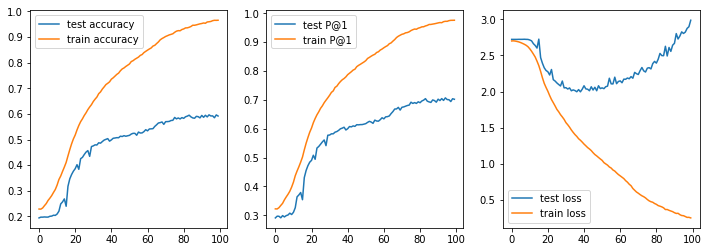

---------------------------------------------------------------------------------------------------- 

Train accuracy:0.976
Test accuracy:0.548
Train P@1:0.982
Test P@1:0.651
Train loss loss:0.210
Test loss loss:2.006


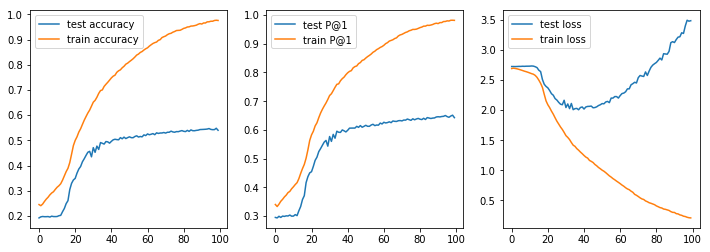

---------------------------------------------------------------------------------------------------- 

Train accuracy:0.989
Test accuracy:0.562
Train P@1:0.992
Test P@1:0.663
Train loss loss:0.129
Test loss loss:2.026


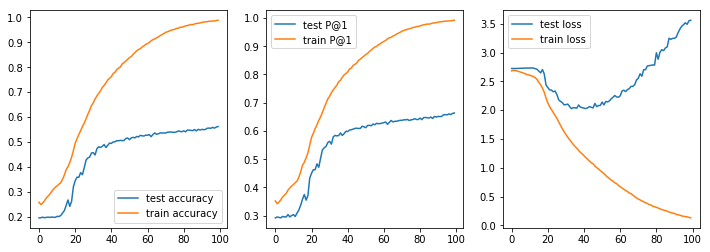

---------------------------------------------------------------------------------------------------- 

Train accuracy:0.992
Test accuracy:0.545
Train P@1:0.994
Test P@1:0.648
Train loss loss:0.109
Test loss loss:2.038


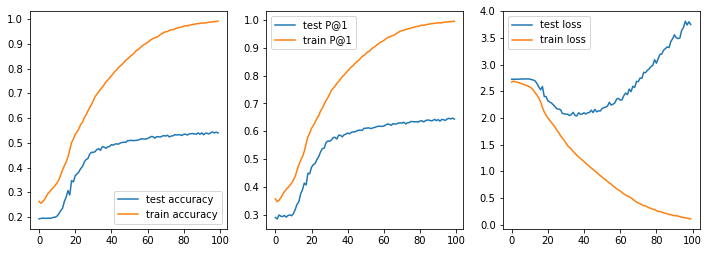

---------------------------------------------------------------------------------------------------- 



In [4]:
f = stats(simple_tst, simple_trn, ephocs=100)

## Attention

In [27]:
attn_tst, attn_trn = [], []
num_hiddens=[50, 100, 150, 200]

for num_hidden in num_hiddens:
    params_dir = params_dir_tmp+'RL/EXP/attn_simple_'+str(num_hidden)
    tf.reset_default_graph()
    m = Model(
        batch_size=200, 
        num_hidden=num_hidden,
        img_dims=trainset[0][1][0].shape[1], 
        bbox_dims=trainset[0][1][1].shape[1], 
        lr=.05,
        vocab=vocab, 
        decay_steps=10000, 
        decay_rate=0.9, 
        use_wordAttn=True
    )


    print('params_dir:', params_dir)
    print('num_hidden:', m.num_hidden)
    print('learning rate:', m.lr)

    tst, trn = m.train(trainset, testset, ephocs_num=100)
    attn_tst.append(tst)
    attn_trn.append(trn)
    
    print('\n'+'*'*100)
    print('*'*100)
    print('*'*100,'\n')

params_dir: ../data/training/models/All/unorder1_RL/EXP/attn_simple_50
num_hidden: 50
learning rate: 0.05
# Train set size: 59449
# Training batches: 297
# Test set size: 59507
# Testing batches: 297
Initializing variables
Train, ephoc: 0
batch:0 ;gs:1 ;lr:0.050 ;loss:2.679 ;acc:0.280 ;iou:0.355 ;time: 0:00:01
batch:50 ;gs:51 ;lr:0.050 ;loss:2.737 ;acc:0.225 ;iou:0.350 ;time: 0:00:19
batch:100 ;gs:101 ;lr:0.050 ;loss:2.663 ;acc:0.250 ;iou:0.365 ;time: 0:00:38
batch:150 ;gs:151 ;lr:0.050 ;loss:2.668 ;acc:0.250 ;iou:0.355 ;time: 0:00:56
batch:200 ;gs:201 ;lr:0.050 ;loss:2.702 ;acc:0.240 ;iou:0.325 ;time: 0:01:14
batch:250 ;gs:251 ;lr:0.050 ;loss:2.714 ;acc:0.195 ;iou:0.305 ;time: 0:01:32

*Train loss: 2.700 ;Train accuracy: 0.230 ;Train IOU: 0.326 ;Time: 0:01:49 

Testing, ephoc: 0
batch: 0 ;loss: 2.750 ;acc: 0.165 ;iou_acc: 0.270 ;time: 0:01:49
batch: 50 ;loss: 2.745 ;acc: 0.150 ;iou_acc: 0.265 ;time: 0:01:58
batch: 100 ;loss: 2.743 ;acc: 0.195 ;iou_acc: 0.270 ;time: 0:02:07
batch: 150 

batch:150 ;gs:2230 ;lr:0.050 ;loss:2.464 ;acc:0.355 ;iou:0.460 ;time: 0:00:55
batch:200 ;gs:2280 ;lr:0.050 ;loss:2.389 ;acc:0.375 ;iou:0.505 ;time: 0:01:13
batch:250 ;gs:2330 ;lr:0.050 ;loss:2.476 ;acc:0.380 ;iou:0.465 ;time: 0:01:31

*Train loss: 2.477 ;Train accuracy: 0.365 ;Train IOU: 0.455 ;Time: 0:01:47 

Testing, ephoc: 7
batch: 0 ;loss: 2.631 ;acc: 0.275 ;iou_acc: 0.355 ;time: 0:01:48
batch: 50 ;loss: 2.646 ;acc: 0.245 ;iou_acc: 0.365 ;time: 0:01:56
batch: 100 ;loss: 2.646 ;acc: 0.240 ;iou_acc: 0.375 ;time: 0:02:04
batch: 150 ;loss: 2.618 ;acc: 0.250 ;iou_acc: 0.355 ;time: 0:02:13
batch: 200 ;loss: 2.698 ;acc: 0.260 ;iou_acc: 0.370 ;time: 0:02:22
batch: 250 ;loss: 2.560 ;acc: 0.295 ;iou_acc: 0.385 ;time: 0:02:32

*Test loss: 2.613 ;Test accuracy 0.270 ;Test IOU: 0.382 ;Time: 0:02:40
Train, ephoc: 8
batch:0 ;gs:2377 ;lr:0.050 ;loss:2.561 ;acc:0.380 ;iou:0.450 ;time: 0:00:00
batch:50 ;gs:2427 ;lr:0.050 ;loss:2.463 ;acc:0.355 ;iou:0.440 ;time: 0:00:17
batch:100 ;gs:2477 ;lr:0.050 ;

batch: 150 ;loss: 2.229 ;acc: 0.435 ;iou_acc: 0.525 ;time: 0:02:15
batch: 200 ;loss: 2.217 ;acc: 0.420 ;iou_acc: 0.510 ;time: 0:02:24
batch: 250 ;loss: 2.222 ;acc: 0.380 ;iou_acc: 0.480 ;time: 0:02:33

*Test loss: 2.223 ;Test accuracy 0.412 ;Test IOU: 0.522 ;Time: 0:02:42
Train, ephoc: 15
batch:0 ;gs:4456 ;lr:0.050 ;loss:2.113 ;acc:0.480 ;iou:0.565 ;time: 0:00:01
batch:50 ;gs:4506 ;lr:0.050 ;loss:1.794 ;acc:0.640 ;iou:0.710 ;time: 0:00:20
batch:100 ;gs:4556 ;lr:0.050 ;loss:2.042 ;acc:0.505 ;iou:0.570 ;time: 0:00:36
batch:150 ;gs:4606 ;lr:0.050 ;loss:1.880 ;acc:0.575 ;iou:0.665 ;time: 0:00:54
batch:200 ;gs:4656 ;lr:0.050 ;loss:2.047 ;acc:0.455 ;iou:0.545 ;time: 0:01:13
batch:250 ;gs:4706 ;lr:0.050 ;loss:1.929 ;acc:0.565 ;iou:0.650 ;time: 0:01:30

*Train loss: 1.963 ;Train accuracy: 0.534 ;Train IOU: 0.621 ;Time: 0:01:47 

Testing, ephoc: 15
batch: 0 ;loss: 2.190 ;acc: 0.405 ;iou_acc: 0.505 ;time: 0:01:47
batch: 50 ;loss: 2.209 ;acc: 0.425 ;iou_acc: 0.515 ;time: 0:01:56
batch: 100 ;loss:

batch:100 ;gs:6635 ;lr:0.050 ;loss:1.575 ;acc:0.640 ;iou:0.675 ;time: 0:00:36
batch:150 ;gs:6685 ;lr:0.050 ;loss:1.432 ;acc:0.730 ;iou:0.775 ;time: 0:00:54
batch:200 ;gs:6735 ;lr:0.050 ;loss:1.373 ;acc:0.720 ;iou:0.755 ;time: 0:01:12
batch:250 ;gs:6785 ;lr:0.050 ;loss:1.707 ;acc:0.605 ;iou:0.675 ;time: 0:01:30

*Train loss: 1.525 ;Train accuracy: 0.662 ;Train IOU: 0.731 ;Time: 0:01:46 

Testing, ephoc: 22
batch: 0 ;loss: 1.953 ;acc: 0.500 ;iou_acc: 0.610 ;time: 0:01:46
batch: 50 ;loss: 2.239 ;acc: 0.470 ;iou_acc: 0.545 ;time: 0:01:55
batch: 100 ;loss: 2.193 ;acc: 0.445 ;iou_acc: 0.555 ;time: 0:02:04
batch: 150 ;loss: 2.170 ;acc: 0.480 ;iou_acc: 0.565 ;time: 0:02:13
batch: 200 ;loss: 2.069 ;acc: 0.515 ;iou_acc: 0.605 ;time: 0:02:22
batch: 250 ;loss: 2.135 ;acc: 0.480 ;iou_acc: 0.590 ;time: 0:02:31

*Test loss: 2.052 ;Test accuracy 0.487 ;Test IOU: 0.593 ;Time: 0:02:39
Train, ephoc: 23
batch:0 ;gs:6832 ;lr:0.050 ;loss:1.586 ;acc:0.615 ;iou:0.685 ;time: 0:00:01
batch:50 ;gs:6882 ;lr:0.050

batch: 100 ;loss: 2.076 ;acc: 0.480 ;iou_acc: 0.600 ;time: 0:02:04
batch: 150 ;loss: 2.060 ;acc: 0.520 ;iou_acc: 0.610 ;time: 0:02:13
batch: 200 ;loss: 1.884 ;acc: 0.525 ;iou_acc: 0.635 ;time: 0:02:22
batch: 250 ;loss: 2.089 ;acc: 0.480 ;iou_acc: 0.625 ;time: 0:02:31

*Test loss: 1.923 ;Test accuracy 0.523 ;Test IOU: 0.624 ;Time: 0:02:39
Train, ephoc: 30
batch:0 ;gs:8911 ;lr:0.050 ;loss:1.211 ;acc:0.750 ;iou:0.805 ;time: 0:00:00
batch:50 ;gs:8961 ;lr:0.050 ;loss:1.051 ;acc:0.765 ;iou:0.850 ;time: 0:00:17
batch:100 ;gs:9011 ;lr:0.050 ;loss:1.062 ;acc:0.805 ;iou:0.840 ;time: 0:00:35
batch:150 ;gs:9061 ;lr:0.050 ;loss:1.463 ;acc:0.655 ;iou:0.700 ;time: 0:00:54
batch:200 ;gs:9111 ;lr:0.050 ;loss:1.117 ;acc:0.770 ;iou:0.790 ;time: 0:01:12
batch:250 ;gs:9161 ;lr:0.050 ;loss:1.230 ;acc:0.740 ;iou:0.795 ;time: 0:01:30

*Train loss: 1.199 ;Train accuracy: 0.750 ;Train IOU: 0.802 ;Time: 0:01:46 

Testing, ephoc: 30
batch: 0 ;loss: 1.807 ;acc: 0.520 ;iou_acc: 0.615 ;time: 0:01:46
batch: 50 ;loss:

batch:50 ;gs:11040 ;lr:0.045 ;loss:0.924 ;acc:0.845 ;iou:0.885 ;time: 0:00:21
batch:100 ;gs:11090 ;lr:0.045 ;loss:1.022 ;acc:0.810 ;iou:0.845 ;time: 0:00:39
batch:150 ;gs:11140 ;lr:0.045 ;loss:1.064 ;acc:0.770 ;iou:0.840 ;time: 0:00:56
batch:200 ;gs:11190 ;lr:0.045 ;loss:1.093 ;acc:0.780 ;iou:0.820 ;time: 0:01:14
batch:250 ;gs:11240 ;lr:0.045 ;loss:0.990 ;acc:0.790 ;iou:0.840 ;time: 0:01:32

*Train loss: 0.990 ;Train accuracy: 0.804 ;Train IOU: 0.844 ;Time: 0:01:47 

Testing, ephoc: 37
batch: 0 ;loss: 1.841 ;acc: 0.535 ;iou_acc: 0.620 ;time: 0:01:48
batch: 50 ;loss: 2.162 ;acc: 0.505 ;iou_acc: 0.590 ;time: 0:01:57
batch: 100 ;loss: 2.250 ;acc: 0.465 ;iou_acc: 0.590 ;time: 0:02:06
batch: 150 ;loss: 2.132 ;acc: 0.500 ;iou_acc: 0.595 ;time: 0:02:15
batch: 200 ;loss: 1.890 ;acc: 0.540 ;iou_acc: 0.625 ;time: 0:02:24
batch: 250 ;loss: 2.033 ;acc: 0.555 ;iou_acc: 0.665 ;time: 0:02:33

*Test loss: 1.942 ;Test accuracy 0.542 ;Test IOU: 0.640 ;Time: 0:02:41
Train, ephoc: 38
batch:0 ;gs:11287 ;lr

batch: 0 ;loss: 1.735 ;acc: 0.595 ;iou_acc: 0.670 ;time: 0:01:48
batch: 50 ;loss: 2.387 ;acc: 0.495 ;iou_acc: 0.580 ;time: 0:01:57
batch: 100 ;loss: 2.324 ;acc: 0.475 ;iou_acc: 0.585 ;time: 0:02:06
batch: 150 ;loss: 2.156 ;acc: 0.525 ;iou_acc: 0.625 ;time: 0:02:15
batch: 200 ;loss: 2.007 ;acc: 0.515 ;iou_acc: 0.605 ;time: 0:02:24
batch: 250 ;loss: 2.322 ;acc: 0.505 ;iou_acc: 0.625 ;time: 0:02:34

*Test loss: 2.044 ;Test accuracy 0.546 ;Test IOU: 0.643 ;Time: 0:02:42
Train, ephoc: 45
batch:0 ;gs:13366 ;lr:0.045 ;loss:0.755 ;acc:0.860 ;iou:0.890 ;time: 0:00:00
batch:50 ;gs:13416 ;lr:0.045 ;loss:0.667 ;acc:0.875 ;iou:0.885 ;time: 0:00:18
batch:100 ;gs:13466 ;lr:0.045 ;loss:0.694 ;acc:0.900 ;iou:0.930 ;time: 0:00:36
batch:150 ;gs:13516 ;lr:0.045 ;loss:0.840 ;acc:0.850 ;iou:0.885 ;time: 0:00:54
batch:200 ;gs:13566 ;lr:0.045 ;loss:0.821 ;acc:0.855 ;iou:0.890 ;time: 0:01:12
batch:250 ;gs:13616 ;lr:0.045 ;loss:0.851 ;acc:0.840 ;iou:0.870 ;time: 0:01:30

*Train loss: 0.813 ;Train accuracy: 0.85

batch:0 ;gs:15445 ;lr:0.045 ;loss:0.731 ;acc:0.895 ;iou:0.910 ;time: 0:00:00
batch:50 ;gs:15495 ;lr:0.045 ;loss:0.484 ;acc:0.935 ;iou:0.945 ;time: 0:00:18
batch:100 ;gs:15545 ;lr:0.045 ;loss:0.878 ;acc:0.850 ;iou:0.865 ;time: 0:00:37
batch:150 ;gs:15595 ;lr:0.045 ;loss:0.650 ;acc:0.875 ;iou:0.895 ;time: 0:00:55
batch:200 ;gs:15645 ;lr:0.045 ;loss:0.623 ;acc:0.890 ;iou:0.920 ;time: 0:01:13
batch:250 ;gs:15695 ;lr:0.045 ;loss:0.595 ;acc:0.890 ;iou:0.910 ;time: 0:01:31

*Train loss: 0.691 ;Train accuracy: 0.877 ;Train IOU: 0.903 ;Time: 0:01:48 

Testing, ephoc: 52
batch: 0 ;loss: 1.939 ;acc: 0.615 ;iou_acc: 0.695 ;time: 0:01:48
batch: 50 ;loss: 2.497 ;acc: 0.535 ;iou_acc: 0.610 ;time: 0:01:58
batch: 100 ;loss: 2.582 ;acc: 0.480 ;iou_acc: 0.615 ;time: 0:02:07
batch: 150 ;loss: 2.167 ;acc: 0.560 ;iou_acc: 0.645 ;time: 0:02:16
batch: 200 ;loss: 2.094 ;acc: 0.545 ;iou_acc: 0.650 ;time: 0:02:25
batch: 250 ;loss: 2.275 ;acc: 0.540 ;iou_acc: 0.690 ;time: 0:02:34

*Test loss: 2.197 ;Test accuracy


*Train loss: 0.591 ;Train accuracy: 0.898 ;Train IOU: 0.922 ;Time: 0:01:45 

Testing, ephoc: 59
batch: 0 ;loss: 2.055 ;acc: 0.570 ;iou_acc: 0.650 ;time: 0:01:46
batch: 50 ;loss: 2.658 ;acc: 0.530 ;iou_acc: 0.595 ;time: 0:01:55
batch: 100 ;loss: 2.590 ;acc: 0.555 ;iou_acc: 0.640 ;time: 0:02:05
batch: 150 ;loss: 2.401 ;acc: 0.555 ;iou_acc: 0.640 ;time: 0:02:15
batch: 200 ;loss: 2.558 ;acc: 0.530 ;iou_acc: 0.635 ;time: 0:02:24
batch: 250 ;loss: 2.647 ;acc: 0.530 ;iou_acc: 0.655 ;time: 0:02:34

*Test loss: 2.325 ;Test accuracy 0.561 ;Test IOU: 0.657 ;Time: 0:02:42
Train, ephoc: 60
batch:0 ;gs:17821 ;lr:0.045 ;loss:0.491 ;acc:0.930 ;iou:0.940 ;time: 0:00:00
batch:50 ;gs:17871 ;lr:0.045 ;loss:0.551 ;acc:0.915 ;iou:0.945 ;time: 0:00:18
batch:100 ;gs:17921 ;lr:0.045 ;loss:0.626 ;acc:0.905 ;iou:0.930 ;time: 0:00:36
batch:150 ;gs:17971 ;lr:0.045 ;loss:0.504 ;acc:0.915 ;iou:0.920 ;time: 0:00:54
batch:200 ;gs:18021 ;lr:0.045 ;loss:0.608 ;acc:0.900 ;iou:0.920 ;time: 0:01:12
batch:250 ;gs:18071 ;lr


*Test loss: 2.557 ;Test accuracy 0.563 ;Test IOU: 0.662 ;Time: 0:02:39
Train, ephoc: 67
batch:0 ;gs:19900 ;lr:0.045 ;loss:0.490 ;acc:0.910 ;iou:0.935 ;time: 0:00:00
batch:50 ;gs:19950 ;lr:0.045 ;loss:0.374 ;acc:0.950 ;iou:0.955 ;time: 0:00:18
batch:100 ;gs:20000 ;lr:0.045 ;loss:0.480 ;acc:0.935 ;iou:0.940 ;time: 0:00:35
batch:150 ;gs:20050 ;lr:0.040 ;loss:0.519 ;acc:0.925 ;iou:0.935 ;time: 0:00:54
batch:200 ;gs:20100 ;lr:0.040 ;loss:0.479 ;acc:0.920 ;iou:0.940 ;time: 0:01:11
batch:250 ;gs:20150 ;lr:0.040 ;loss:0.401 ;acc:0.930 ;iou:0.955 ;time: 0:01:29

*Train loss: 0.454 ;Train accuracy: 0.930 ;Train IOU: 0.947 ;Time: 0:01:46 

Testing, ephoc: 67
batch: 0 ;loss: 2.269 ;acc: 0.585 ;iou_acc: 0.660 ;time: 0:01:46
batch: 50 ;loss: 2.965 ;acc: 0.525 ;iou_acc: 0.615 ;time: 0:01:56
batch: 100 ;loss: 2.844 ;acc: 0.560 ;iou_acc: 0.655 ;time: 0:02:05
batch: 150 ;loss: 2.874 ;acc: 0.540 ;iou_acc: 0.625 ;time: 0:02:15
batch: 200 ;loss: 2.676 ;acc: 0.520 ;iou_acc: 0.605 ;time: 0:02:24
batch: 250 

batch:200 ;gs:22179 ;lr:0.040 ;loss:0.328 ;acc:0.965 ;iou:0.970 ;time: 0:01:12
batch:250 ;gs:22229 ;lr:0.040 ;loss:0.390 ;acc:0.945 ;iou:0.950 ;time: 0:01:31

*Train loss: 0.433 ;Train accuracy: 0.933 ;Train IOU: 0.949 ;Time: 0:01:47 

Testing, ephoc: 74
batch: 0 ;loss: 2.215 ;acc: 0.600 ;iou_acc: 0.685 ;time: 0:01:48
batch: 50 ;loss: 2.874 ;acc: 0.560 ;iou_acc: 0.655 ;time: 0:01:57
batch: 100 ;loss: 2.586 ;acc: 0.580 ;iou_acc: 0.675 ;time: 0:02:06
batch: 150 ;loss: 2.610 ;acc: 0.600 ;iou_acc: 0.685 ;time: 0:02:16
batch: 200 ;loss: 2.765 ;acc: 0.500 ;iou_acc: 0.610 ;time: 0:02:25
batch: 250 ;loss: 2.706 ;acc: 0.530 ;iou_acc: 0.660 ;time: 0:02:35

*Test loss: 2.622 ;Test accuracy 0.561 ;Test IOU: 0.661 ;Time: 0:02:44
Train, ephoc: 75
batch:0 ;gs:22276 ;lr:0.040 ;loss:0.382 ;acc:0.945 ;iou:0.965 ;time: 0:00:00
batch:50 ;gs:22326 ;lr:0.040 ;loss:0.343 ;acc:0.960 ;iou:0.970 ;time: 0:00:18
batch:100 ;gs:22376 ;lr:0.040 ;loss:0.419 ;acc:0.925 ;iou:0.960 ;time: 0:00:36
batch:150 ;gs:22426 ;lr

batch: 150 ;loss: 3.266 ;acc: 0.535 ;iou_acc: 0.635 ;time: 0:02:16
batch: 200 ;loss: 2.845 ;acc: 0.545 ;iou_acc: 0.615 ;time: 0:02:25
batch: 250 ;loss: 3.104 ;acc: 0.545 ;iou_acc: 0.690 ;time: 0:02:35

*Test loss: 2.843 ;Test accuracy 0.567 ;Test IOU: 0.668 ;Time: 0:02:43
Train, ephoc: 82
batch:0 ;gs:24355 ;lr:0.040 ;loss:0.230 ;acc:0.965 ;iou:0.980 ;time: 0:00:01
batch:50 ;gs:24405 ;lr:0.040 ;loss:0.348 ;acc:0.960 ;iou:0.960 ;time: 0:00:19
batch:100 ;gs:24455 ;lr:0.040 ;loss:0.244 ;acc:0.985 ;iou:0.985 ;time: 0:00:37
batch:150 ;gs:24505 ;lr:0.040 ;loss:0.335 ;acc:0.965 ;iou:0.980 ;time: 0:00:54
batch:200 ;gs:24555 ;lr:0.040 ;loss:0.241 ;acc:0.975 ;iou:0.995 ;time: 0:01:12
batch:250 ;gs:24605 ;lr:0.040 ;loss:0.257 ;acc:0.960 ;iou:0.980 ;time: 0:01:30

*Train loss: 0.318 ;Train accuracy: 0.953 ;Train IOU: 0.965 ;Time: 0:01:47 

Testing, ephoc: 82
batch: 0 ;loss: 2.706 ;acc: 0.605 ;iou_acc: 0.700 ;time: 0:01:47
batch: 50 ;loss: 3.343 ;acc: 0.565 ;iou_acc: 0.645 ;time: 0:01:56
batch: 100 

batch:100 ;gs:26534 ;lr:0.040 ;loss:0.230 ;acc:0.970 ;iou:0.980 ;time: 0:00:37
batch:150 ;gs:26584 ;lr:0.040 ;loss:0.230 ;acc:0.960 ;iou:0.970 ;time: 0:00:56
batch:200 ;gs:26634 ;lr:0.040 ;loss:0.293 ;acc:0.950 ;iou:0.965 ;time: 0:01:15
batch:250 ;gs:26684 ;lr:0.040 ;loss:0.251 ;acc:0.960 ;iou:0.975 ;time: 0:01:33

*Train loss: 0.253 ;Train accuracy: 0.964 ;Train IOU: 0.975 ;Time: 0:01:51 

Testing, ephoc: 89
batch: 0 ;loss: 2.575 ;acc: 0.630 ;iou_acc: 0.710 ;time: 0:01:51
batch: 50 ;loss: 3.279 ;acc: 0.580 ;iou_acc: 0.665 ;time: 0:02:01
batch: 100 ;loss: 3.154 ;acc: 0.585 ;iou_acc: 0.685 ;time: 0:02:09
batch: 150 ;loss: 3.461 ;acc: 0.580 ;iou_acc: 0.675 ;time: 0:02:19
batch: 200 ;loss: 3.211 ;acc: 0.525 ;iou_acc: 0.655 ;time: 0:02:28
batch: 250 ;loss: 3.452 ;acc: 0.560 ;iou_acc: 0.685 ;time: 0:02:36

*Test loss: 3.165 ;Test accuracy 0.580 ;Test IOU: 0.683 ;Time: 0:02:45
Train, ephoc: 90
batch:0 ;gs:26731 ;lr:0.040 ;loss:0.246 ;acc:0.970 ;iou:0.975 ;time: 0:00:01
batch:50 ;gs:26781 ;lr

batch: 50 ;loss: 3.708 ;acc: 0.560 ;iou_acc: 0.655 ;time: 0:01:57
batch: 100 ;loss: 3.447 ;acc: 0.560 ;iou_acc: 0.685 ;time: 0:02:06
batch: 150 ;loss: 3.662 ;acc: 0.550 ;iou_acc: 0.645 ;time: 0:02:16
batch: 200 ;loss: 3.617 ;acc: 0.540 ;iou_acc: 0.640 ;time: 0:02:24
batch: 250 ;loss: 3.634 ;acc: 0.570 ;iou_acc: 0.695 ;time: 0:02:33

*Test loss: 3.356 ;Test accuracy 0.582 ;Test IOU: 0.687 ;Time: 0:02:42
Train, ephoc: 97
batch:0 ;gs:28810 ;lr:0.040 ;loss:0.098 ;acc:0.995 ;iou:0.995 ;time: 0:00:00
batch:50 ;gs:28860 ;lr:0.040 ;loss:0.164 ;acc:0.985 ;iou:0.995 ;time: 0:00:17
batch:100 ;gs:28910 ;lr:0.040 ;loss:0.211 ;acc:0.975 ;iou:0.985 ;time: 0:00:35
batch:150 ;gs:28960 ;lr:0.040 ;loss:0.184 ;acc:0.985 ;iou:0.985 ;time: 0:00:53
batch:200 ;gs:29010 ;lr:0.040 ;loss:0.201 ;acc:0.960 ;iou:0.980 ;time: 0:01:12
batch:250 ;gs:29060 ;lr:0.040 ;loss:0.167 ;acc:0.975 ;iou:0.990 ;time: 0:01:30

*Train loss: 0.201 ;Train accuracy: 0.972 ;Train IOU: 0.980 ;Time: 0:01:46 

Testing, ephoc: 97
batch: 0 

batch: 0 ;loss: 2.644 ;acc: 0.290 ;iou_acc: 0.390 ;time: 0:01:53
batch: 50 ;loss: 2.704 ;acc: 0.235 ;iou_acc: 0.350 ;time: 0:02:02
batch: 100 ;loss: 2.704 ;acc: 0.270 ;iou_acc: 0.375 ;time: 0:02:12
batch: 150 ;loss: 2.615 ;acc: 0.255 ;iou_acc: 0.370 ;time: 0:02:22
batch: 200 ;loss: 2.718 ;acc: 0.240 ;iou_acc: 0.350 ;time: 0:02:32
batch: 250 ;loss: 2.629 ;acc: 0.245 ;iou_acc: 0.345 ;time: 0:02:42

*Test loss: 2.653 ;Test accuracy 0.251 ;Test IOU: 0.358 ;Time: 0:02:51
Train, ephoc: 4
batch:0 ;gs:1189 ;lr:0.050 ;loss:2.554 ;acc:0.385 ;iou:0.470 ;time: 0:00:00
batch:50 ;gs:1239 ;lr:0.050 ;loss:2.495 ;acc:0.360 ;iou:0.470 ;time: 0:00:19
batch:100 ;gs:1289 ;lr:0.050 ;loss:2.500 ;acc:0.355 ;iou:0.465 ;time: 0:00:38
batch:150 ;gs:1339 ;lr:0.050 ;loss:2.577 ;acc:0.345 ;iou:0.455 ;time: 0:00:57
batch:200 ;gs:1389 ;lr:0.050 ;loss:2.514 ;acc:0.360 ;iou:0.455 ;time: 0:01:16
batch:250 ;gs:1439 ;lr:0.050 ;loss:2.503 ;acc:0.335 ;iou:0.395 ;time: 0:01:34

*Train loss: 2.531 ;Train accuracy: 0.341 ;Trai

batch:0 ;gs:3268 ;lr:0.050 ;loss:1.855 ;acc:0.575 ;iou:0.655 ;time: 0:00:00
batch:50 ;gs:3318 ;lr:0.050 ;loss:2.005 ;acc:0.590 ;iou:0.655 ;time: 0:00:18
batch:100 ;gs:3368 ;lr:0.050 ;loss:1.994 ;acc:0.545 ;iou:0.635 ;time: 0:00:37
batch:150 ;gs:3418 ;lr:0.050 ;loss:2.243 ;acc:0.435 ;iou:0.530 ;time: 0:00:57
batch:200 ;gs:3468 ;lr:0.050 ;loss:1.949 ;acc:0.530 ;iou:0.595 ;time: 0:01:15
batch:250 ;gs:3518 ;lr:0.050 ;loss:2.103 ;acc:0.515 ;iou:0.615 ;time: 0:01:34

*Train loss: 2.044 ;Train accuracy: 0.514 ;Train IOU: 0.597 ;Time: 0:01:51 

Testing, ephoc: 11
batch: 0 ;loss: 2.225 ;acc: 0.390 ;iou_acc: 0.510 ;time: 0:01:51
batch: 50 ;loss: 2.299 ;acc: 0.395 ;iou_acc: 0.485 ;time: 0:02:01
batch: 100 ;loss: 2.408 ;acc: 0.340 ;iou_acc: 0.475 ;time: 0:02:10
batch: 150 ;loss: 2.333 ;acc: 0.360 ;iou_acc: 0.480 ;time: 0:02:20
batch: 200 ;loss: 2.291 ;acc: 0.385 ;iou_acc: 0.480 ;time: 0:02:28
batch: 250 ;loss: 2.258 ;acc: 0.415 ;iou_acc: 0.525 ;time: 0:02:38

*Test loss: 2.276 ;Test accuracy 0.392

batch: 0 ;loss: 1.982 ;acc: 0.500 ;iou_acc: 0.605 ;time: 0:01:52
batch: 50 ;loss: 2.104 ;acc: 0.480 ;iou_acc: 0.565 ;time: 0:02:01
batch: 100 ;loss: 2.223 ;acc: 0.380 ;iou_acc: 0.515 ;time: 0:02:10
batch: 150 ;loss: 2.116 ;acc: 0.450 ;iou_acc: 0.550 ;time: 0:02:19
batch: 200 ;loss: 2.080 ;acc: 0.455 ;iou_acc: 0.530 ;time: 0:02:28
batch: 250 ;loss: 2.094 ;acc: 0.425 ;iou_acc: 0.540 ;time: 0:02:38

*Test loss: 2.075 ;Test accuracy 0.464 ;Test IOU: 0.566 ;Time: 0:02:47
Train, ephoc: 19
batch:0 ;gs:5644 ;lr:0.050 ;loss:1.584 ;acc:0.660 ;iou:0.730 ;time: 0:00:00
batch:50 ;gs:5694 ;lr:0.050 ;loss:1.309 ;acc:0.760 ;iou:0.820 ;time: 0:00:18
batch:100 ;gs:5744 ;lr:0.050 ;loss:1.451 ;acc:0.685 ;iou:0.715 ;time: 0:00:37
batch:150 ;gs:5794 ;lr:0.050 ;loss:1.576 ;acc:0.640 ;iou:0.700 ;time: 0:00:55
batch:200 ;gs:5844 ;lr:0.050 ;loss:1.632 ;acc:0.610 ;iou:0.710 ;time: 0:01:14
batch:250 ;gs:5894 ;lr:0.050 ;loss:1.550 ;acc:0.660 ;iou:0.740 ;time: 0:01:33

*Train loss: 1.551 ;Train accuracy: 0.659 ;Tra

batch:0 ;gs:7723 ;lr:0.050 ;loss:1.094 ;acc:0.815 ;iou:0.835 ;time: 0:00:00
batch:50 ;gs:7773 ;lr:0.050 ;loss:1.093 ;acc:0.755 ;iou:0.790 ;time: 0:00:20
batch:100 ;gs:7823 ;lr:0.050 ;loss:1.035 ;acc:0.785 ;iou:0.830 ;time: 0:00:37
batch:150 ;gs:7873 ;lr:0.050 ;loss:1.193 ;acc:0.790 ;iou:0.820 ;time: 0:00:57
batch:200 ;gs:7923 ;lr:0.050 ;loss:1.191 ;acc:0.765 ;iou:0.825 ;time: 0:01:16
batch:250 ;gs:7973 ;lr:0.050 ;loss:1.287 ;acc:0.720 ;iou:0.775 ;time: 0:01:36

*Train loss: 1.191 ;Train accuracy: 0.755 ;Train IOU: 0.804 ;Time: 0:01:53 

Testing, ephoc: 26
batch: 0 ;loss: 1.890 ;acc: 0.505 ;iou_acc: 0.625 ;time: 0:01:53
batch: 50 ;loss: 2.194 ;acc: 0.470 ;iou_acc: 0.570 ;time: 0:02:03
batch: 100 ;loss: 2.187 ;acc: 0.485 ;iou_acc: 0.600 ;time: 0:02:12
batch: 150 ;loss: 2.071 ;acc: 0.505 ;iou_acc: 0.580 ;time: 0:02:22
batch: 200 ;loss: 2.060 ;acc: 0.475 ;iou_acc: 0.580 ;time: 0:02:31
batch: 250 ;loss: 2.003 ;acc: 0.485 ;iou_acc: 0.605 ;time: 0:02:41

*Test loss: 2.034 ;Test accuracy 0.503

batch: 0 ;loss: 1.810 ;acc: 0.570 ;iou_acc: 0.680 ;time: 0:01:50
batch: 50 ;loss: 2.269 ;acc: 0.485 ;iou_acc: 0.570 ;time: 0:01:59
batch: 100 ;loss: 2.150 ;acc: 0.480 ;iou_acc: 0.590 ;time: 0:02:08
batch: 150 ;loss: 2.104 ;acc: 0.505 ;iou_acc: 0.595 ;time: 0:02:17
batch: 200 ;loss: 2.053 ;acc: 0.520 ;iou_acc: 0.620 ;time: 0:02:27
batch: 250 ;loss: 2.016 ;acc: 0.520 ;iou_acc: 0.630 ;time: 0:02:35

*Test loss: 1.960 ;Test accuracy 0.541 ;Test IOU: 0.639 ;Time: 0:02:44
Train, ephoc: 34
batch:0 ;gs:10099 ;lr:0.045 ;loss:0.869 ;acc:0.835 ;iou:0.875 ;time: 0:00:00
batch:50 ;gs:10149 ;lr:0.045 ;loss:0.793 ;acc:0.835 ;iou:0.855 ;time: 0:00:19
batch:100 ;gs:10199 ;lr:0.045 ;loss:0.822 ;acc:0.850 ;iou:0.875 ;time: 0:00:37
batch:150 ;gs:10249 ;lr:0.045 ;loss:1.219 ;acc:0.750 ;iou:0.805 ;time: 0:00:56
batch:200 ;gs:10299 ;lr:0.045 ;loss:0.901 ;acc:0.860 ;iou:0.900 ;time: 0:01:14
batch:250 ;gs:10349 ;lr:0.045 ;loss:0.867 ;acc:0.845 ;iou:0.865 ;time: 0:01:33

*Train loss: 0.861 ;Train accuracy: 0.84

batch:0 ;gs:12178 ;lr:0.045 ;loss:0.745 ;acc:0.860 ;iou:0.905 ;time: 0:00:00
batch:50 ;gs:12228 ;lr:0.045 ;loss:0.713 ;acc:0.860 ;iou:0.890 ;time: 0:00:20
batch:100 ;gs:12278 ;lr:0.045 ;loss:0.741 ;acc:0.855 ;iou:0.885 ;time: 0:00:39
batch:150 ;gs:12328 ;lr:0.045 ;loss:0.608 ;acc:0.890 ;iou:0.930 ;time: 0:00:57
batch:200 ;gs:12378 ;lr:0.045 ;loss:0.732 ;acc:0.860 ;iou:0.880 ;time: 0:01:15
batch:250 ;gs:12428 ;lr:0.045 ;loss:0.862 ;acc:0.845 ;iou:0.870 ;time: 0:01:33

*Train loss: 0.670 ;Train accuracy: 0.885 ;Train IOU: 0.911 ;Time: 0:01:50 

Testing, ephoc: 41
batch: 0 ;loss: 1.717 ;acc: 0.615 ;iou_acc: 0.720 ;time: 0:01:50
batch: 50 ;loss: 2.417 ;acc: 0.525 ;iou_acc: 0.605 ;time: 0:01:59
batch: 100 ;loss: 2.317 ;acc: 0.485 ;iou_acc: 0.600 ;time: 0:02:08
batch: 150 ;loss: 2.272 ;acc: 0.530 ;iou_acc: 0.640 ;time: 0:02:18
batch: 200 ;loss: 2.142 ;acc: 0.545 ;iou_acc: 0.615 ;time: 0:02:27
batch: 250 ;loss: 2.283 ;acc: 0.495 ;iou_acc: 0.605 ;time: 0:02:36

*Test loss: 2.126 ;Test accuracy


*Train loss: 0.505 ;Train accuracy: 0.921 ;Train IOU: 0.940 ;Time: 0:01:49 

Testing, ephoc: 48
batch: 0 ;loss: 2.124 ;acc: 0.615 ;iou_acc: 0.725 ;time: 0:01:49
batch: 50 ;loss: 2.551 ;acc: 0.520 ;iou_acc: 0.605 ;time: 0:01:58
batch: 100 ;loss: 2.652 ;acc: 0.500 ;iou_acc: 0.635 ;time: 0:02:07
batch: 150 ;loss: 2.602 ;acc: 0.500 ;iou_acc: 0.605 ;time: 0:02:17
batch: 200 ;loss: 2.422 ;acc: 0.550 ;iou_acc: 0.640 ;time: 0:02:25
batch: 250 ;loss: 2.480 ;acc: 0.535 ;iou_acc: 0.640 ;time: 0:02:34

*Test loss: 2.347 ;Test accuracy 0.554 ;Test IOU: 0.652 ;Time: 0:02:43
Train, ephoc: 49
batch:0 ;gs:14554 ;lr:0.045 ;loss:0.478 ;acc:0.905 ;iou:0.935 ;time: 0:00:00
batch:50 ;gs:14604 ;lr:0.045 ;loss:0.576 ;acc:0.890 ;iou:0.915 ;time: 0:00:19
batch:100 ;gs:14654 ;lr:0.045 ;loss:0.550 ;acc:0.915 ;iou:0.925 ;time: 0:00:37
batch:150 ;gs:14704 ;lr:0.045 ;loss:0.385 ;acc:0.955 ;iou:0.970 ;time: 0:00:55
batch:200 ;gs:14754 ;lr:0.045 ;loss:0.569 ;acc:0.900 ;iou:0.920 ;time: 0:01:14
batch:250 ;gs:14804 ;lr


*Test loss: 2.500 ;Test accuracy 0.572 ;Test IOU: 0.671 ;Time: 0:02:44
Train, ephoc: 56
batch:0 ;gs:16633 ;lr:0.045 ;loss:0.177 ;acc:0.995 ;iou:0.995 ;time: 0:00:01
batch:50 ;gs:16683 ;lr:0.045 ;loss:0.312 ;acc:0.970 ;iou:0.995 ;time: 0:00:19
batch:100 ;gs:16733 ;lr:0.045 ;loss:0.388 ;acc:0.930 ;iou:0.940 ;time: 0:00:36
batch:150 ;gs:16783 ;lr:0.045 ;loss:0.349 ;acc:0.925 ;iou:0.950 ;time: 0:00:55
batch:200 ;gs:16833 ;lr:0.045 ;loss:0.357 ;acc:0.955 ;iou:0.955 ;time: 0:01:14
batch:250 ;gs:16883 ;lr:0.045 ;loss:0.403 ;acc:0.945 ;iou:0.955 ;time: 0:01:32

*Train loss: 0.361 ;Train accuracy: 0.947 ;Train IOU: 0.961 ;Time: 0:01:49 

Testing, ephoc: 56
batch: 0 ;loss: 2.114 ;acc: 0.615 ;iou_acc: 0.735 ;time: 0:01:50
batch: 50 ;loss: 2.842 ;acc: 0.580 ;iou_acc: 0.680 ;time: 0:01:59
batch: 100 ;loss: 2.670 ;acc: 0.530 ;iou_acc: 0.675 ;time: 0:02:08
batch: 150 ;loss: 2.630 ;acc: 0.525 ;iou_acc: 0.625 ;time: 0:02:18
batch: 200 ;loss: 2.310 ;acc: 0.570 ;iou_acc: 0.675 ;time: 0:02:27
batch: 250 

batch:200 ;gs:18912 ;lr:0.045 ;loss:0.225 ;acc:0.965 ;iou:0.980 ;time: 0:01:15
batch:250 ;gs:18962 ;lr:0.045 ;loss:0.189 ;acc:0.990 ;iou:0.995 ;time: 0:01:32

*Train loss: 0.264 ;Train accuracy: 0.965 ;Train IOU: 0.974 ;Time: 0:01:50 

Testing, ephoc: 63
batch: 0 ;loss: 2.254 ;acc: 0.625 ;iou_acc: 0.735 ;time: 0:01:50
batch: 50 ;loss: 3.211 ;acc: 0.585 ;iou_acc: 0.685 ;time: 0:01:59
batch: 100 ;loss: 2.877 ;acc: 0.550 ;iou_acc: 0.675 ;time: 0:02:08
batch: 150 ;loss: 2.988 ;acc: 0.520 ;iou_acc: 0.605 ;time: 0:02:17
batch: 200 ;loss: 2.613 ;acc: 0.555 ;iou_acc: 0.665 ;time: 0:02:26
batch: 250 ;loss: 3.007 ;acc: 0.550 ;iou_acc: 0.660 ;time: 0:02:36

*Test loss: 2.733 ;Test accuracy 0.583 ;Test IOU: 0.682 ;Time: 0:02:45
Train, ephoc: 64
batch:0 ;gs:19009 ;lr:0.045 ;loss:0.244 ;acc:0.980 ;iou:0.980 ;time: 0:00:00
batch:50 ;gs:19059 ;lr:0.045 ;loss:0.223 ;acc:0.970 ;iou:0.975 ;time: 0:00:18
batch:100 ;gs:19109 ;lr:0.045 ;loss:0.445 ;acc:0.910 ;iou:0.925 ;time: 0:00:36
batch:150 ;gs:19159 ;lr

batch: 150 ;loss: 3.349 ;acc: 0.550 ;iou_acc: 0.650 ;time: 0:02:17
batch: 200 ;loss: 3.170 ;acc: 0.555 ;iou_acc: 0.645 ;time: 0:02:26
batch: 250 ;loss: 3.427 ;acc: 0.540 ;iou_acc: 0.665 ;time: 0:02:35

*Test loss: 3.045 ;Test accuracy 0.591 ;Test IOU: 0.691 ;Time: 0:02:43
Train, ephoc: 71
batch:0 ;gs:21088 ;lr:0.040 ;loss:0.158 ;acc:0.990 ;iou:0.995 ;time: 0:00:01
batch:50 ;gs:21138 ;lr:0.040 ;loss:0.188 ;acc:0.970 ;iou:0.980 ;time: 0:00:20
batch:100 ;gs:21188 ;lr:0.040 ;loss:0.145 ;acc:0.980 ;iou:0.980 ;time: 0:00:38
batch:150 ;gs:21238 ;lr:0.040 ;loss:0.146 ;acc:0.985 ;iou:0.990 ;time: 0:00:56
batch:200 ;gs:21288 ;lr:0.040 ;loss:0.129 ;acc:0.980 ;iou:0.990 ;time: 0:01:15
batch:250 ;gs:21338 ;lr:0.040 ;loss:0.220 ;acc:0.970 ;iou:0.980 ;time: 0:01:34

*Train loss: 0.155 ;Train accuracy: 0.982 ;Train IOU: 0.988 ;Time: 0:01:50 

Testing, ephoc: 71
batch: 0 ;loss: 2.621 ;acc: 0.620 ;iou_acc: 0.765 ;time: 0:01:50
batch: 50 ;loss: 3.471 ;acc: 0.565 ;iou_acc: 0.670 ;time: 0:01:59
batch: 100 

batch:100 ;gs:23267 ;lr:0.040 ;loss:0.107 ;acc:0.985 ;iou:0.990 ;time: 0:00:37
batch:150 ;gs:23317 ;lr:0.040 ;loss:0.116 ;acc:0.995 ;iou:0.995 ;time: 0:00:55
batch:200 ;gs:23367 ;lr:0.040 ;loss:0.106 ;acc:0.985 ;iou:1.000 ;time: 0:01:14
batch:250 ;gs:23417 ;lr:0.040 ;loss:0.138 ;acc:0.985 ;iou:0.990 ;time: 0:01:32

*Train loss: 0.112 ;Train accuracy: 0.988 ;Train IOU: 0.992 ;Time: 0:01:49 

Testing, ephoc: 78
batch: 0 ;loss: 2.879 ;acc: 0.675 ;iou_acc: 0.790 ;time: 0:01:50
batch: 50 ;loss: 3.719 ;acc: 0.550 ;iou_acc: 0.645 ;time: 0:01:59
batch: 100 ;loss: 3.902 ;acc: 0.565 ;iou_acc: 0.675 ;time: 0:02:08
batch: 150 ;loss: 3.650 ;acc: 0.540 ;iou_acc: 0.650 ;time: 0:02:18
batch: 200 ;loss: 3.542 ;acc: 0.590 ;iou_acc: 0.685 ;time: 0:02:27
batch: 250 ;loss: 3.722 ;acc: 0.575 ;iou_acc: 0.705 ;time: 0:02:36

*Test loss: 3.455 ;Test accuracy 0.597 ;Test IOU: 0.700 ;Time: 0:02:45
Train, ephoc: 79
batch:0 ;gs:23464 ;lr:0.040 ;loss:0.159 ;acc:0.970 ;iou:0.975 ;time: 0:00:00
batch:50 ;gs:23514 ;lr

batch: 50 ;loss: 3.748 ;acc: 0.575 ;iou_acc: 0.685 ;time: 0:01:59
batch: 100 ;loss: 3.951 ;acc: 0.575 ;iou_acc: 0.680 ;time: 0:02:08
batch: 150 ;loss: 4.427 ;acc: 0.530 ;iou_acc: 0.635 ;time: 0:02:17
batch: 200 ;loss: 3.666 ;acc: 0.570 ;iou_acc: 0.685 ;time: 0:02:26
batch: 250 ;loss: 4.124 ;acc: 0.560 ;iou_acc: 0.685 ;time: 0:02:35

*Test loss: 3.503 ;Test accuracy 0.599 ;Test IOU: 0.700 ;Time: 0:02:44
Train, ephoc: 86
batch:0 ;gs:25543 ;lr:0.040 ;loss:0.089 ;acc:0.995 ;iou:1.000 ;time: 0:00:00
batch:50 ;gs:25593 ;lr:0.040 ;loss:0.049 ;acc:1.000 ;iou:1.000 ;time: 0:00:18
batch:100 ;gs:25643 ;lr:0.040 ;loss:0.069 ;acc:1.000 ;iou:1.000 ;time: 0:00:36
batch:150 ;gs:25693 ;lr:0.040 ;loss:0.072 ;acc:0.995 ;iou:1.000 ;time: 0:00:55
batch:200 ;gs:25743 ;lr:0.040 ;loss:0.104 ;acc:0.995 ;iou:0.995 ;time: 0:01:13
batch:250 ;gs:25793 ;lr:0.040 ;loss:0.105 ;acc:0.995 ;iou:0.995 ;time: 0:01:31

*Train loss: 0.082 ;Train accuracy: 0.993 ;Train IOU: 0.995 ;Time: 0:01:48 

Testing, ephoc: 86
batch: 0 

batch:0 ;gs:27622 ;lr:0.040 ;loss:0.071 ;acc:0.990 ;iou:0.990 ;time: 0:00:00
batch:50 ;gs:27672 ;lr:0.040 ;loss:0.116 ;acc:0.980 ;iou:0.985 ;time: 0:00:19
batch:100 ;gs:27722 ;lr:0.040 ;loss:0.068 ;acc:0.990 ;iou:0.995 ;time: 0:00:37
batch:150 ;gs:27772 ;lr:0.040 ;loss:0.045 ;acc:0.995 ;iou:0.995 ;time: 0:00:56
batch:200 ;gs:27822 ;lr:0.040 ;loss:0.072 ;acc:0.995 ;iou:1.000 ;time: 0:01:15
batch:250 ;gs:27872 ;lr:0.040 ;loss:0.032 ;acc:1.000 ;iou:1.000 ;time: 0:01:33

*Train loss: 0.072 ;Train accuracy: 0.993 ;Train IOU: 0.995 ;Time: 0:01:50 

Testing, ephoc: 93
batch: 0 ;loss: 2.893 ;acc: 0.635 ;iou_acc: 0.755 ;time: 0:01:50
batch: 50 ;loss: 4.320 ;acc: 0.580 ;iou_acc: 0.665 ;time: 0:01:59
batch: 100 ;loss: 4.430 ;acc: 0.575 ;iou_acc: 0.670 ;time: 0:02:08
batch: 150 ;loss: 4.196 ;acc: 0.540 ;iou_acc: 0.630 ;time: 0:02:17
batch: 200 ;loss: 3.890 ;acc: 0.585 ;iou_acc: 0.680 ;time: 0:02:27
batch: 250 ;loss: 4.713 ;acc: 0.560 ;iou_acc: 0.670 ;time: 0:02:36

*Test loss: 3.914 ;Test accuracy

batch:0 ;gs:1 ;lr:0.050 ;loss:2.590 ;acc:0.320 ;iou:0.400 ;time: 0:00:01
batch:50 ;gs:51 ;lr:0.050 ;loss:2.607 ;acc:0.370 ;iou:0.470 ;time: 0:00:20
batch:100 ;gs:101 ;lr:0.050 ;loss:2.676 ;acc:0.235 ;iou:0.340 ;time: 0:00:41
batch:150 ;gs:151 ;lr:0.050 ;loss:2.686 ;acc:0.230 ;iou:0.330 ;time: 0:01:02
batch:200 ;gs:201 ;lr:0.050 ;loss:2.670 ;acc:0.260 ;iou:0.335 ;time: 0:01:23
batch:250 ;gs:251 ;lr:0.050 ;loss:2.621 ;acc:0.280 ;iou:0.370 ;time: 0:01:43

*Train loss: 2.676 ;Train accuracy: 0.263 ;Train IOU: 0.358 ;Time: 0:02:02 

Testing, ephoc: 0
batch: 0 ;loss: 2.739 ;acc: 0.220 ;iou_acc: 0.300 ;time: 0:02:02
batch: 50 ;loss: 2.733 ;acc: 0.250 ;iou_acc: 0.315 ;time: 0:02:12
batch: 100 ;loss: 2.736 ;acc: 0.185 ;iou_acc: 0.290 ;time: 0:02:22
batch: 150 ;loss: 2.705 ;acc: 0.175 ;iou_acc: 0.295 ;time: 0:02:32
batch: 200 ;loss: 2.776 ;acc: 0.195 ;iou_acc: 0.285 ;time: 0:02:42
batch: 250 ;loss: 2.682 ;acc: 0.220 ;iou_acc: 0.350 ;time: 0:02:51

*Test loss: 2.719 ;Test accuracy 0.204 ;Test IOU

batch: 0 ;loss: 2.551 ;acc: 0.320 ;iou_acc: 0.445 ;time: 0:01:59
batch: 50 ;loss: 2.640 ;acc: 0.295 ;iou_acc: 0.405 ;time: 0:02:09
batch: 100 ;loss: 2.633 ;acc: 0.300 ;iou_acc: 0.415 ;time: 0:02:18
batch: 150 ;loss: 2.579 ;acc: 0.305 ;iou_acc: 0.440 ;time: 0:02:29
batch: 200 ;loss: 2.635 ;acc: 0.295 ;iou_acc: 0.395 ;time: 0:02:38
batch: 250 ;loss: 2.598 ;acc: 0.250 ;iou_acc: 0.360 ;time: 0:02:47

*Test loss: 2.587 ;Test accuracy 0.287 ;Test IOU: 0.396 ;Time: 0:02:56
Train, ephoc: 8
batch:0 ;gs:2377 ;lr:0.050 ;loss:2.354 ;acc:0.440 ;iou:0.535 ;time: 0:00:01
batch:50 ;gs:2427 ;lr:0.050 ;loss:2.232 ;acc:0.510 ;iou:0.575 ;time: 0:00:20
batch:100 ;gs:2477 ;lr:0.050 ;loss:2.444 ;acc:0.350 ;iou:0.455 ;time: 0:00:41
batch:150 ;gs:2527 ;lr:0.050 ;loss:2.259 ;acc:0.500 ;iou:0.595 ;time: 0:01:02
batch:200 ;gs:2577 ;lr:0.050 ;loss:2.238 ;acc:0.415 ;iou:0.495 ;time: 0:01:21
batch:250 ;gs:2627 ;lr:0.050 ;loss:2.257 ;acc:0.510 ;iou:0.605 ;time: 0:01:41

*Train loss: 2.312 ;Train accuracy: 0.437 ;Trai

batch:0 ;gs:4456 ;lr:0.050 ;loss:1.959 ;acc:0.525 ;iou:0.610 ;time: 0:00:00
batch:50 ;gs:4506 ;lr:0.050 ;loss:1.618 ;acc:0.640 ;iou:0.680 ;time: 0:00:20
batch:100 ;gs:4556 ;lr:0.050 ;loss:1.665 ;acc:0.650 ;iou:0.725 ;time: 0:00:39
batch:150 ;gs:4606 ;lr:0.050 ;loss:1.670 ;acc:0.610 ;iou:0.690 ;time: 0:00:59
batch:200 ;gs:4656 ;lr:0.050 ;loss:1.823 ;acc:0.615 ;iou:0.675 ;time: 0:01:20
batch:250 ;gs:4706 ;lr:0.050 ;loss:1.648 ;acc:0.610 ;iou:0.700 ;time: 0:01:40

*Train loss: 1.711 ;Train accuracy: 0.613 ;Train IOU: 0.683 ;Time: 0:01:58 

Testing, ephoc: 15
batch: 0 ;loss: 2.158 ;acc: 0.430 ;iou_acc: 0.555 ;time: 0:01:59
batch: 50 ;loss: 2.155 ;acc: 0.485 ;iou_acc: 0.580 ;time: 0:02:08
batch: 100 ;loss: 2.262 ;acc: 0.380 ;iou_acc: 0.510 ;time: 0:02:18
batch: 150 ;loss: 2.203 ;acc: 0.380 ;iou_acc: 0.515 ;time: 0:02:28
batch: 200 ;loss: 2.187 ;acc: 0.450 ;iou_acc: 0.555 ;time: 0:02:37
batch: 250 ;loss: 2.152 ;acc: 0.435 ;iou_acc: 0.540 ;time: 0:02:47

*Test loss: 2.146 ;Test accuracy 0.441

batch: 0 ;loss: 2.037 ;acc: 0.480 ;iou_acc: 0.595 ;time: 0:02:01
batch: 50 ;loss: 2.240 ;acc: 0.465 ;iou_acc: 0.565 ;time: 0:02:10
batch: 100 ;loss: 2.154 ;acc: 0.465 ;iou_acc: 0.580 ;time: 0:02:20
batch: 150 ;loss: 2.139 ;acc: 0.480 ;iou_acc: 0.600 ;time: 0:02:30
batch: 200 ;loss: 1.984 ;acc: 0.550 ;iou_acc: 0.660 ;time: 0:02:39
batch: 250 ;loss: 2.070 ;acc: 0.510 ;iou_acc: 0.605 ;time: 0:02:49

*Test loss: 2.067 ;Test accuracy 0.486 ;Test IOU: 0.589 ;Time: 0:02:59
Train, ephoc: 23
batch:0 ;gs:6832 ;lr:0.050 ;loss:1.187 ;acc:0.760 ;iou:0.810 ;time: 0:00:00
batch:50 ;gs:6882 ;lr:0.050 ;loss:1.352 ;acc:0.735 ;iou:0.775 ;time: 0:00:20
batch:100 ;gs:6932 ;lr:0.050 ;loss:1.263 ;acc:0.755 ;iou:0.805 ;time: 0:00:41
batch:150 ;gs:6982 ;lr:0.050 ;loss:1.287 ;acc:0.735 ;iou:0.790 ;time: 0:01:02
batch:200 ;gs:7032 ;lr:0.050 ;loss:1.316 ;acc:0.755 ;iou:0.800 ;time: 0:01:22
batch:250 ;gs:7082 ;lr:0.050 ;loss:1.221 ;acc:0.785 ;iou:0.860 ;time: 0:01:42

*Train loss: 1.288 ;Train accuracy: 0.736 ;Tra

batch:0 ;gs:8911 ;lr:0.050 ;loss:0.945 ;acc:0.840 ;iou:0.855 ;time: 0:00:01
batch:50 ;gs:8961 ;lr:0.050 ;loss:0.829 ;acc:0.835 ;iou:0.875 ;time: 0:00:20
batch:100 ;gs:9011 ;lr:0.050 ;loss:0.854 ;acc:0.870 ;iou:0.895 ;time: 0:00:41
batch:150 ;gs:9061 ;lr:0.050 ;loss:0.869 ;acc:0.870 ;iou:0.910 ;time: 0:01:01
batch:200 ;gs:9111 ;lr:0.050 ;loss:0.983 ;acc:0.840 ;iou:0.875 ;time: 0:01:20
batch:250 ;gs:9161 ;lr:0.050 ;loss:0.987 ;acc:0.810 ;iou:0.850 ;time: 0:01:41

*Train loss: 0.985 ;Train accuracy: 0.816 ;Train IOU: 0.854 ;Time: 0:02:01 

Testing, ephoc: 30
batch: 0 ;loss: 1.839 ;acc: 0.560 ;iou_acc: 0.635 ;time: 0:02:01
batch: 50 ;loss: 2.327 ;acc: 0.485 ;iou_acc: 0.585 ;time: 0:02:10
batch: 100 ;loss: 2.199 ;acc: 0.470 ;iou_acc: 0.585 ;time: 0:02:20
batch: 150 ;loss: 2.054 ;acc: 0.510 ;iou_acc: 0.605 ;time: 0:02:30
batch: 200 ;loss: 1.947 ;acc: 0.545 ;iou_acc: 0.635 ;time: 0:02:40
batch: 250 ;loss: 1.936 ;acc: 0.530 ;iou_acc: 0.635 ;time: 0:02:49

*Test loss: 2.027 ;Test accuracy 0.513


*Train loss: 0.724 ;Train accuracy: 0.879 ;Train IOU: 0.905 ;Time: 0:02:01 

Testing, ephoc: 37
batch: 0 ;loss: 1.998 ;acc: 0.550 ;iou_acc: 0.650 ;time: 0:02:01
batch: 50 ;loss: 2.507 ;acc: 0.530 ;iou_acc: 0.610 ;time: 0:02:11
batch: 100 ;loss: 2.280 ;acc: 0.465 ;iou_acc: 0.595 ;time: 0:02:20
batch: 150 ;loss: 2.161 ;acc: 0.520 ;iou_acc: 0.635 ;time: 0:02:31
batch: 200 ;loss: 2.158 ;acc: 0.550 ;iou_acc: 0.650 ;time: 0:02:41
batch: 250 ;loss: 2.101 ;acc: 0.545 ;iou_acc: 0.685 ;time: 0:02:50

*Test loss: 2.109 ;Test accuracy 0.542 ;Test IOU: 0.640 ;Time: 0:02:59
Train, ephoc: 38
batch:0 ;gs:11287 ;lr:0.045 ;loss:0.702 ;acc:0.885 ;iou:0.900 ;time: 0:00:01
batch:50 ;gs:11337 ;lr:0.045 ;loss:0.671 ;acc:0.895 ;iou:0.910 ;time: 0:00:21
batch:100 ;gs:11387 ;lr:0.045 ;loss:0.739 ;acc:0.875 ;iou:0.890 ;time: 0:00:41
batch:150 ;gs:11437 ;lr:0.045 ;loss:0.662 ;acc:0.905 ;iou:0.925 ;time: 0:01:01
batch:200 ;gs:11487 ;lr:0.045 ;loss:0.821 ;acc:0.855 ;iou:0.895 ;time: 0:01:22
batch:250 ;gs:11537 ;lr


*Test loss: 2.299 ;Test accuracy 0.547 ;Test IOU: 0.644 ;Time: 0:02:55
Train, ephoc: 45
batch:0 ;gs:13366 ;lr:0.045 ;loss:0.511 ;acc:0.910 ;iou:0.920 ;time: 0:00:01
batch:50 ;gs:13416 ;lr:0.045 ;loss:0.540 ;acc:0.930 ;iou:0.945 ;time: 0:00:21
batch:100 ;gs:13466 ;lr:0.045 ;loss:0.386 ;acc:0.955 ;iou:0.965 ;time: 0:00:40
batch:150 ;gs:13516 ;lr:0.045 ;loss:0.520 ;acc:0.925 ;iou:0.945 ;time: 0:01:01
batch:200 ;gs:13566 ;lr:0.045 ;loss:0.570 ;acc:0.895 ;iou:0.925 ;time: 0:01:21
batch:250 ;gs:13616 ;lr:0.045 ;loss:0.645 ;acc:0.865 ;iou:0.900 ;time: 0:01:41

*Train loss: 0.521 ;Train accuracy: 0.922 ;Train IOU: 0.939 ;Time: 0:02:00 

Testing, ephoc: 45
batch: 0 ;loss: 2.162 ;acc: 0.565 ;iou_acc: 0.665 ;time: 0:02:00
batch: 50 ;loss: 2.799 ;acc: 0.525 ;iou_acc: 0.605 ;time: 0:02:10
batch: 100 ;loss: 2.646 ;acc: 0.465 ;iou_acc: 0.585 ;time: 0:02:20
batch: 150 ;loss: 2.521 ;acc: 0.535 ;iou_acc: 0.635 ;time: 0:02:30
batch: 200 ;loss: 2.376 ;acc: 0.575 ;iou_acc: 0.685 ;time: 0:02:39
batch: 250 

batch:200 ;gs:15645 ;lr:0.045 ;loss:0.399 ;acc:0.930 ;iou:0.945 ;time: 0:01:22
batch:250 ;gs:15695 ;lr:0.045 ;loss:0.433 ;acc:0.945 ;iou:0.955 ;time: 0:01:42

*Train loss: 0.384 ;Train accuracy: 0.950 ;Train IOU: 0.961 ;Time: 0:02:00 

Testing, ephoc: 52
batch: 0 ;loss: 2.559 ;acc: 0.505 ;iou_acc: 0.620 ;time: 0:02:00
batch: 50 ;loss: 3.038 ;acc: 0.555 ;iou_acc: 0.620 ;time: 0:02:10
batch: 100 ;loss: 2.636 ;acc: 0.505 ;iou_acc: 0.605 ;time: 0:02:19
batch: 150 ;loss: 2.669 ;acc: 0.545 ;iou_acc: 0.655 ;time: 0:02:30
batch: 200 ;loss: 2.597 ;acc: 0.555 ;iou_acc: 0.655 ;time: 0:02:39
batch: 250 ;loss: 2.755 ;acc: 0.545 ;iou_acc: 0.665 ;time: 0:02:49

*Test loss: 2.619 ;Test accuracy 0.553 ;Test IOU: 0.651 ;Time: 0:02:58
Train, ephoc: 53
batch:0 ;gs:15742 ;lr:0.045 ;loss:0.319 ;acc:0.945 ;iou:0.950 ;time: 0:00:01
batch:50 ;gs:15792 ;lr:0.045 ;loss:0.262 ;acc:0.975 ;iou:0.975 ;time: 0:00:21
batch:100 ;gs:15842 ;lr:0.045 ;loss:0.599 ;acc:0.905 ;iou:0.925 ;time: 0:00:42
batch:150 ;gs:15892 ;lr

batch: 150 ;loss: 2.791 ;acc: 0.570 ;iou_acc: 0.690 ;time: 0:02:30
batch: 200 ;loss: 2.719 ;acc: 0.555 ;iou_acc: 0.660 ;time: 0:02:39
batch: 250 ;loss: 2.885 ;acc: 0.530 ;iou_acc: 0.665 ;time: 0:02:49

*Test loss: 2.793 ;Test accuracy 0.551 ;Test IOU: 0.649 ;Time: 0:02:58
Train, ephoc: 60
batch:0 ;gs:17821 ;lr:0.045 ;loss:0.233 ;acc:0.990 ;iou:0.990 ;time: 0:00:01
batch:50 ;gs:17871 ;lr:0.045 ;loss:0.226 ;acc:0.985 ;iou:0.985 ;time: 0:00:20
batch:100 ;gs:17921 ;lr:0.045 ;loss:0.231 ;acc:0.980 ;iou:0.985 ;time: 0:00:41
batch:150 ;gs:17971 ;lr:0.045 ;loss:0.204 ;acc:0.980 ;iou:0.995 ;time: 0:01:02
batch:200 ;gs:18021 ;lr:0.045 ;loss:0.364 ;acc:0.945 ;iou:0.960 ;time: 0:01:22
batch:250 ;gs:18071 ;lr:0.045 ;loss:0.290 ;acc:0.955 ;iou:0.965 ;time: 0:01:42

*Train loss: 0.267 ;Train accuracy: 0.968 ;Train IOU: 0.976 ;Time: 0:02:00 

Testing, ephoc: 60
batch: 0 ;loss: 2.611 ;acc: 0.545 ;iou_acc: 0.650 ;time: 0:02:00
batch: 50 ;loss: 3.479 ;acc: 0.515 ;iou_acc: 0.625 ;time: 0:02:10
batch: 100 

batch:100 ;gs:20000 ;lr:0.045 ;loss:0.291 ;acc:0.950 ;iou:0.960 ;time: 0:00:42
batch:150 ;gs:20050 ;lr:0.040 ;loss:0.168 ;acc:0.985 ;iou:0.985 ;time: 0:01:03
batch:200 ;gs:20100 ;lr:0.040 ;loss:0.152 ;acc:0.985 ;iou:0.990 ;time: 0:01:24
batch:250 ;gs:20150 ;lr:0.040 ;loss:0.205 ;acc:0.985 ;iou:0.990 ;time: 0:01:44

*Train loss: 0.169 ;Train accuracy: 0.984 ;Train IOU: 0.988 ;Time: 0:02:05 

Testing, ephoc: 67
batch: 0 ;loss: 2.864 ;acc: 0.570 ;iou_acc: 0.680 ;time: 0:02:05
batch: 50 ;loss: 3.958 ;acc: 0.535 ;iou_acc: 0.630 ;time: 0:02:15
batch: 100 ;loss: 3.392 ;acc: 0.535 ;iou_acc: 0.665 ;time: 0:02:25
batch: 150 ;loss: 3.174 ;acc: 0.555 ;iou_acc: 0.655 ;time: 0:02:36
batch: 200 ;loss: 3.340 ;acc: 0.510 ;iou_acc: 0.625 ;time: 0:02:47
batch: 250 ;loss: 3.382 ;acc: 0.565 ;iou_acc: 0.685 ;time: 0:02:57

*Test loss: 3.192 ;Test accuracy 0.560 ;Test IOU: 0.660 ;Time: 0:03:07
Train, ephoc: 68
batch:0 ;gs:20197 ;lr:0.040 ;loss:0.130 ;acc:0.995 ;iou:0.995 ;time: 0:00:00
batch:50 ;gs:20247 ;lr

batch: 50 ;loss: 4.425 ;acc: 0.550 ;iou_acc: 0.630 ;time: 0:02:13
batch: 100 ;loss: 3.920 ;acc: 0.510 ;iou_acc: 0.635 ;time: 0:02:23
batch: 150 ;loss: 3.478 ;acc: 0.575 ;iou_acc: 0.695 ;time: 0:02:34
batch: 200 ;loss: 3.793 ;acc: 0.535 ;iou_acc: 0.645 ;time: 0:02:45
batch: 250 ;loss: 3.749 ;acc: 0.555 ;iou_acc: 0.680 ;time: 0:02:55

*Test loss: 3.565 ;Test accuracy 0.562 ;Test IOU: 0.662 ;Time: 0:03:05
Train, ephoc: 75
batch:0 ;gs:22276 ;lr:0.040 ;loss:0.112 ;acc:0.995 ;iou:0.995 ;time: 0:00:01
batch:50 ;gs:22326 ;lr:0.040 ;loss:0.078 ;acc:0.995 ;iou:1.000 ;time: 0:00:21
batch:100 ;gs:22376 ;lr:0.040 ;loss:0.142 ;acc:0.980 ;iou:0.995 ;time: 0:00:41
batch:150 ;gs:22426 ;lr:0.040 ;loss:0.068 ;acc:1.000 ;iou:1.000 ;time: 0:01:02
batch:200 ;gs:22476 ;lr:0.040 ;loss:0.114 ;acc:0.990 ;iou:0.990 ;time: 0:01:23
batch:250 ;gs:22526 ;lr:0.040 ;loss:0.153 ;acc:0.990 ;iou:0.995 ;time: 0:01:44

*Train loss: 0.108 ;Train accuracy: 0.990 ;Train IOU: 0.993 ;Time: 0:02:04 

Testing, ephoc: 75
batch: 0 

batch:0 ;gs:24355 ;lr:0.040 ;loss:0.087 ;acc:0.995 ;iou:0.995 ;time: 0:00:00
batch:50 ;gs:24405 ;lr:0.040 ;loss:0.049 ;acc:1.000 ;iou:1.000 ;time: 0:00:21
batch:100 ;gs:24455 ;lr:0.040 ;loss:0.070 ;acc:1.000 ;iou:1.000 ;time: 0:00:41
batch:150 ;gs:24505 ;lr:0.040 ;loss:0.088 ;acc:0.990 ;iou:1.000 ;time: 0:01:01
batch:200 ;gs:24555 ;lr:0.040 ;loss:0.092 ;acc:0.990 ;iou:0.990 ;time: 0:01:22
batch:250 ;gs:24605 ;lr:0.040 ;loss:0.055 ;acc:0.995 ;iou:1.000 ;time: 0:01:43

*Train loss: 0.090 ;Train accuracy: 0.992 ;Train IOU: 0.995 ;Time: 0:02:03 

Testing, ephoc: 82
batch: 0 ;loss: 3.392 ;acc: 0.585 ;iou_acc: 0.695 ;time: 0:02:03
batch: 50 ;loss: 5.012 ;acc: 0.510 ;iou_acc: 0.575 ;time: 0:02:13
batch: 100 ;loss: 4.308 ;acc: 0.510 ;iou_acc: 0.620 ;time: 0:02:23
batch: 150 ;loss: 3.893 ;acc: 0.535 ;iou_acc: 0.645 ;time: 0:02:34
batch: 200 ;loss: 3.893 ;acc: 0.545 ;iou_acc: 0.650 ;time: 0:02:45
batch: 250 ;loss: 4.157 ;acc: 0.570 ;iou_acc: 0.710 ;time: 0:02:56

*Test loss: 3.851 ;Test accuracy


*Train loss: 0.060 ;Train accuracy: 0.995 ;Train IOU: 0.996 ;Time: 0:02:04 

Testing, ephoc: 89
batch: 0 ;loss: 3.676 ;acc: 0.585 ;iou_acc: 0.675 ;time: 0:02:04
batch: 50 ;loss: 4.964 ;acc: 0.555 ;iou_acc: 0.640 ;time: 0:02:15
batch: 100 ;loss: 3.960 ;acc: 0.560 ;iou_acc: 0.655 ;time: 0:02:25
batch: 150 ;loss: 4.294 ;acc: 0.550 ;iou_acc: 0.685 ;time: 0:02:36
batch: 200 ;loss: 3.915 ;acc: 0.565 ;iou_acc: 0.655 ;time: 0:02:47
batch: 250 ;loss: 4.349 ;acc: 0.580 ;iou_acc: 0.700 ;time: 0:02:57

*Test loss: 4.087 ;Test accuracy 0.571 ;Test IOU: 0.670 ;Time: 0:03:07
Train, ephoc: 90
batch:0 ;gs:26731 ;lr:0.040 ;loss:0.054 ;acc:1.000 ;iou:1.000 ;time: 0:00:00
batch:50 ;gs:26781 ;lr:0.040 ;loss:0.053 ;acc:0.995 ;iou:0.995 ;time: 0:00:21
batch:100 ;gs:26831 ;lr:0.040 ;loss:0.058 ;acc:0.995 ;iou:1.000 ;time: 0:00:42
batch:150 ;gs:26881 ;lr:0.040 ;loss:0.132 ;acc:0.980 ;iou:0.985 ;time: 0:01:04
batch:200 ;gs:26931 ;lr:0.040 ;loss:0.064 ;acc:1.000 ;iou:1.000 ;time: 0:01:24
batch:250 ;gs:26981 ;lr


*Test loss: 4.048 ;Test accuracy 0.580 ;Test IOU: 0.680 ;Time: 0:03:04
Train, ephoc: 97
batch:0 ;gs:28810 ;lr:0.040 ;loss:0.023 ;acc:1.000 ;iou:1.000 ;time: 0:00:00
batch:50 ;gs:28860 ;lr:0.040 ;loss:0.036 ;acc:1.000 ;iou:1.000 ;time: 0:00:21
batch:100 ;gs:28910 ;lr:0.040 ;loss:0.030 ;acc:1.000 ;iou:1.000 ;time: 0:00:41
batch:150 ;gs:28960 ;lr:0.040 ;loss:0.040 ;acc:1.000 ;iou:1.000 ;time: 0:01:02
batch:200 ;gs:29010 ;lr:0.040 ;loss:0.050 ;acc:0.995 ;iou:0.995 ;time: 0:01:23
batch:250 ;gs:29060 ;lr:0.040 ;loss:0.053 ;acc:1.000 ;iou:1.000 ;time: 0:01:43

*Train loss: 0.045 ;Train accuracy: 0.998 ;Train IOU: 0.998 ;Time: 0:02:02 

Testing, ephoc: 97
batch: 0 ;loss: 3.340 ;acc: 0.615 ;iou_acc: 0.725 ;time: 0:02:02
batch: 50 ;loss: 5.040 ;acc: 0.560 ;iou_acc: 0.640 ;time: 0:02:13
batch: 100 ;loss: 4.349 ;acc: 0.580 ;iou_acc: 0.685 ;time: 0:02:23
batch: 150 ;loss: 3.853 ;acc: 0.615 ;iou_acc: 0.740 ;time: 0:02:34
batch: 200 ;loss: 4.478 ;acc: 0.555 ;iou_acc: 0.665 ;time: 0:02:44
batch: 250 

batch: 250 ;loss: 2.644 ;acc: 0.230 ;iou_acc: 0.335 ;time: 0:02:55

*Test loss: 2.653 ;Test accuracy 0.252 ;Test IOU: 0.364 ;Time: 0:03:05
Train, ephoc: 4
batch:0 ;gs:1189 ;lr:0.050 ;loss:2.469 ;acc:0.365 ;iou:0.440 ;time: 0:00:00
batch:50 ;gs:1239 ;lr:0.050 ;loss:2.517 ;acc:0.340 ;iou:0.420 ;time: 0:00:22
batch:100 ;gs:1289 ;lr:0.050 ;loss:2.456 ;acc:0.345 ;iou:0.460 ;time: 0:00:43
batch:150 ;gs:1339 ;lr:0.050 ;loss:2.553 ;acc:0.355 ;iou:0.455 ;time: 0:01:05
batch:200 ;gs:1389 ;lr:0.050 ;loss:2.502 ;acc:0.370 ;iou:0.435 ;time: 0:01:24
batch:250 ;gs:1439 ;lr:0.050 ;loss:2.438 ;acc:0.370 ;iou:0.505 ;time: 0:01:44

*Train loss: 2.508 ;Train accuracy: 0.357 ;Train IOU: 0.450 ;Time: 0:02:03 

Testing, ephoc: 4
batch: 0 ;loss: 2.642 ;acc: 0.300 ;iou_acc: 0.390 ;time: 0:02:04
batch: 50 ;loss: 2.699 ;acc: 0.240 ;iou_acc: 0.310 ;time: 0:02:14
batch: 100 ;loss: 2.662 ;acc: 0.270 ;iou_acc: 0.345 ;time: 0:02:24
batch: 150 ;loss: 2.663 ;acc: 0.200 ;iou_acc: 0.290 ;time: 0:02:35
batch: 200 ;loss: 2

batch:200 ;gs:3468 ;lr:0.050 ;loss:2.102 ;acc:0.515 ;iou:0.590 ;time: 0:01:25
batch:250 ;gs:3518 ;lr:0.050 ;loss:2.032 ;acc:0.525 ;iou:0.605 ;time: 0:01:45

*Train loss: 2.095 ;Train accuracy: 0.508 ;Train IOU: 0.588 ;Time: 0:02:04 

Testing, ephoc: 11
batch: 0 ;loss: 2.331 ;acc: 0.350 ;iou_acc: 0.480 ;time: 0:02:05
batch: 50 ;loss: 2.462 ;acc: 0.320 ;iou_acc: 0.435 ;time: 0:02:15
batch: 100 ;loss: 2.491 ;acc: 0.305 ;iou_acc: 0.440 ;time: 0:02:25
batch: 150 ;loss: 2.449 ;acc: 0.325 ;iou_acc: 0.450 ;time: 0:02:36
batch: 200 ;loss: 2.353 ;acc: 0.370 ;iou_acc: 0.455 ;time: 0:02:46
batch: 250 ;loss: 2.362 ;acc: 0.320 ;iou_acc: 0.445 ;time: 0:02:57

*Test loss: 2.357 ;Test accuracy 0.358 ;Test IOU: 0.465 ;Time: 0:03:06
Train, ephoc: 12
batch:0 ;gs:3565 ;lr:0.050 ;loss:2.092 ;acc:0.520 ;iou:0.605 ;time: 0:00:01
batch:50 ;gs:3615 ;lr:0.050 ;loss:1.923 ;acc:0.610 ;iou:0.695 ;time: 0:00:21
batch:100 ;gs:3665 ;lr:0.050 ;loss:1.887 ;acc:0.570 ;iou:0.630 ;time: 0:00:42
batch:150 ;gs:3715 ;lr:0.050

batch: 200 ;loss: 2.150 ;acc: 0.420 ;iou_acc: 0.500 ;time: 0:02:40
batch: 250 ;loss: 2.092 ;acc: 0.445 ;iou_acc: 0.550 ;time: 0:02:51

*Test loss: 2.140 ;Test accuracy 0.440 ;Test IOU: 0.544 ;Time: 0:03:00
Train, ephoc: 19
batch:0 ;gs:5644 ;lr:0.050 ;loss:1.341 ;acc:0.715 ;iou:0.780 ;time: 0:00:00
batch:50 ;gs:5694 ;lr:0.050 ;loss:1.555 ;acc:0.655 ;iou:0.700 ;time: 0:00:21
batch:100 ;gs:5744 ;lr:0.050 ;loss:1.475 ;acc:0.675 ;iou:0.725 ;time: 0:00:41
batch:150 ;gs:5794 ;lr:0.050 ;loss:1.428 ;acc:0.705 ;iou:0.760 ;time: 0:01:02
batch:200 ;gs:5844 ;lr:0.050 ;loss:1.531 ;acc:0.645 ;iou:0.700 ;time: 0:01:23
batch:250 ;gs:5894 ;lr:0.050 ;loss:1.556 ;acc:0.620 ;iou:0.710 ;time: 0:01:42

*Train loss: 1.541 ;Train accuracy: 0.670 ;Train IOU: 0.731 ;Time: 0:02:02 

Testing, ephoc: 19
batch: 0 ;loss: 2.066 ;acc: 0.440 ;iou_acc: 0.600 ;time: 0:02:02
batch: 50 ;loss: 2.218 ;acc: 0.425 ;iou_acc: 0.515 ;time: 0:02:11
batch: 100 ;loss: 2.143 ;acc: 0.440 ;iou_acc: 0.565 ;time: 0:02:22
batch: 150 ;loss:

batch:150 ;gs:7873 ;lr:0.050 ;loss:1.028 ;acc:0.835 ;iou:0.865 ;time: 0:01:01
batch:200 ;gs:7923 ;lr:0.050 ;loss:1.002 ;acc:0.820 ;iou:0.850 ;time: 0:01:22
batch:250 ;gs:7973 ;lr:0.050 ;loss:1.285 ;acc:0.755 ;iou:0.795 ;time: 0:01:44

*Train loss: 1.143 ;Train accuracy: 0.781 ;Train IOU: 0.824 ;Time: 0:02:03 

Testing, ephoc: 26
batch: 0 ;loss: 1.886 ;acc: 0.530 ;iou_acc: 0.655 ;time: 0:02:03
batch: 50 ;loss: 2.213 ;acc: 0.505 ;iou_acc: 0.570 ;time: 0:02:13
batch: 100 ;loss: 2.155 ;acc: 0.440 ;iou_acc: 0.560 ;time: 0:02:23
batch: 150 ;loss: 2.193 ;acc: 0.480 ;iou_acc: 0.560 ;time: 0:02:34
batch: 200 ;loss: 1.947 ;acc: 0.500 ;iou_acc: 0.595 ;time: 0:02:44
batch: 250 ;loss: 2.023 ;acc: 0.520 ;iou_acc: 0.655 ;time: 0:02:54

*Test loss: 2.038 ;Test accuracy 0.498 ;Test IOU: 0.602 ;Time: 0:03:04
Train, ephoc: 27
batch:0 ;gs:8020 ;lr:0.050 ;loss:0.918 ;acc:0.840 ;iou:0.890 ;time: 0:00:01
batch:50 ;gs:8070 ;lr:0.050 ;loss:1.076 ;acc:0.775 ;iou:0.840 ;time: 0:00:24
batch:100 ;gs:8120 ;lr:0.050

batch: 150 ;loss: 2.188 ;acc: 0.505 ;iou_acc: 0.605 ;time: 0:02:43
batch: 200 ;loss: 1.970 ;acc: 0.495 ;iou_acc: 0.585 ;time: 0:02:54
batch: 250 ;loss: 2.028 ;acc: 0.510 ;iou_acc: 0.630 ;time: 0:03:04

*Test loss: 2.042 ;Test accuracy 0.526 ;Test IOU: 0.625 ;Time: 0:03:14
Train, ephoc: 34
batch:0 ;gs:10099 ;lr:0.045 ;loss:0.707 ;acc:0.890 ;iou:0.910 ;time: 0:00:00
batch:50 ;gs:10149 ;lr:0.045 ;loss:0.675 ;acc:0.910 ;iou:0.920 ;time: 0:00:22
batch:100 ;gs:10199 ;lr:0.045 ;loss:0.867 ;acc:0.875 ;iou:0.895 ;time: 0:00:44
batch:150 ;gs:10249 ;lr:0.045 ;loss:0.670 ;acc:0.880 ;iou:0.900 ;time: 0:01:05
batch:200 ;gs:10299 ;lr:0.045 ;loss:0.722 ;acc:0.880 ;iou:0.885 ;time: 0:01:26
batch:250 ;gs:10349 ;lr:0.045 ;loss:0.737 ;acc:0.885 ;iou:0.900 ;time: 0:01:48

*Train loss: 0.756 ;Train accuracy: 0.875 ;Train IOU: 0.900 ;Time: 0:02:08 

Testing, ephoc: 34
batch: 0 ;loss: 1.758 ;acc: 0.575 ;iou_acc: 0.685 ;time: 0:02:09
batch: 50 ;loss: 2.477 ;acc: 0.515 ;iou_acc: 0.605 ;time: 0:02:20
batch: 100 

batch:100 ;gs:12278 ;lr:0.045 ;loss:0.528 ;acc:0.930 ;iou:0.935 ;time: 0:00:45
batch:150 ;gs:12328 ;lr:0.045 ;loss:0.508 ;acc:0.930 ;iou:0.935 ;time: 0:01:05
batch:200 ;gs:12378 ;lr:0.045 ;loss:0.668 ;acc:0.900 ;iou:0.920 ;time: 0:01:27
batch:250 ;gs:12428 ;lr:0.045 ;loss:0.526 ;acc:0.935 ;iou:0.950 ;time: 0:01:49

*Train loss: 0.544 ;Train accuracy: 0.920 ;Train IOU: 0.937 ;Time: 0:02:10 

Testing, ephoc: 41
batch: 0 ;loss: 1.934 ;acc: 0.590 ;iou_acc: 0.680 ;time: 0:02:10
batch: 50 ;loss: 2.776 ;acc: 0.510 ;iou_acc: 0.595 ;time: 0:02:21
batch: 100 ;loss: 2.508 ;acc: 0.470 ;iou_acc: 0.605 ;time: 0:02:31
batch: 150 ;loss: 2.476 ;acc: 0.545 ;iou_acc: 0.625 ;time: 0:02:42
batch: 200 ;loss: 2.317 ;acc: 0.570 ;iou_acc: 0.650 ;time: 0:02:52
batch: 250 ;loss: 2.369 ;acc: 0.530 ;iou_acc: 0.640 ;time: 0:03:02

*Test loss: 2.374 ;Test accuracy 0.535 ;Test IOU: 0.631 ;Time: 0:03:12
Train, ephoc: 42
batch:0 ;gs:12475 ;lr:0.045 ;loss:0.506 ;acc:0.935 ;iou:0.940 ;time: 0:00:00
batch:50 ;gs:12525 ;lr

batch: 50 ;loss: 3.064 ;acc: 0.525 ;iou_acc: 0.620 ;time: 0:02:17
batch: 100 ;loss: 2.599 ;acc: 0.515 ;iou_acc: 0.655 ;time: 0:02:27
batch: 150 ;loss: 2.658 ;acc: 0.510 ;iou_acc: 0.610 ;time: 0:02:39
batch: 200 ;loss: 2.340 ;acc: 0.535 ;iou_acc: 0.635 ;time: 0:02:49
batch: 250 ;loss: 2.507 ;acc: 0.525 ;iou_acc: 0.650 ;time: 0:03:01

*Test loss: 2.514 ;Test accuracy 0.544 ;Test IOU: 0.642 ;Time: 0:03:12
Train, ephoc: 49
batch:0 ;gs:14554 ;lr:0.045 ;loss:0.320 ;acc:0.975 ;iou:0.980 ;time: 0:00:00
batch:50 ;gs:14604 ;lr:0.045 ;loss:0.290 ;acc:0.975 ;iou:0.985 ;time: 0:00:23
batch:100 ;gs:14654 ;lr:0.045 ;loss:0.464 ;acc:0.940 ;iou:0.960 ;time: 0:00:45
batch:150 ;gs:14704 ;lr:0.045 ;loss:0.358 ;acc:0.955 ;iou:0.965 ;time: 0:01:07
batch:200 ;gs:14754 ;lr:0.045 ;loss:0.563 ;acc:0.905 ;iou:0.915 ;time: 0:01:28
batch:250 ;gs:14804 ;lr:0.045 ;loss:0.333 ;acc:0.955 ;iou:0.960 ;time: 0:01:49

*Train loss: 0.370 ;Train accuracy: 0.952 ;Train IOU: 0.962 ;Time: 0:02:08 

Testing, ephoc: 49
batch: 0 

batch:0 ;gs:16633 ;lr:0.045 ;loss:0.198 ;acc:0.975 ;iou:0.985 ;time: 0:00:00
batch:50 ;gs:16683 ;lr:0.045 ;loss:0.215 ;acc:0.965 ;iou:0.980 ;time: 0:00:20
batch:100 ;gs:16733 ;lr:0.045 ;loss:0.180 ;acc:0.980 ;iou:0.985 ;time: 0:00:40
batch:150 ;gs:16783 ;lr:0.045 ;loss:0.339 ;acc:0.935 ;iou:0.935 ;time: 0:01:00
batch:200 ;gs:16833 ;lr:0.045 ;loss:0.247 ;acc:0.975 ;iou:0.990 ;time: 0:01:23
batch:250 ;gs:16883 ;lr:0.045 ;loss:0.298 ;acc:0.950 ;iou:0.960 ;time: 0:01:44

*Train loss: 0.270 ;Train accuracy: 0.967 ;Train IOU: 0.975 ;Time: 0:02:04 

Testing, ephoc: 56
batch: 0 ;loss: 2.329 ;acc: 0.590 ;iou_acc: 0.665 ;time: 0:02:04
batch: 50 ;loss: 3.459 ;acc: 0.540 ;iou_acc: 0.620 ;time: 0:02:15
batch: 100 ;loss: 3.060 ;acc: 0.530 ;iou_acc: 0.675 ;time: 0:02:25
batch: 150 ;loss: 2.760 ;acc: 0.545 ;iou_acc: 0.625 ;time: 0:02:37
batch: 200 ;loss: 2.512 ;acc: 0.550 ;iou_acc: 0.640 ;time: 0:02:47
batch: 250 ;loss: 2.579 ;acc: 0.540 ;iou_acc: 0.650 ;time: 0:02:58

*Test loss: 2.825 ;Test accuracy


*Train loss: 0.197 ;Train accuracy: 0.977 ;Train IOU: 0.982 ;Time: 0:02:06 

Testing, ephoc: 63
batch: 0 ;loss: 2.584 ;acc: 0.590 ;iou_acc: 0.680 ;time: 0:02:06
batch: 50 ;loss: 3.626 ;acc: 0.560 ;iou_acc: 0.655 ;time: 0:02:16
batch: 100 ;loss: 3.052 ;acc: 0.520 ;iou_acc: 0.635 ;time: 0:02:27
batch: 150 ;loss: 3.117 ;acc: 0.560 ;iou_acc: 0.640 ;time: 0:02:39
batch: 200 ;loss: 2.802 ;acc: 0.570 ;iou_acc: 0.660 ;time: 0:02:50
batch: 250 ;loss: 2.919 ;acc: 0.535 ;iou_acc: 0.655 ;time: 0:03:02

*Test loss: 3.144 ;Test accuracy 0.551 ;Test IOU: 0.649 ;Time: 0:03:12
Train, ephoc: 64
batch:0 ;gs:19009 ;lr:0.045 ;loss:0.193 ;acc:0.985 ;iou:0.985 ;time: 0:00:00
batch:50 ;gs:19059 ;lr:0.045 ;loss:0.132 ;acc:0.995 ;iou:0.995 ;time: 0:00:21
batch:100 ;gs:19109 ;lr:0.045 ;loss:0.215 ;acc:0.975 ;iou:0.980 ;time: 0:00:44
batch:150 ;gs:19159 ;lr:0.045 ;loss:0.105 ;acc:0.995 ;iou:1.000 ;time: 0:01:07
batch:200 ;gs:19209 ;lr:0.045 ;loss:0.238 ;acc:0.965 ;iou:0.975 ;time: 0:01:28
batch:250 ;gs:19259 ;lr


*Test loss: 3.662 ;Test accuracy 0.555 ;Test IOU: 0.652 ;Time: 0:03:10
Train, ephoc: 71
batch:0 ;gs:21088 ;lr:0.040 ;loss:0.060 ;acc:1.000 ;iou:1.000 ;time: 0:00:00
batch:50 ;gs:21138 ;lr:0.040 ;loss:0.086 ;acc:0.995 ;iou:0.995 ;time: 0:00:20
batch:100 ;gs:21188 ;lr:0.040 ;loss:0.073 ;acc:0.995 ;iou:1.000 ;time: 0:00:39
batch:150 ;gs:21238 ;lr:0.040 ;loss:0.095 ;acc:0.990 ;iou:0.990 ;time: 0:01:00
batch:200 ;gs:21288 ;lr:0.040 ;loss:0.124 ;acc:0.990 ;iou:0.995 ;time: 0:01:21
batch:250 ;gs:21338 ;lr:0.040 ;loss:0.089 ;acc:0.995 ;iou:0.995 ;time: 0:01:43

*Train loss: 0.104 ;Train accuracy: 0.992 ;Train IOU: 0.994 ;Time: 0:02:04 

Testing, ephoc: 71
batch: 0 ;loss: 2.881 ;acc: 0.635 ;iou_acc: 0.705 ;time: 0:02:04
batch: 50 ;loss: 4.285 ;acc: 0.560 ;iou_acc: 0.645 ;time: 0:02:15
batch: 100 ;loss: 3.513 ;acc: 0.535 ;iou_acc: 0.655 ;time: 0:02:24
batch: 150 ;loss: 3.589 ;acc: 0.525 ;iou_acc: 0.620 ;time: 0:02:34
batch: 200 ;loss: 3.552 ;acc: 0.545 ;iou_acc: 0.660 ;time: 0:02:44
batch: 250 

batch:200 ;gs:23367 ;lr:0.040 ;loss:0.093 ;acc:0.990 ;iou:0.995 ;time: 0:01:25
batch:250 ;gs:23417 ;lr:0.040 ;loss:0.094 ;acc:0.995 ;iou:1.000 ;time: 0:01:47

*Train loss: 0.080 ;Train accuracy: 0.994 ;Train IOU: 0.995 ;Time: 0:02:06 

Testing, ephoc: 78
batch: 0 ;loss: 3.088 ;acc: 0.590 ;iou_acc: 0.690 ;time: 0:02:06
batch: 50 ;loss: 4.610 ;acc: 0.545 ;iou_acc: 0.620 ;time: 0:02:16
batch: 100 ;loss: 3.917 ;acc: 0.485 ;iou_acc: 0.640 ;time: 0:02:26
batch: 150 ;loss: 3.928 ;acc: 0.560 ;iou_acc: 0.645 ;time: 0:02:36
batch: 200 ;loss: 3.954 ;acc: 0.525 ;iou_acc: 0.620 ;time: 0:02:46
batch: 250 ;loss: 3.606 ;acc: 0.555 ;iou_acc: 0.665 ;time: 0:02:57

*Test loss: 3.939 ;Test accuracy 0.554 ;Test IOU: 0.651 ;Time: 0:03:07
Train, ephoc: 79
batch:0 ;gs:23464 ;lr:0.040 ;loss:0.039 ;acc:1.000 ;iou:1.000 ;time: 0:00:01
batch:50 ;gs:23514 ;lr:0.040 ;loss:0.053 ;acc:0.995 ;iou:1.000 ;time: 0:00:23
batch:100 ;gs:23564 ;lr:0.040 ;loss:0.111 ;acc:0.995 ;iou:1.000 ;time: 0:00:46
batch:150 ;gs:23614 ;lr

batch: 150 ;loss: 3.972 ;acc: 0.555 ;iou_acc: 0.630 ;time: 0:02:40
batch: 200 ;loss: 4.247 ;acc: 0.515 ;iou_acc: 0.630 ;time: 0:02:51
batch: 250 ;loss: 3.638 ;acc: 0.565 ;iou_acc: 0.670 ;time: 0:03:02

*Test loss: 4.137 ;Test accuracy 0.559 ;Test IOU: 0.656 ;Time: 0:03:12
Train, ephoc: 86
batch:0 ;gs:25543 ;lr:0.040 ;loss:0.037 ;acc:1.000 ;iou:1.000 ;time: 0:00:00
batch:50 ;gs:25593 ;lr:0.040 ;loss:0.052 ;acc:0.995 ;iou:0.995 ;time: 0:00:22
batch:100 ;gs:25643 ;lr:0.040 ;loss:0.034 ;acc:1.000 ;iou:1.000 ;time: 0:00:44
batch:150 ;gs:25693 ;lr:0.040 ;loss:0.049 ;acc:1.000 ;iou:1.000 ;time: 0:01:04
batch:200 ;gs:25743 ;lr:0.040 ;loss:0.046 ;acc:1.000 ;iou:1.000 ;time: 0:01:26
batch:250 ;gs:25793 ;lr:0.040 ;loss:0.060 ;acc:0.995 ;iou:0.995 ;time: 0:01:47

*Train loss: 0.051 ;Train accuracy: 0.997 ;Train IOU: 0.998 ;Time: 0:02:05 

Testing, ephoc: 86
batch: 0 ;loss: 3.059 ;acc: 0.655 ;iou_acc: 0.745 ;time: 0:02:06
batch: 50 ;loss: 4.943 ;acc: 0.575 ;iou_acc: 0.650 ;time: 0:02:15
batch: 100 

batch:100 ;gs:27722 ;lr:0.040 ;loss:0.031 ;acc:1.000 ;iou:1.000 ;time: 0:00:45
batch:150 ;gs:27772 ;lr:0.040 ;loss:0.045 ;acc:0.995 ;iou:0.995 ;time: 0:01:05
batch:200 ;gs:27822 ;lr:0.040 ;loss:0.027 ;acc:1.000 ;iou:1.000 ;time: 0:01:27
batch:250 ;gs:27872 ;lr:0.040 ;loss:0.136 ;acc:0.980 ;iou:0.985 ;time: 0:01:49

*Train loss: 0.044 ;Train accuracy: 0.997 ;Train IOU: 0.998 ;Time: 0:02:09 

Testing, ephoc: 93
batch: 0 ;loss: 3.531 ;acc: 0.600 ;iou_acc: 0.700 ;time: 0:02:09
batch: 50 ;loss: 5.046 ;acc: 0.565 ;iou_acc: 0.655 ;time: 0:02:21
batch: 100 ;loss: 4.294 ;acc: 0.560 ;iou_acc: 0.705 ;time: 0:02:31
batch: 150 ;loss: 4.533 ;acc: 0.550 ;iou_acc: 0.615 ;time: 0:02:42
batch: 200 ;loss: 4.551 ;acc: 0.515 ;iou_acc: 0.640 ;time: 0:02:53
batch: 250 ;loss: 3.942 ;acc: 0.590 ;iou_acc: 0.705 ;time: 0:03:05

*Test loss: 4.571 ;Test accuracy 0.562 ;Test IOU: 0.659 ;Time: 0:03:15
Train, ephoc: 94
batch:0 ;gs:27919 ;lr:0.040 ;loss:0.034 ;acc:0.995 ;iou:0.995 ;time: 0:00:01
batch:50 ;gs:27969 ;lr

In [28]:
np.save(open('../data/training/results/toNoteAttn_tst.bin', 'wb'), attn_tst)
np.save(open('../data/training/results/toNoteAttn_trn.bin', 'wb'), attn_trn)

Train accuracy:0.978
Test accuracy:0.582
Train IOU:0.984
Test IOU:0.687
Train loss loss:0.175
Test loss loss:1.923


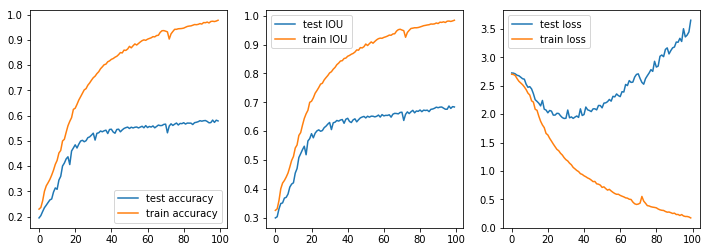

---------------------------------------------------------------------------------------------------- 

Train accuracy:0.996
Test accuracy:0.607
Train IOU:0.997
Test IOU:0.711
Train loss loss:0.051
Test loss loss:1.953


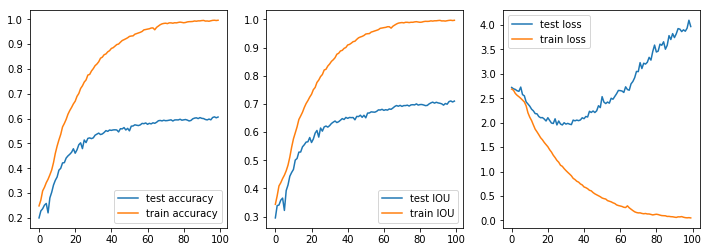

---------------------------------------------------------------------------------------------------- 

Train accuracy:0.998
Test accuracy:0.580
Train IOU:0.999
Test IOU:0.682
Train loss loss:0.036
Test loss loss:1.974


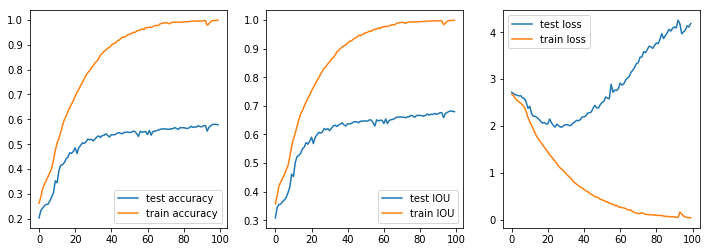

---------------------------------------------------------------------------------------------------- 

Train accuracy:0.998
Test accuracy:0.567
Train IOU:0.999
Test IOU:0.665
Train loss loss:0.031
Test loss loss:2.036


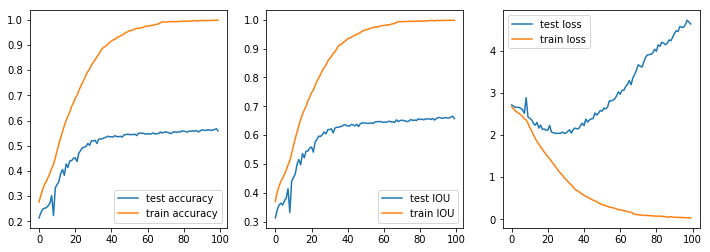

---------------------------------------------------------------------------------------------------- 



In [29]:
f = stats(attn_tst, attn_trn, ephocs=100)

## Bidirectional RNN

In [8]:
bi_tst, bi_trn = [], []
num_hiddens=[50, 100, 150, 200]

for num_hidden in num_hiddens:
    params_dir = params_dir_tmp+'RL/EXP/bi_simple_'+str(num_hidden)
    tf.reset_default_graph()
    m = Model(
        batch_size=200, 
        num_hidden=num_hidden,
        img_dims=trainset[0][1][0].shape[1], 
        bbox_dims=trainset[0][1][1].shape[1], 
        lr=.05,
        vocab=vocab, 
        decay_steps=10000, 
        decay_rate=0.9, 
        useBidirectionalRnn=True
    )


    print('params_dir:', params_dir)
    print('num_hidden:', m.num_hidden)
    print('learning rate:', m.lr)

    tst, trn = m.train(trainset, testset, ephocs_num=100)
    bi_tst.append(tst)
    bi_trn.append(trn)
    
    print('\n'+'*'*100)
    print('*'*100)
    print('*'*100,'\n')

params_dir: ../data/training/models/All/unorder1_RL/EXP/bi_simple_50
num_hidden: 50
learning rate: 0.05
# Train set size: 59449
# Training batches: 297
# Test set size: 59507
# Testing batches: 297
Initializing variables
Train, ephoc: 0
batch:0 ;gs:1 ;lr:0.050 ;loss:2.611 ;acc:0.245 ;iou:0.325 ;time: 0:00:01
batch:50 ;gs:51 ;lr:0.050 ;loss:2.740 ;acc:0.225 ;iou:0.320 ;time: 0:00:14
batch:100 ;gs:101 ;lr:0.050 ;loss:2.576 ;acc:0.245 ;iou:0.330 ;time: 0:00:28
batch:150 ;gs:151 ;lr:0.050 ;loss:2.780 ;acc:0.210 ;iou:0.295 ;time: 0:00:42
batch:200 ;gs:201 ;lr:0.050 ;loss:2.752 ;acc:0.185 ;iou:0.290 ;time: 0:00:55
batch:250 ;gs:251 ;lr:0.050 ;loss:2.622 ;acc:0.190 ;iou:0.275 ;time: 0:01:09

*Train loss: 2.702 ;Train accuracy: 0.222 ;Train IOU: 0.317 ;Time: 0:01:22 

Testing, ephoc: 0
batch: 0 ;loss: 2.741 ;acc: 0.205 ;iou_acc: 0.320 ;time: 0:01:22
batch: 50 ;loss: 2.737 ;acc: 0.205 ;iou_acc: 0.305 ;time: 0:01:30
batch: 100 ;loss: 2.756 ;acc: 0.165 ;iou_acc: 0.275 ;time: 0:01:38
batch: 150 ;l

batch:150 ;gs:2230 ;lr:0.050 ;loss:2.605 ;acc:0.250 ;iou:0.365 ;time: 0:00:41
batch:200 ;gs:2280 ;lr:0.050 ;loss:2.681 ;acc:0.260 ;iou:0.340 ;time: 0:00:55
batch:250 ;gs:2330 ;lr:0.050 ;loss:2.685 ;acc:0.230 ;iou:0.325 ;time: 0:01:09

*Train loss: 2.658 ;Train accuracy: 0.280 ;Train IOU: 0.371 ;Time: 0:01:21 

Testing, ephoc: 7
batch: 0 ;loss: 2.747 ;acc: 0.225 ;iou_acc: 0.285 ;time: 0:01:21
batch: 50 ;loss: 2.735 ;acc: 0.195 ;iou_acc: 0.275 ;time: 0:01:28
batch: 100 ;loss: 2.742 ;acc: 0.205 ;iou_acc: 0.335 ;time: 0:01:36
batch: 150 ;loss: 2.724 ;acc: 0.200 ;iou_acc: 0.335 ;time: 0:01:44
batch: 200 ;loss: 2.782 ;acc: 0.205 ;iou_acc: 0.280 ;time: 0:01:52
batch: 250 ;loss: 2.697 ;acc: 0.160 ;iou_acc: 0.290 ;time: 0:02:01

*Test loss: 2.727 ;Test accuracy 0.200 ;Test IOU: 0.303 ;Time: 0:02:07
Train, ephoc: 8
batch:0 ;gs:2377 ;lr:0.050 ;loss:2.727 ;acc:0.270 ;iou:0.345 ;time: 0:00:01
batch:50 ;gs:2427 ;lr:0.050 ;loss:2.668 ;acc:0.250 ;iou:0.355 ;time: 0:00:13
batch:100 ;gs:2477 ;lr:0.050 ;

batch: 150 ;loss: 2.609 ;acc: 0.270 ;iou_acc: 0.425 ;time: 0:01:49
batch: 200 ;loss: 2.600 ;acc: 0.285 ;iou_acc: 0.425 ;time: 0:01:57
batch: 250 ;loss: 2.576 ;acc: 0.220 ;iou_acc: 0.345 ;time: 0:02:05

*Test loss: 2.595 ;Test accuracy 0.281 ;Test IOU: 0.388 ;Time: 0:02:13
Train, ephoc: 15
batch:0 ;gs:4456 ;lr:0.050 ;loss:2.427 ;acc:0.345 ;iou:0.475 ;time: 0:00:00
batch:50 ;gs:4506 ;lr:0.050 ;loss:2.310 ;acc:0.500 ;iou:0.605 ;time: 0:00:13
batch:100 ;gs:4556 ;lr:0.050 ;loss:2.330 ;acc:0.420 ;iou:0.500 ;time: 0:00:27
batch:150 ;gs:4606 ;lr:0.050 ;loss:2.367 ;acc:0.395 ;iou:0.495 ;time: 0:00:42
batch:200 ;gs:4656 ;lr:0.050 ;loss:2.358 ;acc:0.410 ;iou:0.500 ;time: 0:00:56
batch:250 ;gs:4706 ;lr:0.050 ;loss:2.376 ;acc:0.395 ;iou:0.490 ;time: 0:01:09

*Train loss: 2.365 ;Train accuracy: 0.409 ;Train IOU: 0.498 ;Time: 0:01:22 

Testing, ephoc: 15
batch: 0 ;loss: 2.505 ;acc: 0.285 ;iou_acc: 0.375 ;time: 0:01:22
batch: 50 ;loss: 2.591 ;acc: 0.315 ;iou_acc: 0.415 ;time: 0:01:30
batch: 100 ;loss:

batch:100 ;gs:6635 ;lr:0.050 ;loss:1.764 ;acc:0.585 ;iou:0.700 ;time: 0:00:33
batch:150 ;gs:6685 ;lr:0.050 ;loss:1.905 ;acc:0.540 ;iou:0.650 ;time: 0:00:48
batch:200 ;gs:6735 ;lr:0.050 ;loss:2.220 ;acc:0.475 ;iou:0.570 ;time: 0:01:02
batch:250 ;gs:6785 ;lr:0.050 ;loss:1.711 ;acc:0.570 ;iou:0.670 ;time: 0:01:15

*Train loss: 1.837 ;Train accuracy: 0.573 ;Train IOU: 0.652 ;Time: 0:01:28 

Testing, ephoc: 22
batch: 0 ;loss: 2.059 ;acc: 0.485 ;iou_acc: 0.610 ;time: 0:01:28
batch: 50 ;loss: 2.216 ;acc: 0.415 ;iou_acc: 0.510 ;time: 0:01:36
batch: 100 ;loss: 2.255 ;acc: 0.395 ;iou_acc: 0.540 ;time: 0:01:45
batch: 150 ;loss: 2.221 ;acc: 0.410 ;iou_acc: 0.535 ;time: 0:01:54
batch: 200 ;loss: 2.205 ;acc: 0.410 ;iou_acc: 0.525 ;time: 0:02:02
batch: 250 ;loss: 2.113 ;acc: 0.435 ;iou_acc: 0.570 ;time: 0:02:10

*Test loss: 2.151 ;Test accuracy 0.428 ;Test IOU: 0.538 ;Time: 0:02:17
Train, ephoc: 23
batch:0 ;gs:6832 ;lr:0.050 ;loss:1.697 ;acc:0.645 ;iou:0.705 ;time: 0:00:01
batch:50 ;gs:6882 ;lr:0.050

batch: 100 ;loss: 2.031 ;acc: 0.460 ;iou_acc: 0.570 ;time: 0:01:42
batch: 150 ;loss: 2.034 ;acc: 0.500 ;iou_acc: 0.600 ;time: 0:01:51
batch: 200 ;loss: 1.918 ;acc: 0.500 ;iou_acc: 0.610 ;time: 0:02:00
batch: 250 ;loss: 1.922 ;acc: 0.490 ;iou_acc: 0.585 ;time: 0:02:08

*Test loss: 1.956 ;Test accuracy 0.501 ;Test IOU: 0.606 ;Time: 0:02:16
Train, ephoc: 30
batch:0 ;gs:8911 ;lr:0.050 ;loss:1.350 ;acc:0.730 ;iou:0.780 ;time: 0:00:00
batch:50 ;gs:8961 ;lr:0.050 ;loss:1.543 ;acc:0.680 ;iou:0.750 ;time: 0:00:14
batch:100 ;gs:9011 ;lr:0.050 ;loss:1.444 ;acc:0.665 ;iou:0.725 ;time: 0:00:29
batch:150 ;gs:9061 ;lr:0.050 ;loss:1.343 ;acc:0.720 ;iou:0.755 ;time: 0:00:44
batch:200 ;gs:9111 ;lr:0.050 ;loss:1.617 ;acc:0.615 ;iou:0.710 ;time: 0:00:58
batch:250 ;gs:9161 ;lr:0.050 ;loss:1.268 ;acc:0.695 ;iou:0.750 ;time: 0:01:14

*Train loss: 1.403 ;Train accuracy: 0.696 ;Train IOU: 0.758 ;Time: 0:01:28 

Testing, ephoc: 30
batch: 0 ;loss: 1.870 ;acc: 0.505 ;iou_acc: 0.615 ;time: 0:01:29
batch: 50 ;loss:

batch:50 ;gs:11040 ;lr:0.045 ;loss:1.174 ;acc:0.755 ;iou:0.800 ;time: 0:00:14
batch:100 ;gs:11090 ;lr:0.045 ;loss:1.042 ;acc:0.785 ;iou:0.825 ;time: 0:00:27
batch:150 ;gs:11140 ;lr:0.045 ;loss:1.260 ;acc:0.730 ;iou:0.775 ;time: 0:00:41
batch:200 ;gs:11190 ;lr:0.045 ;loss:1.203 ;acc:0.750 ;iou:0.810 ;time: 0:00:55
batch:250 ;gs:11240 ;lr:0.045 ;loss:1.183 ;acc:0.780 ;iou:0.810 ;time: 0:01:08

*Train loss: 1.163 ;Train accuracy: 0.764 ;Train IOU: 0.814 ;Time: 0:01:20 

Testing, ephoc: 37
batch: 0 ;loss: 1.907 ;acc: 0.520 ;iou_acc: 0.630 ;time: 0:01:20
batch: 50 ;loss: 2.161 ;acc: 0.510 ;iou_acc: 0.595 ;time: 0:01:28
batch: 100 ;loss: 2.045 ;acc: 0.485 ;iou_acc: 0.590 ;time: 0:01:35
batch: 150 ;loss: 2.138 ;acc: 0.515 ;iou_acc: 0.615 ;time: 0:01:43
batch: 200 ;loss: 1.978 ;acc: 0.535 ;iou_acc: 0.630 ;time: 0:01:51
batch: 250 ;loss: 2.036 ;acc: 0.480 ;iou_acc: 0.590 ;time: 0:01:58

*Test loss: 1.989 ;Test accuracy 0.527 ;Test IOU: 0.629 ;Time: 0:02:05
Train, ephoc: 38
batch:0 ;gs:11287 ;lr

batch: 0 ;loss: 1.905 ;acc: 0.545 ;iou_acc: 0.645 ;time: 0:01:21
batch: 50 ;loss: 2.166 ;acc: 0.525 ;iou_acc: 0.615 ;time: 0:01:28
batch: 100 ;loss: 2.152 ;acc: 0.455 ;iou_acc: 0.580 ;time: 0:01:36
batch: 150 ;loss: 2.004 ;acc: 0.535 ;iou_acc: 0.670 ;time: 0:01:44
batch: 200 ;loss: 1.998 ;acc: 0.550 ;iou_acc: 0.625 ;time: 0:01:52
batch: 250 ;loss: 2.068 ;acc: 0.515 ;iou_acc: 0.630 ;time: 0:01:59

*Test loss: 1.979 ;Test accuracy 0.547 ;Test IOU: 0.647 ;Time: 0:02:06
Train, ephoc: 45
batch:0 ;gs:13366 ;lr:0.045 ;loss:0.902 ;acc:0.835 ;iou:0.880 ;time: 0:00:01
batch:50 ;gs:13416 ;lr:0.045 ;loss:0.808 ;acc:0.860 ;iou:0.900 ;time: 0:00:14
batch:100 ;gs:13466 ;lr:0.045 ;loss:0.914 ;acc:0.860 ;iou:0.890 ;time: 0:00:27
batch:150 ;gs:13516 ;lr:0.045 ;loss:0.932 ;acc:0.840 ;iou:0.870 ;time: 0:00:41
batch:200 ;gs:13566 ;lr:0.045 ;loss:0.961 ;acc:0.820 ;iou:0.860 ;time: 0:00:54
batch:250 ;gs:13616 ;lr:0.045 ;loss:0.976 ;acc:0.800 ;iou:0.825 ;time: 0:01:07

*Train loss: 0.948 ;Train accuracy: 0.82

batch:0 ;gs:15445 ;lr:0.045 ;loss:0.692 ;acc:0.865 ;iou:0.885 ;time: 0:00:00
batch:50 ;gs:15495 ;lr:0.045 ;loss:0.771 ;acc:0.855 ;iou:0.885 ;time: 0:00:14
batch:100 ;gs:15545 ;lr:0.045 ;loss:0.709 ;acc:0.875 ;iou:0.910 ;time: 0:00:28
batch:150 ;gs:15595 ;lr:0.045 ;loss:0.595 ;acc:0.905 ;iou:0.935 ;time: 0:00:41
batch:200 ;gs:15645 ;lr:0.045 ;loss:0.720 ;acc:0.880 ;iou:0.915 ;time: 0:00:55
batch:250 ;gs:15695 ;lr:0.045 ;loss:0.694 ;acc:0.855 ;iou:0.900 ;time: 0:01:08

*Train loss: 0.769 ;Train accuracy: 0.863 ;Train IOU: 0.896 ;Time: 0:01:20 

Testing, ephoc: 52
batch: 0 ;loss: 1.727 ;acc: 0.635 ;iou_acc: 0.720 ;time: 0:01:20
batch: 50 ;loss: 2.216 ;acc: 0.570 ;iou_acc: 0.655 ;time: 0:01:28
batch: 100 ;loss: 2.203 ;acc: 0.535 ;iou_acc: 0.645 ;time: 0:01:36
batch: 150 ;loss: 2.217 ;acc: 0.535 ;iou_acc: 0.640 ;time: 0:01:44
batch: 200 ;loss: 2.059 ;acc: 0.580 ;iou_acc: 0.675 ;time: 0:01:51
batch: 250 ;loss: 2.106 ;acc: 0.550 ;iou_acc: 0.690 ;time: 0:01:59

*Test loss: 2.021 ;Test accuracy


*Train loss: 0.589 ;Train accuracy: 0.903 ;Train IOU: 0.928 ;Time: 0:01:21 

Testing, ephoc: 59
batch: 0 ;loss: 1.626 ;acc: 0.650 ;iou_acc: 0.705 ;time: 0:01:21
batch: 50 ;loss: 2.319 ;acc: 0.585 ;iou_acc: 0.645 ;time: 0:01:29
batch: 100 ;loss: 2.295 ;acc: 0.560 ;iou_acc: 0.685 ;time: 0:01:37
batch: 150 ;loss: 2.371 ;acc: 0.525 ;iou_acc: 0.630 ;time: 0:01:44
batch: 200 ;loss: 2.127 ;acc: 0.605 ;iou_acc: 0.720 ;time: 0:01:52
batch: 250 ;loss: 2.272 ;acc: 0.560 ;iou_acc: 0.680 ;time: 0:02:00

*Test loss: 2.098 ;Test accuracy 0.594 ;Test IOU: 0.700 ;Time: 0:02:07
Train, ephoc: 60
batch:0 ;gs:17821 ;lr:0.045 ;loss:0.587 ;acc:0.905 ;iou:0.930 ;time: 0:00:00
batch:50 ;gs:17871 ;lr:0.045 ;loss:0.505 ;acc:0.925 ;iou:0.945 ;time: 0:00:14
batch:100 ;gs:17921 ;lr:0.045 ;loss:0.541 ;acc:0.915 ;iou:0.940 ;time: 0:00:28
batch:150 ;gs:17971 ;lr:0.045 ;loss:0.563 ;acc:0.925 ;iou:0.940 ;time: 0:00:41
batch:200 ;gs:18021 ;lr:0.045 ;loss:0.349 ;acc:0.970 ;iou:0.975 ;time: 0:00:54
batch:250 ;gs:18071 ;lr


*Test loss: 2.192 ;Test accuracy 0.612 ;Test IOU: 0.718 ;Time: 0:02:06
Train, ephoc: 67
batch:0 ;gs:19900 ;lr:0.045 ;loss:0.336 ;acc:0.955 ;iou:0.970 ;time: 0:00:00
batch:50 ;gs:19950 ;lr:0.045 ;loss:0.302 ;acc:0.960 ;iou:0.965 ;time: 0:00:13
batch:100 ;gs:20000 ;lr:0.045 ;loss:0.386 ;acc:0.945 ;iou:0.970 ;time: 0:00:27
batch:150 ;gs:20050 ;lr:0.040 ;loss:0.367 ;acc:0.960 ;iou:0.965 ;time: 0:00:40
batch:200 ;gs:20100 ;lr:0.040 ;loss:0.366 ;acc:0.935 ;iou:0.955 ;time: 0:00:54
batch:250 ;gs:20150 ;lr:0.040 ;loss:0.458 ;acc:0.935 ;iou:0.950 ;time: 0:01:08

*Train loss: 0.417 ;Train accuracy: 0.936 ;Train IOU: 0.955 ;Time: 0:01:21 

Testing, ephoc: 67
batch: 0 ;loss: 1.710 ;acc: 0.655 ;iou_acc: 0.740 ;time: 0:01:21
batch: 50 ;loss: 2.372 ;acc: 0.605 ;iou_acc: 0.700 ;time: 0:01:28
batch: 100 ;loss: 2.175 ;acc: 0.570 ;iou_acc: 0.700 ;time: 0:01:36
batch: 150 ;loss: 2.520 ;acc: 0.540 ;iou_acc: 0.655 ;time: 0:01:43
batch: 200 ;loss: 2.200 ;acc: 0.625 ;iou_acc: 0.735 ;time: 0:01:51
batch: 250 

batch:200 ;gs:22179 ;lr:0.040 ;loss:0.376 ;acc:0.925 ;iou:0.935 ;time: 0:00:54
batch:250 ;gs:22229 ;lr:0.040 ;loss:0.285 ;acc:0.955 ;iou:0.965 ;time: 0:01:07

*Train loss: 0.310 ;Train accuracy: 0.956 ;Train IOU: 0.970 ;Time: 0:01:20 

Testing, ephoc: 74
batch: 0 ;loss: 1.879 ;acc: 0.680 ;iou_acc: 0.755 ;time: 0:01:20
batch: 50 ;loss: 2.536 ;acc: 0.615 ;iou_acc: 0.715 ;time: 0:01:28
batch: 100 ;loss: 2.674 ;acc: 0.570 ;iou_acc: 0.690 ;time: 0:01:35
batch: 150 ;loss: 2.761 ;acc: 0.580 ;iou_acc: 0.685 ;time: 0:01:44
batch: 200 ;loss: 2.406 ;acc: 0.605 ;iou_acc: 0.720 ;time: 0:01:51
batch: 250 ;loss: 2.791 ;acc: 0.580 ;iou_acc: 0.700 ;time: 0:01:59

*Test loss: 2.375 ;Test accuracy 0.619 ;Test IOU: 0.727 ;Time: 0:02:06
Train, ephoc: 75
batch:0 ;gs:22276 ;lr:0.040 ;loss:0.225 ;acc:0.980 ;iou:0.985 ;time: 0:00:01
batch:50 ;gs:22326 ;lr:0.040 ;loss:0.391 ;acc:0.945 ;iou:0.980 ;time: 0:00:13
batch:100 ;gs:22376 ;lr:0.040 ;loss:0.254 ;acc:0.960 ;iou:0.975 ;time: 0:00:27
batch:150 ;gs:22426 ;lr

batch: 150 ;loss: 3.227 ;acc: 0.570 ;iou_acc: 0.690 ;time: 0:01:44
batch: 200 ;loss: 2.673 ;acc: 0.595 ;iou_acc: 0.715 ;time: 0:01:52
batch: 250 ;loss: 3.202 ;acc: 0.560 ;iou_acc: 0.690 ;time: 0:02:00

*Test loss: 2.656 ;Test accuracy 0.627 ;Test IOU: 0.735 ;Time: 0:02:07
Train, ephoc: 82
batch:0 ;gs:24355 ;lr:0.040 ;loss:0.227 ;acc:0.980 ;iou:0.985 ;time: 0:00:00
batch:50 ;gs:24405 ;lr:0.040 ;loss:0.165 ;acc:0.980 ;iou:0.990 ;time: 0:00:13
batch:100 ;gs:24455 ;lr:0.040 ;loss:0.194 ;acc:0.980 ;iou:0.990 ;time: 0:00:26
batch:150 ;gs:24505 ;lr:0.040 ;loss:0.249 ;acc:0.965 ;iou:0.975 ;time: 0:00:39
batch:200 ;gs:24555 ;lr:0.040 ;loss:0.149 ;acc:0.990 ;iou:0.995 ;time: 0:00:53
batch:250 ;gs:24605 ;lr:0.040 ;loss:0.255 ;acc:0.975 ;iou:0.980 ;time: 0:01:07

*Train loss: 0.229 ;Train accuracy: 0.969 ;Train IOU: 0.979 ;Time: 0:01:19 

Testing, ephoc: 82
batch: 0 ;loss: 1.904 ;acc: 0.710 ;iou_acc: 0.770 ;time: 0:01:20
batch: 50 ;loss: 2.909 ;acc: 0.610 ;iou_acc: 0.720 ;time: 0:01:27
batch: 100 

batch:100 ;gs:26534 ;lr:0.040 ;loss:0.183 ;acc:0.970 ;iou:0.980 ;time: 0:00:28
batch:150 ;gs:26584 ;lr:0.040 ;loss:0.155 ;acc:0.970 ;iou:0.985 ;time: 0:00:41
batch:200 ;gs:26634 ;lr:0.040 ;loss:0.155 ;acc:0.975 ;iou:0.995 ;time: 0:00:54
batch:250 ;gs:26684 ;lr:0.040 ;loss:0.315 ;acc:0.945 ;iou:0.950 ;time: 0:01:08

*Train loss: 0.177 ;Train accuracy: 0.977 ;Train IOU: 0.984 ;Time: 0:01:20 

Testing, ephoc: 89
batch: 0 ;loss: 2.210 ;acc: 0.685 ;iou_acc: 0.760 ;time: 0:01:20
batch: 50 ;loss: 3.075 ;acc: 0.640 ;iou_acc: 0.730 ;time: 0:01:28
batch: 100 ;loss: 3.162 ;acc: 0.605 ;iou_acc: 0.695 ;time: 0:01:36
batch: 150 ;loss: 3.846 ;acc: 0.555 ;iou_acc: 0.695 ;time: 0:01:43
batch: 200 ;loss: 2.913 ;acc: 0.610 ;iou_acc: 0.715 ;time: 0:01:51
batch: 250 ;loss: 3.762 ;acc: 0.605 ;iou_acc: 0.730 ;time: 0:01:59

*Test loss: 2.917 ;Test accuracy 0.630 ;Test IOU: 0.737 ;Time: 0:02:07
Train, ephoc: 90
batch:0 ;gs:26731 ;lr:0.040 ;loss:0.096 ;acc:0.995 ;iou:0.995 ;time: 0:00:00
batch:50 ;gs:26781 ;lr

batch: 50 ;loss: 3.549 ;acc: 0.630 ;iou_acc: 0.710 ;time: 0:01:28
batch: 100 ;loss: 4.077 ;acc: 0.575 ;iou_acc: 0.675 ;time: 0:01:35
batch: 150 ;loss: 4.000 ;acc: 0.565 ;iou_acc: 0.665 ;time: 0:01:43
batch: 200 ;loss: 3.479 ;acc: 0.580 ;iou_acc: 0.695 ;time: 0:01:51
batch: 250 ;loss: 3.993 ;acc: 0.565 ;iou_acc: 0.720 ;time: 0:01:59

*Test loss: 3.366 ;Test accuracy 0.613 ;Test IOU: 0.723 ;Time: 0:02:06
Train, ephoc: 97
batch:0 ;gs:28810 ;lr:0.040 ;loss:0.625 ;acc:0.885 ;iou:0.910 ;time: 0:00:00
batch:50 ;gs:28860 ;lr:0.040 ;loss:0.114 ;acc:0.985 ;iou:0.995 ;time: 0:00:13
batch:100 ;gs:28910 ;lr:0.040 ;loss:0.116 ;acc:0.985 ;iou:0.990 ;time: 0:00:27
batch:150 ;gs:28960 ;lr:0.040 ;loss:0.091 ;acc:0.995 ;iou:1.000 ;time: 0:00:40
batch:200 ;gs:29010 ;lr:0.040 ;loss:0.092 ;acc:0.990 ;iou:0.995 ;time: 0:00:52
batch:250 ;gs:29060 ;lr:0.040 ;loss:0.147 ;acc:0.985 ;iou:0.985 ;time: 0:01:06

*Train loss: 0.137 ;Train accuracy: 0.984 ;Train IOU: 0.989 ;Time: 0:01:19 

Testing, ephoc: 97
batch: 0 

batch: 0 ;loss: 2.751 ;acc: 0.215 ;iou_acc: 0.300 ;time: 0:01:20
batch: 50 ;loss: 2.746 ;acc: 0.170 ;iou_acc: 0.255 ;time: 0:01:27
batch: 100 ;loss: 2.740 ;acc: 0.195 ;iou_acc: 0.320 ;time: 0:01:35
batch: 150 ;loss: 2.702 ;acc: 0.195 ;iou_acc: 0.285 ;time: 0:01:43
batch: 200 ;loss: 2.781 ;acc: 0.185 ;iou_acc: 0.270 ;time: 0:01:51
batch: 250 ;loss: 2.698 ;acc: 0.240 ;iou_acc: 0.325 ;time: 0:01:59

*Test loss: 2.724 ;Test accuracy 0.196 ;Test IOU: 0.297 ;Time: 0:02:06
Train, ephoc: 4
batch:0 ;gs:1189 ;lr:0.050 ;loss:2.745 ;acc:0.230 ;iou:0.345 ;time: 0:00:00
batch:50 ;gs:1239 ;lr:0.050 ;loss:2.702 ;acc:0.270 ;iou:0.340 ;time: 0:00:14
batch:100 ;gs:1289 ;lr:0.050 ;loss:2.693 ;acc:0.260 ;iou:0.330 ;time: 0:00:28
batch:150 ;gs:1339 ;lr:0.050 ;loss:2.641 ;acc:0.295 ;iou:0.390 ;time: 0:00:41
batch:200 ;gs:1389 ;lr:0.050 ;loss:2.719 ;acc:0.225 ;iou:0.325 ;time: 0:00:54
batch:250 ;gs:1439 ;lr:0.050 ;loss:2.695 ;acc:0.255 ;iou:0.370 ;time: 0:01:08

*Train loss: 2.677 ;Train accuracy: 0.265 ;Trai

batch:0 ;gs:3268 ;lr:0.050 ;loss:2.586 ;acc:0.310 ;iou:0.420 ;time: 0:00:01
batch:50 ;gs:3318 ;lr:0.050 ;loss:2.528 ;acc:0.360 ;iou:0.475 ;time: 0:00:14
batch:100 ;gs:3368 ;lr:0.050 ;loss:2.528 ;acc:0.355 ;iou:0.480 ;time: 0:00:28
batch:150 ;gs:3418 ;lr:0.050 ;loss:2.551 ;acc:0.395 ;iou:0.465 ;time: 0:00:41
batch:200 ;gs:3468 ;lr:0.050 ;loss:2.478 ;acc:0.340 ;iou:0.440 ;time: 0:00:55
batch:250 ;gs:3518 ;lr:0.050 ;loss:2.476 ;acc:0.370 ;iou:0.455 ;time: 0:01:08

*Train loss: 2.543 ;Train accuracy: 0.357 ;Train IOU: 0.451 ;Time: 0:01:20 

Testing, ephoc: 11
batch: 0 ;loss: 2.731 ;acc: 0.250 ;iou_acc: 0.350 ;time: 0:01:21
batch: 50 ;loss: 2.707 ;acc: 0.275 ;iou_acc: 0.360 ;time: 0:01:28
batch: 100 ;loss: 2.710 ;acc: 0.230 ;iou_acc: 0.370 ;time: 0:01:36
batch: 150 ;loss: 2.656 ;acc: 0.260 ;iou_acc: 0.355 ;time: 0:01:44
batch: 200 ;loss: 2.750 ;acc: 0.225 ;iou_acc: 0.340 ;time: 0:01:52
batch: 250 ;loss: 2.672 ;acc: 0.250 ;iou_acc: 0.350 ;time: 0:02:00

*Test loss: 2.693 ;Test accuracy 0.232

batch: 0 ;loss: 2.228 ;acc: 0.410 ;iou_acc: 0.530 ;time: 0:01:21
batch: 50 ;loss: 2.340 ;acc: 0.355 ;iou_acc: 0.440 ;time: 0:01:28
batch: 100 ;loss: 2.380 ;acc: 0.340 ;iou_acc: 0.465 ;time: 0:01:36
batch: 150 ;loss: 2.265 ;acc: 0.380 ;iou_acc: 0.500 ;time: 0:01:44
batch: 200 ;loss: 2.267 ;acc: 0.365 ;iou_acc: 0.475 ;time: 0:01:51
batch: 250 ;loss: 2.236 ;acc: 0.405 ;iou_acc: 0.520 ;time: 0:01:59

*Test loss: 2.291 ;Test accuracy 0.382 ;Test IOU: 0.492 ;Time: 0:02:06
Train, ephoc: 19
batch:0 ;gs:5644 ;lr:0.050 ;loss:1.840 ;acc:0.585 ;iou:0.670 ;time: 0:00:01
batch:50 ;gs:5694 ;lr:0.050 ;loss:1.941 ;acc:0.565 ;iou:0.635 ;time: 0:00:14
batch:100 ;gs:5744 ;lr:0.050 ;loss:2.029 ;acc:0.510 ;iou:0.595 ;time: 0:00:27
batch:150 ;gs:5794 ;lr:0.050 ;loss:1.929 ;acc:0.560 ;iou:0.620 ;time: 0:00:40
batch:200 ;gs:5844 ;lr:0.050 ;loss:1.715 ;acc:0.645 ;iou:0.705 ;time: 0:00:54
batch:250 ;gs:5894 ;lr:0.050 ;loss:1.794 ;acc:0.605 ;iou:0.685 ;time: 0:01:07

*Train loss: 1.935 ;Train accuracy: 0.551 ;Tra

batch:50 ;gs:7773 ;lr:0.050 ;loss:1.601 ;acc:0.610 ;iou:0.675 ;time: 0:00:13
batch:100 ;gs:7823 ;lr:0.050 ;loss:1.494 ;acc:0.650 ;iou:0.705 ;time: 0:00:27
batch:150 ;gs:7873 ;lr:0.050 ;loss:1.412 ;acc:0.755 ;iou:0.810 ;time: 0:00:41
batch:200 ;gs:7923 ;lr:0.050 ;loss:1.409 ;acc:0.725 ;iou:0.785 ;time: 0:00:54
batch:250 ;gs:7973 ;lr:0.050 ;loss:1.534 ;acc:0.665 ;iou:0.720 ;time: 0:01:07

*Train loss: 1.498 ;Train accuracy: 0.680 ;Train IOU: 0.742 ;Time: 0:01:20 

Testing, ephoc: 26
batch: 0 ;loss: 1.896 ;acc: 0.520 ;iou_acc: 0.615 ;time: 0:01:20
batch: 50 ;loss: 2.148 ;acc: 0.445 ;iou_acc: 0.555 ;time: 0:01:28
batch: 100 ;loss: 2.139 ;acc: 0.450 ;iou_acc: 0.570 ;time: 0:01:35
batch: 150 ;loss: 2.114 ;acc: 0.500 ;iou_acc: 0.595 ;time: 0:01:44
batch: 200 ;loss: 1.948 ;acc: 0.500 ;iou_acc: 0.570 ;time: 0:01:52
batch: 250 ;loss: 2.030 ;acc: 0.490 ;iou_acc: 0.625 ;time: 0:02:00

*Test loss: 2.018 ;Test accuracy 0.482 ;Test IOU: 0.588 ;Time: 0:02:07
Train, ephoc: 27
batch:0 ;gs:8020 ;lr:0.050

batch: 0 ;loss: 1.847 ;acc: 0.530 ;iou_acc: 0.650 ;time: 0:01:23
batch: 50 ;loss: 2.216 ;acc: 0.465 ;iou_acc: 0.595 ;time: 0:01:31
batch: 100 ;loss: 2.086 ;acc: 0.470 ;iou_acc: 0.590 ;time: 0:01:38
batch: 150 ;loss: 2.093 ;acc: 0.505 ;iou_acc: 0.615 ;time: 0:01:46
batch: 200 ;loss: 1.884 ;acc: 0.540 ;iou_acc: 0.620 ;time: 0:01:53
batch: 250 ;loss: 2.044 ;acc: 0.500 ;iou_acc: 0.605 ;time: 0:02:01

*Test loss: 1.963 ;Test accuracy 0.519 ;Test IOU: 0.619 ;Time: 0:02:09
Train, ephoc: 34
batch:0 ;gs:10099 ;lr:0.045 ;loss:1.135 ;acc:0.800 ;iou:0.830 ;time: 0:00:00
batch:50 ;gs:10149 ;lr:0.045 ;loss:1.074 ;acc:0.815 ;iou:0.845 ;time: 0:00:14
batch:100 ;gs:10199 ;lr:0.045 ;loss:1.290 ;acc:0.735 ;iou:0.790 ;time: 0:00:27
batch:150 ;gs:10249 ;lr:0.045 ;loss:1.369 ;acc:0.735 ;iou:0.770 ;time: 0:00:41
batch:200 ;gs:10299 ;lr:0.045 ;loss:1.273 ;acc:0.720 ;iou:0.785 ;time: 0:00:54
batch:250 ;gs:10349 ;lr:0.045 ;loss:1.234 ;acc:0.740 ;iou:0.785 ;time: 0:01:08

*Train loss: 1.154 ;Train accuracy: 0.77

batch:0 ;gs:12178 ;lr:0.045 ;loss:0.947 ;acc:0.815 ;iou:0.850 ;time: 0:00:00
batch:50 ;gs:12228 ;lr:0.045 ;loss:0.767 ;acc:0.870 ;iou:0.890 ;time: 0:00:13
batch:100 ;gs:12278 ;lr:0.045 ;loss:0.949 ;acc:0.835 ;iou:0.860 ;time: 0:00:26
batch:150 ;gs:12328 ;lr:0.045 ;loss:0.891 ;acc:0.865 ;iou:0.880 ;time: 0:00:40
batch:200 ;gs:12378 ;lr:0.045 ;loss:0.782 ;acc:0.865 ;iou:0.905 ;time: 0:00:54
batch:250 ;gs:12428 ;lr:0.045 ;loss:0.963 ;acc:0.805 ;iou:0.835 ;time: 0:01:07

*Train loss: 0.915 ;Train accuracy: 0.837 ;Train IOU: 0.871 ;Time: 0:01:19 

Testing, ephoc: 41
batch: 0 ;loss: 1.826 ;acc: 0.565 ;iou_acc: 0.690 ;time: 0:01:19
batch: 50 ;loss: 2.356 ;acc: 0.500 ;iou_acc: 0.605 ;time: 0:01:27
batch: 100 ;loss: 2.202 ;acc: 0.500 ;iou_acc: 0.600 ;time: 0:01:35
batch: 150 ;loss: 2.234 ;acc: 0.505 ;iou_acc: 0.615 ;time: 0:01:42
batch: 200 ;loss: 1.957 ;acc: 0.565 ;iou_acc: 0.625 ;time: 0:01:50
batch: 250 ;loss: 2.146 ;acc: 0.525 ;iou_acc: 0.650 ;time: 0:01:58

*Test loss: 2.028 ;Test accuracy


*Train loss: 0.722 ;Train accuracy: 0.883 ;Train IOU: 0.909 ;Time: 0:01:19 

Testing, ephoc: 48
batch: 0 ;loss: 1.786 ;acc: 0.605 ;iou_acc: 0.705 ;time: 0:01:20
batch: 50 ;loss: 2.542 ;acc: 0.515 ;iou_acc: 0.615 ;time: 0:01:27
batch: 100 ;loss: 2.343 ;acc: 0.515 ;iou_acc: 0.595 ;time: 0:01:35
batch: 150 ;loss: 2.286 ;acc: 0.540 ;iou_acc: 0.625 ;time: 0:01:43
batch: 200 ;loss: 1.995 ;acc: 0.530 ;iou_acc: 0.615 ;time: 0:01:50
batch: 250 ;loss: 2.161 ;acc: 0.525 ;iou_acc: 0.640 ;time: 0:01:58

*Test loss: 2.150 ;Test accuracy 0.541 ;Test IOU: 0.640 ;Time: 0:02:06
Train, ephoc: 49
batch:0 ;gs:14554 ;lr:0.045 ;loss:0.793 ;acc:0.875 ;iou:0.905 ;time: 0:00:00
batch:50 ;gs:14604 ;lr:0.045 ;loss:0.548 ;acc:0.940 ;iou:0.955 ;time: 0:00:13
batch:100 ;gs:14654 ;lr:0.045 ;loss:0.687 ;acc:0.885 ;iou:0.905 ;time: 0:00:27
batch:150 ;gs:14704 ;lr:0.045 ;loss:0.750 ;acc:0.875 ;iou:0.905 ;time: 0:00:40
batch:200 ;gs:14754 ;lr:0.045 ;loss:0.633 ;acc:0.905 ;iou:0.920 ;time: 0:00:53
batch:250 ;gs:14804 ;lr


*Test loss: 2.254 ;Test accuracy 0.550 ;Test IOU: 0.649 ;Time: 0:02:05
Train, ephoc: 56
batch:0 ;gs:16633 ;lr:0.045 ;loss:0.552 ;acc:0.940 ;iou:0.960 ;time: 0:00:00
batch:50 ;gs:16683 ;lr:0.045 ;loss:0.400 ;acc:0.950 ;iou:0.960 ;time: 0:00:14
batch:100 ;gs:16733 ;lr:0.045 ;loss:0.483 ;acc:0.925 ;iou:0.950 ;time: 0:00:27
batch:150 ;gs:16783 ;lr:0.045 ;loss:0.582 ;acc:0.915 ;iou:0.945 ;time: 0:00:41
batch:200 ;gs:16833 ;lr:0.045 ;loss:0.481 ;acc:0.945 ;iou:0.950 ;time: 0:00:54
batch:250 ;gs:16883 ;lr:0.045 ;loss:0.506 ;acc:0.925 ;iou:0.945 ;time: 0:01:08

*Train loss: 0.523 ;Train accuracy: 0.922 ;Train IOU: 0.941 ;Time: 0:01:21 

Testing, ephoc: 56
batch: 0 ;loss: 1.983 ;acc: 0.580 ;iou_acc: 0.685 ;time: 0:01:21
batch: 50 ;loss: 2.738 ;acc: 0.470 ;iou_acc: 0.580 ;time: 0:01:28
batch: 100 ;loss: 2.371 ;acc: 0.525 ;iou_acc: 0.630 ;time: 0:01:36
batch: 150 ;loss: 2.282 ;acc: 0.570 ;iou_acc: 0.655 ;time: 0:01:44
batch: 200 ;loss: 2.285 ;acc: 0.540 ;iou_acc: 0.620 ;time: 0:01:52
batch: 250 

batch:200 ;gs:18912 ;lr:0.045 ;loss:0.422 ;acc:0.950 ;iou:0.960 ;time: 0:00:53
batch:250 ;gs:18962 ;lr:0.045 ;loss:0.313 ;acc:0.965 ;iou:0.970 ;time: 0:01:06

*Train loss: 0.365 ;Train accuracy: 0.952 ;Train IOU: 0.965 ;Time: 0:01:18 

Testing, ephoc: 63
batch: 0 ;loss: 2.000 ;acc: 0.610 ;iou_acc: 0.710 ;time: 0:01:19
batch: 50 ;loss: 2.857 ;acc: 0.535 ;iou_acc: 0.650 ;time: 0:01:27
batch: 100 ;loss: 2.465 ;acc: 0.545 ;iou_acc: 0.660 ;time: 0:01:35
batch: 150 ;loss: 2.551 ;acc: 0.565 ;iou_acc: 0.650 ;time: 0:01:43
batch: 200 ;loss: 2.272 ;acc: 0.610 ;iou_acc: 0.680 ;time: 0:01:51
batch: 250 ;loss: 2.608 ;acc: 0.545 ;iou_acc: 0.685 ;time: 0:01:59

*Test loss: 2.414 ;Test accuracy 0.576 ;Test IOU: 0.679 ;Time: 0:02:06
Train, ephoc: 64
batch:0 ;gs:19009 ;lr:0.045 ;loss:0.278 ;acc:0.990 ;iou:0.990 ;time: 0:00:00
batch:50 ;gs:19059 ;lr:0.045 ;loss:0.321 ;acc:0.955 ;iou:0.965 ;time: 0:00:13
batch:100 ;gs:19109 ;lr:0.045 ;loss:0.346 ;acc:0.955 ;iou:0.965 ;time: 0:00:27
batch:150 ;gs:19159 ;lr

batch: 150 ;loss: 2.916 ;acc: 0.555 ;iou_acc: 0.650 ;time: 0:01:44
batch: 200 ;loss: 2.599 ;acc: 0.600 ;iou_acc: 0.665 ;time: 0:01:52
batch: 250 ;loss: 2.695 ;acc: 0.550 ;iou_acc: 0.670 ;time: 0:01:59

*Test loss: 2.709 ;Test accuracy 0.585 ;Test IOU: 0.688 ;Time: 0:02:07
Train, ephoc: 71
batch:0 ;gs:21088 ;lr:0.040 ;loss:0.306 ;acc:0.970 ;iou:0.970 ;time: 0:00:00
batch:50 ;gs:21138 ;lr:0.040 ;loss:0.208 ;acc:0.985 ;iou:0.990 ;time: 0:00:14
batch:100 ;gs:21188 ;lr:0.040 ;loss:0.230 ;acc:0.985 ;iou:0.990 ;time: 0:00:27
batch:150 ;gs:21238 ;lr:0.040 ;loss:0.194 ;acc:0.975 ;iou:0.975 ;time: 0:00:41
batch:200 ;gs:21288 ;lr:0.040 ;loss:0.332 ;acc:0.950 ;iou:0.970 ;time: 0:00:54
batch:250 ;gs:21338 ;lr:0.040 ;loss:0.209 ;acc:0.980 ;iou:0.990 ;time: 0:01:07

*Train loss: 0.224 ;Train accuracy: 0.975 ;Train IOU: 0.982 ;Time: 0:01:20 

Testing, ephoc: 71
batch: 0 ;loss: 2.255 ;acc: 0.640 ;iou_acc: 0.735 ;time: 0:01:20
batch: 50 ;loss: 3.066 ;acc: 0.555 ;iou_acc: 0.655 ;time: 0:01:28
batch: 100 

batch:100 ;gs:23267 ;lr:0.040 ;loss:0.093 ;acc:0.995 ;iou:0.995 ;time: 0:00:27
batch:150 ;gs:23317 ;lr:0.040 ;loss:0.126 ;acc:0.995 ;iou:0.995 ;time: 0:00:40
batch:200 ;gs:23367 ;lr:0.040 ;loss:0.172 ;acc:0.980 ;iou:0.985 ;time: 0:00:54
batch:250 ;gs:23417 ;lr:0.040 ;loss:0.146 ;acc:0.995 ;iou:0.995 ;time: 0:01:07

*Train loss: 0.157 ;Train accuracy: 0.984 ;Train IOU: 0.988 ;Time: 0:01:19 

Testing, ephoc: 78
batch: 0 ;loss: 2.499 ;acc: 0.620 ;iou_acc: 0.735 ;time: 0:01:19
batch: 50 ;loss: 3.652 ;acc: 0.580 ;iou_acc: 0.685 ;time: 0:01:27
batch: 100 ;loss: 3.262 ;acc: 0.565 ;iou_acc: 0.680 ;time: 0:01:34
batch: 150 ;loss: 3.164 ;acc: 0.585 ;iou_acc: 0.665 ;time: 0:01:42
batch: 200 ;loss: 3.011 ;acc: 0.600 ;iou_acc: 0.695 ;time: 0:01:50
batch: 250 ;loss: 3.344 ;acc: 0.575 ;iou_acc: 0.695 ;time: 0:01:58

*Test loss: 3.124 ;Test accuracy 0.595 ;Test IOU: 0.701 ;Time: 0:02:05
Train, ephoc: 79
batch:0 ;gs:23464 ;lr:0.040 ;loss:0.157 ;acc:0.975 ;iou:0.985 ;time: 0:00:00
batch:50 ;gs:23514 ;lr

batch: 50 ;loss: 3.607 ;acc: 0.575 ;iou_acc: 0.670 ;time: 0:01:28
batch: 100 ;loss: 3.579 ;acc: 0.550 ;iou_acc: 0.670 ;time: 0:01:35
batch: 150 ;loss: 3.480 ;acc: 0.595 ;iou_acc: 0.690 ;time: 0:01:43
batch: 200 ;loss: 3.179 ;acc: 0.615 ;iou_acc: 0.700 ;time: 0:01:51
batch: 250 ;loss: 3.801 ;acc: 0.555 ;iou_acc: 0.665 ;time: 0:01:59

*Test loss: 3.355 ;Test accuracy 0.597 ;Test IOU: 0.704 ;Time: 0:02:06
Train, ephoc: 86
batch:0 ;gs:25543 ;lr:0.040 ;loss:0.064 ;acc:1.000 ;iou:1.000 ;time: 0:00:00
batch:50 ;gs:25593 ;lr:0.040 ;loss:0.090 ;acc:1.000 ;iou:1.000 ;time: 0:00:14
batch:100 ;gs:25643 ;lr:0.040 ;loss:0.225 ;acc:0.965 ;iou:0.975 ;time: 0:00:28
batch:150 ;gs:25693 ;lr:0.040 ;loss:0.126 ;acc:0.985 ;iou:0.985 ;time: 0:00:41
batch:200 ;gs:25743 ;lr:0.040 ;loss:0.102 ;acc:1.000 ;iou:1.000 ;time: 0:00:55
batch:250 ;gs:25793 ;lr:0.040 ;loss:0.106 ;acc:0.985 ;iou:0.990 ;time: 0:01:08

*Train loss: 0.102 ;Train accuracy: 0.991 ;Train IOU: 0.993 ;Time: 0:01:20 

Testing, ephoc: 86
batch: 0 

batch:0 ;gs:27622 ;lr:0.040 ;loss:0.052 ;acc:0.995 ;iou:0.995 ;time: 0:00:00
batch:50 ;gs:27672 ;lr:0.040 ;loss:0.068 ;acc:0.995 ;iou:1.000 ;time: 0:00:13
batch:100 ;gs:27722 ;lr:0.040 ;loss:0.045 ;acc:1.000 ;iou:1.000 ;time: 0:00:27
batch:150 ;gs:27772 ;lr:0.040 ;loss:0.044 ;acc:1.000 ;iou:1.000 ;time: 0:00:40
batch:200 ;gs:27822 ;lr:0.040 ;loss:0.075 ;acc:1.000 ;iou:1.000 ;time: 0:00:53
batch:250 ;gs:27872 ;lr:0.040 ;loss:0.048 ;acc:0.995 ;iou:0.995 ;time: 0:01:06

*Train loss: 0.074 ;Train accuracy: 0.994 ;Train IOU: 0.996 ;Time: 0:01:19 

Testing, ephoc: 93
batch: 0 ;loss: 3.024 ;acc: 0.615 ;iou_acc: 0.725 ;time: 0:01:19
batch: 50 ;loss: 4.070 ;acc: 0.565 ;iou_acc: 0.675 ;time: 0:01:27
batch: 100 ;loss: 3.806 ;acc: 0.560 ;iou_acc: 0.665 ;time: 0:01:34
batch: 150 ;loss: 3.892 ;acc: 0.605 ;iou_acc: 0.690 ;time: 0:01:42
batch: 200 ;loss: 3.602 ;acc: 0.580 ;iou_acc: 0.670 ;time: 0:01:50
batch: 250 ;loss: 4.159 ;acc: 0.555 ;iou_acc: 0.685 ;time: 0:01:58

*Test loss: 3.655 ;Test accuracy

batch:0 ;gs:1 ;lr:0.050 ;loss:2.644 ;acc:0.300 ;iou:0.410 ;time: 0:00:00
batch:50 ;gs:51 ;lr:0.050 ;loss:2.638 ;acc:0.290 ;iou:0.395 ;time: 0:00:14
batch:100 ;gs:101 ;lr:0.050 ;loss:2.647 ;acc:0.295 ;iou:0.410 ;time: 0:00:27
batch:150 ;gs:151 ;lr:0.050 ;loss:2.620 ;acc:0.280 ;iou:0.375 ;time: 0:00:40
batch:200 ;gs:201 ;lr:0.050 ;loss:2.702 ;acc:0.235 ;iou:0.330 ;time: 0:00:54
batch:250 ;gs:251 ;lr:0.050 ;loss:2.678 ;acc:0.260 ;iou:0.320 ;time: 0:01:08

*Train loss: 2.682 ;Train accuracy: 0.257 ;Train IOU: 0.351 ;Time: 0:01:20 

Testing, ephoc: 0
batch: 0 ;loss: 2.748 ;acc: 0.210 ;iou_acc: 0.305 ;time: 0:01:20
batch: 50 ;loss: 2.730 ;acc: 0.235 ;iou_acc: 0.340 ;time: 0:01:28
batch: 100 ;loss: 2.739 ;acc: 0.195 ;iou_acc: 0.315 ;time: 0:01:36
batch: 150 ;loss: 2.685 ;acc: 0.255 ;iou_acc: 0.355 ;time: 0:01:43
batch: 200 ;loss: 2.787 ;acc: 0.160 ;iou_acc: 0.260 ;time: 0:01:50
batch: 250 ;loss: 2.695 ;acc: 0.190 ;iou_acc: 0.305 ;time: 0:01:58

*Test loss: 2.725 ;Test accuracy 0.194 ;Test IOU

batch: 0 ;loss: 2.752 ;acc: 0.205 ;iou_acc: 0.330 ;time: 0:01:19
batch: 50 ;loss: 2.740 ;acc: 0.200 ;iou_acc: 0.275 ;time: 0:01:27
batch: 100 ;loss: 2.731 ;acc: 0.205 ;iou_acc: 0.280 ;time: 0:01:35
batch: 150 ;loss: 2.697 ;acc: 0.210 ;iou_acc: 0.310 ;time: 0:01:43
batch: 200 ;loss: 2.787 ;acc: 0.185 ;iou_acc: 0.300 ;time: 0:01:50
batch: 250 ;loss: 2.696 ;acc: 0.230 ;iou_acc: 0.350 ;time: 0:01:58

*Test loss: 2.725 ;Test accuracy 0.202 ;Test IOU: 0.306 ;Time: 0:02:05
Train, ephoc: 8
batch:0 ;gs:2377 ;lr:0.050 ;loss:2.690 ;acc:0.285 ;iou:0.410 ;time: 0:00:01
batch:50 ;gs:2427 ;lr:0.050 ;loss:2.543 ;acc:0.325 ;iou:0.435 ;time: 0:00:14
batch:100 ;gs:2477 ;lr:0.050 ;loss:2.463 ;acc:0.360 ;iou:0.485 ;time: 0:00:28
batch:150 ;gs:2527 ;lr:0.050 ;loss:2.650 ;acc:0.305 ;iou:0.400 ;time: 0:00:42
batch:200 ;gs:2577 ;lr:0.050 ;loss:2.535 ;acc:0.330 ;iou:0.445 ;time: 0:00:55
batch:250 ;gs:2627 ;lr:0.050 ;loss:2.499 ;acc:0.370 ;iou:0.460 ;time: 0:01:09

*Train loss: 2.596 ;Train accuracy: 0.331 ;Trai

batch:0 ;gs:4456 ;lr:0.050 ;loss:2.109 ;acc:0.495 ;iou:0.580 ;time: 0:00:00
batch:50 ;gs:4506 ;lr:0.050 ;loss:2.217 ;acc:0.505 ;iou:0.580 ;time: 0:00:13
batch:100 ;gs:4556 ;lr:0.050 ;loss:2.032 ;acc:0.555 ;iou:0.635 ;time: 0:00:27
batch:150 ;gs:4606 ;lr:0.050 ;loss:1.943 ;acc:0.545 ;iou:0.650 ;time: 0:00:40
batch:200 ;gs:4656 ;lr:0.050 ;loss:2.093 ;acc:0.535 ;iou:0.620 ;time: 0:00:54
batch:250 ;gs:4706 ;lr:0.050 ;loss:1.810 ;acc:0.610 ;iou:0.655 ;time: 0:01:06

*Train loss: 2.053 ;Train accuracy: 0.517 ;Train IOU: 0.598 ;Time: 0:01:18 

Testing, ephoc: 15
batch: 0 ;loss: 2.336 ;acc: 0.395 ;iou_acc: 0.500 ;time: 0:01:19
batch: 50 ;loss: 2.388 ;acc: 0.330 ;iou_acc: 0.425 ;time: 0:01:26
batch: 100 ;loss: 2.484 ;acc: 0.305 ;iou_acc: 0.380 ;time: 0:01:34
batch: 150 ;loss: 2.310 ;acc: 0.390 ;iou_acc: 0.495 ;time: 0:01:42
batch: 200 ;loss: 2.302 ;acc: 0.385 ;iou_acc: 0.480 ;time: 0:01:49
batch: 250 ;loss: 2.270 ;acc: 0.365 ;iou_acc: 0.490 ;time: 0:01:57

*Test loss: 2.313 ;Test accuracy 0.373

batch: 0 ;loss: 2.001 ;acc: 0.460 ;iou_acc: 0.575 ;time: 0:01:20
batch: 50 ;loss: 2.176 ;acc: 0.430 ;iou_acc: 0.525 ;time: 0:01:28
batch: 100 ;loss: 2.158 ;acc: 0.450 ;iou_acc: 0.530 ;time: 0:01:35
batch: 150 ;loss: 2.198 ;acc: 0.475 ;iou_acc: 0.580 ;time: 0:01:43
batch: 200 ;loss: 2.048 ;acc: 0.450 ;iou_acc: 0.540 ;time: 0:01:50
batch: 250 ;loss: 2.086 ;acc: 0.450 ;iou_acc: 0.570 ;time: 0:01:58

*Test loss: 2.054 ;Test accuracy 0.474 ;Test IOU: 0.579 ;Time: 0:02:05
Train, ephoc: 23
batch:0 ;gs:6832 ;lr:0.050 ;loss:1.496 ;acc:0.695 ;iou:0.780 ;time: 0:00:00
batch:50 ;gs:6882 ;lr:0.050 ;loss:1.477 ;acc:0.685 ;iou:0.720 ;time: 0:00:14
batch:100 ;gs:6932 ;lr:0.050 ;loss:1.527 ;acc:0.675 ;iou:0.750 ;time: 0:00:28
batch:150 ;gs:6982 ;lr:0.050 ;loss:1.553 ;acc:0.645 ;iou:0.735 ;time: 0:00:41
batch:200 ;gs:7032 ;lr:0.050 ;loss:1.391 ;acc:0.710 ;iou:0.770 ;time: 0:00:55
batch:250 ;gs:7082 ;lr:0.050 ;loss:1.412 ;acc:0.695 ;iou:0.740 ;time: 0:01:08

*Train loss: 1.500 ;Train accuracy: 0.679 ;Tra

batch:0 ;gs:8911 ;lr:0.050 ;loss:1.300 ;acc:0.760 ;iou:0.830 ;time: 0:00:00
batch:50 ;gs:8961 ;lr:0.050 ;loss:1.292 ;acc:0.740 ;iou:0.805 ;time: 0:00:14
batch:100 ;gs:9011 ;lr:0.050 ;loss:1.244 ;acc:0.765 ;iou:0.810 ;time: 0:00:27
batch:150 ;gs:9061 ;lr:0.050 ;loss:1.100 ;acc:0.790 ;iou:0.820 ;time: 0:00:41
batch:200 ;gs:9111 ;lr:0.050 ;loss:1.229 ;acc:0.735 ;iou:0.795 ;time: 0:00:54
batch:250 ;gs:9161 ;lr:0.050 ;loss:1.221 ;acc:0.745 ;iou:0.795 ;time: 0:01:08

*Train loss: 1.234 ;Train accuracy: 0.753 ;Train IOU: 0.802 ;Time: 0:01:21 

Testing, ephoc: 30
batch: 0 ;loss: 1.895 ;acc: 0.480 ;iou_acc: 0.575 ;time: 0:01:21
batch: 50 ;loss: 2.176 ;acc: 0.430 ;iou_acc: 0.535 ;time: 0:01:29
batch: 100 ;loss: 2.119 ;acc: 0.455 ;iou_acc: 0.555 ;time: 0:01:37
batch: 150 ;loss: 2.047 ;acc: 0.500 ;iou_acc: 0.615 ;time: 0:01:45
batch: 200 ;loss: 1.942 ;acc: 0.525 ;iou_acc: 0.610 ;time: 0:01:53
batch: 250 ;loss: 2.039 ;acc: 0.495 ;iou_acc: 0.585 ;time: 0:02:00

*Test loss: 1.999 ;Test accuracy 0.495


*Train loss: 0.998 ;Train accuracy: 0.820 ;Train IOU: 0.855 ;Time: 0:01:20 

Testing, ephoc: 37
batch: 0 ;loss: 1.976 ;acc: 0.510 ;iou_acc: 0.615 ;time: 0:01:20
batch: 50 ;loss: 2.215 ;acc: 0.445 ;iou_acc: 0.535 ;time: 0:01:28
batch: 100 ;loss: 2.159 ;acc: 0.470 ;iou_acc: 0.580 ;time: 0:01:36
batch: 150 ;loss: 2.104 ;acc: 0.545 ;iou_acc: 0.625 ;time: 0:01:43
batch: 200 ;loss: 2.061 ;acc: 0.485 ;iou_acc: 0.595 ;time: 0:01:51
batch: 250 ;loss: 2.161 ;acc: 0.495 ;iou_acc: 0.595 ;time: 0:01:59

*Test loss: 2.046 ;Test accuracy 0.519 ;Test IOU: 0.621 ;Time: 0:02:06
Train, ephoc: 38
batch:0 ;gs:11287 ;lr:0.045 ;loss:0.879 ;acc:0.865 ;iou:0.920 ;time: 0:00:01
batch:50 ;gs:11337 ;lr:0.045 ;loss:0.991 ;acc:0.835 ;iou:0.855 ;time: 0:00:15
batch:100 ;gs:11387 ;lr:0.045 ;loss:0.899 ;acc:0.845 ;iou:0.885 ;time: 0:00:28
batch:150 ;gs:11437 ;lr:0.045 ;loss:0.844 ;acc:0.815 ;iou:0.850 ;time: 0:00:42
batch:200 ;gs:11487 ;lr:0.045 ;loss:1.035 ;acc:0.810 ;iou:0.825 ;time: 0:00:55
batch:250 ;gs:11537 ;lr


*Test loss: 2.158 ;Test accuracy 0.522 ;Test IOU: 0.624 ;Time: 0:02:07
Train, ephoc: 45
batch:0 ;gs:13366 ;lr:0.045 ;loss:0.849 ;acc:0.880 ;iou:0.890 ;time: 0:00:00
batch:50 ;gs:13416 ;lr:0.045 ;loss:0.729 ;acc:0.885 ;iou:0.895 ;time: 0:00:13
batch:100 ;gs:13466 ;lr:0.045 ;loss:0.787 ;acc:0.850 ;iou:0.880 ;time: 0:00:26
batch:150 ;gs:13516 ;lr:0.045 ;loss:0.849 ;acc:0.845 ;iou:0.875 ;time: 0:00:40
batch:200 ;gs:13566 ;lr:0.045 ;loss:0.824 ;acc:0.885 ;iou:0.920 ;time: 0:00:53
batch:250 ;gs:13616 ;lr:0.045 ;loss:0.764 ;acc:0.880 ;iou:0.905 ;time: 0:01:08

*Train loss: 0.763 ;Train accuracy: 0.875 ;Train IOU: 0.901 ;Time: 0:01:20 

Testing, ephoc: 45
batch: 0 ;loss: 2.053 ;acc: 0.515 ;iou_acc: 0.620 ;time: 0:01:21
batch: 50 ;loss: 2.471 ;acc: 0.490 ;iou_acc: 0.575 ;time: 0:01:28
batch: 100 ;loss: 2.130 ;acc: 0.510 ;iou_acc: 0.635 ;time: 0:01:36
batch: 150 ;loss: 2.214 ;acc: 0.525 ;iou_acc: 0.625 ;time: 0:01:44
batch: 200 ;loss: 2.243 ;acc: 0.525 ;iou_acc: 0.635 ;time: 0:01:52
batch: 250 

batch:200 ;gs:15645 ;lr:0.045 ;loss:0.692 ;acc:0.895 ;iou:0.905 ;time: 0:00:55
batch:250 ;gs:15695 ;lr:0.045 ;loss:0.677 ;acc:0.885 ;iou:0.900 ;time: 0:01:08

*Train loss: 0.580 ;Train accuracy: 0.915 ;Train IOU: 0.934 ;Time: 0:01:21 

Testing, ephoc: 52
batch: 0 ;loss: 2.206 ;acc: 0.525 ;iou_acc: 0.605 ;time: 0:01:21
batch: 50 ;loss: 2.737 ;acc: 0.470 ;iou_acc: 0.575 ;time: 0:01:29
batch: 100 ;loss: 2.354 ;acc: 0.495 ;iou_acc: 0.605 ;time: 0:01:37
batch: 150 ;loss: 2.290 ;acc: 0.565 ;iou_acc: 0.650 ;time: 0:01:45
batch: 200 ;loss: 2.370 ;acc: 0.515 ;iou_acc: 0.615 ;time: 0:01:52
batch: 250 ;loss: 2.577 ;acc: 0.495 ;iou_acc: 0.615 ;time: 0:02:00

*Test loss: 2.296 ;Test accuracy 0.536 ;Test IOU: 0.636 ;Time: 0:02:07
Train, ephoc: 53
batch:0 ;gs:15742 ;lr:0.045 ;loss:0.611 ;acc:0.885 ;iou:0.920 ;time: 0:00:01
batch:50 ;gs:15792 ;lr:0.045 ;loss:0.520 ;acc:0.935 ;iou:0.950 ;time: 0:00:14
batch:100 ;gs:15842 ;lr:0.045 ;loss:0.546 ;acc:0.925 ;iou:0.950 ;time: 0:00:28
batch:150 ;gs:15892 ;lr

batch: 150 ;loss: 2.528 ;acc: 0.580 ;iou_acc: 0.670 ;time: 0:01:43
batch: 200 ;loss: 2.657 ;acc: 0.540 ;iou_acc: 0.620 ;time: 0:01:51
batch: 250 ;loss: 2.764 ;acc: 0.510 ;iou_acc: 0.625 ;time: 0:01:59

*Test loss: 2.523 ;Test accuracy 0.547 ;Test IOU: 0.647 ;Time: 0:02:06
Train, ephoc: 60
batch:0 ;gs:17821 ;lr:0.045 ;loss:0.347 ;acc:0.975 ;iou:0.980 ;time: 0:00:00
batch:50 ;gs:17871 ;lr:0.045 ;loss:0.289 ;acc:0.965 ;iou:0.975 ;time: 0:00:14
batch:100 ;gs:17921 ;lr:0.045 ;loss:0.370 ;acc:0.950 ;iou:0.965 ;time: 0:00:27
batch:150 ;gs:17971 ;lr:0.045 ;loss:0.509 ;acc:0.925 ;iou:0.930 ;time: 0:00:41
batch:200 ;gs:18021 ;lr:0.045 ;loss:0.380 ;acc:0.960 ;iou:0.970 ;time: 0:00:54
batch:250 ;gs:18071 ;lr:0.045 ;loss:0.404 ;acc:0.945 ;iou:0.955 ;time: 0:01:08

*Train loss: 0.400 ;Train accuracy: 0.948 ;Train IOU: 0.960 ;Time: 0:01:20 

Testing, ephoc: 60
batch: 0 ;loss: 2.395 ;acc: 0.530 ;iou_acc: 0.630 ;time: 0:01:20
batch: 50 ;loss: 3.204 ;acc: 0.470 ;iou_acc: 0.580 ;time: 0:01:28
batch: 100 

batch:100 ;gs:20000 ;lr:0.045 ;loss:0.273 ;acc:0.960 ;iou:0.970 ;time: 0:00:28
batch:150 ;gs:20050 ;lr:0.040 ;loss:0.243 ;acc:0.960 ;iou:0.965 ;time: 0:00:41
batch:200 ;gs:20100 ;lr:0.040 ;loss:0.195 ;acc:0.985 ;iou:0.990 ;time: 0:00:54
batch:250 ;gs:20150 ;lr:0.040 ;loss:0.250 ;acc:0.970 ;iou:0.975 ;time: 0:01:08

*Train loss: 0.248 ;Train accuracy: 0.973 ;Train IOU: 0.981 ;Time: 0:01:21 

Testing, ephoc: 67
batch: 0 ;loss: 2.265 ;acc: 0.620 ;iou_acc: 0.735 ;time: 0:01:21
batch: 50 ;loss: 3.468 ;acc: 0.505 ;iou_acc: 0.610 ;time: 0:01:29
batch: 100 ;loss: 2.707 ;acc: 0.590 ;iou_acc: 0.695 ;time: 0:01:37
batch: 150 ;loss: 2.860 ;acc: 0.575 ;iou_acc: 0.685 ;time: 0:01:45
batch: 200 ;loss: 3.076 ;acc: 0.580 ;iou_acc: 0.665 ;time: 0:01:53
batch: 250 ;loss: 2.807 ;acc: 0.595 ;iou_acc: 0.700 ;time: 0:02:00

*Test loss: 2.717 ;Test accuracy 0.577 ;Test IOU: 0.682 ;Time: 0:02:08
Train, ephoc: 68
batch:0 ;gs:20197 ;lr:0.040 ;loss:0.177 ;acc:0.980 ;iou:0.985 ;time: 0:00:00
batch:50 ;gs:20247 ;lr

batch: 50 ;loss: 3.660 ;acc: 0.545 ;iou_acc: 0.630 ;time: 0:01:27
batch: 100 ;loss: 2.888 ;acc: 0.590 ;iou_acc: 0.705 ;time: 0:01:34
batch: 150 ;loss: 3.223 ;acc: 0.600 ;iou_acc: 0.670 ;time: 0:01:43
batch: 200 ;loss: 3.516 ;acc: 0.565 ;iou_acc: 0.665 ;time: 0:01:50
batch: 250 ;loss: 3.483 ;acc: 0.545 ;iou_acc: 0.670 ;time: 0:01:58

*Test loss: 3.042 ;Test accuracy 0.587 ;Test IOU: 0.693 ;Time: 0:02:06
Train, ephoc: 75
batch:0 ;gs:22276 ;lr:0.040 ;loss:0.116 ;acc:0.995 ;iou:1.000 ;time: 0:00:00
batch:50 ;gs:22326 ;lr:0.040 ;loss:0.161 ;acc:0.990 ;iou:0.990 ;time: 0:00:13
batch:100 ;gs:22376 ;lr:0.040 ;loss:0.082 ;acc:1.000 ;iou:1.000 ;time: 0:00:27
batch:150 ;gs:22426 ;lr:0.040 ;loss:0.143 ;acc:0.995 ;iou:0.995 ;time: 0:00:40
batch:200 ;gs:22476 ;lr:0.040 ;loss:0.123 ;acc:1.000 ;iou:1.000 ;time: 0:00:54
batch:250 ;gs:22526 ;lr:0.040 ;loss:0.163 ;acc:0.985 ;iou:0.990 ;time: 0:01:07

*Train loss: 0.145 ;Train accuracy: 0.986 ;Train IOU: 0.990 ;Time: 0:01:20 

Testing, ephoc: 75
batch: 0 

batch:0 ;gs:24355 ;lr:0.040 ;loss:0.085 ;acc:0.995 ;iou:0.995 ;time: 0:00:01
batch:50 ;gs:24405 ;lr:0.040 ;loss:0.043 ;acc:1.000 ;iou:1.000 ;time: 0:00:15
batch:100 ;gs:24455 ;lr:0.040 ;loss:0.078 ;acc:0.985 ;iou:1.000 ;time: 0:00:28
batch:150 ;gs:24505 ;lr:0.040 ;loss:0.083 ;acc:0.995 ;iou:0.995 ;time: 0:00:42
batch:200 ;gs:24555 ;lr:0.040 ;loss:0.087 ;acc:0.995 ;iou:0.995 ;time: 0:00:55
batch:250 ;gs:24605 ;lr:0.040 ;loss:0.147 ;acc:0.985 ;iou:0.985 ;time: 0:01:09

*Train loss: 0.094 ;Train accuracy: 0.992 ;Train IOU: 0.995 ;Time: 0:01:21 

Testing, ephoc: 82
batch: 0 ;loss: 3.118 ;acc: 0.595 ;iou_acc: 0.705 ;time: 0:01:21
batch: 50 ;loss: 4.301 ;acc: 0.530 ;iou_acc: 0.615 ;time: 0:01:29
batch: 100 ;loss: 3.159 ;acc: 0.570 ;iou_acc: 0.675 ;time: 0:01:37
batch: 150 ;loss: 3.625 ;acc: 0.575 ;iou_acc: 0.675 ;time: 0:01:45
batch: 200 ;loss: 4.224 ;acc: 0.560 ;iou_acc: 0.665 ;time: 0:01:52
batch: 250 ;loss: 3.968 ;acc: 0.560 ;iou_acc: 0.695 ;time: 0:02:00

*Test loss: 3.463 ;Test accuracy


*Train loss: 0.066 ;Train accuracy: 0.995 ;Train IOU: 0.996 ;Time: 0:01:20 

Testing, ephoc: 89
batch: 0 ;loss: 3.035 ;acc: 0.610 ;iou_acc: 0.730 ;time: 0:01:21
batch: 50 ;loss: 4.404 ;acc: 0.545 ;iou_acc: 0.635 ;time: 0:01:28
batch: 100 ;loss: 3.294 ;acc: 0.620 ;iou_acc: 0.715 ;time: 0:01:36
batch: 150 ;loss: 3.635 ;acc: 0.590 ;iou_acc: 0.690 ;time: 0:01:44
batch: 200 ;loss: 4.433 ;acc: 0.550 ;iou_acc: 0.650 ;time: 0:01:52
batch: 250 ;loss: 3.906 ;acc: 0.565 ;iou_acc: 0.725 ;time: 0:02:00

*Test loss: 3.586 ;Test accuracy 0.601 ;Test IOU: 0.709 ;Time: 0:02:07
Train, ephoc: 90
batch:0 ;gs:26731 ;lr:0.040 ;loss:0.045 ;acc:1.000 ;iou:1.000 ;time: 0:00:00
batch:50 ;gs:26781 ;lr:0.040 ;loss:0.052 ;acc:0.995 ;iou:1.000 ;time: 0:00:14
batch:100 ;gs:26831 ;lr:0.040 ;loss:0.074 ;acc:0.995 ;iou:0.995 ;time: 0:00:28
batch:150 ;gs:26881 ;lr:0.040 ;loss:0.061 ;acc:0.995 ;iou:1.000 ;time: 0:00:41
batch:200 ;gs:26931 ;lr:0.040 ;loss:0.052 ;acc:0.995 ;iou:0.995 ;time: 0:00:55
batch:250 ;gs:26981 ;lr


*Test loss: 4.016 ;Test accuracy 0.600 ;Test IOU: 0.707 ;Time: 0:02:08
Train, ephoc: 97
batch:0 ;gs:28810 ;lr:0.040 ;loss:0.034 ;acc:0.995 ;iou:0.995 ;time: 0:00:00
batch:50 ;gs:28860 ;lr:0.040 ;loss:0.031 ;acc:1.000 ;iou:1.000 ;time: 0:00:14
batch:100 ;gs:28910 ;lr:0.040 ;loss:0.020 ;acc:1.000 ;iou:1.000 ;time: 0:00:27
batch:150 ;gs:28960 ;lr:0.040 ;loss:0.044 ;acc:1.000 ;iou:1.000 ;time: 0:00:41
batch:200 ;gs:29010 ;lr:0.040 ;loss:0.026 ;acc:1.000 ;iou:1.000 ;time: 0:00:55
batch:250 ;gs:29060 ;lr:0.040 ;loss:0.026 ;acc:1.000 ;iou:1.000 ;time: 0:01:09

*Train loss: 0.039 ;Train accuracy: 0.998 ;Train IOU: 0.999 ;Time: 0:01:21 

Testing, ephoc: 97
batch: 0 ;loss: 3.453 ;acc: 0.615 ;iou_acc: 0.725 ;time: 0:01:21
batch: 50 ;loss: 4.734 ;acc: 0.560 ;iou_acc: 0.650 ;time: 0:01:29
batch: 100 ;loss: 3.954 ;acc: 0.575 ;iou_acc: 0.695 ;time: 0:01:37
batch: 150 ;loss: 3.976 ;acc: 0.600 ;iou_acc: 0.725 ;time: 0:01:44
batch: 200 ;loss: 4.978 ;acc: 0.550 ;iou_acc: 0.670 ;time: 0:01:52
batch: 250 

batch: 250 ;loss: 2.703 ;acc: 0.190 ;iou_acc: 0.295 ;time: 0:02:00

*Test loss: 2.726 ;Test accuracy 0.196 ;Test IOU: 0.297 ;Time: 0:02:07
Train, ephoc: 4
batch:0 ;gs:1189 ;lr:0.050 ;loss:2.605 ;acc:0.320 ;iou:0.380 ;time: 0:00:00
batch:50 ;gs:1239 ;lr:0.050 ;loss:2.706 ;acc:0.325 ;iou:0.400 ;time: 0:00:13
batch:100 ;gs:1289 ;lr:0.050 ;loss:2.610 ;acc:0.340 ;iou:0.420 ;time: 0:00:27
batch:150 ;gs:1339 ;lr:0.050 ;loss:2.663 ;acc:0.235 ;iou:0.330 ;time: 0:00:41
batch:200 ;gs:1389 ;lr:0.050 ;loss:2.713 ;acc:0.205 ;iou:0.335 ;time: 0:00:55
batch:250 ;gs:1439 ;lr:0.050 ;loss:2.714 ;acc:0.260 ;iou:0.350 ;time: 0:01:08

*Train loss: 2.660 ;Train accuracy: 0.284 ;Train IOU: 0.373 ;Time: 0:01:21 

Testing, ephoc: 4
batch: 0 ;loss: 2.759 ;acc: 0.145 ;iou_acc: 0.220 ;time: 0:01:21
batch: 50 ;loss: 2.745 ;acc: 0.180 ;iou_acc: 0.265 ;time: 0:01:29
batch: 100 ;loss: 2.723 ;acc: 0.225 ;iou_acc: 0.315 ;time: 0:01:37
batch: 150 ;loss: 2.716 ;acc: 0.200 ;iou_acc: 0.285 ;time: 0:01:45
batch: 200 ;loss: 2

batch:200 ;gs:3468 ;lr:0.050 ;loss:2.514 ;acc:0.375 ;iou:0.500 ;time: 0:00:54
batch:250 ;gs:3518 ;lr:0.050 ;loss:2.525 ;acc:0.320 ;iou:0.430 ;time: 0:01:08

*Train loss: 2.498 ;Train accuracy: 0.377 ;Train IOU: 0.468 ;Time: 0:01:20 

Testing, ephoc: 11
batch: 0 ;loss: 2.711 ;acc: 0.225 ;iou_acc: 0.330 ;time: 0:01:20
batch: 50 ;loss: 2.701 ;acc: 0.250 ;iou_acc: 0.330 ;time: 0:01:29
batch: 100 ;loss: 2.700 ;acc: 0.270 ;iou_acc: 0.365 ;time: 0:01:37
batch: 150 ;loss: 2.665 ;acc: 0.225 ;iou_acc: 0.335 ;time: 0:01:45
batch: 200 ;loss: 2.719 ;acc: 0.235 ;iou_acc: 0.355 ;time: 0:01:52
batch: 250 ;loss: 2.643 ;acc: 0.205 ;iou_acc: 0.315 ;time: 0:02:00

*Test loss: 2.676 ;Test accuracy 0.242 ;Test IOU: 0.356 ;Time: 0:02:08
Train, ephoc: 12
batch:0 ;gs:3565 ;lr:0.050 ;loss:2.471 ;acc:0.410 ;iou:0.475 ;time: 0:00:00
batch:50 ;gs:3615 ;lr:0.050 ;loss:2.465 ;acc:0.400 ;iou:0.485 ;time: 0:00:14
batch:100 ;gs:3665 ;lr:0.050 ;loss:2.385 ;acc:0.440 ;iou:0.495 ;time: 0:00:27
batch:150 ;gs:3715 ;lr:0.050

batch: 200 ;loss: 2.290 ;acc: 0.385 ;iou_acc: 0.490 ;time: 0:01:51
batch: 250 ;loss: 2.225 ;acc: 0.400 ;iou_acc: 0.525 ;time: 0:01:59

*Test loss: 2.274 ;Test accuracy 0.389 ;Test IOU: 0.500 ;Time: 0:02:07
Train, ephoc: 19
batch:0 ;gs:5644 ;lr:0.050 ;loss:1.823 ;acc:0.575 ;iou:0.645 ;time: 0:00:00
batch:50 ;gs:5694 ;lr:0.050 ;loss:1.743 ;acc:0.615 ;iou:0.685 ;time: 0:00:14
batch:100 ;gs:5744 ;lr:0.050 ;loss:1.819 ;acc:0.585 ;iou:0.650 ;time: 0:00:28
batch:150 ;gs:5794 ;lr:0.050 ;loss:1.697 ;acc:0.650 ;iou:0.710 ;time: 0:00:42
batch:200 ;gs:5844 ;lr:0.050 ;loss:1.880 ;acc:0.555 ;iou:0.605 ;time: 0:00:55
batch:250 ;gs:5894 ;lr:0.050 ;loss:1.844 ;acc:0.570 ;iou:0.665 ;time: 0:01:08

*Train loss: 1.883 ;Train accuracy: 0.568 ;Train IOU: 0.645 ;Time: 0:01:20 

Testing, ephoc: 19
batch: 0 ;loss: 2.124 ;acc: 0.410 ;iou_acc: 0.505 ;time: 0:01:20
batch: 50 ;loss: 2.268 ;acc: 0.420 ;iou_acc: 0.500 ;time: 0:01:28
batch: 100 ;loss: 2.272 ;acc: 0.390 ;iou_acc: 0.515 ;time: 0:01:36
batch: 150 ;loss:

batch:150 ;gs:7873 ;lr:0.050 ;loss:1.630 ;acc:0.640 ;iou:0.705 ;time: 0:00:41
batch:200 ;gs:7923 ;lr:0.050 ;loss:1.716 ;acc:0.625 ;iou:0.715 ;time: 0:00:54
batch:250 ;gs:7973 ;lr:0.050 ;loss:1.516 ;acc:0.685 ;iou:0.745 ;time: 0:01:07

*Train loss: 1.466 ;Train accuracy: 0.691 ;Train IOU: 0.752 ;Time: 0:01:19 

Testing, ephoc: 26
batch: 0 ;loss: 1.909 ;acc: 0.515 ;iou_acc: 0.615 ;time: 0:01:20
batch: 50 ;loss: 2.055 ;acc: 0.470 ;iou_acc: 0.565 ;time: 0:01:27
batch: 100 ;loss: 2.092 ;acc: 0.470 ;iou_acc: 0.605 ;time: 0:01:35
batch: 150 ;loss: 2.112 ;acc: 0.465 ;iou_acc: 0.580 ;time: 0:01:43
batch: 200 ;loss: 2.026 ;acc: 0.475 ;iou_acc: 0.560 ;time: 0:01:51
batch: 250 ;loss: 2.064 ;acc: 0.450 ;iou_acc: 0.560 ;time: 0:01:59

*Test loss: 2.021 ;Test accuracy 0.479 ;Test IOU: 0.583 ;Time: 0:02:06
Train, ephoc: 27
batch:0 ;gs:8020 ;lr:0.050 ;loss:1.448 ;acc:0.705 ;iou:0.775 ;time: 0:00:00
batch:50 ;gs:8070 ;lr:0.050 ;loss:1.299 ;acc:0.725 ;iou:0.805 ;time: 0:00:14
batch:100 ;gs:8120 ;lr:0.050

batch: 150 ;loss: 2.060 ;acc: 0.520 ;iou_acc: 0.610 ;time: 0:01:44
batch: 200 ;loss: 1.978 ;acc: 0.495 ;iou_acc: 0.600 ;time: 0:01:51
batch: 250 ;loss: 2.054 ;acc: 0.485 ;iou_acc: 0.590 ;time: 0:01:59

*Test loss: 1.995 ;Test accuracy 0.509 ;Test IOU: 0.611 ;Time: 0:02:06
Train, ephoc: 34
batch:0 ;gs:10099 ;lr:0.045 ;loss:1.121 ;acc:0.820 ;iou:0.880 ;time: 0:00:01
batch:50 ;gs:10149 ;lr:0.045 ;loss:1.126 ;acc:0.775 ;iou:0.845 ;time: 0:00:14
batch:100 ;gs:10199 ;lr:0.045 ;loss:1.051 ;acc:0.825 ;iou:0.850 ;time: 0:00:28
batch:150 ;gs:10249 ;lr:0.045 ;loss:1.159 ;acc:0.780 ;iou:0.840 ;time: 0:00:41
batch:200 ;gs:10299 ;lr:0.045 ;loss:1.092 ;acc:0.780 ;iou:0.815 ;time: 0:00:55
batch:250 ;gs:10349 ;lr:0.045 ;loss:1.097 ;acc:0.780 ;iou:0.810 ;time: 0:01:08

*Train loss: 1.110 ;Train accuracy: 0.791 ;Train IOU: 0.834 ;Time: 0:01:20 

Testing, ephoc: 34
batch: 0 ;loss: 1.842 ;acc: 0.545 ;iou_acc: 0.650 ;time: 0:01:20
batch: 50 ;loss: 2.209 ;acc: 0.495 ;iou_acc: 0.555 ;time: 0:01:28
batch: 100 

batch:100 ;gs:12278 ;lr:0.045 ;loss:0.933 ;acc:0.860 ;iou:0.890 ;time: 0:00:27
batch:150 ;gs:12328 ;lr:0.045 ;loss:0.908 ;acc:0.855 ;iou:0.890 ;time: 0:00:41
batch:200 ;gs:12378 ;lr:0.045 ;loss:0.965 ;acc:0.825 ;iou:0.855 ;time: 0:00:54
batch:250 ;gs:12428 ;lr:0.045 ;loss:0.824 ;acc:0.845 ;iou:0.870 ;time: 0:01:08

*Train loss: 0.847 ;Train accuracy: 0.859 ;Train IOU: 0.889 ;Time: 0:01:20 

Testing, ephoc: 41
batch: 0 ;loss: 1.962 ;acc: 0.525 ;iou_acc: 0.625 ;time: 0:01:20
batch: 50 ;loss: 2.472 ;acc: 0.475 ;iou_acc: 0.575 ;time: 0:01:28
batch: 100 ;loss: 2.017 ;acc: 0.515 ;iou_acc: 0.610 ;time: 0:01:36
batch: 150 ;loss: 2.140 ;acc: 0.545 ;iou_acc: 0.655 ;time: 0:01:43
batch: 200 ;loss: 1.978 ;acc: 0.535 ;iou_acc: 0.645 ;time: 0:01:51
batch: 250 ;loss: 2.149 ;acc: 0.480 ;iou_acc: 0.570 ;time: 0:01:58

*Test loss: 2.061 ;Test accuracy 0.533 ;Test IOU: 0.632 ;Time: 0:02:05
Train, ephoc: 42
batch:0 ;gs:12475 ;lr:0.045 ;loss:0.589 ;acc:0.925 ;iou:0.930 ;time: 0:00:01
batch:50 ;gs:12525 ;lr

batch: 50 ;loss: 2.494 ;acc: 0.545 ;iou_acc: 0.610 ;time: 0:01:28
batch: 100 ;loss: 2.096 ;acc: 0.555 ;iou_acc: 0.660 ;time: 0:01:36
batch: 150 ;loss: 2.334 ;acc: 0.535 ;iou_acc: 0.635 ;time: 0:01:44
batch: 200 ;loss: 2.178 ;acc: 0.515 ;iou_acc: 0.640 ;time: 0:01:52
batch: 250 ;loss: 2.345 ;acc: 0.530 ;iou_acc: 0.645 ;time: 0:01:59

*Test loss: 2.183 ;Test accuracy 0.544 ;Test IOU: 0.644 ;Time: 0:02:06
Train, ephoc: 49
batch:0 ;gs:14554 ;lr:0.045 ;loss:0.522 ;acc:0.920 ;iou:0.935 ;time: 0:00:00
batch:50 ;gs:14604 ;lr:0.045 ;loss:0.553 ;acc:0.920 ;iou:0.920 ;time: 0:00:13
batch:100 ;gs:14654 ;lr:0.045 ;loss:0.475 ;acc:0.935 ;iou:0.945 ;time: 0:00:27
batch:150 ;gs:14704 ;lr:0.045 ;loss:0.582 ;acc:0.915 ;iou:0.935 ;time: 0:00:40
batch:200 ;gs:14754 ;lr:0.045 ;loss:0.571 ;acc:0.920 ;iou:0.950 ;time: 0:00:54
batch:250 ;gs:14804 ;lr:0.045 ;loss:0.556 ;acc:0.930 ;iou:0.950 ;time: 0:01:07

*Train loss: 0.601 ;Train accuracy: 0.912 ;Train IOU: 0.931 ;Time: 0:01:19 

Testing, ephoc: 49
batch: 0 

batch:0 ;gs:16633 ;lr:0.045 ;loss:0.462 ;acc:0.910 ;iou:0.930 ;time: 0:00:01
batch:50 ;gs:16683 ;lr:0.045 ;loss:0.432 ;acc:0.920 ;iou:0.950 ;time: 0:00:14
batch:100 ;gs:16733 ;lr:0.045 ;loss:0.322 ;acc:0.970 ;iou:0.970 ;time: 0:00:28
batch:150 ;gs:16783 ;lr:0.045 ;loss:0.579 ;acc:0.910 ;iou:0.920 ;time: 0:00:42
batch:200 ;gs:16833 ;lr:0.045 ;loss:0.409 ;acc:0.935 ;iou:0.935 ;time: 0:00:55
batch:250 ;gs:16883 ;lr:0.045 ;loss:0.554 ;acc:0.915 ;iou:0.935 ;time: 0:01:09

*Train loss: 0.431 ;Train accuracy: 0.944 ;Train IOU: 0.956 ;Time: 0:01:21 

Testing, ephoc: 56
batch: 0 ;loss: 2.281 ;acc: 0.585 ;iou_acc: 0.655 ;time: 0:01:21
batch: 50 ;loss: 2.851 ;acc: 0.520 ;iou_acc: 0.600 ;time: 0:01:29
batch: 100 ;loss: 2.419 ;acc: 0.565 ;iou_acc: 0.685 ;time: 0:01:36
batch: 150 ;loss: 2.527 ;acc: 0.550 ;iou_acc: 0.645 ;time: 0:01:44
batch: 200 ;loss: 2.395 ;acc: 0.530 ;iou_acc: 0.665 ;time: 0:01:52
batch: 250 ;loss: 2.526 ;acc: 0.540 ;iou_acc: 0.660 ;time: 0:02:00

*Test loss: 2.460 ;Test accuracy


*Train loss: 0.291 ;Train accuracy: 0.967 ;Train IOU: 0.975 ;Time: 0:01:20 

Testing, ephoc: 63
batch: 0 ;loss: 2.408 ;acc: 0.560 ;iou_acc: 0.655 ;time: 0:01:20
batch: 50 ;loss: 3.187 ;acc: 0.540 ;iou_acc: 0.610 ;time: 0:01:27
batch: 100 ;loss: 2.503 ;acc: 0.575 ;iou_acc: 0.675 ;time: 0:01:35
batch: 150 ;loss: 2.751 ;acc: 0.540 ;iou_acc: 0.665 ;time: 0:01:43
batch: 200 ;loss: 2.778 ;acc: 0.505 ;iou_acc: 0.625 ;time: 0:01:51
batch: 250 ;loss: 2.834 ;acc: 0.530 ;iou_acc: 0.675 ;time: 0:01:58

*Test loss: 2.675 ;Test accuracy 0.563 ;Test IOU: 0.664 ;Time: 0:02:06
Train, ephoc: 64
batch:0 ;gs:19009 ;lr:0.045 ;loss:0.329 ;acc:0.945 ;iou:0.965 ;time: 0:00:00
batch:50 ;gs:19059 ;lr:0.045 ;loss:0.275 ;acc:0.975 ;iou:0.980 ;time: 0:00:14
batch:100 ;gs:19109 ;lr:0.045 ;loss:0.216 ;acc:0.980 ;iou:0.990 ;time: 0:00:28
batch:150 ;gs:19159 ;lr:0.045 ;loss:0.231 ;acc:0.985 ;iou:0.990 ;time: 0:00:42
batch:200 ;gs:19209 ;lr:0.045 ;loss:0.261 ;acc:0.965 ;iou:0.975 ;time: 0:00:55
batch:250 ;gs:19259 ;lr


*Test loss: 3.007 ;Test accuracy 0.567 ;Test IOU: 0.671 ;Time: 0:02:07
Train, ephoc: 71
batch:0 ;gs:21088 ;lr:0.040 ;loss:0.122 ;acc:1.000 ;iou:1.000 ;time: 0:00:00
batch:50 ;gs:21138 ;lr:0.040 ;loss:0.124 ;acc:0.995 ;iou:0.995 ;time: 0:00:12
batch:100 ;gs:21188 ;lr:0.040 ;loss:0.142 ;acc:0.985 ;iou:0.990 ;time: 0:00:25
batch:150 ;gs:21238 ;lr:0.040 ;loss:0.198 ;acc:0.990 ;iou:0.990 ;time: 0:00:39
batch:200 ;gs:21288 ;lr:0.040 ;loss:0.135 ;acc:0.985 ;iou:0.995 ;time: 0:00:53
batch:250 ;gs:21338 ;lr:0.040 ;loss:0.194 ;acc:0.980 ;iou:0.985 ;time: 0:01:06

*Train loss: 0.159 ;Train accuracy: 0.985 ;Train IOU: 0.989 ;Time: 0:01:19 

Testing, ephoc: 71
batch: 0 ;loss: 2.908 ;acc: 0.595 ;iou_acc: 0.680 ;time: 0:01:19
batch: 50 ;loss: 3.606 ;acc: 0.560 ;iou_acc: 0.635 ;time: 0:01:27
batch: 100 ;loss: 2.892 ;acc: 0.560 ;iou_acc: 0.655 ;time: 0:01:35
batch: 150 ;loss: 3.409 ;acc: 0.570 ;iou_acc: 0.680 ;time: 0:01:43
batch: 200 ;loss: 3.313 ;acc: 0.515 ;iou_acc: 0.635 ;time: 0:01:51
batch: 250 

batch:200 ;gs:23367 ;lr:0.040 ;loss:0.109 ;acc:0.990 ;iou:0.990 ;time: 0:00:54
batch:250 ;gs:23417 ;lr:0.040 ;loss:0.166 ;acc:0.985 ;iou:0.985 ;time: 0:01:07

*Train loss: 0.104 ;Train accuracy: 0.992 ;Train IOU: 0.994 ;Time: 0:01:19 

Testing, ephoc: 78
batch: 0 ;loss: 3.241 ;acc: 0.575 ;iou_acc: 0.690 ;time: 0:01:20
batch: 50 ;loss: 4.022 ;acc: 0.565 ;iou_acc: 0.625 ;time: 0:01:28
batch: 100 ;loss: 3.143 ;acc: 0.595 ;iou_acc: 0.700 ;time: 0:01:35
batch: 150 ;loss: 3.875 ;acc: 0.555 ;iou_acc: 0.685 ;time: 0:01:43
batch: 200 ;loss: 3.419 ;acc: 0.510 ;iou_acc: 0.630 ;time: 0:01:51
batch: 250 ;loss: 3.670 ;acc: 0.545 ;iou_acc: 0.675 ;time: 0:01:59

*Test loss: 3.411 ;Test accuracy 0.578 ;Test IOU: 0.681 ;Time: 0:02:06
Train, ephoc: 79
batch:0 ;gs:23464 ;lr:0.040 ;loss:0.115 ;acc:0.985 ;iou:0.985 ;time: 0:00:00
batch:50 ;gs:23514 ;lr:0.040 ;loss:0.115 ;acc:0.995 ;iou:0.995 ;time: 0:00:14
batch:100 ;gs:23564 ;lr:0.040 ;loss:0.074 ;acc:0.995 ;iou:0.995 ;time: 0:00:28
batch:150 ;gs:23614 ;lr

batch: 150 ;loss: 4.350 ;acc: 0.560 ;iou_acc: 0.690 ;time: 0:01:43
batch: 200 ;loss: 4.123 ;acc: 0.515 ;iou_acc: 0.635 ;time: 0:01:51
batch: 250 ;loss: 4.132 ;acc: 0.555 ;iou_acc: 0.690 ;time: 0:01:58

*Test loss: 3.775 ;Test accuracy 0.584 ;Test IOU: 0.687 ;Time: 0:02:05
Train, ephoc: 86
batch:0 ;gs:25543 ;lr:0.040 ;loss:0.051 ;acc:1.000 ;iou:1.000 ;time: 0:00:01
batch:50 ;gs:25593 ;lr:0.040 ;loss:0.055 ;acc:0.995 ;iou:0.995 ;time: 0:00:14
batch:100 ;gs:25643 ;lr:0.040 ;loss:0.034 ;acc:1.000 ;iou:1.000 ;time: 0:00:28
batch:150 ;gs:25693 ;lr:0.040 ;loss:0.062 ;acc:1.000 ;iou:1.000 ;time: 0:00:41
batch:200 ;gs:25743 ;lr:0.040 ;loss:0.040 ;acc:1.000 ;iou:1.000 ;time: 0:00:54
batch:250 ;gs:25793 ;lr:0.040 ;loss:0.093 ;acc:0.985 ;iou:0.990 ;time: 0:01:08

*Train loss: 0.062 ;Train accuracy: 0.996 ;Train IOU: 0.997 ;Time: 0:01:19 

Testing, ephoc: 86
batch: 0 ;loss: 3.796 ;acc: 0.590 ;iou_acc: 0.705 ;time: 0:01:19
batch: 50 ;loss: 4.191 ;acc: 0.580 ;iou_acc: 0.645 ;time: 0:01:27
batch: 100 

batch:100 ;gs:27722 ;lr:0.040 ;loss:0.021 ;acc:1.000 ;iou:1.000 ;time: 0:00:27
batch:150 ;gs:27772 ;lr:0.040 ;loss:0.031 ;acc:1.000 ;iou:1.000 ;time: 0:00:41
batch:200 ;gs:27822 ;lr:0.040 ;loss:0.035 ;acc:1.000 ;iou:1.000 ;time: 0:00:53
batch:250 ;gs:27872 ;lr:0.040 ;loss:0.032 ;acc:1.000 ;iou:1.000 ;time: 0:01:07

*Train loss: 0.040 ;Train accuracy: 0.998 ;Train IOU: 0.998 ;Time: 0:01:20 

Testing, ephoc: 93
batch: 0 ;loss: 3.832 ;acc: 0.580 ;iou_acc: 0.700 ;time: 0:01:21
batch: 50 ;loss: 4.777 ;acc: 0.565 ;iou_acc: 0.650 ;time: 0:01:29
batch: 100 ;loss: 3.628 ;acc: 0.600 ;iou_acc: 0.710 ;time: 0:01:36
batch: 150 ;loss: 4.433 ;acc: 0.580 ;iou_acc: 0.685 ;time: 0:01:45
batch: 200 ;loss: 4.144 ;acc: 0.535 ;iou_acc: 0.640 ;time: 0:01:52
batch: 250 ;loss: 4.347 ;acc: 0.535 ;iou_acc: 0.680 ;time: 0:02:00

*Test loss: 4.017 ;Test accuracy 0.587 ;Test IOU: 0.691 ;Time: 0:02:07
Train, ephoc: 94
batch:0 ;gs:27919 ;lr:0.040 ;loss:0.024 ;acc:1.000 ;iou:1.000 ;time: 0:00:00
batch:50 ;gs:27969 ;lr

In [9]:
np.save(open('../data/training/results/toNoteBI_tst.bin', 'wb'), bi_tst)
np.save(open('../data/training/results/toNoteBI_trn.bin', 'wb'), bi_trn)

Train accuracy:0.985
Test accuracy:0.631
Train IOU:0.989
Test IOU:0.738
Train loss loss:0.128
Test loss loss:1.930


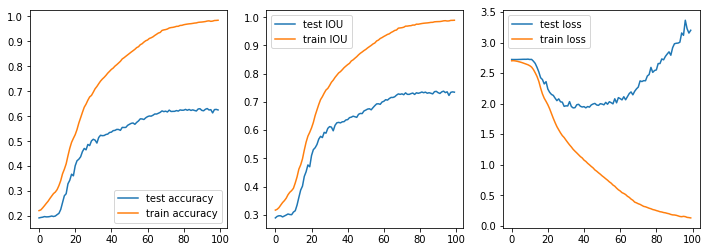

---------------------------------------------------------------------------------------------------- 

Train accuracy:0.996
Test accuracy:0.604
Train IOU:0.997
Test IOU:0.710
Train loss loss:0.052
Test loss loss:1.952


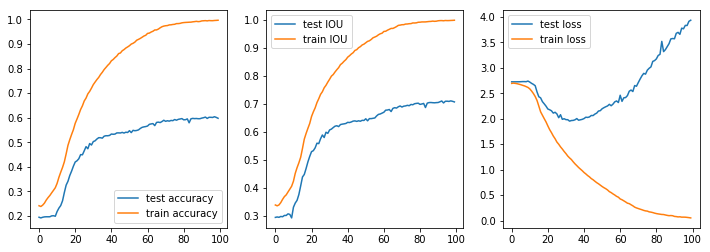

---------------------------------------------------------------------------------------------------- 

Train accuracy:0.998
Test accuracy:0.607
Train IOU:0.999
Test IOU:0.715
Train loss loss:0.032
Test loss loss:1.990


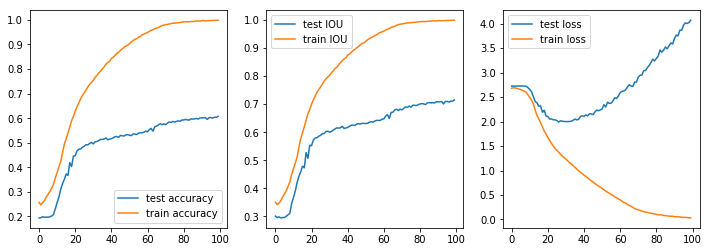

---------------------------------------------------------------------------------------------------- 

Train accuracy:0.999
Test accuracy:0.590
Train IOU:0.999
Test IOU:0.696
Train loss loss:0.030
Test loss loss:1.969


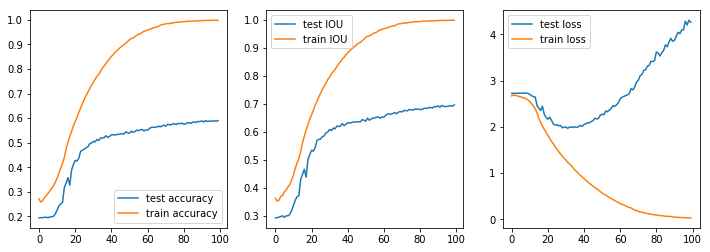

---------------------------------------------------------------------------------------------------- 



In [10]:
f = stats(bi_tst, bi_trn, ephocs=100)

## Attention & Bidirecional RNN

In [8]:
biAttn_tst, biAttn_trn = [], []
num_hiddens=[50, 100, 150, 200]

for num_hidden in num_hiddens:
    params_dir = params_dir_tmp+'RL/EXP/biAttn_simple_'+str(num_hidden)
    tf.reset_default_graph()
    m = Model(
        batch_size=200, 
        num_hidden=num_hidden,
        img_dims=trainset[0][1][0].shape[1], 
        bbox_dims=testset[0][1][1].shape[1], 
        lr=.05,
        vocab=vocab, 
        decay_steps=10000, 
        decay_rate=0.9, 
        useBidirectionalRnn=True,
        use_wordAttn=True
    )


    print('params_dir:', params_dir)
    print('num_hidden:', m.num_hidden)
    print('learning rate:', m.lr)

    tst, trn = m.train(trainset, testset, ephocs_num=100)
    biAttn_tst.append(tst)
    biAttn_trn.append(trn)
    
    print('\n'+'*'*100)
    print('*'*100)
    print('*'*100,'\n')

params_dir: ../data/training/models/All/unorder1_RL/EXP/biAttn3_simple_50
num_hidden: 50
learning rate: 0.05
# Train set size: 59449
# Training batches: 297
# Test set size: 59507
# Testing batches: 297
Initializing variables
Train, ephoc: 0
batch:0 ;gs:1 ;lr:0.050 ;loss:2.695 ;acc:0.260 ;iou:0.325 ;time: 0:00:01
batch:50 ;gs:51 ;lr:0.050 ;loss:2.711 ;acc:0.230 ;iou:0.310 ;time: 0:00:24
batch:100 ;gs:101 ;lr:0.050 ;loss:2.766 ;acc:0.215 ;iou:0.320 ;time: 0:00:49
batch:150 ;gs:151 ;lr:0.050 ;loss:2.718 ;acc:0.165 ;iou:0.265 ;time: 0:01:12
batch:200 ;gs:201 ;lr:0.050 ;loss:2.710 ;acc:0.225 ;iou:0.300 ;time: 0:01:35
batch:250 ;gs:251 ;lr:0.050 ;loss:2.717 ;acc:0.245 ;iou:0.340 ;time: 0:02:00

*Train loss: 2.702 ;Train accuracy: 0.227 ;Train IOU: 0.321 ;Time: 0:02:22 

Testing, ephoc: 0
batch: 0 ;loss: 2.744 ;acc: 0.215 ;iou_acc: 0.295 ;time: 0:02:22
batch: 50 ;loss: 2.744 ;acc: 0.140 ;iou_acc: 0.245 ;time: 0:02:33
batch: 100 ;loss: 2.735 ;acc: 0.230 ;iou_acc: 0.335 ;time: 0:02:43
batch: 1

batch:150 ;gs:2230 ;lr:0.050 ;loss:2.582 ;acc:0.345 ;iou:0.455 ;time: 0:01:11
batch:200 ;gs:2280 ;lr:0.050 ;loss:2.527 ;acc:0.365 ;iou:0.435 ;time: 0:01:35
batch:250 ;gs:2330 ;lr:0.050 ;loss:2.531 ;acc:0.345 ;iou:0.440 ;time: 0:01:58

*Train loss: 2.487 ;Train accuracy: 0.362 ;Train IOU: 0.454 ;Time: 0:02:20 

Testing, ephoc: 7
batch: 0 ;loss: 2.600 ;acc: 0.300 ;iou_acc: 0.405 ;time: 0:02:20
batch: 50 ;loss: 2.683 ;acc: 0.245 ;iou_acc: 0.365 ;time: 0:02:31
batch: 100 ;loss: 2.637 ;acc: 0.305 ;iou_acc: 0.420 ;time: 0:02:41
batch: 150 ;loss: 2.652 ;acc: 0.240 ;iou_acc: 0.365 ;time: 0:02:52
batch: 200 ;loss: 2.674 ;acc: 0.270 ;iou_acc: 0.375 ;time: 0:03:03
batch: 250 ;loss: 2.576 ;acc: 0.250 ;iou_acc: 0.345 ;time: 0:03:13

*Test loss: 2.622 ;Test accuracy 0.269 ;Test IOU: 0.373 ;Time: 0:03:23
Train, ephoc: 8
batch:0 ;gs:2377 ;lr:0.050 ;loss:2.507 ;acc:0.335 ;iou:0.425 ;time: 0:00:01
batch:50 ;gs:2427 ;lr:0.050 ;loss:2.488 ;acc:0.360 ;iou:0.460 ;time: 0:00:25
batch:100 ;gs:2477 ;lr:0.050 ;

batch: 150 ;loss: 2.252 ;acc: 0.395 ;iou_acc: 0.525 ;time: 0:02:51
batch: 200 ;loss: 2.164 ;acc: 0.410 ;iou_acc: 0.525 ;time: 0:03:02
batch: 250 ;loss: 2.159 ;acc: 0.420 ;iou_acc: 0.550 ;time: 0:03:13

*Test loss: 2.183 ;Test accuracy 0.422 ;Test IOU: 0.527 ;Time: 0:03:23
Train, ephoc: 15
batch:0 ;gs:4456 ;lr:0.050 ;loss:1.952 ;acc:0.535 ;iou:0.605 ;time: 0:00:00
batch:50 ;gs:4506 ;lr:0.050 ;loss:1.849 ;acc:0.575 ;iou:0.645 ;time: 0:00:22
batch:100 ;gs:4556 ;lr:0.050 ;loss:1.857 ;acc:0.575 ;iou:0.655 ;time: 0:00:46
batch:150 ;gs:4606 ;lr:0.050 ;loss:2.145 ;acc:0.455 ;iou:0.580 ;time: 0:01:10
batch:200 ;gs:4656 ;lr:0.050 ;loss:1.811 ;acc:0.540 ;iou:0.605 ;time: 0:01:33
batch:250 ;gs:4706 ;lr:0.050 ;loss:1.663 ;acc:0.590 ;iou:0.650 ;time: 0:01:57

*Train loss: 1.876 ;Train accuracy: 0.555 ;Train IOU: 0.635 ;Time: 0:02:18 

Testing, ephoc: 15
batch: 0 ;loss: 2.107 ;acc: 0.445 ;iou_acc: 0.590 ;time: 0:02:19
batch: 50 ;loss: 2.219 ;acc: 0.410 ;iou_acc: 0.495 ;time: 0:02:29
batch: 100 ;loss:

batch:100 ;gs:6635 ;lr:0.050 ;loss:1.680 ;acc:0.645 ;iou:0.715 ;time: 0:00:48
batch:150 ;gs:6685 ;lr:0.050 ;loss:1.329 ;acc:0.720 ;iou:0.775 ;time: 0:01:11
batch:200 ;gs:6735 ;lr:0.050 ;loss:1.616 ;acc:0.630 ;iou:0.730 ;time: 0:01:35
batch:250 ;gs:6785 ;lr:0.050 ;loss:1.687 ;acc:0.565 ;iou:0.630 ;time: 0:01:57

*Train loss: 1.517 ;Train accuracy: 0.662 ;Train IOU: 0.729 ;Time: 0:02:19 

Testing, ephoc: 22
batch: 0 ;loss: 1.906 ;acc: 0.550 ;iou_acc: 0.665 ;time: 0:02:19
batch: 50 ;loss: 2.137 ;acc: 0.450 ;iou_acc: 0.535 ;time: 0:02:30
batch: 100 ;loss: 2.105 ;acc: 0.465 ;iou_acc: 0.615 ;time: 0:02:41
batch: 150 ;loss: 2.186 ;acc: 0.460 ;iou_acc: 0.570 ;time: 0:02:52
batch: 200 ;loss: 1.948 ;acc: 0.520 ;iou_acc: 0.600 ;time: 0:03:03
batch: 250 ;loss: 2.106 ;acc: 0.440 ;iou_acc: 0.550 ;time: 0:03:14

*Test loss: 2.013 ;Test accuracy 0.487 ;Test IOU: 0.589 ;Time: 0:03:24
Train, ephoc: 23
batch:0 ;gs:6832 ;lr:0.050 ;loss:1.567 ;acc:0.615 ;iou:0.700 ;time: 0:00:01
batch:50 ;gs:6882 ;lr:0.050

batch: 100 ;loss: 2.116 ;acc: 0.500 ;iou_acc: 0.630 ;time: 0:02:41
batch: 150 ;loss: 2.030 ;acc: 0.535 ;iou_acc: 0.610 ;time: 0:02:52
batch: 200 ;loss: 2.023 ;acc: 0.485 ;iou_acc: 0.580 ;time: 0:03:03
batch: 250 ;loss: 1.998 ;acc: 0.495 ;iou_acc: 0.620 ;time: 0:03:14

*Test loss: 1.964 ;Test accuracy 0.514 ;Test IOU: 0.612 ;Time: 0:03:24
Train, ephoc: 30
batch:0 ;gs:8911 ;lr:0.050 ;loss:1.318 ;acc:0.730 ;iou:0.800 ;time: 0:00:01
batch:50 ;gs:8961 ;lr:0.050 ;loss:1.098 ;acc:0.785 ;iou:0.840 ;time: 0:00:24
batch:100 ;gs:9011 ;lr:0.050 ;loss:1.107 ;acc:0.765 ;iou:0.820 ;time: 0:00:48
batch:150 ;gs:9061 ;lr:0.050 ;loss:1.184 ;acc:0.765 ;iou:0.825 ;time: 0:01:11
batch:200 ;gs:9111 ;lr:0.050 ;loss:1.534 ;acc:0.665 ;iou:0.720 ;time: 0:01:35
batch:250 ;gs:9161 ;lr:0.050 ;loss:1.042 ;acc:0.785 ;iou:0.815 ;time: 0:01:58

*Train loss: 1.222 ;Train accuracy: 0.744 ;Train IOU: 0.795 ;Time: 0:02:20 

Testing, ephoc: 30
batch: 0 ;loss: 1.910 ;acc: 0.525 ;iou_acc: 0.625 ;time: 0:02:20
batch: 50 ;loss:

batch:50 ;gs:11040 ;lr:0.045 ;loss:0.881 ;acc:0.820 ;iou:0.850 ;time: 0:00:25
batch:100 ;gs:11090 ;lr:0.045 ;loss:1.042 ;acc:0.830 ;iou:0.850 ;time: 0:00:48
batch:150 ;gs:11140 ;lr:0.045 ;loss:0.988 ;acc:0.795 ;iou:0.855 ;time: 0:01:11
batch:200 ;gs:11190 ;lr:0.045 ;loss:0.887 ;acc:0.840 ;iou:0.870 ;time: 0:01:34
batch:250 ;gs:11240 ;lr:0.045 ;loss:0.947 ;acc:0.840 ;iou:0.880 ;time: 0:01:58

*Train loss: 0.986 ;Train accuracy: 0.807 ;Train IOU: 0.848 ;Time: 0:02:19 

Testing, ephoc: 37
batch: 0 ;loss: 1.872 ;acc: 0.535 ;iou_acc: 0.640 ;time: 0:02:20
batch: 50 ;loss: 2.360 ;acc: 0.495 ;iou_acc: 0.585 ;time: 0:02:30
batch: 100 ;loss: 2.267 ;acc: 0.450 ;iou_acc: 0.585 ;time: 0:02:41
batch: 150 ;loss: 2.137 ;acc: 0.520 ;iou_acc: 0.620 ;time: 0:02:52
batch: 200 ;loss: 2.097 ;acc: 0.550 ;iou_acc: 0.650 ;time: 0:03:02
batch: 250 ;loss: 2.092 ;acc: 0.520 ;iou_acc: 0.620 ;time: 0:03:13

*Test loss: 2.079 ;Test accuracy 0.526 ;Test IOU: 0.624 ;Time: 0:03:23
Train, ephoc: 38
batch:0 ;gs:11287 ;lr

batch: 0 ;loss: 1.972 ;acc: 0.590 ;iou_acc: 0.685 ;time: 0:02:19
batch: 50 ;loss: 2.444 ;acc: 0.530 ;iou_acc: 0.605 ;time: 0:02:30
batch: 100 ;loss: 2.277 ;acc: 0.470 ;iou_acc: 0.595 ;time: 0:02:40
batch: 150 ;loss: 2.068 ;acc: 0.560 ;iou_acc: 0.635 ;time: 0:02:52
batch: 200 ;loss: 2.083 ;acc: 0.540 ;iou_acc: 0.635 ;time: 0:03:03
batch: 250 ;loss: 2.204 ;acc: 0.545 ;iou_acc: 0.675 ;time: 0:03:13

*Test loss: 2.133 ;Test accuracy 0.541 ;Test IOU: 0.636 ;Time: 0:03:23
Train, ephoc: 45
batch:0 ;gs:13366 ;lr:0.045 ;loss:0.667 ;acc:0.910 ;iou:0.925 ;time: 0:00:00
batch:50 ;gs:13416 ;lr:0.045 ;loss:0.756 ;acc:0.865 ;iou:0.890 ;time: 0:00:24
batch:100 ;gs:13466 ;lr:0.045 ;loss:0.675 ;acc:0.865 ;iou:0.890 ;time: 0:00:47
batch:150 ;gs:13516 ;lr:0.045 ;loss:0.856 ;acc:0.820 ;iou:0.855 ;time: 0:01:09
batch:200 ;gs:13566 ;lr:0.045 ;loss:0.864 ;acc:0.820 ;iou:0.855 ;time: 0:01:32
batch:250 ;gs:13616 ;lr:0.045 ;loss:0.812 ;acc:0.845 ;iou:0.860 ;time: 0:01:57

*Train loss: 0.789 ;Train accuracy: 0.85

batch:0 ;gs:15445 ;lr:0.045 ;loss:0.532 ;acc:0.925 ;iou:0.970 ;time: 0:00:01
batch:50 ;gs:15495 ;lr:0.045 ;loss:0.613 ;acc:0.905 ;iou:0.915 ;time: 0:00:24
batch:100 ;gs:15545 ;lr:0.045 ;loss:0.809 ;acc:0.850 ;iou:0.875 ;time: 0:00:47
batch:150 ;gs:15595 ;lr:0.045 ;loss:0.704 ;acc:0.885 ;iou:0.890 ;time: 0:01:11
batch:200 ;gs:15645 ;lr:0.045 ;loss:0.801 ;acc:0.845 ;iou:0.850 ;time: 0:01:35
batch:250 ;gs:15695 ;lr:0.045 ;loss:0.764 ;acc:0.845 ;iou:0.900 ;time: 0:01:58

*Train loss: 0.654 ;Train accuracy: 0.884 ;Train IOU: 0.910 ;Time: 0:02:21 

Testing, ephoc: 52
batch: 0 ;loss: 2.099 ;acc: 0.550 ;iou_acc: 0.645 ;time: 0:02:21
batch: 50 ;loss: 2.466 ;acc: 0.545 ;iou_acc: 0.630 ;time: 0:02:32
batch: 100 ;loss: 2.513 ;acc: 0.485 ;iou_acc: 0.625 ;time: 0:02:43
batch: 150 ;loss: 2.151 ;acc: 0.560 ;iou_acc: 0.630 ;time: 0:02:54
batch: 200 ;loss: 2.148 ;acc: 0.575 ;iou_acc: 0.680 ;time: 0:03:04
batch: 250 ;loss: 2.271 ;acc: 0.555 ;iou_acc: 0.675 ;time: 0:03:15

*Test loss: 2.248 ;Test accuracy


*Train loss: 0.499 ;Train accuracy: 0.918 ;Train IOU: 0.938 ;Time: 0:02:20 

Testing, ephoc: 59
batch: 0 ;loss: 2.168 ;acc: 0.575 ;iou_acc: 0.695 ;time: 0:02:20
batch: 50 ;loss: 2.526 ;acc: 0.570 ;iou_acc: 0.680 ;time: 0:02:31
batch: 100 ;loss: 2.400 ;acc: 0.495 ;iou_acc: 0.630 ;time: 0:02:41
batch: 150 ;loss: 2.189 ;acc: 0.585 ;iou_acc: 0.660 ;time: 0:02:53
batch: 200 ;loss: 2.447 ;acc: 0.545 ;iou_acc: 0.635 ;time: 0:03:03
batch: 250 ;loss: 2.379 ;acc: 0.560 ;iou_acc: 0.685 ;time: 0:03:14

*Test loss: 2.369 ;Test accuracy 0.567 ;Test IOU: 0.669 ;Time: 0:03:24
Train, ephoc: 60
batch:0 ;gs:17821 ;lr:0.045 ;loss:0.373 ;acc:0.955 ;iou:0.955 ;time: 0:00:01
batch:50 ;gs:17871 ;lr:0.045 ;loss:0.466 ;acc:0.935 ;iou:0.940 ;time: 0:00:24
batch:100 ;gs:17921 ;lr:0.045 ;loss:0.363 ;acc:0.960 ;iou:0.970 ;time: 0:00:48
batch:150 ;gs:17971 ;lr:0.045 ;loss:0.390 ;acc:0.955 ;iou:0.960 ;time: 0:01:11
batch:200 ;gs:18021 ;lr:0.045 ;loss:0.534 ;acc:0.905 ;iou:0.930 ;time: 0:01:35
batch:250 ;gs:18071 ;lr


*Test loss: 2.542 ;Test accuracy 0.586 ;Test IOU: 0.691 ;Time: 0:03:23
Train, ephoc: 67
batch:0 ;gs:19900 ;lr:0.045 ;loss:0.359 ;acc:0.925 ;iou:0.940 ;time: 0:00:01
batch:50 ;gs:19950 ;lr:0.045 ;loss:0.395 ;acc:0.940 ;iou:0.955 ;time: 0:00:24
batch:100 ;gs:20000 ;lr:0.045 ;loss:0.254 ;acc:0.980 ;iou:0.985 ;time: 0:00:46
batch:150 ;gs:20050 ;lr:0.040 ;loss:0.323 ;acc:0.955 ;iou:0.985 ;time: 0:01:11
batch:200 ;gs:20100 ;lr:0.040 ;loss:0.312 ;acc:0.955 ;iou:0.960 ;time: 0:01:34
batch:250 ;gs:20150 ;lr:0.040 ;loss:0.493 ;acc:0.880 ;iou:0.895 ;time: 0:01:57

*Train loss: 0.339 ;Train accuracy: 0.949 ;Train IOU: 0.964 ;Time: 0:02:19 

Testing, ephoc: 67
batch: 0 ;loss: 2.267 ;acc: 0.625 ;iou_acc: 0.735 ;time: 0:02:19
batch: 50 ;loss: 3.055 ;acc: 0.560 ;iou_acc: 0.660 ;time: 0:02:29
batch: 100 ;loss: 2.784 ;acc: 0.530 ;iou_acc: 0.690 ;time: 0:02:40
batch: 150 ;loss: 2.382 ;acc: 0.595 ;iou_acc: 0.680 ;time: 0:02:51
batch: 200 ;loss: 2.359 ;acc: 0.595 ;iou_acc: 0.695 ;time: 0:03:01
batch: 250 

batch:200 ;gs:22179 ;lr:0.040 ;loss:0.224 ;acc:0.960 ;iou:0.975 ;time: 0:01:36
batch:250 ;gs:22229 ;lr:0.040 ;loss:0.272 ;acc:0.960 ;iou:0.970 ;time: 0:01:58

*Train loss: 0.246 ;Train accuracy: 0.965 ;Train IOU: 0.976 ;Time: 0:02:19 

Testing, ephoc: 74
batch: 0 ;loss: 2.389 ;acc: 0.615 ;iou_acc: 0.710 ;time: 0:02:19
batch: 50 ;loss: 3.320 ;acc: 0.555 ;iou_acc: 0.645 ;time: 0:02:30
batch: 100 ;loss: 3.240 ;acc: 0.570 ;iou_acc: 0.705 ;time: 0:02:40
batch: 150 ;loss: 2.853 ;acc: 0.580 ;iou_acc: 0.685 ;time: 0:02:51
batch: 200 ;loss: 2.706 ;acc: 0.610 ;iou_acc: 0.730 ;time: 0:03:02
batch: 250 ;loss: 3.078 ;acc: 0.580 ;iou_acc: 0.720 ;time: 0:03:12

*Test loss: 2.829 ;Test accuracy 0.600 ;Test IOU: 0.706 ;Time: 0:03:22
Train, ephoc: 75
batch:0 ;gs:22276 ;lr:0.040 ;loss:0.214 ;acc:0.980 ;iou:0.980 ;time: 0:00:00
batch:50 ;gs:22326 ;lr:0.040 ;loss:0.198 ;acc:0.975 ;iou:0.985 ;time: 0:00:22
batch:100 ;gs:22376 ;lr:0.040 ;loss:0.345 ;acc:0.940 ;iou:0.970 ;time: 0:00:45
batch:150 ;gs:22426 ;lr

batch: 150 ;loss: 2.952 ;acc: 0.580 ;iou_acc: 0.670 ;time: 0:02:50
batch: 200 ;loss: 2.891 ;acc: 0.625 ;iou_acc: 0.735 ;time: 0:03:01
batch: 250 ;loss: 3.307 ;acc: 0.575 ;iou_acc: 0.725 ;time: 0:03:12

*Test loss: 2.998 ;Test accuracy 0.608 ;Test IOU: 0.714 ;Time: 0:03:22
Train, ephoc: 82
batch:0 ;gs:24355 ;lr:0.040 ;loss:0.168 ;acc:0.975 ;iou:0.990 ;time: 0:00:01
batch:50 ;gs:24405 ;lr:0.040 ;loss:0.100 ;acc:0.990 ;iou:0.990 ;time: 0:00:25
batch:100 ;gs:24455 ;lr:0.040 ;loss:0.100 ;acc:0.995 ;iou:0.995 ;time: 0:00:46
batch:150 ;gs:24505 ;lr:0.040 ;loss:0.166 ;acc:0.980 ;iou:0.990 ;time: 0:01:10
batch:200 ;gs:24555 ;lr:0.040 ;loss:0.319 ;acc:0.975 ;iou:0.980 ;time: 0:01:34
batch:250 ;gs:24605 ;lr:0.040 ;loss:0.351 ;acc:0.955 ;iou:0.970 ;time: 0:01:55

*Train loss: 0.172 ;Train accuracy: 0.978 ;Train IOU: 0.985 ;Time: 0:02:17 

Testing, ephoc: 82
batch: 0 ;loss: 2.774 ;acc: 0.575 ;iou_acc: 0.695 ;time: 0:02:18
batch: 50 ;loss: 3.598 ;acc: 0.595 ;iou_acc: 0.690 ;time: 0:02:28
batch: 100 

batch:100 ;gs:26534 ;lr:0.040 ;loss:0.118 ;acc:0.980 ;iou:0.985 ;time: 0:00:45
batch:150 ;gs:26584 ;lr:0.040 ;loss:0.194 ;acc:0.970 ;iou:0.990 ;time: 0:01:09
batch:200 ;gs:26634 ;lr:0.040 ;loss:0.287 ;acc:0.970 ;iou:0.980 ;time: 0:01:34
batch:250 ;gs:26684 ;lr:0.040 ;loss:0.134 ;acc:0.980 ;iou:0.985 ;time: 0:01:57

*Train loss: 0.138 ;Train accuracy: 0.982 ;Train IOU: 0.989 ;Time: 0:02:19 

Testing, ephoc: 89
batch: 0 ;loss: 2.713 ;acc: 0.660 ;iou_acc: 0.755 ;time: 0:02:19
batch: 50 ;loss: 3.863 ;acc: 0.580 ;iou_acc: 0.675 ;time: 0:02:30
batch: 100 ;loss: 3.811 ;acc: 0.560 ;iou_acc: 0.705 ;time: 0:02:40
batch: 150 ;loss: 3.559 ;acc: 0.570 ;iou_acc: 0.650 ;time: 0:02:52
batch: 200 ;loss: 2.799 ;acc: 0.640 ;iou_acc: 0.755 ;time: 0:03:02
batch: 250 ;loss: 3.889 ;acc: 0.570 ;iou_acc: 0.710 ;time: 0:03:12

*Test loss: 3.351 ;Test accuracy 0.613 ;Test IOU: 0.721 ;Time: 0:03:21
Train, ephoc: 90
batch:0 ;gs:26731 ;lr:0.040 ;loss:0.070 ;acc:0.990 ;iou:0.995 ;time: 0:00:01
batch:50 ;gs:26781 ;lr

batch: 50 ;loss: 4.124 ;acc: 0.565 ;iou_acc: 0.655 ;time: 0:02:29
batch: 100 ;loss: 3.998 ;acc: 0.565 ;iou_acc: 0.710 ;time: 0:02:40
batch: 150 ;loss: 3.864 ;acc: 0.575 ;iou_acc: 0.665 ;time: 0:02:51
batch: 200 ;loss: 3.140 ;acc: 0.610 ;iou_acc: 0.715 ;time: 0:03:02
batch: 250 ;loss: 4.404 ;acc: 0.565 ;iou_acc: 0.720 ;time: 0:03:13

*Test loss: 3.466 ;Test accuracy 0.611 ;Test IOU: 0.716 ;Time: 0:03:23
Train, ephoc: 97
batch:0 ;gs:28810 ;lr:0.040 ;loss:0.202 ;acc:0.950 ;iou:0.965 ;time: 0:00:00
batch:50 ;gs:28860 ;lr:0.040 ;loss:0.291 ;acc:0.955 ;iou:0.960 ;time: 0:00:22
batch:100 ;gs:28910 ;lr:0.040 ;loss:0.221 ;acc:0.965 ;iou:0.980 ;time: 0:00:46
batch:150 ;gs:28960 ;lr:0.040 ;loss:0.157 ;acc:0.975 ;iou:0.980 ;time: 0:01:08
batch:200 ;gs:29010 ;lr:0.040 ;loss:0.125 ;acc:0.990 ;iou:0.995 ;time: 0:01:32
batch:250 ;gs:29060 ;lr:0.040 ;loss:0.069 ;acc:0.990 ;iou:0.995 ;time: 0:01:54

*Train loss: 0.141 ;Train accuracy: 0.980 ;Train IOU: 0.986 ;Time: 0:02:17 

Testing, ephoc: 97
batch: 0 

batch: 0 ;loss: 2.648 ;acc: 0.275 ;iou_acc: 0.390 ;time: 0:02:28
batch: 50 ;loss: 2.703 ;acc: 0.230 ;iou_acc: 0.315 ;time: 0:02:40
batch: 100 ;loss: 2.680 ;acc: 0.260 ;iou_acc: 0.330 ;time: 0:02:51
batch: 150 ;loss: 2.634 ;acc: 0.250 ;iou_acc: 0.400 ;time: 0:03:03
batch: 200 ;loss: 2.707 ;acc: 0.240 ;iou_acc: 0.355 ;time: 0:03:14
batch: 250 ;loss: 2.634 ;acc: 0.275 ;iou_acc: 0.385 ;time: 0:03:25

*Test loss: 2.650 ;Test accuracy 0.250 ;Test IOU: 0.357 ;Time: 0:03:35
Train, ephoc: 4
batch:0 ;gs:1189 ;lr:0.050 ;loss:2.520 ;acc:0.305 ;iou:0.390 ;time: 0:00:00
batch:50 ;gs:1239 ;lr:0.050 ;loss:2.495 ;acc:0.335 ;iou:0.420 ;time: 0:00:24
batch:100 ;gs:1289 ;lr:0.050 ;loss:2.486 ;acc:0.355 ;iou:0.430 ;time: 0:00:50
batch:150 ;gs:1339 ;lr:0.050 ;loss:2.506 ;acc:0.370 ;iou:0.450 ;time: 0:01:15
batch:200 ;gs:1389 ;lr:0.050 ;loss:2.602 ;acc:0.360 ;iou:0.465 ;time: 0:01:37
batch:250 ;gs:1439 ;lr:0.050 ;loss:2.618 ;acc:0.295 ;iou:0.390 ;time: 0:02:03

*Train loss: 2.525 ;Train accuracy: 0.346 ;Trai

batch:0 ;gs:3268 ;lr:0.050 ;loss:2.186 ;acc:0.460 ;iou:0.555 ;time: 0:00:01
batch:50 ;gs:3318 ;lr:0.050 ;loss:2.319 ;acc:0.400 ;iou:0.480 ;time: 0:00:26
batch:100 ;gs:3368 ;lr:0.050 ;loss:1.994 ;acc:0.550 ;iou:0.645 ;time: 0:00:50
batch:150 ;gs:3418 ;lr:0.050 ;loss:2.095 ;acc:0.490 ;iou:0.590 ;time: 0:01:14
batch:200 ;gs:3468 ;lr:0.050 ;loss:1.750 ;acc:0.595 ;iou:0.675 ;time: 0:01:40
batch:250 ;gs:3518 ;lr:0.050 ;loss:2.103 ;acc:0.445 ;iou:0.510 ;time: 0:02:04

*Train loss: 2.047 ;Train accuracy: 0.510 ;Train IOU: 0.595 ;Time: 0:02:29 

Testing, ephoc: 11
batch: 0 ;loss: 2.268 ;acc: 0.405 ;iou_acc: 0.510 ;time: 0:02:29
batch: 50 ;loss: 2.293 ;acc: 0.395 ;iou_acc: 0.480 ;time: 0:02:41
batch: 100 ;loss: 2.342 ;acc: 0.330 ;iou_acc: 0.440 ;time: 0:02:52
batch: 150 ;loss: 2.280 ;acc: 0.405 ;iou_acc: 0.485 ;time: 0:03:03
batch: 200 ;loss: 2.248 ;acc: 0.400 ;iou_acc: 0.495 ;time: 0:03:14
batch: 250 ;loss: 2.212 ;acc: 0.405 ;iou_acc: 0.525 ;time: 0:03:25

*Test loss: 2.225 ;Test accuracy 0.410

batch: 0 ;loss: 1.982 ;acc: 0.465 ;iou_acc: 0.570 ;time: 0:02:30
batch: 50 ;loss: 2.173 ;acc: 0.455 ;iou_acc: 0.535 ;time: 0:02:41
batch: 100 ;loss: 2.143 ;acc: 0.445 ;iou_acc: 0.545 ;time: 0:02:51
batch: 150 ;loss: 2.171 ;acc: 0.430 ;iou_acc: 0.525 ;time: 0:03:03
batch: 200 ;loss: 2.077 ;acc: 0.455 ;iou_acc: 0.575 ;time: 0:03:15
batch: 250 ;loss: 2.022 ;acc: 0.485 ;iou_acc: 0.580 ;time: 0:03:26

*Test loss: 2.030 ;Test accuracy 0.479 ;Test IOU: 0.581 ;Time: 0:03:36
Train, ephoc: 19
batch:0 ;gs:5644 ;lr:0.050 ;loss:1.507 ;acc:0.700 ;iou:0.750 ;time: 0:00:00
batch:50 ;gs:5694 ;lr:0.050 ;loss:1.346 ;acc:0.720 ;iou:0.770 ;time: 0:00:26
batch:100 ;gs:5744 ;lr:0.050 ;loss:1.385 ;acc:0.700 ;iou:0.730 ;time: 0:00:49
batch:150 ;gs:5794 ;lr:0.050 ;loss:1.401 ;acc:0.700 ;iou:0.755 ;time: 0:01:12
batch:200 ;gs:5844 ;lr:0.050 ;loss:1.475 ;acc:0.670 ;iou:0.755 ;time: 0:01:38
batch:250 ;gs:5894 ;lr:0.050 ;loss:1.410 ;acc:0.675 ;iou:0.720 ;time: 0:02:03

*Train loss: 1.514 ;Train accuracy: 0.668 ;Tra

batch:0 ;gs:7723 ;lr:0.050 ;loss:1.180 ;acc:0.775 ;iou:0.825 ;time: 0:00:01
batch:50 ;gs:7773 ;lr:0.050 ;loss:1.175 ;acc:0.755 ;iou:0.795 ;time: 0:00:24
batch:100 ;gs:7823 ;lr:0.050 ;loss:1.010 ;acc:0.825 ;iou:0.855 ;time: 0:00:48
batch:150 ;gs:7873 ;lr:0.050 ;loss:1.251 ;acc:0.750 ;iou:0.805 ;time: 0:01:13
batch:200 ;gs:7923 ;lr:0.050 ;loss:1.351 ;acc:0.690 ;iou:0.785 ;time: 0:01:37
batch:250 ;gs:7973 ;lr:0.050 ;loss:1.121 ;acc:0.750 ;iou:0.800 ;time: 0:02:04

*Train loss: 1.162 ;Train accuracy: 0.766 ;Train IOU: 0.813 ;Time: 0:02:28 

Testing, ephoc: 26
batch: 0 ;loss: 2.073 ;acc: 0.460 ;iou_acc: 0.575 ;time: 0:02:29
batch: 50 ;loss: 2.295 ;acc: 0.475 ;iou_acc: 0.545 ;time: 0:02:40
batch: 100 ;loss: 2.274 ;acc: 0.465 ;iou_acc: 0.595 ;time: 0:02:51
batch: 150 ;loss: 2.359 ;acc: 0.475 ;iou_acc: 0.570 ;time: 0:03:03
batch: 200 ;loss: 2.063 ;acc: 0.475 ;iou_acc: 0.580 ;time: 0:03:14
batch: 250 ;loss: 2.195 ;acc: 0.470 ;iou_acc: 0.570 ;time: 0:03:25

*Test loss: 2.125 ;Test accuracy 0.496

batch: 0 ;loss: 1.799 ;acc: 0.520 ;iou_acc: 0.625 ;time: 0:02:29
batch: 50 ;loss: 2.283 ;acc: 0.530 ;iou_acc: 0.625 ;time: 0:02:40
batch: 100 ;loss: 2.313 ;acc: 0.450 ;iou_acc: 0.555 ;time: 0:02:51
batch: 150 ;loss: 2.143 ;acc: 0.510 ;iou_acc: 0.615 ;time: 0:03:02
batch: 200 ;loss: 2.015 ;acc: 0.515 ;iou_acc: 0.605 ;time: 0:03:13
batch: 250 ;loss: 2.039 ;acc: 0.575 ;iou_acc: 0.660 ;time: 0:03:24

*Test loss: 2.000 ;Test accuracy 0.535 ;Test IOU: 0.633 ;Time: 0:03:34
Train, ephoc: 34
batch:0 ;gs:10099 ;lr:0.045 ;loss:0.825 ;acc:0.855 ;iou:0.900 ;time: 0:00:00
batch:50 ;gs:10149 ;lr:0.045 ;loss:0.768 ;acc:0.880 ;iou:0.910 ;time: 0:00:25
batch:100 ;gs:10199 ;lr:0.045 ;loss:0.846 ;acc:0.830 ;iou:0.865 ;time: 0:00:51
batch:150 ;gs:10249 ;lr:0.045 ;loss:0.805 ;acc:0.850 ;iou:0.885 ;time: 0:01:16
batch:200 ;gs:10299 ;lr:0.045 ;loss:0.934 ;acc:0.810 ;iou:0.850 ;time: 0:01:41
batch:250 ;gs:10349 ;lr:0.045 ;loss:0.911 ;acc:0.815 ;iou:0.840 ;time: 0:02:05

*Train loss: 0.838 ;Train accuracy: 0.85

batch:0 ;gs:12178 ;lr:0.045 ;loss:0.613 ;acc:0.910 ;iou:0.925 ;time: 0:00:01
batch:50 ;gs:12228 ;lr:0.045 ;loss:0.587 ;acc:0.910 ;iou:0.925 ;time: 0:00:25
batch:100 ;gs:12278 ;lr:0.045 ;loss:0.867 ;acc:0.825 ;iou:0.875 ;time: 0:00:50
batch:150 ;gs:12328 ;lr:0.045 ;loss:0.808 ;acc:0.825 ;iou:0.855 ;time: 0:01:13
batch:200 ;gs:12378 ;lr:0.045 ;loss:0.568 ;acc:0.910 ;iou:0.930 ;time: 0:01:38
batch:250 ;gs:12428 ;lr:0.045 ;loss:0.612 ;acc:0.910 ;iou:0.915 ;time: 0:02:04

*Train loss: 0.649 ;Train accuracy: 0.891 ;Train IOU: 0.914 ;Time: 0:02:27 

Testing, ephoc: 41
batch: 0 ;loss: 2.020 ;acc: 0.520 ;iou_acc: 0.615 ;time: 0:02:27
batch: 50 ;loss: 2.522 ;acc: 0.535 ;iou_acc: 0.600 ;time: 0:02:38
batch: 100 ;loss: 2.487 ;acc: 0.475 ;iou_acc: 0.585 ;time: 0:02:49
batch: 150 ;loss: 2.465 ;acc: 0.510 ;iou_acc: 0.595 ;time: 0:03:01
batch: 200 ;loss: 2.106 ;acc: 0.530 ;iou_acc: 0.605 ;time: 0:03:11
batch: 250 ;loss: 2.373 ;acc: 0.515 ;iou_acc: 0.625 ;time: 0:03:22

*Test loss: 2.211 ;Test accuracy


*Train loss: 0.488 ;Train accuracy: 0.926 ;Train IOU: 0.943 ;Time: 0:02:27 

Testing, ephoc: 48
batch: 0 ;loss: 2.012 ;acc: 0.565 ;iou_acc: 0.680 ;time: 0:02:27
batch: 50 ;loss: 2.812 ;acc: 0.500 ;iou_acc: 0.600 ;time: 0:02:38
batch: 100 ;loss: 2.661 ;acc: 0.495 ;iou_acc: 0.585 ;time: 0:02:49
batch: 150 ;loss: 2.543 ;acc: 0.530 ;iou_acc: 0.595 ;time: 0:03:01
batch: 200 ;loss: 2.307 ;acc: 0.570 ;iou_acc: 0.650 ;time: 0:03:12
batch: 250 ;loss: 2.502 ;acc: 0.570 ;iou_acc: 0.695 ;time: 0:03:23

*Test loss: 2.355 ;Test accuracy 0.550 ;Test IOU: 0.647 ;Time: 0:03:33
Train, ephoc: 49
batch:0 ;gs:14554 ;lr:0.045 ;loss:0.556 ;acc:0.945 ;iou:0.945 ;time: 0:00:01
batch:50 ;gs:14604 ;lr:0.045 ;loss:0.419 ;acc:0.925 ;iou:0.945 ;time: 0:00:26
batch:100 ;gs:14654 ;lr:0.045 ;loss:0.337 ;acc:0.975 ;iou:0.980 ;time: 0:00:51
batch:150 ;gs:14704 ;lr:0.045 ;loss:0.433 ;acc:0.960 ;iou:0.970 ;time: 0:01:15
batch:200 ;gs:14754 ;lr:0.045 ;loss:0.644 ;acc:0.865 ;iou:0.875 ;time: 0:01:40
batch:250 ;gs:14804 ;lr


*Test loss: 2.684 ;Test accuracy 0.558 ;Test IOU: 0.654 ;Time: 0:03:37
Train, ephoc: 56
batch:0 ;gs:16633 ;lr:0.045 ;loss:0.341 ;acc:0.955 ;iou:0.975 ;time: 0:00:01
batch:50 ;gs:16683 ;lr:0.045 ;loss:0.352 ;acc:0.960 ;iou:0.970 ;time: 0:00:27
batch:100 ;gs:16733 ;lr:0.045 ;loss:0.323 ;acc:0.960 ;iou:0.970 ;time: 0:00:52
batch:150 ;gs:16783 ;lr:0.045 ;loss:0.340 ;acc:0.950 ;iou:0.975 ;time: 0:01:16
batch:200 ;gs:16833 ;lr:0.045 ;loss:0.258 ;acc:0.975 ;iou:0.980 ;time: 0:01:41
batch:250 ;gs:16883 ;lr:0.045 ;loss:0.458 ;acc:0.930 ;iou:0.945 ;time: 0:02:06

*Train loss: 0.345 ;Train accuracy: 0.953 ;Train IOU: 0.964 ;Time: 0:02:28 

Testing, ephoc: 56
batch: 0 ;loss: 2.343 ;acc: 0.575 ;iou_acc: 0.675 ;time: 0:02:29
batch: 50 ;loss: 3.113 ;acc: 0.505 ;iou_acc: 0.610 ;time: 0:02:40
batch: 100 ;loss: 3.043 ;acc: 0.505 ;iou_acc: 0.585 ;time: 0:02:51
batch: 150 ;loss: 2.605 ;acc: 0.525 ;iou_acc: 0.615 ;time: 0:03:02
batch: 200 ;loss: 2.711 ;acc: 0.560 ;iou_acc: 0.650 ;time: 0:03:13
batch: 250 

batch:200 ;gs:18912 ;lr:0.045 ;loss:0.279 ;acc:0.940 ;iou:0.955 ;time: 0:01:40
batch:250 ;gs:18962 ;lr:0.045 ;loss:0.298 ;acc:0.960 ;iou:0.975 ;time: 0:02:06

*Train loss: 0.246 ;Train accuracy: 0.970 ;Train IOU: 0.978 ;Time: 0:02:27 

Testing, ephoc: 63
batch: 0 ;loss: 2.391 ;acc: 0.605 ;iou_acc: 0.690 ;time: 0:02:28
batch: 50 ;loss: 3.467 ;acc: 0.535 ;iou_acc: 0.630 ;time: 0:02:39
batch: 100 ;loss: 3.361 ;acc: 0.510 ;iou_acc: 0.615 ;time: 0:02:50
batch: 150 ;loss: 2.986 ;acc: 0.565 ;iou_acc: 0.650 ;time: 0:03:01
batch: 200 ;loss: 3.022 ;acc: 0.565 ;iou_acc: 0.680 ;time: 0:03:13
batch: 250 ;loss: 3.078 ;acc: 0.570 ;iou_acc: 0.700 ;time: 0:03:24

*Test loss: 2.911 ;Test accuracy 0.558 ;Test IOU: 0.657 ;Time: 0:03:34
Train, ephoc: 64
batch:0 ;gs:19009 ;lr:0.045 ;loss:0.285 ;acc:0.970 ;iou:0.975 ;time: 0:00:00
batch:50 ;gs:19059 ;lr:0.045 ;loss:0.203 ;acc:0.970 ;iou:0.985 ;time: 0:00:25
batch:100 ;gs:19109 ;lr:0.045 ;loss:0.215 ;acc:0.980 ;iou:0.985 ;time: 0:00:51
batch:150 ;gs:19159 ;lr

batch: 150 ;loss: 3.444 ;acc: 0.560 ;iou_acc: 0.640 ;time: 0:03:02
batch: 200 ;loss: 3.487 ;acc: 0.590 ;iou_acc: 0.675 ;time: 0:03:13
batch: 250 ;loss: 3.291 ;acc: 0.560 ;iou_acc: 0.720 ;time: 0:03:24

*Test loss: 3.257 ;Test accuracy 0.568 ;Test IOU: 0.670 ;Time: 0:03:35
Train, ephoc: 71
batch:0 ;gs:21088 ;lr:0.040 ;loss:0.090 ;acc:0.990 ;iou:0.990 ;time: 0:00:00
batch:50 ;gs:21138 ;lr:0.040 ;loss:0.102 ;acc:0.995 ;iou:1.000 ;time: 0:00:25
batch:100 ;gs:21188 ;lr:0.040 ;loss:0.157 ;acc:0.980 ;iou:0.980 ;time: 0:00:50
batch:150 ;gs:21238 ;lr:0.040 ;loss:0.102 ;acc:0.990 ;iou:0.990 ;time: 0:01:15
batch:200 ;gs:21288 ;lr:0.040 ;loss:0.141 ;acc:0.990 ;iou:0.995 ;time: 0:01:41
batch:250 ;gs:21338 ;lr:0.040 ;loss:0.140 ;acc:0.985 ;iou:0.985 ;time: 0:02:06

*Train loss: 0.135 ;Train accuracy: 0.986 ;Train IOU: 0.990 ;Time: 0:02:28 

Testing, ephoc: 71
batch: 0 ;loss: 2.764 ;acc: 0.595 ;iou_acc: 0.690 ;time: 0:02:29
batch: 50 ;loss: 3.714 ;acc: 0.580 ;iou_acc: 0.665 ;time: 0:02:40
batch: 100 

batch:100 ;gs:23267 ;lr:0.040 ;loss:0.061 ;acc:1.000 ;iou:1.000 ;time: 0:00:50
batch:150 ;gs:23317 ;lr:0.040 ;loss:0.142 ;acc:0.985 ;iou:0.995 ;time: 0:01:17
batch:200 ;gs:23367 ;lr:0.040 ;loss:0.136 ;acc:0.990 ;iou:0.990 ;time: 0:01:43
batch:250 ;gs:23417 ;lr:0.040 ;loss:0.081 ;acc:0.995 ;iou:0.995 ;time: 0:02:08

*Train loss: 0.096 ;Train accuracy: 0.991 ;Train IOU: 0.994 ;Time: 0:02:31 

Testing, ephoc: 78
batch: 0 ;loss: 2.744 ;acc: 0.605 ;iou_acc: 0.695 ;time: 0:02:31
batch: 50 ;loss: 3.971 ;acc: 0.565 ;iou_acc: 0.665 ;time: 0:02:42
batch: 100 ;loss: 4.112 ;acc: 0.540 ;iou_acc: 0.645 ;time: 0:02:53
batch: 150 ;loss: 3.824 ;acc: 0.560 ;iou_acc: 0.660 ;time: 0:03:04
batch: 200 ;loss: 3.710 ;acc: 0.570 ;iou_acc: 0.670 ;time: 0:03:15
batch: 250 ;loss: 4.132 ;acc: 0.590 ;iou_acc: 0.725 ;time: 0:03:27

*Test loss: 3.560 ;Test accuracy 0.578 ;Test IOU: 0.679 ;Time: 0:03:37
Train, ephoc: 79
batch:0 ;gs:23464 ;lr:0.040 ;loss:0.085 ;acc:0.995 ;iou:1.000 ;time: 0:00:00
batch:50 ;gs:23514 ;lr

batch: 50 ;loss: 4.084 ;acc: 0.565 ;iou_acc: 0.665 ;time: 0:02:39
batch: 100 ;loss: 4.296 ;acc: 0.545 ;iou_acc: 0.640 ;time: 0:02:50
batch: 150 ;loss: 4.177 ;acc: 0.540 ;iou_acc: 0.620 ;time: 0:03:02
batch: 200 ;loss: 4.186 ;acc: 0.560 ;iou_acc: 0.655 ;time: 0:03:13
batch: 250 ;loss: 4.261 ;acc: 0.565 ;iou_acc: 0.715 ;time: 0:03:24

*Test loss: 3.787 ;Test accuracy 0.584 ;Test IOU: 0.684 ;Time: 0:03:34
Train, ephoc: 86
batch:0 ;gs:25543 ;lr:0.040 ;loss:0.096 ;acc:0.985 ;iou:0.990 ;time: 0:00:01
batch:50 ;gs:25593 ;lr:0.040 ;loss:0.049 ;acc:0.995 ;iou:1.000 ;time: 0:00:27
batch:100 ;gs:25643 ;lr:0.040 ;loss:0.068 ;acc:0.990 ;iou:0.990 ;time: 0:00:52
batch:150 ;gs:25693 ;lr:0.040 ;loss:0.061 ;acc:0.995 ;iou:1.000 ;time: 0:01:17
batch:200 ;gs:25743 ;lr:0.040 ;loss:0.110 ;acc:0.985 ;iou:0.995 ;time: 0:01:42
batch:250 ;gs:25793 ;lr:0.040 ;loss:0.063 ;acc:0.995 ;iou:0.995 ;time: 0:02:06

*Train loss: 0.073 ;Train accuracy: 0.993 ;Train IOU: 0.995 ;Time: 0:02:30 

Testing, ephoc: 86
batch: 0 

batch:0 ;gs:27622 ;lr:0.040 ;loss:0.061 ;acc:1.000 ;iou:1.000 ;time: 0:00:01
batch:50 ;gs:27672 ;lr:0.040 ;loss:0.029 ;acc:1.000 ;iou:1.000 ;time: 0:00:24
batch:100 ;gs:27722 ;lr:0.040 ;loss:0.044 ;acc:0.995 ;iou:0.995 ;time: 0:00:49
batch:150 ;gs:27772 ;lr:0.040 ;loss:0.021 ;acc:1.000 ;iou:1.000 ;time: 0:01:13
batch:200 ;gs:27822 ;lr:0.040 ;loss:0.098 ;acc:0.985 ;iou:0.990 ;time: 0:01:38
batch:250 ;gs:27872 ;lr:0.040 ;loss:0.041 ;acc:0.995 ;iou:1.000 ;time: 0:02:03

*Train loss: 0.049 ;Train accuracy: 0.996 ;Train IOU: 0.997 ;Time: 0:02:27 

Testing, ephoc: 93
batch: 0 ;loss: 3.060 ;acc: 0.615 ;iou_acc: 0.725 ;time: 0:02:27
batch: 50 ;loss: 4.481 ;acc: 0.560 ;iou_acc: 0.675 ;time: 0:02:38
batch: 100 ;loss: 4.817 ;acc: 0.550 ;iou_acc: 0.630 ;time: 0:02:50
batch: 150 ;loss: 4.645 ;acc: 0.570 ;iou_acc: 0.665 ;time: 0:03:02
batch: 200 ;loss: 4.322 ;acc: 0.575 ;iou_acc: 0.700 ;time: 0:03:13
batch: 250 ;loss: 4.684 ;acc: 0.570 ;iou_acc: 0.705 ;time: 0:03:24

*Test loss: 4.083 ;Test accuracy

batch:0 ;gs:1 ;lr:0.050 ;loss:2.530 ;acc:0.315 ;iou:0.440 ;time: 0:00:01
batch:50 ;gs:51 ;lr:0.050 ;loss:2.541 ;acc:0.285 ;iou:0.415 ;time: 0:00:28
batch:100 ;gs:101 ;lr:0.050 ;loss:2.630 ;acc:0.270 ;iou:0.345 ;time: 0:00:55
batch:150 ;gs:151 ;lr:0.050 ;loss:2.773 ;acc:0.255 ;iou:0.340 ;time: 0:01:23
batch:200 ;gs:201 ;lr:0.050 ;loss:2.687 ;acc:0.265 ;iou:0.380 ;time: 0:01:52
batch:250 ;gs:251 ;lr:0.050 ;loss:2.677 ;acc:0.270 ;iou:0.380 ;time: 0:02:22

*Train loss: 2.674 ;Train accuracy: 0.265 ;Train IOU: 0.362 ;Time: 0:02:49 

Testing, ephoc: 0
batch: 0 ;loss: 2.729 ;acc: 0.190 ;iou_acc: 0.290 ;time: 0:02:50
batch: 50 ;loss: 2.739 ;acc: 0.205 ;iou_acc: 0.295 ;time: 0:03:02
batch: 100 ;loss: 2.718 ;acc: 0.240 ;iou_acc: 0.330 ;time: 0:03:14
batch: 150 ;loss: 2.684 ;acc: 0.260 ;iou_acc: 0.345 ;time: 0:03:28
batch: 200 ;loss: 2.771 ;acc: 0.190 ;iou_acc: 0.245 ;time: 0:03:40
batch: 250 ;loss: 2.694 ;acc: 0.255 ;iou_acc: 0.360 ;time: 0:03:52

*Test loss: 2.715 ;Test accuracy 0.208 ;Test IOU

batch: 0 ;loss: 2.573 ;acc: 0.310 ;iou_acc: 0.405 ;time: 0:02:47
batch: 50 ;loss: 2.630 ;acc: 0.295 ;iou_acc: 0.395 ;time: 0:02:59
batch: 100 ;loss: 2.613 ;acc: 0.265 ;iou_acc: 0.350 ;time: 0:03:11
batch: 150 ;loss: 2.627 ;acc: 0.275 ;iou_acc: 0.360 ;time: 0:03:24
batch: 200 ;loss: 2.670 ;acc: 0.275 ;iou_acc: 0.360 ;time: 0:03:36
batch: 250 ;loss: 2.577 ;acc: 0.300 ;iou_acc: 0.405 ;time: 0:03:49

*Test loss: 2.616 ;Test accuracy 0.275 ;Test IOU: 0.380 ;Time: 0:04:00
Train, ephoc: 8
batch:0 ;gs:2377 ;lr:0.050 ;loss:2.308 ;acc:0.420 ;iou:0.515 ;time: 0:00:00
batch:50 ;gs:2427 ;lr:0.050 ;loss:2.498 ;acc:0.360 ;iou:0.440 ;time: 0:00:29
batch:100 ;gs:2477 ;lr:0.050 ;loss:2.288 ;acc:0.450 ;iou:0.485 ;time: 0:00:57
batch:150 ;gs:2527 ;lr:0.050 ;loss:2.149 ;acc:0.480 ;iou:0.565 ;time: 0:01:24
batch:200 ;gs:2577 ;lr:0.050 ;loss:2.196 ;acc:0.445 ;iou:0.545 ;time: 0:01:53
batch:250 ;gs:2627 ;lr:0.050 ;loss:2.771 ;acc:0.300 ;iou:0.375 ;time: 0:02:20

*Train loss: 2.325 ;Train accuracy: 0.430 ;Trai

batch:0 ;gs:4456 ;lr:0.050 ;loss:1.606 ;acc:0.665 ;iou:0.750 ;time: 0:00:00
batch:50 ;gs:4506 ;lr:0.050 ;loss:1.880 ;acc:0.575 ;iou:0.640 ;time: 0:00:28
batch:100 ;gs:4556 ;lr:0.050 ;loss:1.849 ;acc:0.525 ;iou:0.610 ;time: 0:00:57
batch:150 ;gs:4606 ;lr:0.050 ;loss:1.741 ;acc:0.620 ;iou:0.705 ;time: 0:01:26
batch:200 ;gs:4656 ;lr:0.050 ;loss:1.690 ;acc:0.605 ;iou:0.655 ;time: 0:01:53
batch:250 ;gs:4706 ;lr:0.050 ;loss:1.778 ;acc:0.605 ;iou:0.690 ;time: 0:02:20

*Train loss: 1.756 ;Train accuracy: 0.601 ;Train IOU: 0.676 ;Time: 0:02:46 

Testing, ephoc: 15
batch: 0 ;loss: 2.350 ;acc: 0.330 ;iou_acc: 0.435 ;time: 0:02:46
batch: 50 ;loss: 2.306 ;acc: 0.420 ;iou_acc: 0.515 ;time: 0:02:59
batch: 100 ;loss: 2.377 ;acc: 0.400 ;iou_acc: 0.525 ;time: 0:03:11
batch: 150 ;loss: 2.353 ;acc: 0.405 ;iou_acc: 0.525 ;time: 0:03:24
batch: 200 ;loss: 2.243 ;acc: 0.440 ;iou_acc: 0.555 ;time: 0:03:36
batch: 250 ;loss: 2.379 ;acc: 0.385 ;iou_acc: 0.485 ;time: 0:03:49

*Test loss: 2.286 ;Test accuracy 0.403

batch: 0 ;loss: 2.020 ;acc: 0.470 ;iou_acc: 0.610 ;time: 0:02:46
batch: 50 ;loss: 2.103 ;acc: 0.490 ;iou_acc: 0.580 ;time: 0:02:58
batch: 100 ;loss: 2.136 ;acc: 0.465 ;iou_acc: 0.575 ;time: 0:03:10
batch: 150 ;loss: 2.145 ;acc: 0.490 ;iou_acc: 0.595 ;time: 0:03:23
batch: 200 ;loss: 2.095 ;acc: 0.470 ;iou_acc: 0.580 ;time: 0:03:35
batch: 250 ;loss: 2.127 ;acc: 0.470 ;iou_acc: 0.555 ;time: 0:03:47

*Test loss: 2.081 ;Test accuracy 0.476 ;Test IOU: 0.580 ;Time: 0:03:59
Train, ephoc: 23
batch:0 ;gs:6832 ;lr:0.050 ;loss:1.269 ;acc:0.720 ;iou:0.745 ;time: 0:00:00
batch:50 ;gs:6882 ;lr:0.050 ;loss:1.412 ;acc:0.690 ;iou:0.755 ;time: 0:00:30
batch:100 ;gs:6932 ;lr:0.050 ;loss:1.386 ;acc:0.700 ;iou:0.775 ;time: 0:00:56
batch:150 ;gs:6982 ;lr:0.050 ;loss:1.457 ;acc:0.680 ;iou:0.730 ;time: 0:01:25
batch:200 ;gs:7032 ;lr:0.050 ;loss:1.384 ;acc:0.700 ;iou:0.765 ;time: 0:01:53
batch:250 ;gs:7082 ;lr:0.050 ;loss:1.532 ;acc:0.650 ;iou:0.720 ;time: 0:02:22

*Train loss: 1.345 ;Train accuracy: 0.720 ;Tra

batch:0 ;gs:8911 ;lr:0.050 ;loss:1.044 ;acc:0.835 ;iou:0.860 ;time: 0:00:00
batch:50 ;gs:8961 ;lr:0.050 ;loss:0.827 ;acc:0.860 ;iou:0.875 ;time: 0:00:27
batch:100 ;gs:9011 ;lr:0.050 ;loss:0.860 ;acc:0.870 ;iou:0.890 ;time: 0:00:57
batch:150 ;gs:9061 ;lr:0.050 ;loss:0.958 ;acc:0.845 ;iou:0.900 ;time: 0:01:25
batch:200 ;gs:9111 ;lr:0.050 ;loss:1.051 ;acc:0.770 ;iou:0.815 ;time: 0:01:53
batch:250 ;gs:9161 ;lr:0.050 ;loss:0.992 ;acc:0.805 ;iou:0.840 ;time: 0:02:21

*Train loss: 1.006 ;Train accuracy: 0.812 ;Train IOU: 0.849 ;Time: 0:02:47 

Testing, ephoc: 30
batch: 0 ;loss: 1.994 ;acc: 0.485 ;iou_acc: 0.620 ;time: 0:02:47
batch: 50 ;loss: 2.293 ;acc: 0.475 ;iou_acc: 0.540 ;time: 0:03:00
batch: 100 ;loss: 2.293 ;acc: 0.420 ;iou_acc: 0.525 ;time: 0:03:12
batch: 150 ;loss: 2.156 ;acc: 0.525 ;iou_acc: 0.605 ;time: 0:03:25
batch: 200 ;loss: 2.104 ;acc: 0.520 ;iou_acc: 0.625 ;time: 0:03:37
batch: 250 ;loss: 2.178 ;acc: 0.475 ;iou_acc: 0.600 ;time: 0:03:50

*Test loss: 2.144 ;Test accuracy 0.495


*Train loss: 0.712 ;Train accuracy: 0.882 ;Train IOU: 0.907 ;Time: 0:02:46 

Testing, ephoc: 37
batch: 0 ;loss: 2.119 ;acc: 0.530 ;iou_acc: 0.645 ;time: 0:02:47
batch: 50 ;loss: 2.266 ;acc: 0.540 ;iou_acc: 0.625 ;time: 0:02:59
batch: 100 ;loss: 2.430 ;acc: 0.440 ;iou_acc: 0.570 ;time: 0:03:11
batch: 150 ;loss: 2.205 ;acc: 0.580 ;iou_acc: 0.650 ;time: 0:03:24
batch: 200 ;loss: 2.158 ;acc: 0.565 ;iou_acc: 0.680 ;time: 0:03:36
batch: 250 ;loss: 2.095 ;acc: 0.505 ;iou_acc: 0.615 ;time: 0:03:48

*Test loss: 2.157 ;Test accuracy 0.532 ;Test IOU: 0.633 ;Time: 0:03:59
Train, ephoc: 38
batch:0 ;gs:11287 ;lr:0.045 ;loss:0.713 ;acc:0.875 ;iou:0.915 ;time: 0:00:01
batch:50 ;gs:11337 ;lr:0.045 ;loss:0.900 ;acc:0.815 ;iou:0.860 ;time: 0:00:32
batch:100 ;gs:11387 ;lr:0.045 ;loss:0.582 ;acc:0.935 ;iou:0.935 ;time: 0:00:58
batch:150 ;gs:11437 ;lr:0.045 ;loss:0.631 ;acc:0.930 ;iou:0.940 ;time: 0:01:26
batch:200 ;gs:11487 ;lr:0.045 ;loss:0.808 ;acc:0.835 ;iou:0.850 ;time: 0:01:54
batch:250 ;gs:11537 ;lr


*Test loss: 2.412 ;Test accuracy 0.536 ;Test IOU: 0.637 ;Time: 0:04:02
Train, ephoc: 45
batch:0 ;gs:13366 ;lr:0.045 ;loss:0.454 ;acc:0.920 ;iou:0.930 ;time: 0:00:01
batch:50 ;gs:13416 ;lr:0.045 ;loss:0.412 ;acc:0.945 ;iou:0.955 ;time: 0:00:29
batch:100 ;gs:13466 ;lr:0.045 ;loss:0.583 ;acc:0.895 ;iou:0.935 ;time: 0:00:57
batch:150 ;gs:13516 ;lr:0.045 ;loss:0.458 ;acc:0.925 ;iou:0.930 ;time: 0:01:24
batch:200 ;gs:13566 ;lr:0.045 ;loss:0.430 ;acc:0.950 ;iou:0.970 ;time: 0:01:53
batch:250 ;gs:13616 ;lr:0.045 ;loss:0.510 ;acc:0.920 ;iou:0.940 ;time: 0:02:21

*Train loss: 0.476 ;Train accuracy: 0.931 ;Train IOU: 0.947 ;Time: 0:02:48 

Testing, ephoc: 45
batch: 0 ;loss: 2.139 ;acc: 0.565 ;iou_acc: 0.670 ;time: 0:02:48
batch: 50 ;loss: 2.543 ;acc: 0.540 ;iou_acc: 0.620 ;time: 0:03:00
batch: 100 ;loss: 2.519 ;acc: 0.480 ;iou_acc: 0.615 ;time: 0:03:13
batch: 150 ;loss: 2.269 ;acc: 0.595 ;iou_acc: 0.650 ;time: 0:03:26
batch: 200 ;loss: 2.391 ;acc: 0.540 ;iou_acc: 0.665 ;time: 0:03:38
batch: 250 

batch:200 ;gs:15645 ;lr:0.045 ;loss:0.362 ;acc:0.950 ;iou:0.960 ;time: 0:01:56
batch:250 ;gs:15695 ;lr:0.045 ;loss:0.242 ;acc:0.975 ;iou:0.975 ;time: 0:02:23

*Train loss: 0.305 ;Train accuracy: 0.962 ;Train IOU: 0.972 ;Time: 0:02:48 

Testing, ephoc: 52
batch: 0 ;loss: 2.121 ;acc: 0.585 ;iou_acc: 0.680 ;time: 0:02:49
batch: 50 ;loss: 2.854 ;acc: 0.540 ;iou_acc: 0.615 ;time: 0:03:01
batch: 100 ;loss: 2.695 ;acc: 0.545 ;iou_acc: 0.665 ;time: 0:03:13
batch: 150 ;loss: 2.467 ;acc: 0.580 ;iou_acc: 0.645 ;time: 0:03:26
batch: 200 ;loss: 2.470 ;acc: 0.570 ;iou_acc: 0.685 ;time: 0:03:39
batch: 250 ;loss: 2.618 ;acc: 0.545 ;iou_acc: 0.665 ;time: 0:03:51

*Test loss: 2.601 ;Test accuracy 0.557 ;Test IOU: 0.657 ;Time: 0:04:02
Train, ephoc: 53
batch:0 ;gs:15742 ;lr:0.045 ;loss:0.206 ;acc:1.000 ;iou:1.000 ;time: 0:00:01
batch:50 ;gs:15792 ;lr:0.045 ;loss:0.210 ;acc:0.975 ;iou:0.975 ;time: 0:00:29
batch:100 ;gs:15842 ;lr:0.045 ;loss:0.266 ;acc:0.965 ;iou:0.975 ;time: 0:00:59
batch:150 ;gs:15892 ;lr

batch: 150 ;loss: 2.675 ;acc: 0.595 ;iou_acc: 0.695 ;time: 0:03:25
batch: 200 ;loss: 2.883 ;acc: 0.585 ;iou_acc: 0.700 ;time: 0:03:37
batch: 250 ;loss: 2.848 ;acc: 0.540 ;iou_acc: 0.665 ;time: 0:03:50

*Test loss: 2.816 ;Test accuracy 0.577 ;Test IOU: 0.680 ;Time: 0:04:01
Train, ephoc: 60
batch:0 ;gs:17821 ;lr:0.045 ;loss:0.167 ;acc:0.985 ;iou:0.985 ;time: 0:00:01
batch:50 ;gs:17871 ;lr:0.045 ;loss:0.177 ;acc:0.985 ;iou:0.995 ;time: 0:00:31
batch:100 ;gs:17921 ;lr:0.045 ;loss:0.215 ;acc:0.970 ;iou:0.970 ;time: 0:01:00
batch:150 ;gs:17971 ;lr:0.045 ;loss:0.202 ;acc:0.985 ;iou:0.985 ;time: 0:01:28
batch:200 ;gs:18021 ;lr:0.045 ;loss:0.172 ;acc:0.990 ;iou:0.990 ;time: 0:01:56
batch:250 ;gs:18071 ;lr:0.045 ;loss:0.168 ;acc:0.985 ;iou:0.990 ;time: 0:02:24

*Train loss: 0.192 ;Train accuracy: 0.978 ;Train IOU: 0.984 ;Time: 0:02:48 

Testing, ephoc: 60
batch: 0 ;loss: 2.368 ;acc: 0.620 ;iou_acc: 0.695 ;time: 0:02:49
batch: 50 ;loss: 3.357 ;acc: 0.520 ;iou_acc: 0.625 ;time: 0:03:01
batch: 100 

batch:100 ;gs:20000 ;lr:0.045 ;loss:0.093 ;acc:1.000 ;iou:1.000 ;time: 0:00:59
batch:150 ;gs:20050 ;lr:0.040 ;loss:0.146 ;acc:0.985 ;iou:0.995 ;time: 0:01:27
batch:200 ;gs:20100 ;lr:0.040 ;loss:0.096 ;acc:1.000 ;iou:1.000 ;time: 0:01:55
batch:250 ;gs:20150 ;lr:0.040 ;loss:0.188 ;acc:0.970 ;iou:0.980 ;time: 0:02:24

*Train loss: 0.112 ;Train accuracy: 0.991 ;Train IOU: 0.993 ;Time: 0:02:49 

Testing, ephoc: 67
batch: 0 ;loss: 2.653 ;acc: 0.585 ;iou_acc: 0.695 ;time: 0:02:50
batch: 50 ;loss: 3.486 ;acc: 0.585 ;iou_acc: 0.660 ;time: 0:03:02
batch: 100 ;loss: 3.372 ;acc: 0.540 ;iou_acc: 0.660 ;time: 0:03:14
batch: 150 ;loss: 3.020 ;acc: 0.605 ;iou_acc: 0.710 ;time: 0:03:27
batch: 200 ;loss: 3.183 ;acc: 0.575 ;iou_acc: 0.695 ;time: 0:03:39
batch: 250 ;loss: 3.195 ;acc: 0.555 ;iou_acc: 0.670 ;time: 0:03:51

*Test loss: 3.148 ;Test accuracy 0.588 ;Test IOU: 0.692 ;Time: 0:04:03
Train, ephoc: 68
batch:0 ;gs:20197 ;lr:0.040 ;loss:0.057 ;acc:1.000 ;iou:1.000 ;time: 0:00:00
batch:50 ;gs:20247 ;lr

batch: 50 ;loss: 3.932 ;acc: 0.430 ;iou_acc: 0.515 ;time: 0:03:02
batch: 100 ;loss: 3.761 ;acc: 0.405 ;iou_acc: 0.555 ;time: 0:03:14
batch: 150 ;loss: 4.047 ;acc: 0.440 ;iou_acc: 0.550 ;time: 0:03:27
batch: 200 ;loss: 4.037 ;acc: 0.395 ;iou_acc: 0.510 ;time: 0:03:39
batch: 250 ;loss: 4.143 ;acc: 0.385 ;iou_acc: 0.470 ;time: 0:03:52

*Test loss: 4.079 ;Test accuracy 0.404 ;Test IOU: 0.515 ;Time: 0:04:03
Train, ephoc: 75
batch:0 ;gs:22276 ;lr:0.040 ;loss:1.320 ;acc:0.720 ;iou:0.765 ;time: 0:00:01
batch:50 ;gs:22326 ;lr:0.040 ;loss:0.682 ;acc:0.870 ;iou:0.905 ;time: 0:00:29
batch:100 ;gs:22376 ;lr:0.040 ;loss:0.238 ;acc:0.975 ;iou:0.980 ;time: 0:00:56
batch:150 ;gs:22426 ;lr:0.040 ;loss:0.106 ;acc:0.995 ;iou:0.995 ;time: 0:01:26
batch:200 ;gs:22476 ;lr:0.040 ;loss:0.070 ;acc:0.995 ;iou:1.000 ;time: 0:01:54
batch:250 ;gs:22526 ;lr:0.040 ;loss:0.157 ;acc:0.975 ;iou:0.975 ;time: 0:02:22

*Train loss: 0.370 ;Train accuracy: 0.936 ;Train IOU: 0.949 ;Time: 0:02:49 

Testing, ephoc: 75
batch: 0 

batch:0 ;gs:24355 ;lr:0.040 ;loss:0.022 ;acc:1.000 ;iou:1.000 ;time: 0:00:01
batch:50 ;gs:24405 ;lr:0.040 ;loss:0.025 ;acc:1.000 ;iou:1.000 ;time: 0:00:29
batch:100 ;gs:24455 ;lr:0.040 ;loss:0.032 ;acc:1.000 ;iou:1.000 ;time: 0:00:57
batch:150 ;gs:24505 ;lr:0.040 ;loss:0.032 ;acc:1.000 ;iou:1.000 ;time: 0:01:27
batch:200 ;gs:24555 ;lr:0.040 ;loss:0.039 ;acc:1.000 ;iou:1.000 ;time: 0:01:54
batch:250 ;gs:24605 ;lr:0.040 ;loss:0.059 ;acc:0.995 ;iou:0.995 ;time: 0:02:22

*Train loss: 0.041 ;Train accuracy: 0.998 ;Train IOU: 0.999 ;Time: 0:02:48 

Testing, ephoc: 82
batch: 0 ;loss: 3.064 ;acc: 0.645 ;iou_acc: 0.750 ;time: 0:02:49
batch: 50 ;loss: 4.240 ;acc: 0.550 ;iou_acc: 0.665 ;time: 0:03:01
batch: 100 ;loss: 3.773 ;acc: 0.565 ;iou_acc: 0.705 ;time: 0:03:13
batch: 150 ;loss: 3.906 ;acc: 0.610 ;iou_acc: 0.720 ;time: 0:03:26
batch: 200 ;loss: 3.947 ;acc: 0.585 ;iou_acc: 0.680 ;time: 0:03:38
batch: 250 ;loss: 3.962 ;acc: 0.545 ;iou_acc: 0.655 ;time: 0:03:50

*Test loss: 3.797 ;Test accuracy


*Train loss: 0.031 ;Train accuracy: 0.998 ;Train IOU: 0.999 ;Time: 0:02:47 

Testing, ephoc: 89
batch: 0 ;loss: 3.397 ;acc: 0.645 ;iou_acc: 0.760 ;time: 0:02:47
batch: 50 ;loss: 4.321 ;acc: 0.575 ;iou_acc: 0.660 ;time: 0:03:00
batch: 100 ;loss: 4.097 ;acc: 0.580 ;iou_acc: 0.720 ;time: 0:03:12
batch: 150 ;loss: 3.957 ;acc: 0.595 ;iou_acc: 0.715 ;time: 0:03:25
batch: 200 ;loss: 3.992 ;acc: 0.575 ;iou_acc: 0.700 ;time: 0:03:37
batch: 250 ;loss: 4.170 ;acc: 0.565 ;iou_acc: 0.695 ;time: 0:03:50

*Test loss: 4.061 ;Test accuracy 0.598 ;Test IOU: 0.701 ;Time: 0:04:01
Train, ephoc: 90
batch:0 ;gs:26731 ;lr:0.040 ;loss:0.024 ;acc:1.000 ;iou:1.000 ;time: 0:00:01
batch:50 ;gs:26781 ;lr:0.040 ;loss:0.035 ;acc:1.000 ;iou:1.000 ;time: 0:00:31
batch:100 ;gs:26831 ;lr:0.040 ;loss:0.021 ;acc:1.000 ;iou:1.000 ;time: 0:00:58
batch:150 ;gs:26881 ;lr:0.040 ;loss:0.013 ;acc:1.000 ;iou:1.000 ;time: 0:01:26
batch:200 ;gs:26931 ;lr:0.040 ;loss:0.038 ;acc:0.990 ;iou:0.990 ;time: 0:01:54
batch:250 ;gs:26981 ;lr


*Test loss: 4.139 ;Test accuracy 0.598 ;Test IOU: 0.702 ;Time: 0:04:03
Train, ephoc: 97
batch:0 ;gs:28810 ;lr:0.040 ;loss:0.026 ;acc:0.995 ;iou:1.000 ;time: 0:00:00
batch:50 ;gs:28860 ;lr:0.040 ;loss:0.028 ;acc:1.000 ;iou:1.000 ;time: 0:00:28
batch:100 ;gs:28910 ;lr:0.040 ;loss:0.015 ;acc:1.000 ;iou:1.000 ;time: 0:00:55
batch:150 ;gs:28960 ;lr:0.040 ;loss:0.010 ;acc:1.000 ;iou:1.000 ;time: 0:01:25
batch:200 ;gs:29010 ;lr:0.040 ;loss:0.018 ;acc:1.000 ;iou:1.000 ;time: 0:01:53
batch:250 ;gs:29060 ;lr:0.040 ;loss:0.029 ;acc:1.000 ;iou:1.000 ;time: 0:02:23

*Train loss: 0.032 ;Train accuracy: 0.998 ;Train IOU: 0.999 ;Time: 0:02:48 

Testing, ephoc: 97
batch: 0 ;loss: 3.380 ;acc: 0.650 ;iou_acc: 0.765 ;time: 0:02:48
batch: 50 ;loss: 4.545 ;acc: 0.590 ;iou_acc: 0.680 ;time: 0:03:00
batch: 100 ;loss: 3.639 ;acc: 0.575 ;iou_acc: 0.700 ;time: 0:03:12
batch: 150 ;loss: 4.246 ;acc: 0.610 ;iou_acc: 0.715 ;time: 0:03:25
batch: 200 ;loss: 4.242 ;acc: 0.575 ;iou_acc: 0.675 ;time: 0:03:38
batch: 250 

batch: 250 ;loss: 2.653 ;acc: 0.215 ;iou_acc: 0.335 ;time: 0:03:51

*Test loss: 2.660 ;Test accuracy 0.248 ;Test IOU: 0.357 ;Time: 0:04:02
Train, ephoc: 4
batch:0 ;gs:1189 ;lr:0.050 ;loss:2.470 ;acc:0.385 ;iou:0.485 ;time: 0:00:00
batch:50 ;gs:1239 ;lr:0.050 ;loss:2.527 ;acc:0.390 ;iou:0.460 ;time: 0:00:28
batch:100 ;gs:1289 ;lr:0.050 ;loss:2.523 ;acc:0.330 ;iou:0.430 ;time: 0:00:56
batch:150 ;gs:1339 ;lr:0.050 ;loss:2.545 ;acc:0.350 ;iou:0.440 ;time: 0:01:24
batch:200 ;gs:1389 ;lr:0.050 ;loss:2.443 ;acc:0.360 ;iou:0.465 ;time: 0:01:52
batch:250 ;gs:1439 ;lr:0.050 ;loss:2.530 ;acc:0.330 ;iou:0.410 ;time: 0:02:21

*Train loss: 2.495 ;Train accuracy: 0.366 ;Train IOU: 0.453 ;Time: 0:02:48 

Testing, ephoc: 4
batch: 0 ;loss: 2.620 ;acc: 0.270 ;iou_acc: 0.365 ;time: 0:02:49
batch: 50 ;loss: 2.713 ;acc: 0.225 ;iou_acc: 0.330 ;time: 0:03:01
batch: 100 ;loss: 2.684 ;acc: 0.260 ;iou_acc: 0.350 ;time: 0:03:13
batch: 150 ;loss: 2.651 ;acc: 0.235 ;iou_acc: 0.330 ;time: 0:03:27
batch: 200 ;loss: 2

batch:200 ;gs:3468 ;lr:0.050 ;loss:2.166 ;acc:0.435 ;iou:0.525 ;time: 0:01:55
batch:250 ;gs:3518 ;lr:0.050 ;loss:2.026 ;acc:0.490 ;iou:0.575 ;time: 0:02:23

*Train loss: 2.075 ;Train accuracy: 0.513 ;Train IOU: 0.591 ;Time: 0:02:49 

Testing, ephoc: 11
batch: 0 ;loss: 2.293 ;acc: 0.375 ;iou_acc: 0.480 ;time: 0:02:50
batch: 50 ;loss: 2.478 ;acc: 0.345 ;iou_acc: 0.425 ;time: 0:03:02
batch: 100 ;loss: 2.470 ;acc: 0.365 ;iou_acc: 0.445 ;time: 0:03:15
batch: 150 ;loss: 2.455 ;acc: 0.320 ;iou_acc: 0.435 ;time: 0:03:28
batch: 200 ;loss: 2.315 ;acc: 0.420 ;iou_acc: 0.515 ;time: 0:03:40
batch: 250 ;loss: 2.305 ;acc: 0.335 ;iou_acc: 0.445 ;time: 0:03:52

*Test loss: 2.363 ;Test accuracy 0.359 ;Test IOU: 0.463 ;Time: 0:04:04
Train, ephoc: 12
batch:0 ;gs:3565 ;lr:0.050 ;loss:1.955 ;acc:0.565 ;iou:0.605 ;time: 0:00:00
batch:50 ;gs:3615 ;lr:0.050 ;loss:1.949 ;acc:0.600 ;iou:0.670 ;time: 0:00:30
batch:100 ;gs:3665 ;lr:0.050 ;loss:1.967 ;acc:0.560 ;iou:0.630 ;time: 0:00:58
batch:150 ;gs:3715 ;lr:0.050

batch: 200 ;loss: 2.124 ;acc: 0.435 ;iou_acc: 0.540 ;time: 0:03:40
batch: 250 ;loss: 2.119 ;acc: 0.415 ;iou_acc: 0.530 ;time: 0:03:52

*Test loss: 2.117 ;Test accuracy 0.445 ;Test IOU: 0.550 ;Time: 0:04:03
Train, ephoc: 19
batch:0 ;gs:5644 ;lr:0.050 ;loss:1.445 ;acc:0.725 ;iou:0.770 ;time: 0:00:01
batch:50 ;gs:5694 ;lr:0.050 ;loss:1.331 ;acc:0.750 ;iou:0.795 ;time: 0:00:29
batch:100 ;gs:5744 ;lr:0.050 ;loss:1.481 ;acc:0.645 ;iou:0.735 ;time: 0:00:57
batch:150 ;gs:5794 ;lr:0.050 ;loss:1.621 ;acc:0.595 ;iou:0.675 ;time: 0:01:25
batch:200 ;gs:5844 ;lr:0.050 ;loss:1.494 ;acc:0.670 ;iou:0.735 ;time: 0:01:55
batch:250 ;gs:5894 ;lr:0.050 ;loss:1.447 ;acc:0.730 ;iou:0.765 ;time: 0:02:23

*Train loss: 1.519 ;Train accuracy: 0.675 ;Train IOU: 0.735 ;Time: 0:02:49 

Testing, ephoc: 19
batch: 0 ;loss: 2.025 ;acc: 0.455 ;iou_acc: 0.560 ;time: 0:02:49
batch: 50 ;loss: 2.147 ;acc: 0.445 ;iou_acc: 0.525 ;time: 0:03:02
batch: 100 ;loss: 2.230 ;acc: 0.440 ;iou_acc: 0.540 ;time: 0:03:14
batch: 150 ;loss:

batch:150 ;gs:7873 ;lr:0.050 ;loss:1.070 ;acc:0.800 ;iou:0.840 ;time: 0:01:27
batch:200 ;gs:7923 ;lr:0.050 ;loss:1.141 ;acc:0.765 ;iou:0.805 ;time: 0:01:55
batch:250 ;gs:7973 ;lr:0.050 ;loss:1.240 ;acc:0.770 ;iou:0.800 ;time: 0:02:23

*Train loss: 1.130 ;Train accuracy: 0.780 ;Train IOU: 0.824 ;Time: 0:02:48 

Testing, ephoc: 26
batch: 0 ;loss: 1.926 ;acc: 0.515 ;iou_acc: 0.665 ;time: 0:02:48
batch: 50 ;loss: 2.183 ;acc: 0.465 ;iou_acc: 0.555 ;time: 0:03:00
batch: 100 ;loss: 2.240 ;acc: 0.415 ;iou_acc: 0.515 ;time: 0:03:13
batch: 150 ;loss: 2.127 ;acc: 0.485 ;iou_acc: 0.600 ;time: 0:03:26
batch: 200 ;loss: 1.943 ;acc: 0.525 ;iou_acc: 0.595 ;time: 0:03:38
batch: 250 ;loss: 2.081 ;acc: 0.470 ;iou_acc: 0.580 ;time: 0:03:51

*Test loss: 2.038 ;Test accuracy 0.490 ;Test IOU: 0.593 ;Time: 0:04:02
Train, ephoc: 27
batch:0 ;gs:8020 ;lr:0.050 ;loss:1.196 ;acc:0.725 ;iou:0.760 ;time: 0:00:01
batch:50 ;gs:8070 ;lr:0.050 ;loss:1.162 ;acc:0.785 ;iou:0.810 ;time: 0:00:29
batch:100 ;gs:8120 ;lr:0.050

batch: 150 ;loss: 2.272 ;acc: 0.515 ;iou_acc: 0.600 ;time: 0:03:27
batch: 200 ;loss: 2.115 ;acc: 0.510 ;iou_acc: 0.610 ;time: 0:03:39
batch: 250 ;loss: 2.226 ;acc: 0.470 ;iou_acc: 0.595 ;time: 0:03:52

*Test loss: 2.151 ;Test accuracy 0.522 ;Test IOU: 0.624 ;Time: 0:04:04
Train, ephoc: 34
batch:0 ;gs:10099 ;lr:0.045 ;loss:0.709 ;acc:0.905 ;iou:0.925 ;time: 0:00:01
batch:50 ;gs:10149 ;lr:0.045 ;loss:0.763 ;acc:0.880 ;iou:0.910 ;time: 0:00:29
batch:100 ;gs:10199 ;lr:0.045 ;loss:0.741 ;acc:0.915 ;iou:0.930 ;time: 0:00:58
batch:150 ;gs:10249 ;lr:0.045 ;loss:0.691 ;acc:0.915 ;iou:0.935 ;time: 0:01:27
batch:200 ;gs:10299 ;lr:0.045 ;loss:1.085 ;acc:0.745 ;iou:0.805 ;time: 0:01:56
batch:250 ;gs:10349 ;lr:0.045 ;loss:0.742 ;acc:0.860 ;iou:0.885 ;time: 0:02:24

*Train loss: 0.755 ;Train accuracy: 0.873 ;Train IOU: 0.901 ;Time: 0:02:49 

Testing, ephoc: 34
batch: 0 ;loss: 1.881 ;acc: 0.560 ;iou_acc: 0.665 ;time: 0:02:49
batch: 50 ;loss: 2.461 ;acc: 0.500 ;iou_acc: 0.580 ;time: 0:03:01
batch: 100 

batch:100 ;gs:12278 ;lr:0.045 ;loss:0.526 ;acc:0.925 ;iou:0.935 ;time: 0:00:56
batch:150 ;gs:12328 ;lr:0.045 ;loss:0.562 ;acc:0.900 ;iou:0.915 ;time: 0:01:25
batch:200 ;gs:12378 ;lr:0.045 ;loss:0.537 ;acc:0.910 ;iou:0.930 ;time: 0:01:56
batch:250 ;gs:12428 ;lr:0.045 ;loss:0.710 ;acc:0.865 ;iou:0.895 ;time: 0:02:23

*Train loss: 0.538 ;Train accuracy: 0.919 ;Train IOU: 0.937 ;Time: 0:02:48 

Testing, ephoc: 41
batch: 0 ;loss: 2.120 ;acc: 0.530 ;iou_acc: 0.635 ;time: 0:02:48
batch: 50 ;loss: 2.796 ;acc: 0.515 ;iou_acc: 0.605 ;time: 0:03:00
batch: 100 ;loss: 2.549 ;acc: 0.490 ;iou_acc: 0.565 ;time: 0:03:12
batch: 150 ;loss: 2.309 ;acc: 0.560 ;iou_acc: 0.650 ;time: 0:03:25
batch: 200 ;loss: 2.388 ;acc: 0.500 ;iou_acc: 0.610 ;time: 0:03:38
batch: 250 ;loss: 2.316 ;acc: 0.510 ;iou_acc: 0.635 ;time: 0:03:50

*Test loss: 2.358 ;Test accuracy 0.533 ;Test IOU: 0.631 ;Time: 0:04:01
Train, ephoc: 42
batch:0 ;gs:12475 ;lr:0.045 ;loss:0.504 ;acc:0.915 ;iou:0.925 ;time: 0:00:01
batch:50 ;gs:12525 ;lr

batch: 50 ;loss: 2.900 ;acc: 0.510 ;iou_acc: 0.590 ;time: 0:03:02
batch: 100 ;loss: 2.799 ;acc: 0.475 ;iou_acc: 0.585 ;time: 0:03:14
batch: 150 ;loss: 2.548 ;acc: 0.570 ;iou_acc: 0.645 ;time: 0:03:27
batch: 200 ;loss: 2.539 ;acc: 0.530 ;iou_acc: 0.610 ;time: 0:03:39
batch: 250 ;loss: 2.616 ;acc: 0.530 ;iou_acc: 0.625 ;time: 0:03:52

*Test loss: 2.626 ;Test accuracy 0.542 ;Test IOU: 0.642 ;Time: 0:04:03
Train, ephoc: 49
batch:0 ;gs:14554 ;lr:0.045 ;loss:0.350 ;acc:0.975 ;iou:0.980 ;time: 0:00:01
batch:50 ;gs:14604 ;lr:0.045 ;loss:0.310 ;acc:0.970 ;iou:0.970 ;time: 0:00:30
batch:100 ;gs:14654 ;lr:0.045 ;loss:0.303 ;acc:0.965 ;iou:0.970 ;time: 0:00:59
batch:150 ;gs:14704 ;lr:0.045 ;loss:0.295 ;acc:0.970 ;iou:0.975 ;time: 0:01:28
batch:200 ;gs:14754 ;lr:0.045 ;loss:0.276 ;acc:0.970 ;iou:0.975 ;time: 0:01:57
batch:250 ;gs:14804 ;lr:0.045 ;loss:0.354 ;acc:0.960 ;iou:0.970 ;time: 0:02:23

*Train loss: 0.358 ;Train accuracy: 0.953 ;Train IOU: 0.964 ;Time: 0:02:51 

Testing, ephoc: 49
batch: 0 

batch:0 ;gs:16633 ;lr:0.045 ;loss:0.221 ;acc:0.965 ;iou:0.970 ;time: 0:00:01
batch:50 ;gs:16683 ;lr:0.045 ;loss:0.300 ;acc:0.945 ;iou:0.960 ;time: 0:00:29
batch:100 ;gs:16733 ;lr:0.045 ;loss:0.150 ;acc:0.990 ;iou:0.995 ;time: 0:00:58
batch:150 ;gs:16783 ;lr:0.045 ;loss:0.195 ;acc:0.990 ;iou:0.990 ;time: 0:01:26
batch:200 ;gs:16833 ;lr:0.045 ;loss:0.199 ;acc:0.980 ;iou:0.985 ;time: 0:01:54
batch:250 ;gs:16883 ;lr:0.045 ;loss:0.496 ;acc:0.905 ;iou:0.915 ;time: 0:02:23

*Train loss: 0.236 ;Train accuracy: 0.973 ;Train IOU: 0.979 ;Time: 0:02:49 

Testing, ephoc: 56
batch: 0 ;loss: 2.512 ;acc: 0.605 ;iou_acc: 0.710 ;time: 0:02:49
batch: 50 ;loss: 3.713 ;acc: 0.515 ;iou_acc: 0.585 ;time: 0:03:01
batch: 100 ;loss: 3.061 ;acc: 0.545 ;iou_acc: 0.635 ;time: 0:03:14
batch: 150 ;loss: 2.908 ;acc: 0.540 ;iou_acc: 0.610 ;time: 0:03:27
batch: 200 ;loss: 3.126 ;acc: 0.520 ;iou_acc: 0.630 ;time: 0:03:39
batch: 250 ;loss: 3.130 ;acc: 0.530 ;iou_acc: 0.630 ;time: 0:03:52

*Test loss: 2.988 ;Test accuracy


*Train loss: 0.157 ;Train accuracy: 0.984 ;Train IOU: 0.988 ;Time: 0:02:51 

Testing, ephoc: 63
batch: 0 ;loss: 2.628 ;acc: 0.590 ;iou_acc: 0.695 ;time: 0:02:51
batch: 50 ;loss: 3.643 ;acc: 0.520 ;iou_acc: 0.615 ;time: 0:03:03
batch: 100 ;loss: 3.107 ;acc: 0.510 ;iou_acc: 0.620 ;time: 0:03:16
batch: 150 ;loss: 3.050 ;acc: 0.560 ;iou_acc: 0.660 ;time: 0:03:29
batch: 200 ;loss: 3.019 ;acc: 0.540 ;iou_acc: 0.630 ;time: 0:03:41
batch: 250 ;loss: 3.073 ;acc: 0.555 ;iou_acc: 0.670 ;time: 0:03:53

*Test loss: 3.231 ;Test accuracy 0.549 ;Test IOU: 0.652 ;Time: 0:04:04
Train, ephoc: 64
batch:0 ;gs:19009 ;lr:0.045 ;loss:0.188 ;acc:0.970 ;iou:0.985 ;time: 0:00:01
batch:50 ;gs:19059 ;lr:0.045 ;loss:0.142 ;acc:0.990 ;iou:0.995 ;time: 0:00:29
batch:100 ;gs:19109 ;lr:0.045 ;loss:0.116 ;acc:0.995 ;iou:0.995 ;time: 0:00:58
batch:150 ;gs:19159 ;lr:0.045 ;loss:0.203 ;acc:0.965 ;iou:0.970 ;time: 0:01:26
batch:200 ;gs:19209 ;lr:0.045 ;loss:0.149 ;acc:0.995 ;iou:0.995 ;time: 0:01:56
batch:250 ;gs:19259 ;lr


*Test loss: 3.778 ;Test accuracy 0.556 ;Test IOU: 0.660 ;Time: 0:04:04
Train, ephoc: 71
batch:0 ;gs:21088 ;lr:0.040 ;loss:0.100 ;acc:0.990 ;iou:0.990 ;time: 0:00:01
batch:50 ;gs:21138 ;lr:0.040 ;loss:0.052 ;acc:1.000 ;iou:1.000 ;time: 0:00:30
batch:100 ;gs:21188 ;lr:0.040 ;loss:0.052 ;acc:1.000 ;iou:1.000 ;time: 0:00:59
batch:150 ;gs:21238 ;lr:0.040 ;loss:0.075 ;acc:0.985 ;iou:0.985 ;time: 0:01:29
batch:200 ;gs:21288 ;lr:0.040 ;loss:0.092 ;acc:0.995 ;iou:0.995 ;time: 0:01:59
batch:250 ;gs:21338 ;lr:0.040 ;loss:0.050 ;acc:0.995 ;iou:1.000 ;time: 0:02:28

*Train loss: 0.076 ;Train accuracy: 0.994 ;Train IOU: 0.996 ;Time: 0:02:52 

Testing, ephoc: 71
batch: 0 ;loss: 3.257 ;acc: 0.595 ;iou_acc: 0.700 ;time: 0:02:53
batch: 50 ;loss: 4.127 ;acc: 0.545 ;iou_acc: 0.620 ;time: 0:03:05
batch: 100 ;loss: 3.775 ;acc: 0.525 ;iou_acc: 0.655 ;time: 0:03:17
batch: 150 ;loss: 3.779 ;acc: 0.545 ;iou_acc: 0.640 ;time: 0:03:30
batch: 200 ;loss: 3.488 ;acc: 0.555 ;iou_acc: 0.675 ;time: 0:03:43
batch: 250 

batch:200 ;gs:23367 ;lr:0.040 ;loss:0.072 ;acc:0.990 ;iou:0.990 ;time: 0:01:55
batch:250 ;gs:23417 ;lr:0.040 ;loss:0.079 ;acc:0.995 ;iou:0.995 ;time: 0:02:24

*Train loss: 0.076 ;Train accuracy: 0.993 ;Train IOU: 0.995 ;Time: 0:02:51 

Testing, ephoc: 78
batch: 0 ;loss: 3.237 ;acc: 0.585 ;iou_acc: 0.690 ;time: 0:02:51
batch: 50 ;loss: 4.419 ;acc: 0.535 ;iou_acc: 0.620 ;time: 0:03:03
batch: 100 ;loss: 4.463 ;acc: 0.510 ;iou_acc: 0.620 ;time: 0:03:16
batch: 150 ;loss: 3.665 ;acc: 0.550 ;iou_acc: 0.650 ;time: 0:03:29
batch: 200 ;loss: 3.918 ;acc: 0.530 ;iou_acc: 0.630 ;time: 0:03:40
batch: 250 ;loss: 3.883 ;acc: 0.530 ;iou_acc: 0.655 ;time: 0:03:53

*Test loss: 4.074 ;Test accuracy 0.554 ;Test IOU: 0.657 ;Time: 0:04:04
Train, ephoc: 79
batch:0 ;gs:23464 ;lr:0.040 ;loss:0.131 ;acc:0.975 ;iou:0.985 ;time: 0:00:01
batch:50 ;gs:23514 ;lr:0.040 ;loss:0.078 ;acc:0.995 ;iou:1.000 ;time: 0:00:29
batch:100 ;gs:23564 ;lr:0.040 ;loss:0.038 ;acc:1.000 ;iou:1.000 ;time: 0:00:56
batch:150 ;gs:23614 ;lr

batch: 150 ;loss: 4.468 ;acc: 0.550 ;iou_acc: 0.650 ;time: 0:03:26
batch: 200 ;loss: 4.085 ;acc: 0.575 ;iou_acc: 0.680 ;time: 0:03:38
batch: 250 ;loss: 3.885 ;acc: 0.555 ;iou_acc: 0.690 ;time: 0:03:51

*Test loss: 4.222 ;Test accuracy 0.570 ;Test IOU: 0.675 ;Time: 0:04:02
Train, ephoc: 86
batch:0 ;gs:25543 ;lr:0.040 ;loss:0.056 ;acc:0.995 ;iou:0.995 ;time: 0:00:01
batch:50 ;gs:25593 ;lr:0.040 ;loss:0.019 ;acc:1.000 ;iou:1.000 ;time: 0:00:29
batch:100 ;gs:25643 ;lr:0.040 ;loss:0.026 ;acc:1.000 ;iou:1.000 ;time: 0:00:56
batch:150 ;gs:25693 ;lr:0.040 ;loss:0.026 ;acc:1.000 ;iou:1.000 ;time: 0:01:25
batch:200 ;gs:25743 ;lr:0.040 ;loss:0.047 ;acc:0.995 ;iou:1.000 ;time: 0:01:55
batch:250 ;gs:25793 ;lr:0.040 ;loss:0.057 ;acc:0.990 ;iou:1.000 ;time: 0:02:24

*Train loss: 0.042 ;Train accuracy: 0.997 ;Train IOU: 0.998 ;Time: 0:02:49 

Testing, ephoc: 86
batch: 0 ;loss: 3.628 ;acc: 0.605 ;iou_acc: 0.725 ;time: 0:02:50
batch: 50 ;loss: 4.444 ;acc: 0.565 ;iou_acc: 0.625 ;time: 0:03:02
batch: 100 

batch:100 ;gs:27722 ;lr:0.040 ;loss:0.016 ;acc:1.000 ;iou:1.000 ;time: 0:00:58
batch:150 ;gs:27772 ;lr:0.040 ;loss:0.015 ;acc:1.000 ;iou:1.000 ;time: 0:01:25
batch:200 ;gs:27822 ;lr:0.040 ;loss:0.016 ;acc:1.000 ;iou:1.000 ;time: 0:01:54
batch:250 ;gs:27872 ;lr:0.040 ;loss:0.029 ;acc:0.995 ;iou:0.995 ;time: 0:02:23

*Train loss: 0.019 ;Train accuracy: 0.999 ;Train IOU: 0.999 ;Time: 0:02:49 

Testing, ephoc: 93
batch: 0 ;loss: 4.022 ;acc: 0.615 ;iou_acc: 0.720 ;time: 0:02:49
batch: 50 ;loss: 5.457 ;acc: 0.535 ;iou_acc: 0.595 ;time: 0:03:01
batch: 100 ;loss: 4.583 ;acc: 0.530 ;iou_acc: 0.645 ;time: 0:03:13
batch: 150 ;loss: 4.788 ;acc: 0.520 ;iou_acc: 0.630 ;time: 0:03:27
batch: 200 ;loss: 4.638 ;acc: 0.565 ;iou_acc: 0.695 ;time: 0:03:39
batch: 250 ;loss: 4.337 ;acc: 0.580 ;iou_acc: 0.705 ;time: 0:03:52

*Test loss: 4.689 ;Test accuracy 0.574 ;Test IOU: 0.679 ;Time: 0:04:04
Train, ephoc: 94
batch:0 ;gs:27919 ;lr:0.040 ;loss:0.016 ;acc:1.000 ;iou:1.000 ;time: 0:00:00
batch:50 ;gs:27969 ;lr

In [ ]:
np.save(open('../data/training/results/toNoteBiAttn__tst.bin', 'wb'), biAttn_tst)
np.save(open('../data/training/results/toNoteBiAttn__trn.bin', 'wb'), biAttn_trn)

Train accuracy:0.988
Test accuracy:0.617
Train P@1:0.993
Test P@1:0.722
Train loss loss:0.102
Test loss loss:1.964


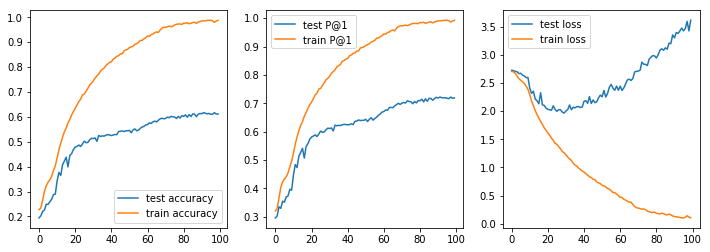

---------------------------------------------------------------------------------------------------- 

Train accuracy:0.998
Test accuracy:0.594
Train P@1:0.999
Test P@1:0.697
Train loss loss:0.034
Test loss loss:1.941


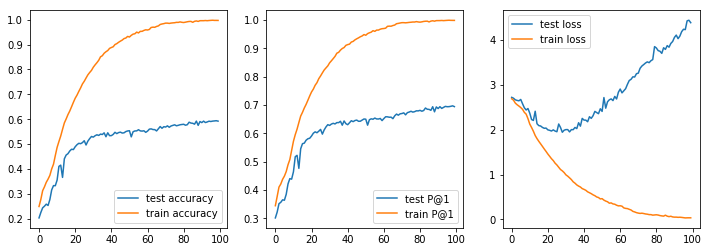

---------------------------------------------------------------------------------------------------- 

Train accuracy:0.999
Test accuracy:0.605
Train P@1:0.999
Test P@1:0.709
Train loss loss:0.025
Test loss loss:2.039


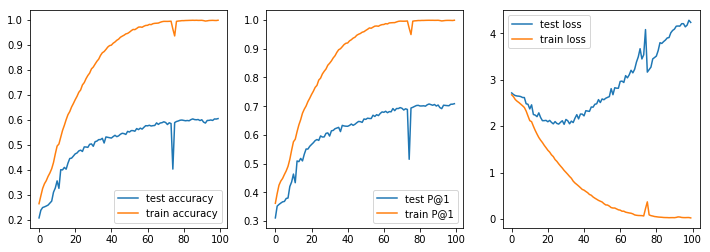

---------------------------------------------------------------------------------------------------- 

Train accuracy:0.999
Test accuracy:0.578
Train P@1:1.000
Test P@1:0.682
Train loss loss:0.014
Test loss loss:2.038


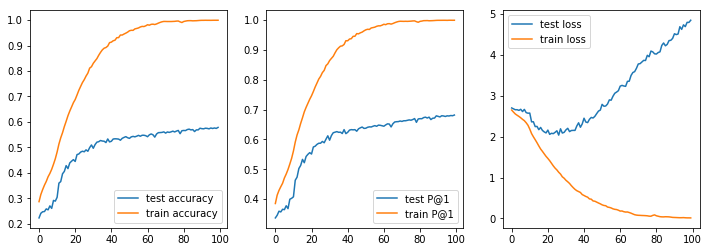

---------------------------------------------------------------------------------------------------- 



In [10]:
f = stats(biAttn_tst, biAttn_trn, ephocs=100)